In [ ]:
!git clone https://github.com/11erlangga/mpdw-kelompok1.git

Cloning into 'mpdw-kelompok1'...
remote: Enumerating objects: 141, done.
remote: Counting objects: 100% (141/141), done.
remote: Compressing objects: 100% (132/132), done.
remote: Total 141 (delta 53), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (141/141), 693.16 KiB | 7.22 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 8.7 MB/s eta 0:00:00


# Import Dependencies

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchsummary import summary

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
import pickle
from tqdm import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_percentage_error

from nbeats_model import NBeatsInterpretableModel
from nbeats_utils import TimeSeriesDataset, EarlyStopping, progression_plot

import optuna
from optuna.exceptions import TrialPruned

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [ ]:
def loop_fn(mode, dataset, dataloader, model, criterion, optimizer, device):
  if mode == "train":
    model.train()
    context_manager = torch.enable_grad()
  elif mode == "val":
    model.eval()
    context_manager = torch.inference_mode()

  with context_manager:
    total_cost = 0
    for feature, target in tqdm(dataloader, leave=False, desc=mode.title()):
      feature, target = feature.to(device, non_blocking=True), target.to(device, non_blocking=True)
      outputs = model(feature)
      pred = outputs["forecast_total"]
      loss = criterion(pred, target)

      if mode == "train":
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      total_cost += loss.item() * feature.shape[0]

    avg_cost = total_cost / len(dataset)
    return avg_cost

def forecast_with_rolling_origin(model, train_data, test_data, in_len, device):
  model.eval()

  current_data = train_data.copy().reset_index(drop=True)
  preds = []
  trend_preds = []
  season_preds = []

  for i in tqdm(range(len(test_data))):
    input_feat = torch.tensor(
        current_data[-in_len:]['y'].values,
        dtype=torch.float32,
        device=device
    ).unsqueeze(0).unsqueeze(-1)

    with torch.inference_mode():
      outputs = model(input_feat)

    preds.append(outputs["forecast_total"].detach().cpu().numpy().ravel()[0])
    trend_preds.append(outputs["forecast_trend"].detach().cpu().numpy().ravel()[0])
    season_preds.append(outputs["forecast_seasonality"].detach().cpu().numpy().ravel()[0])

    actual_row = test_data.iloc[i:i+1].copy().reset_index(drop=True)
    current_data = pd.concat([current_data, actual_row], ignore_index=True)

  return np.array(preds), np.array(trend_preds), np.array(season_preds)

def mean_absolute_scaled_error(y_true, y_pred):
  n = len(y_true)
  d = np.abs(np.diff(y_true)).sum()/(n-1)
  errors = np.abs(y_true - y_pred)
  return errors.mean()/d

def weighted_absolute_percentage_error(y_true, y_pred):
  return np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true)) * 100

# Data Preparation

In [ ]:
data = pd.read_csv('/content/mpdw-kelompok1/data/train.csv')
data['Date'] = pd.to_datetime(data['Date'])

data.set_index('Date', drop=True, inplace=True)
data.drop(columns=['In_Total', 'Total_Total'], inplace=True)
data.rename(columns={'Out_Total': 'y'}, inplace=True)

data

,y
Date,
2023-01-01,41799
2023-01-02,53543
2023-01-03,53846
2023-01-04,55379
2023-01-05,58437
...,...
2023-11-26,51518
2023-11-27,67043
2023-11-28,59229


# Hyperparameter Tuning with Optuna

## Data Visualization

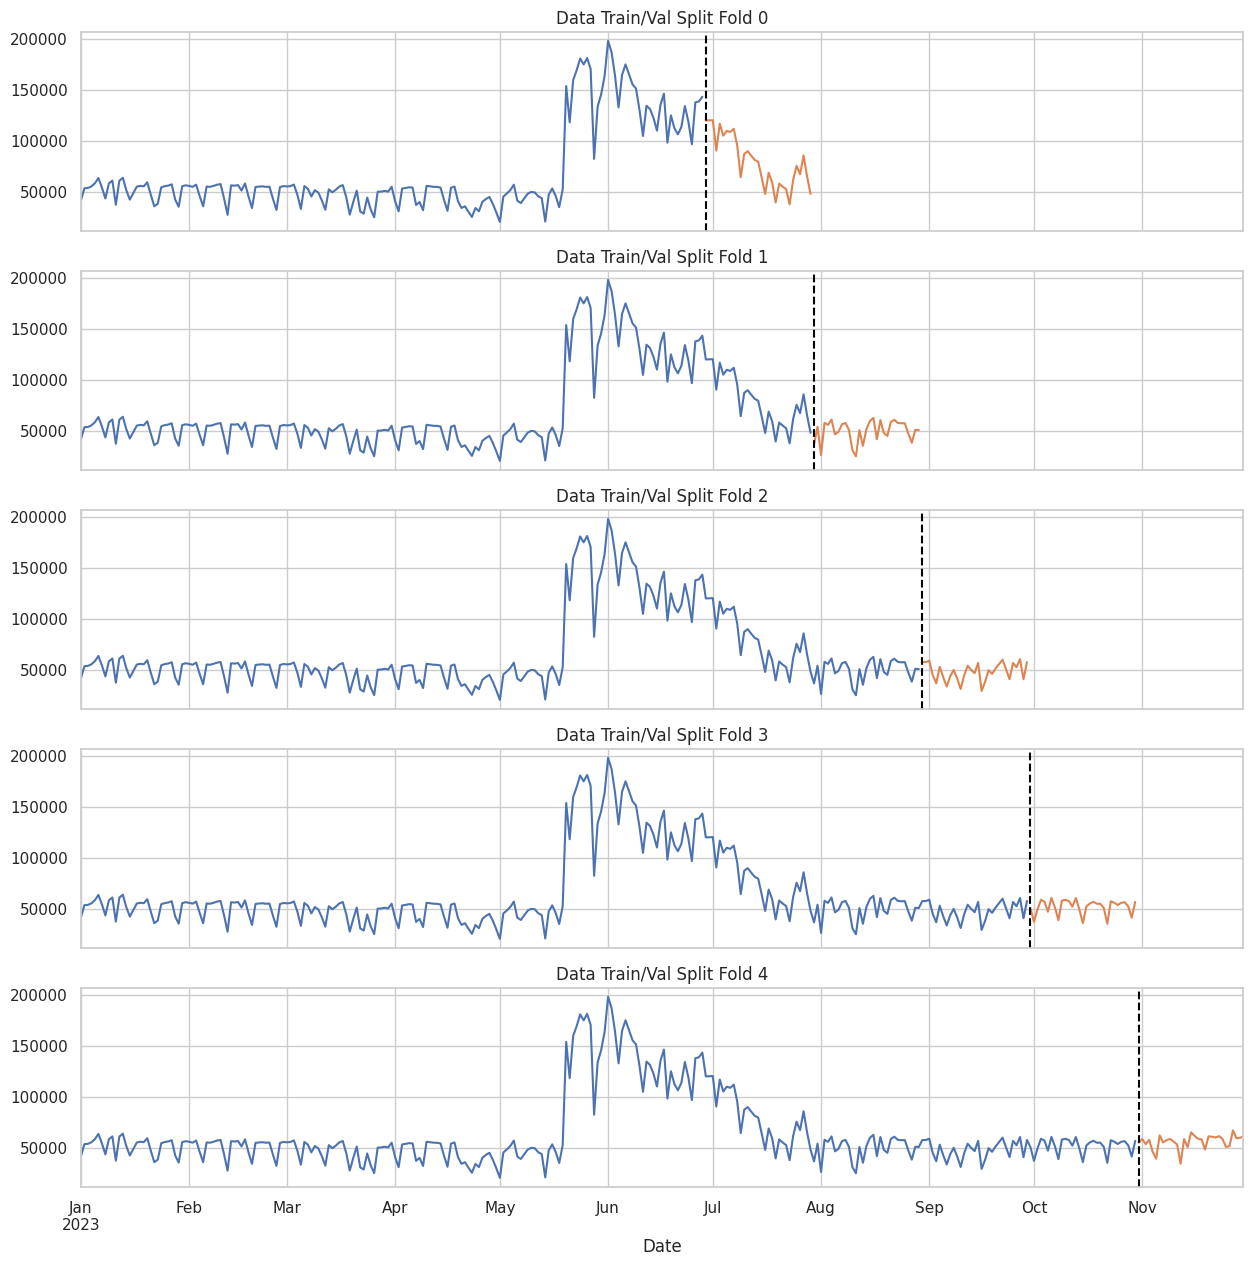

In [ ]:
tss = TimeSeriesSplit(n_splits=5, test_size=31)

fig, axs = plt.subplots(5, 1, figsize=(15, 15),
                             sharex=True)

fold = 0
for train_idx, val_idx in tss.split(data):
  train = data.iloc[train_idx].copy()
  val = data.iloc[val_idx].copy()

  train['y'].plot(ax=axs[fold],
                  label='Training Set',
                  title=f'Data Train/Val Split Fold {fold}')
  val['y'].plot(ax=axs[fold],
                label='Validation Set')

  axs[fold].axvline(val.index.min(), color='black', ls='--')
  fold += 1

## Training

In [ ]:
# Objective Function
def objective(trial):
  # Hyperparams
  batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
  input_len = trial.suggest_categorical("input_len", [7, 14, 21, 28])

  trend_blocks = trial.suggest_int("trend_blocks", 1, 3)
  trend_hiddens = trial.suggest_categorical("trend_hiddens", [64, 128, 256, 512])
  poly_degree = trial.suggest_int("poly_degree", 2, 3)

  season_blocks = trial.suggest_int("season_blocks", 1, 3)
  season_hiddens = trial.suggest_categorical("season_hiddens", [64, 128, 256, 512])
  num_fourier = trial.suggest_int("num_fourier", 3, 10)

  learning_rate = trial.suggest_float("lr", 1e-4, 1e-2, log=True)
  weight_decay = trial.suggest_float("wd", 1e-6, 1e-3, log=True)

  scheduler_patience = trial.suggest_int("scheduler_patience", 5, 15)
  scheduler_factor = trial.suggest_categorical('scheduler_factor', [0.1, 0.5])

  es_patience = trial.suggest_int("es_patience", 10, 30)

  # Constant
  OUT_LEN = 1
  SEASONALITY_PERIOD = 7

  # Training Loop
  tss = TimeSeriesSplit(n_splits=5, test_size=31)
  os.makedirs("models/nbeats_interpretable", exist_ok=True)

  fold = 0
  mape_folds = []
  for train_idx, val_idx in tss.split(data):
    train = data.iloc[train_idx].copy()
    val = data.iloc[val_idx].copy()

    scaler = MinMaxScaler()
    train_scaled = scaler.fit_transform(train)
    train_scaled = pd.DataFrame(train_scaled, columns=['y'])
    val_scaled = scaler.transform(val)
    val_scaled = pd.DataFrame(val_scaled, columns=['y'])

    train_set = TimeSeriesDataset(train_scaled.values, input_len, OUT_LEN)
    train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True, # Shuffle data training
        num_workers=os.cpu_count(),
        pin_memory=True
    )

    val_set = TimeSeriesDataset(val_scaled.values, input_len, OUT_LEN)
    val_loader = DataLoader(
        val_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=os.cpu_count(),
        pin_memory=True
    )

    # Model Init
    model = NBeatsInterpretableModel(
        input_len=input_len,
        output_len=OUT_LEN,
        trend_blocks=trend_blocks,
        trend_hiddens=trend_hiddens,
        poly_degree=poly_degree,
        season_blocks=season_blocks,
        season_hiddens=season_hiddens,
        num_fourier=num_fourier,
        seasonality_period=SEASONALITY_PERIOD
    ).to(device)

    criterion = nn.HuberLoss()
    optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, 'min', patience=scheduler_patience, factor=scheduler_factor
    )

    early_stopping = EarlyStopping(
        patience=es_patience, min_delta=1e-5, path=f"models/nbeats_interpretable/fold_{fold}_best.pth"
    )

    epoch = 0
    while True:
      epoch += 1
      print(f"\n--- Epoch {epoch} ---")
      train_cost = loop_fn("train", train_set, train_loader, model, criterion, optimizer, device)
      val_cost = loop_fn("val", val_set, val_loader, model, criterion, optimizer, device)

      scheduler.step(val_cost)
      early_stopping(val_cost, model)

      if early_stopping.early_stop:
        break

    # Evaluation
    model.load_state_dict(torch.load(f"models/nbeats_interpretable/fold_{fold}_best.pth"))
    pred, trend_pred, season_pred = forecast_with_rolling_origin(model,
                                                                  train_scaled,
                                                                  val_scaled,
                                                                  in_len=input_len,
                                                                  device=device)

    mape = mean_absolute_percentage_error(
        val['y'].values,
        scaler.inverse_transform(pred.reshape(-1, 1)).ravel()
    )

    # Print per fold
    print(f"[Trial {trial.number}] Fold {fold}: MAPE = {mape:.4f}")

    trial.report(mape, fold)

    if trial.should_prune():
      print(f"[Trial {trial.number}] Pruned at fold {fold} (MAPE = {mape:.4f})")
      raise TrialPruned()

    mape_folds.append(mape)
    fold += 1

  mean_mape = np.mean(mape_folds)
  print(f"[Trial {trial.number}] Mean MAPE = {mean_mape:.4f}")

  return mean_mape

In [ ]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

[I 2025-12-01 05:59:48,009] A new study created in memory with name: no-name-59e0fd4f-ecbc-4152-b309-7f727d4c16c1



--- Epoch 1 ---


Train:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.172634). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.013847). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 28

--- Epoch 4 ---


EarlyStopping counter: 2 out of 28

--- Epoch 5 ---


EarlyStopping counter: 3 out of 28

--- Epoch 6 ---


EarlyStopping counter: 4 out of 28

--- Epoch 7 ---


Validation loss decreased (0.006408). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 28

--- Epoch 9 ---


Validation loss decreased (0.006277). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 28

--- Epoch 11 ---


EarlyStopping counter: 2 out of 28

--- Epoch 12 ---


EarlyStopping counter: 3 out of 28

--- Epoch 13 ---


EarlyStopping counter: 4 out of 28

--- Epoch 14 ---


EarlyStopping counter: 5 out of 28

--- Epoch 15 ---


EarlyStopping counter: 6 out of 28

--- Epoch 16 ---


Validation loss decreased (0.004703). Saving model ...

--- Epoch 17 ---


Validation loss decreased (0.003760). Saving model ...

--- Epoch 18 ---


Validation loss decreased (0.003747). Saving model ...

--- Epoch 19 ---


EarlyStopping counter: 1 out of 28

--- Epoch 20 ---


EarlyStopping counter: 2 out of 28

--- Epoch 21 ---


EarlyStopping counter: 3 out of 28

--- Epoch 22 ---


EarlyStopping counter: 4 out of 28

--- Epoch 23 ---


Validation loss decreased (0.003522). Saving model ...

--- Epoch 24 ---


EarlyStopping counter: 1 out of 28

--- Epoch 25 ---


EarlyStopping counter: 2 out of 28

--- Epoch 26 ---


EarlyStopping counter: 3 out of 28

--- Epoch 27 ---


EarlyStopping counter: 4 out of 28

--- Epoch 28 ---


EarlyStopping counter: 5 out of 28

--- Epoch 29 ---


EarlyStopping counter: 6 out of 28

--- Epoch 30 ---


EarlyStopping counter: 7 out of 28

--- Epoch 31 ---


EarlyStopping counter: 8 out of 28

--- Epoch 32 ---


EarlyStopping counter: 9 out of 28

--- Epoch 33 ---


EarlyStopping counter: 10 out of 28

--- Epoch 34 ---


EarlyStopping counter: 11 out of 28

--- Epoch 35 ---


EarlyStopping counter: 12 out of 28

--- Epoch 36 ---


EarlyStopping counter: 13 out of 28

--- Epoch 37 ---


EarlyStopping counter: 14 out of 28

--- Epoch 38 ---


EarlyStopping counter: 15 out of 28

--- Epoch 39 ---


EarlyStopping counter: 16 out of 28

--- Epoch 40 ---


EarlyStopping counter: 17 out of 28

--- Epoch 41 ---


EarlyStopping counter: 18 out of 28

--- Epoch 42 ---


EarlyStopping counter: 19 out of 28

--- Epoch 43 ---


EarlyStopping counter: 20 out of 28

--- Epoch 44 ---


EarlyStopping counter: 21 out of 28

--- Epoch 45 ---


EarlyStopping counter: 22 out of 28

--- Epoch 46 ---


EarlyStopping counter: 23 out of 28

--- Epoch 47 ---


EarlyStopping counter: 24 out of 28

--- Epoch 48 ---


EarlyStopping counter: 25 out of 28

--- Epoch 49 ---


EarlyStopping counter: 26 out of 28

--- Epoch 50 ---


EarlyStopping counter: 27 out of 28

--- Epoch 51 ---


EarlyStopping counter: 28 out of 28


100%|██████████| 31/31 [00:00<00:00, 862.23it/s]


[Trial 0] Fold 0: MAPE = 0.1929

--- Epoch 1 ---


Train:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.018940). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.008493). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 28

--- Epoch 4 ---


Validation loss decreased (0.007054). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.005185). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.003969). Saving model ...

--- Epoch 7 ---


Validation loss decreased (0.003309). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 28

--- Epoch 9 ---


EarlyStopping counter: 2 out of 28

--- Epoch 10 ---


Validation loss decreased (0.002245). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 28

--- Epoch 12 ---


Validation loss decreased (0.002091). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 28

--- Epoch 14 ---


Validation loss decreased (0.001885). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 28

--- Epoch 16 ---


Validation loss decreased (0.001774). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 28

--- Epoch 18 ---


Validation loss decreased (0.001724). Saving model ...

--- Epoch 19 ---


EarlyStopping counter: 1 out of 28

--- Epoch 20 ---


EarlyStopping counter: 2 out of 28

--- Epoch 21 ---


EarlyStopping counter: 3 out of 28

--- Epoch 22 ---


EarlyStopping counter: 4 out of 28

--- Epoch 23 ---


EarlyStopping counter: 5 out of 28

--- Epoch 24 ---


EarlyStopping counter: 6 out of 28

--- Epoch 25 ---


EarlyStopping counter: 7 out of 28

--- Epoch 26 ---


EarlyStopping counter: 8 out of 28

--- Epoch 27 ---


EarlyStopping counter: 9 out of 28

--- Epoch 28 ---


EarlyStopping counter: 10 out of 28

--- Epoch 29 ---


EarlyStopping counter: 11 out of 28

--- Epoch 30 ---


EarlyStopping counter: 12 out of 28

--- Epoch 31 ---


EarlyStopping counter: 13 out of 28

--- Epoch 32 ---


EarlyStopping counter: 14 out of 28

--- Epoch 33 ---


EarlyStopping counter: 15 out of 28

--- Epoch 34 ---


EarlyStopping counter: 16 out of 28

--- Epoch 35 ---


EarlyStopping counter: 17 out of 28

--- Epoch 36 ---


EarlyStopping counter: 18 out of 28

--- Epoch 37 ---


EarlyStopping counter: 19 out of 28

--- Epoch 38 ---


EarlyStopping counter: 20 out of 28

--- Epoch 39 ---


EarlyStopping counter: 21 out of 28

--- Epoch 40 ---


EarlyStopping counter: 22 out of 28

--- Epoch 41 ---


EarlyStopping counter: 23 out of 28

--- Epoch 42 ---


EarlyStopping counter: 24 out of 28

--- Epoch 43 ---


EarlyStopping counter: 25 out of 28

--- Epoch 44 ---


EarlyStopping counter: 26 out of 28

--- Epoch 45 ---


EarlyStopping counter: 27 out of 28

--- Epoch 46 ---


EarlyStopping counter: 28 out of 28


100%|██████████| 31/31 [00:00<00:00, 920.58it/s]


[Trial 0] Fold 1: MAPE = 0.2235

--- Epoch 1 ---


Train:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.007434). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 28

--- Epoch 3 ---


Validation loss decreased (0.003732). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 28

--- Epoch 5 ---


Validation loss decreased (0.002629). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 28

--- Epoch 7 ---


EarlyStopping counter: 2 out of 28

--- Epoch 8 ---


EarlyStopping counter: 3 out of 28

--- Epoch 9 ---


EarlyStopping counter: 4 out of 28

--- Epoch 10 ---


Validation loss decreased (0.001891). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 28

--- Epoch 12 ---


Validation loss decreased (0.001699). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 28

--- Epoch 14 ---


Validation loss decreased (0.001686). Saving model ...

--- Epoch 15 ---


Validation loss decreased (0.001595). Saving model ...

--- Epoch 16 ---


EarlyStopping counter: 1 out of 28

--- Epoch 17 ---


Validation loss decreased (0.001497). Saving model ...

--- Epoch 18 ---


EarlyStopping counter: 1 out of 28

--- Epoch 19 ---


EarlyStopping counter: 2 out of 28

--- Epoch 20 ---


EarlyStopping counter: 3 out of 28

--- Epoch 21 ---


EarlyStopping counter: 4 out of 28

--- Epoch 22 ---


Validation loss decreased (0.001373). Saving model ...

--- Epoch 23 ---


EarlyStopping counter: 1 out of 28

--- Epoch 24 ---


EarlyStopping counter: 2 out of 28

--- Epoch 25 ---


EarlyStopping counter: 3 out of 28

--- Epoch 26 ---


EarlyStopping counter: 4 out of 28

--- Epoch 27 ---


EarlyStopping counter: 5 out of 28

--- Epoch 28 ---


EarlyStopping counter: 6 out of 28

--- Epoch 29 ---


EarlyStopping counter: 7 out of 28

--- Epoch 30 ---


Validation loss decreased (0.001334). Saving model ...

--- Epoch 31 ---


Validation loss decreased (0.001319). Saving model ...

--- Epoch 32 ---


EarlyStopping counter: 1 out of 28

--- Epoch 33 ---


EarlyStopping counter: 2 out of 28

--- Epoch 34 ---


EarlyStopping counter: 3 out of 28

--- Epoch 35 ---


EarlyStopping counter: 4 out of 28

--- Epoch 36 ---


EarlyStopping counter: 5 out of 28

--- Epoch 37 ---


EarlyStopping counter: 6 out of 28

--- Epoch 38 ---


EarlyStopping counter: 7 out of 28

--- Epoch 39 ---


EarlyStopping counter: 8 out of 28

--- Epoch 40 ---


EarlyStopping counter: 9 out of 28

--- Epoch 41 ---


EarlyStopping counter: 10 out of 28

--- Epoch 42 ---


EarlyStopping counter: 11 out of 28

--- Epoch 43 ---


EarlyStopping counter: 12 out of 28

--- Epoch 44 ---


EarlyStopping counter: 13 out of 28

--- Epoch 45 ---


EarlyStopping counter: 14 out of 28

--- Epoch 46 ---


EarlyStopping counter: 15 out of 28

--- Epoch 47 ---


EarlyStopping counter: 16 out of 28

--- Epoch 48 ---


EarlyStopping counter: 17 out of 28

--- Epoch 49 ---


EarlyStopping counter: 18 out of 28

--- Epoch 50 ---


EarlyStopping counter: 19 out of 28

--- Epoch 51 ---


EarlyStopping counter: 20 out of 28

--- Epoch 52 ---


EarlyStopping counter: 21 out of 28

--- Epoch 53 ---


EarlyStopping counter: 22 out of 28

--- Epoch 54 ---


EarlyStopping counter: 23 out of 28

--- Epoch 55 ---


EarlyStopping counter: 24 out of 28

--- Epoch 56 ---


EarlyStopping counter: 25 out of 28

--- Epoch 57 ---


EarlyStopping counter: 26 out of 28

--- Epoch 58 ---


EarlyStopping counter: 27 out of 28

--- Epoch 59 ---


EarlyStopping counter: 28 out of 28


100%|██████████| 31/31 [00:00<00:00, 881.72it/s]


[Trial 0] Fold 2: MAPE = 0.1474

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.008470). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 28

--- Epoch 3 ---


Validation loss decreased (0.002273). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.001684). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 28

--- Epoch 6 ---


EarlyStopping counter: 2 out of 28

--- Epoch 7 ---


EarlyStopping counter: 3 out of 28

--- Epoch 8 ---


EarlyStopping counter: 4 out of 28

--- Epoch 9 ---


Validation loss decreased (0.001326). Saving model ...

--- Epoch 10 ---


Validation loss decreased (0.001262). Saving model ...

--- Epoch 11 ---


Validation loss decreased (0.001223). Saving model ...

--- Epoch 12 ---


Validation loss decreased (0.000862). Saving model ...

--- Epoch 13 ---


Validation loss decreased (0.000606). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 28

--- Epoch 15 ---


Validation loss decreased (0.000593). Saving model ...

--- Epoch 16 ---


Validation loss decreased (0.000582). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 28

--- Epoch 18 ---


Validation loss decreased (0.000446). Saving model ...

--- Epoch 19 ---


Validation loss decreased (0.000421). Saving model ...

--- Epoch 20 ---


Validation loss decreased (0.000386). Saving model ...

--- Epoch 21 ---


EarlyStopping counter: 1 out of 28

--- Epoch 22 ---


EarlyStopping counter: 2 out of 28

--- Epoch 23 ---


EarlyStopping counter: 3 out of 28

--- Epoch 24 ---


EarlyStopping counter: 4 out of 28

--- Epoch 25 ---


EarlyStopping counter: 5 out of 28

--- Epoch 26 ---


EarlyStopping counter: 6 out of 28

--- Epoch 27 ---


Validation loss decreased (0.000354). Saving model ...

--- Epoch 28 ---


Validation loss decreased (0.000324). Saving model ...

--- Epoch 29 ---


EarlyStopping counter: 1 out of 28

--- Epoch 30 ---


EarlyStopping counter: 2 out of 28

--- Epoch 31 ---


EarlyStopping counter: 3 out of 28

--- Epoch 32 ---


EarlyStopping counter: 4 out of 28

--- Epoch 33 ---


EarlyStopping counter: 5 out of 28

--- Epoch 34 ---


EarlyStopping counter: 6 out of 28

--- Epoch 35 ---


EarlyStopping counter: 7 out of 28

--- Epoch 36 ---


EarlyStopping counter: 8 out of 28

--- Epoch 37 ---


EarlyStopping counter: 9 out of 28

--- Epoch 38 ---


EarlyStopping counter: 10 out of 28

--- Epoch 39 ---


EarlyStopping counter: 11 out of 28

--- Epoch 40 ---


EarlyStopping counter: 12 out of 28

--- Epoch 41 ---


EarlyStopping counter: 13 out of 28

--- Epoch 42 ---


EarlyStopping counter: 14 out of 28

--- Epoch 43 ---


EarlyStopping counter: 15 out of 28

--- Epoch 44 ---


EarlyStopping counter: 16 out of 28

--- Epoch 45 ---


EarlyStopping counter: 17 out of 28

--- Epoch 46 ---


EarlyStopping counter: 18 out of 28

--- Epoch 47 ---


EarlyStopping counter: 19 out of 28

--- Epoch 48 ---


EarlyStopping counter: 20 out of 28

--- Epoch 49 ---


EarlyStopping counter: 21 out of 28

--- Epoch 50 ---


EarlyStopping counter: 22 out of 28

--- Epoch 51 ---


EarlyStopping counter: 23 out of 28

--- Epoch 52 ---


EarlyStopping counter: 24 out of 28

--- Epoch 53 ---


EarlyStopping counter: 25 out of 28

--- Epoch 54 ---


EarlyStopping counter: 26 out of 28

--- Epoch 55 ---


EarlyStopping counter: 27 out of 28

--- Epoch 56 ---


EarlyStopping counter: 28 out of 28


100%|██████████| 31/31 [00:00<00:00, 740.68it/s]


[Trial 0] Fold 3: MAPE = 0.0781

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.034119). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.006089). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 28

--- Epoch 4 ---


EarlyStopping counter: 2 out of 28

--- Epoch 5 ---


EarlyStopping counter: 3 out of 28

--- Epoch 6 ---


EarlyStopping counter: 4 out of 28

--- Epoch 7 ---


Validation loss decreased (0.004010). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 28

--- Epoch 9 ---


Validation loss decreased (0.001833). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 28

--- Epoch 11 ---


Validation loss decreased (0.001331). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 28

--- Epoch 13 ---


EarlyStopping counter: 2 out of 28

--- Epoch 14 ---


Validation loss decreased (0.000957). Saving model ...

--- Epoch 15 ---


Validation loss decreased (0.000845). Saving model ...

--- Epoch 16 ---


EarlyStopping counter: 1 out of 28

--- Epoch 17 ---


EarlyStopping counter: 2 out of 28

--- Epoch 18 ---


Validation loss decreased (0.000676). Saving model ...

--- Epoch 19 ---


Validation loss decreased (0.000662). Saving model ...

--- Epoch 20 ---


EarlyStopping counter: 1 out of 28

--- Epoch 21 ---


EarlyStopping counter: 2 out of 28

--- Epoch 22 ---


EarlyStopping counter: 3 out of 28

--- Epoch 23 ---


EarlyStopping counter: 4 out of 28

--- Epoch 24 ---


EarlyStopping counter: 5 out of 28

--- Epoch 25 ---


EarlyStopping counter: 6 out of 28

--- Epoch 26 ---


Validation loss decreased (0.000639). Saving model ...

--- Epoch 27 ---


EarlyStopping counter: 1 out of 28

--- Epoch 28 ---


EarlyStopping counter: 2 out of 28

--- Epoch 29 ---


EarlyStopping counter: 3 out of 28

--- Epoch 30 ---


EarlyStopping counter: 4 out of 28

--- Epoch 31 ---


EarlyStopping counter: 5 out of 28

--- Epoch 32 ---


EarlyStopping counter: 6 out of 28

--- Epoch 33 ---


EarlyStopping counter: 7 out of 28

--- Epoch 34 ---


EarlyStopping counter: 8 out of 28

--- Epoch 35 ---


EarlyStopping counter: 9 out of 28

--- Epoch 36 ---


EarlyStopping counter: 10 out of 28

--- Epoch 37 ---


EarlyStopping counter: 11 out of 28

--- Epoch 38 ---


EarlyStopping counter: 12 out of 28

--- Epoch 39 ---


EarlyStopping counter: 13 out of 28

--- Epoch 40 ---


EarlyStopping counter: 14 out of 28

--- Epoch 41 ---


EarlyStopping counter: 15 out of 28

--- Epoch 42 ---


EarlyStopping counter: 16 out of 28

--- Epoch 43 ---


EarlyStopping counter: 17 out of 28

--- Epoch 44 ---


EarlyStopping counter: 18 out of 28

--- Epoch 45 ---


EarlyStopping counter: 19 out of 28

--- Epoch 46 ---


EarlyStopping counter: 20 out of 28

--- Epoch 47 ---


EarlyStopping counter: 21 out of 28

--- Epoch 48 ---


EarlyStopping counter: 22 out of 28

--- Epoch 49 ---


EarlyStopping counter: 23 out of 28

--- Epoch 50 ---


EarlyStopping counter: 24 out of 28

--- Epoch 51 ---


EarlyStopping counter: 25 out of 28

--- Epoch 52 ---


EarlyStopping counter: 26 out of 28

--- Epoch 53 ---


EarlyStopping counter: 27 out of 28

--- Epoch 54 ---


EarlyStopping counter: 28 out of 28


100%|██████████| 31/31 [00:00<00:00, 807.60it/s]
[I 2025-12-01 06:01:06,694] Trial 0 finished with value: 0.14702789038419722 and parameters: {'batch_size': 128, 'input_len': 7, 'trend_blocks': 1, 'trend_hiddens': 512, 'poly_degree': 2, 'season_blocks': 1, 'season_hiddens': 64, 'num_fourier': 6, 'lr': 0.0001296567296900423, 'wd': 3.90387393044678e-05, 'scheduler_patience': 11, 'scheduler_factor': 0.1, 'es_patience': 28}. Best is trial 0 with value: 0.14702789038419722.


[Trial 0] Fold 4: MAPE = 0.0933
[Trial 0] Mean MAPE = 0.1470

--- Epoch 1 ---


Train:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.281509). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 29

--- Epoch 3 ---


EarlyStopping counter: 2 out of 29

--- Epoch 4 ---


EarlyStopping counter: 3 out of 29

--- Epoch 5 ---


Validation loss decreased (0.170701). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.124835). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 29

--- Epoch 8 ---


EarlyStopping counter: 2 out of 29

--- Epoch 9 ---


Validation loss decreased (0.104262). Saving model ...

--- Epoch 10 ---


Validation loss decreased (0.039545). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 29

--- Epoch 12 ---


EarlyStopping counter: 2 out of 29

--- Epoch 13 ---


EarlyStopping counter: 3 out of 29

--- Epoch 14 ---


EarlyStopping counter: 4 out of 29

--- Epoch 15 ---


EarlyStopping counter: 5 out of 29

--- Epoch 16 ---


EarlyStopping counter: 6 out of 29

--- Epoch 17 ---


EarlyStopping counter: 7 out of 29

--- Epoch 18 ---


EarlyStopping counter: 8 out of 29

--- Epoch 19 ---


Validation loss decreased (0.036594). Saving model ...

--- Epoch 20 ---


Validation loss decreased (0.032949). Saving model ...

--- Epoch 21 ---


Validation loss decreased (0.025450). Saving model ...

--- Epoch 22 ---


EarlyStopping counter: 1 out of 29

--- Epoch 23 ---


Validation loss decreased (0.025171). Saving model ...

--- Epoch 24 ---


EarlyStopping counter: 1 out of 29

--- Epoch 25 ---


EarlyStopping counter: 2 out of 29

--- Epoch 26 ---


EarlyStopping counter: 3 out of 29

--- Epoch 27 ---


EarlyStopping counter: 4 out of 29

--- Epoch 28 ---


EarlyStopping counter: 5 out of 29

--- Epoch 29 ---


EarlyStopping counter: 6 out of 29

--- Epoch 30 ---


EarlyStopping counter: 7 out of 29

--- Epoch 31 ---


EarlyStopping counter: 8 out of 29

--- Epoch 32 ---


EarlyStopping counter: 9 out of 29

--- Epoch 33 ---


EarlyStopping counter: 10 out of 29

--- Epoch 34 ---


EarlyStopping counter: 11 out of 29

--- Epoch 35 ---


EarlyStopping counter: 12 out of 29

--- Epoch 36 ---


EarlyStopping counter: 13 out of 29

--- Epoch 37 ---


EarlyStopping counter: 14 out of 29

--- Epoch 38 ---


EarlyStopping counter: 15 out of 29

--- Epoch 39 ---


Validation loss decreased (0.019315). Saving model ...

--- Epoch 40 ---


EarlyStopping counter: 1 out of 29

--- Epoch 41 ---


EarlyStopping counter: 2 out of 29

--- Epoch 42 ---


EarlyStopping counter: 3 out of 29

--- Epoch 43 ---


EarlyStopping counter: 4 out of 29

--- Epoch 44 ---


EarlyStopping counter: 5 out of 29

--- Epoch 45 ---


EarlyStopping counter: 6 out of 29

--- Epoch 46 ---


EarlyStopping counter: 7 out of 29

--- Epoch 47 ---


EarlyStopping counter: 8 out of 29

--- Epoch 48 ---


EarlyStopping counter: 9 out of 29

--- Epoch 49 ---


EarlyStopping counter: 10 out of 29

--- Epoch 50 ---


EarlyStopping counter: 11 out of 29

--- Epoch 51 ---


EarlyStopping counter: 12 out of 29

--- Epoch 52 ---


EarlyStopping counter: 13 out of 29

--- Epoch 53 ---


EarlyStopping counter: 14 out of 29

--- Epoch 54 ---


EarlyStopping counter: 15 out of 29

--- Epoch 55 ---


EarlyStopping counter: 16 out of 29

--- Epoch 56 ---


EarlyStopping counter: 17 out of 29

--- Epoch 57 ---


EarlyStopping counter: 18 out of 29

--- Epoch 58 ---


EarlyStopping counter: 19 out of 29

--- Epoch 59 ---


EarlyStopping counter: 20 out of 29

--- Epoch 60 ---


EarlyStopping counter: 21 out of 29

--- Epoch 61 ---


EarlyStopping counter: 22 out of 29

--- Epoch 62 ---


EarlyStopping counter: 23 out of 29

--- Epoch 63 ---


EarlyStopping counter: 24 out of 29

--- Epoch 64 ---


EarlyStopping counter: 25 out of 29

--- Epoch 65 ---


EarlyStopping counter: 26 out of 29

--- Epoch 66 ---


EarlyStopping counter: 27 out of 29

--- Epoch 67 ---


EarlyStopping counter: 28 out of 29

--- Epoch 68 ---


EarlyStopping counter: 29 out of 29


100%|██████████| 31/31 [00:00<00:00, 528.25it/s]


[Trial 1] Fold 0: MAPE = 0.4542

--- Epoch 1 ---


Train:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.621477). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.205545). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 29

--- Epoch 4 ---


EarlyStopping counter: 2 out of 29

--- Epoch 5 ---


Validation loss decreased (0.040485). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.033112). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 29

--- Epoch 8 ---


EarlyStopping counter: 2 out of 29

--- Epoch 9 ---


EarlyStopping counter: 3 out of 29

--- Epoch 10 ---


EarlyStopping counter: 4 out of 29

--- Epoch 11 ---


EarlyStopping counter: 5 out of 29

--- Epoch 12 ---


Validation loss decreased (0.022313). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 29

--- Epoch 14 ---


EarlyStopping counter: 2 out of 29

--- Epoch 15 ---


EarlyStopping counter: 3 out of 29

--- Epoch 16 ---


EarlyStopping counter: 4 out of 29

--- Epoch 17 ---


EarlyStopping counter: 5 out of 29

--- Epoch 18 ---


EarlyStopping counter: 6 out of 29

--- Epoch 19 ---


EarlyStopping counter: 7 out of 29

--- Epoch 20 ---


EarlyStopping counter: 8 out of 29

--- Epoch 21 ---


EarlyStopping counter: 9 out of 29

--- Epoch 22 ---


Validation loss decreased (0.021827). Saving model ...

--- Epoch 23 ---


EarlyStopping counter: 1 out of 29

--- Epoch 24 ---


EarlyStopping counter: 2 out of 29

--- Epoch 25 ---


EarlyStopping counter: 3 out of 29

--- Epoch 26 ---


EarlyStopping counter: 4 out of 29

--- Epoch 27 ---


EarlyStopping counter: 5 out of 29

--- Epoch 28 ---


EarlyStopping counter: 6 out of 29

--- Epoch 29 ---


EarlyStopping counter: 7 out of 29

--- Epoch 30 ---


EarlyStopping counter: 8 out of 29

--- Epoch 31 ---


EarlyStopping counter: 9 out of 29

--- Epoch 32 ---


EarlyStopping counter: 10 out of 29

--- Epoch 33 ---


EarlyStopping counter: 11 out of 29

--- Epoch 34 ---


EarlyStopping counter: 12 out of 29

--- Epoch 35 ---


EarlyStopping counter: 13 out of 29

--- Epoch 36 ---


EarlyStopping counter: 14 out of 29

--- Epoch 37 ---


EarlyStopping counter: 15 out of 29

--- Epoch 38 ---


EarlyStopping counter: 16 out of 29

--- Epoch 39 ---


EarlyStopping counter: 17 out of 29

--- Epoch 40 ---


EarlyStopping counter: 18 out of 29

--- Epoch 41 ---


EarlyStopping counter: 19 out of 29

--- Epoch 42 ---


EarlyStopping counter: 20 out of 29

--- Epoch 43 ---


Validation loss decreased (0.018306). Saving model ...

--- Epoch 44 ---


EarlyStopping counter: 1 out of 29

--- Epoch 45 ---


EarlyStopping counter: 2 out of 29

--- Epoch 46 ---


EarlyStopping counter: 3 out of 29

--- Epoch 47 ---


Validation loss decreased (0.014850). Saving model ...

--- Epoch 48 ---


EarlyStopping counter: 1 out of 29

--- Epoch 49 ---


EarlyStopping counter: 2 out of 29

--- Epoch 50 ---


EarlyStopping counter: 3 out of 29

--- Epoch 51 ---


EarlyStopping counter: 4 out of 29

--- Epoch 52 ---


Validation loss decreased (0.014198). Saving model ...

--- Epoch 53 ---


Validation loss decreased (0.012802). Saving model ...

--- Epoch 54 ---


EarlyStopping counter: 1 out of 29

--- Epoch 55 ---


EarlyStopping counter: 2 out of 29

--- Epoch 56 ---


Validation loss decreased (0.011566). Saving model ...

--- Epoch 57 ---


EarlyStopping counter: 1 out of 29

--- Epoch 58 ---


EarlyStopping counter: 2 out of 29

--- Epoch 59 ---


EarlyStopping counter: 3 out of 29

--- Epoch 60 ---


EarlyStopping counter: 4 out of 29

--- Epoch 61 ---


EarlyStopping counter: 5 out of 29

--- Epoch 62 ---


EarlyStopping counter: 6 out of 29

--- Epoch 63 ---


EarlyStopping counter: 7 out of 29

--- Epoch 64 ---


EarlyStopping counter: 8 out of 29

--- Epoch 65 ---


EarlyStopping counter: 9 out of 29

--- Epoch 66 ---


EarlyStopping counter: 10 out of 29

--- Epoch 67 ---


EarlyStopping counter: 11 out of 29

--- Epoch 68 ---


EarlyStopping counter: 12 out of 29

--- Epoch 69 ---


EarlyStopping counter: 13 out of 29

--- Epoch 70 ---


EarlyStopping counter: 14 out of 29

--- Epoch 71 ---


EarlyStopping counter: 15 out of 29

--- Epoch 72 ---


EarlyStopping counter: 16 out of 29

--- Epoch 73 ---


EarlyStopping counter: 17 out of 29

--- Epoch 74 ---


EarlyStopping counter: 18 out of 29

--- Epoch 75 ---


EarlyStopping counter: 19 out of 29

--- Epoch 76 ---


EarlyStopping counter: 20 out of 29

--- Epoch 77 ---


EarlyStopping counter: 21 out of 29

--- Epoch 78 ---


EarlyStopping counter: 22 out of 29

--- Epoch 79 ---


EarlyStopping counter: 23 out of 29

--- Epoch 80 ---


EarlyStopping counter: 24 out of 29

--- Epoch 81 ---


EarlyStopping counter: 25 out of 29

--- Epoch 82 ---


EarlyStopping counter: 26 out of 29

--- Epoch 83 ---


EarlyStopping counter: 27 out of 29

--- Epoch 84 ---


EarlyStopping counter: 28 out of 29

--- Epoch 85 ---


EarlyStopping counter: 29 out of 29


100%|██████████| 31/31 [00:00<00:00, 498.49it/s]


[Trial 1] Fold 1: MAPE = 0.7204

--- Epoch 1 ---


Train:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.346164). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.050564). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 29

--- Epoch 4 ---


Validation loss decreased (0.048365). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 29

--- Epoch 6 ---


Validation loss decreased (0.017162). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 29

--- Epoch 8 ---


EarlyStopping counter: 2 out of 29

--- Epoch 9 ---


EarlyStopping counter: 3 out of 29

--- Epoch 10 ---


EarlyStopping counter: 4 out of 29

--- Epoch 11 ---


EarlyStopping counter: 5 out of 29

--- Epoch 12 ---


EarlyStopping counter: 6 out of 29

--- Epoch 13 ---


EarlyStopping counter: 7 out of 29

--- Epoch 14 ---


EarlyStopping counter: 8 out of 29

--- Epoch 15 ---


EarlyStopping counter: 9 out of 29

--- Epoch 16 ---


EarlyStopping counter: 10 out of 29

--- Epoch 17 ---


EarlyStopping counter: 11 out of 29

--- Epoch 18 ---


EarlyStopping counter: 12 out of 29

--- Epoch 19 ---


EarlyStopping counter: 13 out of 29

--- Epoch 20 ---


EarlyStopping counter: 14 out of 29

--- Epoch 21 ---


EarlyStopping counter: 15 out of 29

--- Epoch 22 ---


EarlyStopping counter: 16 out of 29

--- Epoch 23 ---


EarlyStopping counter: 17 out of 29

--- Epoch 24 ---


EarlyStopping counter: 18 out of 29

--- Epoch 25 ---


EarlyStopping counter: 19 out of 29

--- Epoch 26 ---


EarlyStopping counter: 20 out of 29

--- Epoch 27 ---


Validation loss decreased (0.014394). Saving model ...

--- Epoch 28 ---


EarlyStopping counter: 1 out of 29

--- Epoch 29 ---


EarlyStopping counter: 2 out of 29

--- Epoch 30 ---


EarlyStopping counter: 3 out of 29

--- Epoch 31 ---


Validation loss decreased (0.011440). Saving model ...

--- Epoch 32 ---


EarlyStopping counter: 1 out of 29

--- Epoch 33 ---


Validation loss decreased (0.008592). Saving model ...

--- Epoch 34 ---


EarlyStopping counter: 1 out of 29

--- Epoch 35 ---


EarlyStopping counter: 2 out of 29

--- Epoch 36 ---


EarlyStopping counter: 3 out of 29

--- Epoch 37 ---


EarlyStopping counter: 4 out of 29

--- Epoch 38 ---


EarlyStopping counter: 5 out of 29

--- Epoch 39 ---


EarlyStopping counter: 6 out of 29

--- Epoch 40 ---


EarlyStopping counter: 7 out of 29

--- Epoch 41 ---


EarlyStopping counter: 8 out of 29

--- Epoch 42 ---


EarlyStopping counter: 9 out of 29

--- Epoch 43 ---


EarlyStopping counter: 10 out of 29

--- Epoch 44 ---


EarlyStopping counter: 11 out of 29

--- Epoch 45 ---


EarlyStopping counter: 12 out of 29

--- Epoch 46 ---


EarlyStopping counter: 13 out of 29

--- Epoch 47 ---


EarlyStopping counter: 14 out of 29

--- Epoch 48 ---


EarlyStopping counter: 15 out of 29

--- Epoch 49 ---


EarlyStopping counter: 16 out of 29

--- Epoch 50 ---


EarlyStopping counter: 17 out of 29

--- Epoch 51 ---


EarlyStopping counter: 18 out of 29

--- Epoch 52 ---


EarlyStopping counter: 19 out of 29

--- Epoch 53 ---


EarlyStopping counter: 20 out of 29

--- Epoch 54 ---


EarlyStopping counter: 21 out of 29

--- Epoch 55 ---


Validation loss decreased (0.008581). Saving model ...

--- Epoch 56 ---


EarlyStopping counter: 1 out of 29

--- Epoch 57 ---


Validation loss decreased (0.006991). Saving model ...

--- Epoch 58 ---


EarlyStopping counter: 1 out of 29

--- Epoch 59 ---


EarlyStopping counter: 2 out of 29

--- Epoch 60 ---


EarlyStopping counter: 3 out of 29

--- Epoch 61 ---


Validation loss decreased (0.006895). Saving model ...

--- Epoch 62 ---


Validation loss decreased (0.005778). Saving model ...

--- Epoch 63 ---


Validation loss decreased (0.005274). Saving model ...

--- Epoch 64 ---


EarlyStopping counter: 1 out of 29

--- Epoch 65 ---


Validation loss decreased (0.005169). Saving model ...

--- Epoch 66 ---


EarlyStopping counter: 1 out of 29

--- Epoch 67 ---


Validation loss decreased (0.004981). Saving model ...

--- Epoch 68 ---


EarlyStopping counter: 1 out of 29

--- Epoch 69 ---


EarlyStopping counter: 2 out of 29

--- Epoch 70 ---


EarlyStopping counter: 3 out of 29

--- Epoch 71 ---


Validation loss decreased (0.004772). Saving model ...

--- Epoch 72 ---


EarlyStopping counter: 1 out of 29

--- Epoch 73 ---


Validation loss decreased (0.004723). Saving model ...

--- Epoch 74 ---


EarlyStopping counter: 1 out of 29

--- Epoch 75 ---


Validation loss decreased (0.004316). Saving model ...

--- Epoch 76 ---


EarlyStopping counter: 1 out of 29

--- Epoch 77 ---


EarlyStopping counter: 2 out of 29

--- Epoch 78 ---


EarlyStopping counter: 3 out of 29

--- Epoch 79 ---


Validation loss decreased (0.004176). Saving model ...

--- Epoch 80 ---


EarlyStopping counter: 1 out of 29

--- Epoch 81 ---


EarlyStopping counter: 2 out of 29

--- Epoch 82 ---


EarlyStopping counter: 3 out of 29

--- Epoch 83 ---


EarlyStopping counter: 4 out of 29

--- Epoch 84 ---


EarlyStopping counter: 5 out of 29

--- Epoch 85 ---


EarlyStopping counter: 6 out of 29

--- Epoch 86 ---


EarlyStopping counter: 7 out of 29

--- Epoch 87 ---


EarlyStopping counter: 8 out of 29

--- Epoch 88 ---


EarlyStopping counter: 9 out of 29

--- Epoch 89 ---


EarlyStopping counter: 10 out of 29

--- Epoch 90 ---


EarlyStopping counter: 11 out of 29

--- Epoch 91 ---


EarlyStopping counter: 12 out of 29

--- Epoch 92 ---


EarlyStopping counter: 13 out of 29

--- Epoch 93 ---


EarlyStopping counter: 14 out of 29

--- Epoch 94 ---


EarlyStopping counter: 15 out of 29

--- Epoch 95 ---


EarlyStopping counter: 16 out of 29

--- Epoch 96 ---


EarlyStopping counter: 17 out of 29

--- Epoch 97 ---


EarlyStopping counter: 18 out of 29

--- Epoch 98 ---


EarlyStopping counter: 19 out of 29

--- Epoch 99 ---


EarlyStopping counter: 20 out of 29

--- Epoch 100 ---


EarlyStopping counter: 21 out of 29

--- Epoch 101 ---


EarlyStopping counter: 22 out of 29

--- Epoch 102 ---


EarlyStopping counter: 23 out of 29

--- Epoch 103 ---


EarlyStopping counter: 24 out of 29

--- Epoch 104 ---


EarlyStopping counter: 25 out of 29

--- Epoch 105 ---


EarlyStopping counter: 26 out of 29

--- Epoch 106 ---


EarlyStopping counter: 27 out of 29

--- Epoch 107 ---


EarlyStopping counter: 28 out of 29

--- Epoch 108 ---


EarlyStopping counter: 29 out of 29


100%|██████████| 31/31 [00:00<00:00, 472.77it/s]


[Trial 1] Fold 2: MAPE = 0.3366

--- Epoch 1 ---


Train:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.072406). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 29

--- Epoch 3 ---


EarlyStopping counter: 2 out of 29

--- Epoch 4 ---


EarlyStopping counter: 3 out of 29

--- Epoch 5 ---


Validation loss decreased (0.028535). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.009921). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 29

--- Epoch 8 ---


EarlyStopping counter: 2 out of 29

--- Epoch 9 ---


EarlyStopping counter: 3 out of 29

--- Epoch 10 ---


Validation loss decreased (0.005217). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 29

--- Epoch 12 ---


EarlyStopping counter: 2 out of 29

--- Epoch 13 ---


Validation loss decreased (0.002678). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 29

--- Epoch 15 ---


EarlyStopping counter: 2 out of 29

--- Epoch 16 ---


EarlyStopping counter: 3 out of 29

--- Epoch 17 ---


EarlyStopping counter: 4 out of 29

--- Epoch 18 ---


Validation loss decreased (0.001730). Saving model ...

--- Epoch 19 ---


EarlyStopping counter: 1 out of 29

--- Epoch 20 ---


EarlyStopping counter: 2 out of 29

--- Epoch 21 ---


EarlyStopping counter: 3 out of 29

--- Epoch 22 ---


EarlyStopping counter: 4 out of 29

--- Epoch 23 ---


EarlyStopping counter: 5 out of 29

--- Epoch 24 ---


EarlyStopping counter: 6 out of 29

--- Epoch 25 ---


EarlyStopping counter: 7 out of 29

--- Epoch 26 ---


EarlyStopping counter: 8 out of 29

--- Epoch 27 ---


EarlyStopping counter: 9 out of 29

--- Epoch 28 ---


EarlyStopping counter: 10 out of 29

--- Epoch 29 ---


EarlyStopping counter: 11 out of 29

--- Epoch 30 ---


EarlyStopping counter: 12 out of 29

--- Epoch 31 ---


EarlyStopping counter: 13 out of 29

--- Epoch 32 ---


EarlyStopping counter: 14 out of 29

--- Epoch 33 ---


EarlyStopping counter: 15 out of 29

--- Epoch 34 ---


EarlyStopping counter: 16 out of 29

--- Epoch 35 ---


EarlyStopping counter: 17 out of 29

--- Epoch 36 ---


EarlyStopping counter: 18 out of 29

--- Epoch 37 ---


EarlyStopping counter: 19 out of 29

--- Epoch 38 ---


EarlyStopping counter: 20 out of 29

--- Epoch 39 ---


EarlyStopping counter: 21 out of 29

--- Epoch 40 ---


EarlyStopping counter: 22 out of 29

--- Epoch 41 ---


EarlyStopping counter: 23 out of 29

--- Epoch 42 ---


EarlyStopping counter: 24 out of 29

--- Epoch 43 ---


EarlyStopping counter: 25 out of 29

--- Epoch 44 ---


EarlyStopping counter: 26 out of 29

--- Epoch 45 ---


EarlyStopping counter: 27 out of 29

--- Epoch 46 ---


EarlyStopping counter: 28 out of 29

--- Epoch 47 ---


EarlyStopping counter: 29 out of 29


100%|██████████| 31/31 [00:00<00:00, 478.59it/s]


[Trial 1] Fold 3: MAPE = 0.1569

--- Epoch 1 ---


Train:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.052623). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 29

--- Epoch 3 ---


Validation loss decreased (0.017916). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 29

--- Epoch 5 ---


EarlyStopping counter: 2 out of 29

--- Epoch 6 ---


EarlyStopping counter: 3 out of 29

--- Epoch 7 ---


EarlyStopping counter: 4 out of 29

--- Epoch 8 ---


Validation loss decreased (0.014875). Saving model ...

--- Epoch 9 ---


Validation loss decreased (0.008982). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 29

--- Epoch 11 ---


Validation loss decreased (0.005893). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 29

--- Epoch 13 ---


EarlyStopping counter: 2 out of 29

--- Epoch 14 ---


EarlyStopping counter: 3 out of 29

--- Epoch 15 ---


EarlyStopping counter: 4 out of 29

--- Epoch 16 ---


EarlyStopping counter: 5 out of 29

--- Epoch 17 ---


EarlyStopping counter: 6 out of 29

--- Epoch 18 ---


EarlyStopping counter: 7 out of 29

--- Epoch 19 ---


EarlyStopping counter: 8 out of 29

--- Epoch 20 ---


EarlyStopping counter: 9 out of 29

--- Epoch 21 ---


EarlyStopping counter: 10 out of 29

--- Epoch 22 ---


EarlyStopping counter: 11 out of 29

--- Epoch 23 ---


EarlyStopping counter: 12 out of 29

--- Epoch 24 ---


EarlyStopping counter: 13 out of 29

--- Epoch 25 ---


EarlyStopping counter: 14 out of 29

--- Epoch 26 ---


EarlyStopping counter: 15 out of 29

--- Epoch 27 ---


EarlyStopping counter: 16 out of 29

--- Epoch 28 ---


EarlyStopping counter: 17 out of 29

--- Epoch 29 ---


EarlyStopping counter: 18 out of 29

--- Epoch 30 ---


EarlyStopping counter: 19 out of 29

--- Epoch 31 ---


Validation loss decreased (0.005025). Saving model ...

--- Epoch 32 ---


EarlyStopping counter: 1 out of 29

--- Epoch 33 ---


EarlyStopping counter: 2 out of 29

--- Epoch 34 ---


EarlyStopping counter: 3 out of 29

--- Epoch 35 ---


EarlyStopping counter: 4 out of 29

--- Epoch 36 ---


EarlyStopping counter: 5 out of 29

--- Epoch 37 ---


EarlyStopping counter: 6 out of 29

--- Epoch 38 ---


EarlyStopping counter: 7 out of 29

--- Epoch 39 ---


EarlyStopping counter: 8 out of 29

--- Epoch 40 ---


EarlyStopping counter: 9 out of 29

--- Epoch 41 ---


EarlyStopping counter: 10 out of 29

--- Epoch 42 ---


EarlyStopping counter: 11 out of 29

--- Epoch 43 ---


EarlyStopping counter: 12 out of 29

--- Epoch 44 ---


EarlyStopping counter: 13 out of 29

--- Epoch 45 ---


EarlyStopping counter: 14 out of 29

--- Epoch 46 ---


EarlyStopping counter: 15 out of 29

--- Epoch 47 ---


EarlyStopping counter: 16 out of 29

--- Epoch 48 ---


EarlyStopping counter: 17 out of 29

--- Epoch 49 ---


EarlyStopping counter: 18 out of 29

--- Epoch 50 ---


EarlyStopping counter: 19 out of 29

--- Epoch 51 ---


EarlyStopping counter: 20 out of 29

--- Epoch 52 ---


EarlyStopping counter: 21 out of 29

--- Epoch 53 ---


EarlyStopping counter: 22 out of 29

--- Epoch 54 ---


EarlyStopping counter: 23 out of 29

--- Epoch 55 ---


EarlyStopping counter: 24 out of 29

--- Epoch 56 ---


EarlyStopping counter: 25 out of 29

--- Epoch 57 ---


EarlyStopping counter: 26 out of 29

--- Epoch 58 ---


EarlyStopping counter: 27 out of 29

--- Epoch 59 ---


EarlyStopping counter: 28 out of 29

--- Epoch 60 ---


EarlyStopping counter: 29 out of 29


100%|██████████| 31/31 [00:00<00:00, 496.23it/s]
[I 2025-12-01 06:04:03,953] Trial 1 finished with value: 0.3884994089603424 and parameters: {'batch_size': 32, 'input_len': 14, 'trend_blocks': 2, 'trend_hiddens': 512, 'poly_degree': 2, 'season_blocks': 3, 'season_hiddens': 128, 'num_fourier': 9, 'lr': 0.00012929995888610134, 'wd': 5.887297952985175e-06, 'scheduler_patience': 12, 'scheduler_factor': 0.5, 'es_patience': 29}. Best is trial 0 with value: 0.14702789038419722.


[Trial 1] Fold 4: MAPE = 0.2743
[Trial 1] Mean MAPE = 0.3885

--- Epoch 1 ---


Train:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.006038). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 30

--- Epoch 3 ---


EarlyStopping counter: 2 out of 30

--- Epoch 4 ---


EarlyStopping counter: 3 out of 30

--- Epoch 5 ---


EarlyStopping counter: 4 out of 30

--- Epoch 6 ---


EarlyStopping counter: 5 out of 30

--- Epoch 7 ---


Validation loss decreased (0.003818). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 30

--- Epoch 9 ---


EarlyStopping counter: 2 out of 30

--- Epoch 10 ---


EarlyStopping counter: 3 out of 30

--- Epoch 11 ---


EarlyStopping counter: 4 out of 30

--- Epoch 12 ---


EarlyStopping counter: 5 out of 30

--- Epoch 13 ---


EarlyStopping counter: 6 out of 30

--- Epoch 14 ---


EarlyStopping counter: 7 out of 30

--- Epoch 15 ---


EarlyStopping counter: 8 out of 30

--- Epoch 16 ---


EarlyStopping counter: 9 out of 30

--- Epoch 17 ---


EarlyStopping counter: 10 out of 30

--- Epoch 18 ---


EarlyStopping counter: 11 out of 30

--- Epoch 19 ---


EarlyStopping counter: 12 out of 30

--- Epoch 20 ---


EarlyStopping counter: 13 out of 30

--- Epoch 21 ---


EarlyStopping counter: 14 out of 30

--- Epoch 22 ---


EarlyStopping counter: 15 out of 30

--- Epoch 23 ---


EarlyStopping counter: 16 out of 30

--- Epoch 24 ---


EarlyStopping counter: 17 out of 30

--- Epoch 25 ---


EarlyStopping counter: 18 out of 30

--- Epoch 26 ---


EarlyStopping counter: 19 out of 30

--- Epoch 27 ---


EarlyStopping counter: 20 out of 30

--- Epoch 28 ---


EarlyStopping counter: 21 out of 30

--- Epoch 29 ---


EarlyStopping counter: 22 out of 30

--- Epoch 30 ---


EarlyStopping counter: 23 out of 30

--- Epoch 31 ---


EarlyStopping counter: 24 out of 30

--- Epoch 32 ---


EarlyStopping counter: 25 out of 30

--- Epoch 33 ---


EarlyStopping counter: 26 out of 30

--- Epoch 34 ---


EarlyStopping counter: 27 out of 30

--- Epoch 35 ---


EarlyStopping counter: 28 out of 30

--- Epoch 36 ---


EarlyStopping counter: 29 out of 30

--- Epoch 37 ---


EarlyStopping counter: 30 out of 30


100%|██████████| 31/31 [00:00<00:00, 894.54it/s]


[Trial 2] Fold 0: MAPE = 0.3522

--- Epoch 1 ---


Train:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.169973). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.019835). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.015670). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.012512). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.004827). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.002990). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 30

--- Epoch 8 ---


EarlyStopping counter: 2 out of 30

--- Epoch 9 ---


EarlyStopping counter: 3 out of 30

--- Epoch 10 ---


EarlyStopping counter: 4 out of 30

--- Epoch 11 ---


Validation loss decreased (0.002247). Saving model ...

--- Epoch 12 ---


Validation loss decreased (0.001979). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 30

--- Epoch 14 ---


Validation loss decreased (0.001837). Saving model ...

--- Epoch 15 ---


Validation loss decreased (0.001734). Saving model ...

--- Epoch 16 ---


EarlyStopping counter: 1 out of 30

--- Epoch 17 ---


Validation loss decreased (0.001515). Saving model ...

--- Epoch 18 ---


EarlyStopping counter: 1 out of 30

--- Epoch 19 ---


EarlyStopping counter: 2 out of 30

--- Epoch 20 ---


EarlyStopping counter: 3 out of 30

--- Epoch 21 ---


Validation loss decreased (0.001157). Saving model ...

--- Epoch 22 ---


Validation loss decreased (0.000951). Saving model ...

--- Epoch 23 ---


EarlyStopping counter: 1 out of 30

--- Epoch 24 ---


EarlyStopping counter: 2 out of 30

--- Epoch 25 ---


EarlyStopping counter: 3 out of 30

--- Epoch 26 ---


Validation loss decreased (0.000923). Saving model ...

--- Epoch 27 ---


Validation loss decreased (0.000862). Saving model ...

--- Epoch 28 ---


EarlyStopping counter: 1 out of 30

--- Epoch 29 ---


EarlyStopping counter: 2 out of 30

--- Epoch 30 ---


Validation loss decreased (0.000781). Saving model ...

--- Epoch 31 ---


EarlyStopping counter: 1 out of 30

--- Epoch 32 ---


EarlyStopping counter: 2 out of 30

--- Epoch 33 ---


EarlyStopping counter: 3 out of 30

--- Epoch 34 ---


EarlyStopping counter: 4 out of 30

--- Epoch 35 ---


EarlyStopping counter: 5 out of 30

--- Epoch 36 ---


Validation loss decreased (0.000726). Saving model ...

--- Epoch 37 ---


Validation loss decreased (0.000689). Saving model ...

--- Epoch 38 ---


EarlyStopping counter: 1 out of 30

--- Epoch 39 ---


EarlyStopping counter: 2 out of 30

--- Epoch 40 ---


EarlyStopping counter: 3 out of 30

--- Epoch 41 ---


EarlyStopping counter: 4 out of 30

--- Epoch 42 ---


Validation loss decreased (0.000666). Saving model ...

--- Epoch 43 ---


EarlyStopping counter: 1 out of 30

--- Epoch 44 ---


EarlyStopping counter: 2 out of 30

--- Epoch 45 ---


EarlyStopping counter: 3 out of 30

--- Epoch 46 ---


EarlyStopping counter: 4 out of 30

--- Epoch 47 ---


Validation loss decreased (0.000639). Saving model ...

--- Epoch 48 ---


Validation loss decreased (0.000446). Saving model ...

--- Epoch 49 ---


EarlyStopping counter: 1 out of 30

--- Epoch 50 ---


EarlyStopping counter: 2 out of 30

--- Epoch 51 ---


EarlyStopping counter: 3 out of 30

--- Epoch 52 ---


EarlyStopping counter: 4 out of 30

--- Epoch 53 ---


EarlyStopping counter: 5 out of 30

--- Epoch 54 ---


EarlyStopping counter: 6 out of 30

--- Epoch 55 ---


EarlyStopping counter: 7 out of 30

--- Epoch 56 ---


EarlyStopping counter: 8 out of 30

--- Epoch 57 ---


EarlyStopping counter: 9 out of 30

--- Epoch 58 ---


EarlyStopping counter: 10 out of 30

--- Epoch 59 ---


EarlyStopping counter: 11 out of 30

--- Epoch 60 ---


EarlyStopping counter: 12 out of 30

--- Epoch 61 ---


EarlyStopping counter: 13 out of 30

--- Epoch 62 ---


EarlyStopping counter: 14 out of 30

--- Epoch 63 ---


EarlyStopping counter: 15 out of 30

--- Epoch 64 ---


EarlyStopping counter: 16 out of 30

--- Epoch 65 ---


EarlyStopping counter: 17 out of 30

--- Epoch 66 ---


EarlyStopping counter: 18 out of 30

--- Epoch 67 ---


EarlyStopping counter: 19 out of 30

--- Epoch 68 ---


EarlyStopping counter: 20 out of 30

--- Epoch 69 ---


EarlyStopping counter: 21 out of 30

--- Epoch 70 ---


EarlyStopping counter: 22 out of 30

--- Epoch 71 ---


EarlyStopping counter: 23 out of 30

--- Epoch 72 ---


EarlyStopping counter: 24 out of 30

--- Epoch 73 ---


EarlyStopping counter: 25 out of 30

--- Epoch 74 ---


EarlyStopping counter: 26 out of 30

--- Epoch 75 ---


EarlyStopping counter: 27 out of 30

--- Epoch 76 ---


EarlyStopping counter: 28 out of 30

--- Epoch 77 ---


EarlyStopping counter: 29 out of 30

--- Epoch 78 ---


EarlyStopping counter: 30 out of 30


100%|██████████| 31/31 [00:00<00:00, 913.97it/s]


[Trial 2] Fold 1: MAPE = 0.2617

--- Epoch 1 ---


Train:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.006167). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 30

--- Epoch 3 ---


Validation loss decreased (0.001623). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 30

--- Epoch 5 ---


EarlyStopping counter: 2 out of 30

--- Epoch 6 ---


EarlyStopping counter: 3 out of 30

--- Epoch 7 ---


EarlyStopping counter: 4 out of 30

--- Epoch 8 ---


EarlyStopping counter: 5 out of 30

--- Epoch 9 ---


EarlyStopping counter: 6 out of 30

--- Epoch 10 ---


EarlyStopping counter: 7 out of 30

--- Epoch 11 ---


EarlyStopping counter: 8 out of 30

--- Epoch 12 ---


EarlyStopping counter: 9 out of 30

--- Epoch 13 ---


EarlyStopping counter: 10 out of 30

--- Epoch 14 ---


EarlyStopping counter: 11 out of 30

--- Epoch 15 ---


EarlyStopping counter: 12 out of 30

--- Epoch 16 ---


EarlyStopping counter: 13 out of 30

--- Epoch 17 ---


EarlyStopping counter: 14 out of 30

--- Epoch 18 ---


EarlyStopping counter: 15 out of 30

--- Epoch 19 ---


EarlyStopping counter: 16 out of 30

--- Epoch 20 ---


EarlyStopping counter: 17 out of 30

--- Epoch 21 ---


EarlyStopping counter: 18 out of 30

--- Epoch 22 ---


EarlyStopping counter: 19 out of 30

--- Epoch 23 ---


EarlyStopping counter: 20 out of 30

--- Epoch 24 ---


EarlyStopping counter: 21 out of 30

--- Epoch 25 ---


EarlyStopping counter: 22 out of 30

--- Epoch 26 ---


EarlyStopping counter: 23 out of 30

--- Epoch 27 ---


EarlyStopping counter: 24 out of 30

--- Epoch 28 ---


EarlyStopping counter: 25 out of 30

--- Epoch 29 ---


EarlyStopping counter: 26 out of 30

--- Epoch 30 ---


EarlyStopping counter: 27 out of 30

--- Epoch 31 ---


EarlyStopping counter: 28 out of 30

--- Epoch 32 ---


EarlyStopping counter: 29 out of 30

--- Epoch 33 ---


EarlyStopping counter: 30 out of 30


100%|██████████| 31/31 [00:00<00:00, 695.47it/s]


[Trial 2] Fold 2: MAPE = 0.2189

--- Epoch 1 ---


Train:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.030868). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.008367). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 30

--- Epoch 4 ---


Validation loss decreased (0.001172). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.001031). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.000464). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 30

--- Epoch 8 ---


EarlyStopping counter: 2 out of 30

--- Epoch 9 ---


EarlyStopping counter: 3 out of 30

--- Epoch 10 ---


Validation loss decreased (0.000372). Saving model ...

--- Epoch 11 ---


Validation loss decreased (0.000268). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 30

--- Epoch 13 ---


EarlyStopping counter: 2 out of 30

--- Epoch 14 ---


EarlyStopping counter: 3 out of 30

--- Epoch 15 ---


EarlyStopping counter: 4 out of 30

--- Epoch 16 ---


EarlyStopping counter: 5 out of 30

--- Epoch 17 ---


EarlyStopping counter: 6 out of 30

--- Epoch 18 ---


EarlyStopping counter: 7 out of 30

--- Epoch 19 ---


EarlyStopping counter: 8 out of 30

--- Epoch 20 ---


EarlyStopping counter: 9 out of 30

--- Epoch 21 ---


EarlyStopping counter: 10 out of 30

--- Epoch 22 ---


EarlyStopping counter: 11 out of 30

--- Epoch 23 ---


EarlyStopping counter: 12 out of 30

--- Epoch 24 ---


EarlyStopping counter: 13 out of 30

--- Epoch 25 ---


EarlyStopping counter: 14 out of 30

--- Epoch 26 ---


EarlyStopping counter: 15 out of 30

--- Epoch 27 ---


EarlyStopping counter: 16 out of 30

--- Epoch 28 ---


EarlyStopping counter: 17 out of 30

--- Epoch 29 ---


EarlyStopping counter: 18 out of 30

--- Epoch 30 ---


EarlyStopping counter: 19 out of 30

--- Epoch 31 ---


EarlyStopping counter: 20 out of 30

--- Epoch 32 ---


EarlyStopping counter: 21 out of 30

--- Epoch 33 ---


EarlyStopping counter: 22 out of 30

--- Epoch 34 ---


EarlyStopping counter: 23 out of 30

--- Epoch 35 ---


EarlyStopping counter: 24 out of 30

--- Epoch 36 ---


EarlyStopping counter: 25 out of 30

--- Epoch 37 ---


EarlyStopping counter: 26 out of 30

--- Epoch 38 ---


EarlyStopping counter: 27 out of 30

--- Epoch 39 ---


EarlyStopping counter: 28 out of 30

--- Epoch 40 ---


EarlyStopping counter: 29 out of 30

--- Epoch 41 ---


EarlyStopping counter: 30 out of 30


100%|██████████| 31/31 [00:00<00:00, 1086.87it/s]


[Trial 2] Fold 3: MAPE = 0.0867

--- Epoch 1 ---


Train:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.004601). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.000484). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.000463). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 30

--- Epoch 5 ---


Validation loss decreased (0.000311). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 30

--- Epoch 7 ---


Validation loss decreased (0.000199). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 30

--- Epoch 9 ---


EarlyStopping counter: 2 out of 30

--- Epoch 10 ---


EarlyStopping counter: 3 out of 30

--- Epoch 11 ---


EarlyStopping counter: 4 out of 30

--- Epoch 12 ---


EarlyStopping counter: 5 out of 30

--- Epoch 13 ---


EarlyStopping counter: 6 out of 30

--- Epoch 14 ---


EarlyStopping counter: 7 out of 30

--- Epoch 15 ---


EarlyStopping counter: 8 out of 30

--- Epoch 16 ---


EarlyStopping counter: 9 out of 30

--- Epoch 17 ---


EarlyStopping counter: 10 out of 30

--- Epoch 18 ---


EarlyStopping counter: 11 out of 30

--- Epoch 19 ---


EarlyStopping counter: 12 out of 30

--- Epoch 20 ---


EarlyStopping counter: 13 out of 30

--- Epoch 21 ---


EarlyStopping counter: 14 out of 30

--- Epoch 22 ---


EarlyStopping counter: 15 out of 30

--- Epoch 23 ---


EarlyStopping counter: 16 out of 30

--- Epoch 24 ---


EarlyStopping counter: 17 out of 30

--- Epoch 25 ---


EarlyStopping counter: 18 out of 30

--- Epoch 26 ---


EarlyStopping counter: 19 out of 30

--- Epoch 27 ---


EarlyStopping counter: 20 out of 30

--- Epoch 28 ---


EarlyStopping counter: 21 out of 30

--- Epoch 29 ---


EarlyStopping counter: 22 out of 30

--- Epoch 30 ---


EarlyStopping counter: 23 out of 30

--- Epoch 31 ---


EarlyStopping counter: 24 out of 30

--- Epoch 32 ---


EarlyStopping counter: 25 out of 30

--- Epoch 33 ---


EarlyStopping counter: 26 out of 30

--- Epoch 34 ---


EarlyStopping counter: 27 out of 30

--- Epoch 35 ---


EarlyStopping counter: 28 out of 30

--- Epoch 36 ---


EarlyStopping counter: 29 out of 30

--- Epoch 37 ---


EarlyStopping counter: 30 out of 30


100%|██████████| 31/31 [00:00<00:00, 909.67it/s]
[I 2025-12-01 06:05:00,254] Trial 2 finished with value: 0.20266554802656173 and parameters: {'batch_size': 32, 'input_len': 28, 'trend_blocks': 1, 'trend_hiddens': 128, 'poly_degree': 2, 'season_blocks': 1, 'season_hiddens': 64, 'num_fourier': 10, 'lr': 0.003796473851519842, 'wd': 2.153902898476319e-06, 'scheduler_patience': 10, 'scheduler_factor': 0.1, 'es_patience': 30}. Best is trial 0 with value: 0.14702789038419722.


[Trial 2] Fold 4: MAPE = 0.0938
[Trial 2] Mean MAPE = 0.2027

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.772702). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.024981). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 26

--- Epoch 4 ---


Validation loss decreased (0.009836). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.007817). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.004330). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 26

--- Epoch 8 ---


Validation loss decreased (0.003877). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 26

--- Epoch 10 ---


EarlyStopping counter: 2 out of 26

--- Epoch 11 ---


EarlyStopping counter: 3 out of 26

--- Epoch 12 ---


EarlyStopping counter: 4 out of 26

--- Epoch 13 ---


Validation loss decreased (0.003313). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 26

--- Epoch 15 ---


EarlyStopping counter: 2 out of 26

--- Epoch 16 ---


EarlyStopping counter: 3 out of 26

--- Epoch 17 ---


EarlyStopping counter: 4 out of 26

--- Epoch 18 ---


EarlyStopping counter: 5 out of 26

--- Epoch 19 ---


Validation loss decreased (0.003053). Saving model ...

--- Epoch 20 ---


EarlyStopping counter: 1 out of 26

--- Epoch 21 ---


Validation loss decreased (0.002383). Saving model ...

--- Epoch 22 ---


EarlyStopping counter: 1 out of 26

--- Epoch 23 ---


EarlyStopping counter: 2 out of 26

--- Epoch 24 ---


EarlyStopping counter: 3 out of 26

--- Epoch 25 ---


EarlyStopping counter: 4 out of 26

--- Epoch 26 ---


EarlyStopping counter: 5 out of 26

--- Epoch 27 ---


Validation loss decreased (0.002223). Saving model ...

--- Epoch 28 ---


EarlyStopping counter: 1 out of 26

--- Epoch 29 ---


EarlyStopping counter: 2 out of 26

--- Epoch 30 ---


EarlyStopping counter: 3 out of 26

--- Epoch 31 ---


Validation loss decreased (0.002032). Saving model ...

--- Epoch 32 ---


EarlyStopping counter: 1 out of 26

--- Epoch 33 ---


EarlyStopping counter: 2 out of 26

--- Epoch 34 ---


EarlyStopping counter: 3 out of 26

--- Epoch 35 ---


Validation loss decreased (0.001998). Saving model ...

--- Epoch 36 ---


EarlyStopping counter: 1 out of 26

--- Epoch 37 ---


EarlyStopping counter: 2 out of 26

--- Epoch 38 ---


EarlyStopping counter: 3 out of 26

--- Epoch 39 ---


EarlyStopping counter: 4 out of 26

--- Epoch 40 ---


EarlyStopping counter: 5 out of 26

--- Epoch 41 ---


EarlyStopping counter: 6 out of 26

--- Epoch 42 ---


EarlyStopping counter: 7 out of 26

--- Epoch 43 ---


EarlyStopping counter: 8 out of 26

--- Epoch 44 ---


EarlyStopping counter: 9 out of 26

--- Epoch 45 ---


EarlyStopping counter: 10 out of 26

--- Epoch 46 ---


EarlyStopping counter: 11 out of 26

--- Epoch 47 ---


EarlyStopping counter: 12 out of 26

--- Epoch 48 ---


EarlyStopping counter: 13 out of 26

--- Epoch 49 ---


EarlyStopping counter: 14 out of 26

--- Epoch 50 ---


EarlyStopping counter: 15 out of 26

--- Epoch 51 ---


EarlyStopping counter: 16 out of 26

--- Epoch 52 ---


EarlyStopping counter: 17 out of 26

--- Epoch 53 ---


EarlyStopping counter: 18 out of 26

--- Epoch 54 ---


EarlyStopping counter: 19 out of 26

--- Epoch 55 ---


EarlyStopping counter: 20 out of 26

--- Epoch 56 ---


EarlyStopping counter: 21 out of 26

--- Epoch 57 ---


EarlyStopping counter: 22 out of 26

--- Epoch 58 ---


EarlyStopping counter: 23 out of 26

--- Epoch 59 ---


EarlyStopping counter: 24 out of 26

--- Epoch 60 ---


EarlyStopping counter: 25 out of 26

--- Epoch 61 ---


EarlyStopping counter: 26 out of 26


100%|██████████| 31/31 [00:00<00:00, 655.10it/s]


[Trial 3] Fold 0: MAPE = 0.1266

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (1.433772). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.019842). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.017285). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.004108). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 26

--- Epoch 6 ---


EarlyStopping counter: 2 out of 26

--- Epoch 7 ---


EarlyStopping counter: 3 out of 26

--- Epoch 8 ---


EarlyStopping counter: 4 out of 26

--- Epoch 9 ---


Validation loss decreased (0.003942). Saving model ...

--- Epoch 10 ---


Validation loss decreased (0.002762). Saving model ...

--- Epoch 11 ---


Validation loss decreased (0.002338). Saving model ...

--- Epoch 12 ---


Validation loss decreased (0.001995). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 26

--- Epoch 14 ---


Validation loss decreased (0.001844). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 26

--- Epoch 16 ---


Validation loss decreased (0.001738). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 26

--- Epoch 18 ---


EarlyStopping counter: 2 out of 26

--- Epoch 19 ---


EarlyStopping counter: 3 out of 26

--- Epoch 20 ---


EarlyStopping counter: 4 out of 26

--- Epoch 21 ---


EarlyStopping counter: 5 out of 26

--- Epoch 22 ---


Validation loss decreased (0.001637). Saving model ...

--- Epoch 23 ---


EarlyStopping counter: 1 out of 26

--- Epoch 24 ---


EarlyStopping counter: 2 out of 26

--- Epoch 25 ---


EarlyStopping counter: 3 out of 26

--- Epoch 26 ---


EarlyStopping counter: 4 out of 26

--- Epoch 27 ---


EarlyStopping counter: 5 out of 26

--- Epoch 28 ---


EarlyStopping counter: 6 out of 26

--- Epoch 29 ---


Validation loss decreased (0.001583). Saving model ...

--- Epoch 30 ---


EarlyStopping counter: 1 out of 26

--- Epoch 31 ---


EarlyStopping counter: 2 out of 26

--- Epoch 32 ---


EarlyStopping counter: 3 out of 26

--- Epoch 33 ---


EarlyStopping counter: 4 out of 26

--- Epoch 34 ---


EarlyStopping counter: 5 out of 26

--- Epoch 35 ---


EarlyStopping counter: 6 out of 26

--- Epoch 36 ---


EarlyStopping counter: 7 out of 26

--- Epoch 37 ---


EarlyStopping counter: 8 out of 26

--- Epoch 38 ---


EarlyStopping counter: 9 out of 26

--- Epoch 39 ---


EarlyStopping counter: 10 out of 26

--- Epoch 40 ---


EarlyStopping counter: 11 out of 26

--- Epoch 41 ---


EarlyStopping counter: 12 out of 26

--- Epoch 42 ---


EarlyStopping counter: 13 out of 26

--- Epoch 43 ---


EarlyStopping counter: 14 out of 26

--- Epoch 44 ---


EarlyStopping counter: 15 out of 26

--- Epoch 45 ---


EarlyStopping counter: 16 out of 26

--- Epoch 46 ---


EarlyStopping counter: 17 out of 26

--- Epoch 47 ---


EarlyStopping counter: 18 out of 26

--- Epoch 48 ---


EarlyStopping counter: 19 out of 26

--- Epoch 49 ---


EarlyStopping counter: 20 out of 26

--- Epoch 50 ---


EarlyStopping counter: 21 out of 26

--- Epoch 51 ---


EarlyStopping counter: 22 out of 26

--- Epoch 52 ---


EarlyStopping counter: 23 out of 26

--- Epoch 53 ---


EarlyStopping counter: 24 out of 26

--- Epoch 54 ---


EarlyStopping counter: 25 out of 26

--- Epoch 55 ---


EarlyStopping counter: 26 out of 26


100%|██████████| 31/31 [00:00<00:00, 711.10it/s]


[Trial 3] Fold 1: MAPE = 0.2398

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.245405). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.013590). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.006789). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.005844). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.003249). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 26

--- Epoch 7 ---


Validation loss decreased (0.002466). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 26

--- Epoch 9 ---


Validation loss decreased (0.002283). Saving model ...

--- Epoch 10 ---


Validation loss decreased (0.001967). Saving model ...

--- Epoch 11 ---


Validation loss decreased (0.001771). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 26

--- Epoch 13 ---


EarlyStopping counter: 2 out of 26

--- Epoch 14 ---


EarlyStopping counter: 3 out of 26

--- Epoch 15 ---


Validation loss decreased (0.001740). Saving model ...

--- Epoch 16 ---


Validation loss decreased (0.001629). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 26

--- Epoch 18 ---


EarlyStopping counter: 2 out of 26

--- Epoch 19 ---


EarlyStopping counter: 3 out of 26

--- Epoch 20 ---


EarlyStopping counter: 4 out of 26

--- Epoch 21 ---


Validation loss decreased (0.001531). Saving model ...

--- Epoch 22 ---


EarlyStopping counter: 1 out of 26

--- Epoch 23 ---


EarlyStopping counter: 2 out of 26

--- Epoch 24 ---


EarlyStopping counter: 3 out of 26

--- Epoch 25 ---


EarlyStopping counter: 4 out of 26

--- Epoch 26 ---


EarlyStopping counter: 5 out of 26

--- Epoch 27 ---


EarlyStopping counter: 6 out of 26

--- Epoch 28 ---


EarlyStopping counter: 7 out of 26

--- Epoch 29 ---


EarlyStopping counter: 8 out of 26

--- Epoch 30 ---


EarlyStopping counter: 9 out of 26

--- Epoch 31 ---


EarlyStopping counter: 10 out of 26

--- Epoch 32 ---


EarlyStopping counter: 11 out of 26

--- Epoch 33 ---


EarlyStopping counter: 12 out of 26

--- Epoch 34 ---


EarlyStopping counter: 13 out of 26

--- Epoch 35 ---


EarlyStopping counter: 14 out of 26

--- Epoch 36 ---


EarlyStopping counter: 15 out of 26

--- Epoch 37 ---


EarlyStopping counter: 16 out of 26

--- Epoch 38 ---


EarlyStopping counter: 17 out of 26

--- Epoch 39 ---


EarlyStopping counter: 18 out of 26

--- Epoch 40 ---


EarlyStopping counter: 19 out of 26

--- Epoch 41 ---


EarlyStopping counter: 20 out of 26

--- Epoch 42 ---


EarlyStopping counter: 21 out of 26

--- Epoch 43 ---


EarlyStopping counter: 22 out of 26

--- Epoch 44 ---


EarlyStopping counter: 23 out of 26

--- Epoch 45 ---


EarlyStopping counter: 24 out of 26

--- Epoch 46 ---


EarlyStopping counter: 25 out of 26

--- Epoch 47 ---


EarlyStopping counter: 26 out of 26


100%|██████████| 31/31 [00:00<00:00, 696.50it/s]


[Trial 3] Fold 2: MAPE = 0.1579

--- Epoch 1 ---


Train:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.415083). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.036653). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.001547). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.001526). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 26

--- Epoch 6 ---


Validation loss decreased (0.000922). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 26

--- Epoch 8 ---


EarlyStopping counter: 2 out of 26

--- Epoch 9 ---


EarlyStopping counter: 3 out of 26

--- Epoch 10 ---


EarlyStopping counter: 4 out of 26

--- Epoch 11 ---


EarlyStopping counter: 5 out of 26

--- Epoch 12 ---


Validation loss decreased (0.000337). Saving model ...

--- Epoch 13 ---


Validation loss decreased (0.000300). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 26

--- Epoch 15 ---


EarlyStopping counter: 2 out of 26

--- Epoch 16 ---


EarlyStopping counter: 3 out of 26

--- Epoch 17 ---


EarlyStopping counter: 4 out of 26

--- Epoch 18 ---


EarlyStopping counter: 5 out of 26

--- Epoch 19 ---


EarlyStopping counter: 6 out of 26

--- Epoch 20 ---


EarlyStopping counter: 7 out of 26

--- Epoch 21 ---


EarlyStopping counter: 8 out of 26

--- Epoch 22 ---


EarlyStopping counter: 9 out of 26

--- Epoch 23 ---


EarlyStopping counter: 10 out of 26

--- Epoch 24 ---


EarlyStopping counter: 11 out of 26

--- Epoch 25 ---


EarlyStopping counter: 12 out of 26

--- Epoch 26 ---


EarlyStopping counter: 13 out of 26

--- Epoch 27 ---


EarlyStopping counter: 14 out of 26

--- Epoch 28 ---


EarlyStopping counter: 15 out of 26

--- Epoch 29 ---


EarlyStopping counter: 16 out of 26

--- Epoch 30 ---


Validation loss decreased (0.000276). Saving model ...

--- Epoch 31 ---


EarlyStopping counter: 1 out of 26

--- Epoch 32 ---


EarlyStopping counter: 2 out of 26

--- Epoch 33 ---


Validation loss decreased (0.000253). Saving model ...

--- Epoch 34 ---


EarlyStopping counter: 1 out of 26

--- Epoch 35 ---


EarlyStopping counter: 2 out of 26

--- Epoch 36 ---


Validation loss decreased (0.000238). Saving model ...

--- Epoch 37 ---


EarlyStopping counter: 1 out of 26

--- Epoch 38 ---


EarlyStopping counter: 2 out of 26

--- Epoch 39 ---


EarlyStopping counter: 3 out of 26

--- Epoch 40 ---


EarlyStopping counter: 4 out of 26

--- Epoch 41 ---


EarlyStopping counter: 5 out of 26

--- Epoch 42 ---


EarlyStopping counter: 6 out of 26

--- Epoch 43 ---


EarlyStopping counter: 7 out of 26

--- Epoch 44 ---


EarlyStopping counter: 8 out of 26

--- Epoch 45 ---


EarlyStopping counter: 9 out of 26

--- Epoch 46 ---


EarlyStopping counter: 10 out of 26

--- Epoch 47 ---


EarlyStopping counter: 11 out of 26

--- Epoch 48 ---


EarlyStopping counter: 12 out of 26

--- Epoch 49 ---


EarlyStopping counter: 13 out of 26

--- Epoch 50 ---


EarlyStopping counter: 14 out of 26

--- Epoch 51 ---


EarlyStopping counter: 15 out of 26

--- Epoch 52 ---


EarlyStopping counter: 16 out of 26

--- Epoch 53 ---


EarlyStopping counter: 17 out of 26

--- Epoch 54 ---


EarlyStopping counter: 18 out of 26

--- Epoch 55 ---


EarlyStopping counter: 19 out of 26

--- Epoch 56 ---


EarlyStopping counter: 20 out of 26

--- Epoch 57 ---


EarlyStopping counter: 21 out of 26

--- Epoch 58 ---


EarlyStopping counter: 22 out of 26

--- Epoch 59 ---


EarlyStopping counter: 23 out of 26

--- Epoch 60 ---


EarlyStopping counter: 24 out of 26

--- Epoch 61 ---


EarlyStopping counter: 25 out of 26

--- Epoch 62 ---


EarlyStopping counter: 26 out of 26


100%|██████████| 31/31 [00:00<00:00, 668.24it/s]


[Trial 3] Fold 3: MAPE = 0.0618

--- Epoch 1 ---


Train:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (3.198050). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.062433). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.008654). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 26

--- Epoch 5 ---


Validation loss decreased (0.004359). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.002952). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 26

--- Epoch 8 ---


EarlyStopping counter: 2 out of 26

--- Epoch 9 ---


Validation loss decreased (0.001628). Saving model ...

--- Epoch 10 ---


Validation loss decreased (0.001525). Saving model ...

--- Epoch 11 ---


Validation loss decreased (0.001117). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 26

--- Epoch 13 ---


Validation loss decreased (0.001045). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 26

--- Epoch 15 ---


EarlyStopping counter: 2 out of 26

--- Epoch 16 ---


EarlyStopping counter: 3 out of 26

--- Epoch 17 ---


Validation loss decreased (0.000812). Saving model ...

--- Epoch 18 ---


EarlyStopping counter: 1 out of 26

--- Epoch 19 ---


EarlyStopping counter: 2 out of 26

--- Epoch 20 ---


EarlyStopping counter: 3 out of 26

--- Epoch 21 ---


Validation loss decreased (0.000748). Saving model ...

--- Epoch 22 ---


Validation loss decreased (0.000718). Saving model ...

--- Epoch 23 ---


EarlyStopping counter: 1 out of 26

--- Epoch 24 ---


EarlyStopping counter: 2 out of 26

--- Epoch 25 ---


EarlyStopping counter: 3 out of 26

--- Epoch 26 ---


EarlyStopping counter: 4 out of 26

--- Epoch 27 ---


Validation loss decreased (0.000632). Saving model ...

--- Epoch 28 ---


EarlyStopping counter: 1 out of 26

--- Epoch 29 ---


EarlyStopping counter: 2 out of 26

--- Epoch 30 ---


EarlyStopping counter: 3 out of 26

--- Epoch 31 ---


EarlyStopping counter: 4 out of 26

--- Epoch 32 ---


EarlyStopping counter: 5 out of 26

--- Epoch 33 ---


EarlyStopping counter: 6 out of 26

--- Epoch 34 ---


EarlyStopping counter: 7 out of 26

--- Epoch 35 ---


EarlyStopping counter: 8 out of 26

--- Epoch 36 ---


EarlyStopping counter: 9 out of 26

--- Epoch 37 ---


EarlyStopping counter: 10 out of 26

--- Epoch 38 ---


EarlyStopping counter: 11 out of 26

--- Epoch 39 ---


EarlyStopping counter: 12 out of 26

--- Epoch 40 ---


EarlyStopping counter: 13 out of 26

--- Epoch 41 ---


EarlyStopping counter: 14 out of 26

--- Epoch 42 ---


EarlyStopping counter: 15 out of 26

--- Epoch 43 ---


EarlyStopping counter: 16 out of 26

--- Epoch 44 ---


EarlyStopping counter: 17 out of 26

--- Epoch 45 ---


EarlyStopping counter: 18 out of 26

--- Epoch 46 ---


EarlyStopping counter: 19 out of 26

--- Epoch 47 ---


EarlyStopping counter: 20 out of 26

--- Epoch 48 ---


EarlyStopping counter: 21 out of 26

--- Epoch 49 ---


EarlyStopping counter: 22 out of 26

--- Epoch 50 ---


EarlyStopping counter: 23 out of 26

--- Epoch 51 ---


EarlyStopping counter: 24 out of 26

--- Epoch 52 ---


EarlyStopping counter: 25 out of 26

--- Epoch 53 ---


EarlyStopping counter: 26 out of 26


100%|██████████| 31/31 [00:00<00:00, 651.00it/s]
[I 2025-12-01 06:06:12,393] Trial 3 finished with value: 0.13663262128829956 and parameters: {'batch_size': 64, 'input_len': 7, 'trend_blocks': 1, 'trend_hiddens': 64, 'poly_degree': 3, 'season_blocks': 3, 'season_hiddens': 64, 'num_fourier': 3, 'lr': 0.0059876908976258724, 'wd': 8.743351322544326e-06, 'scheduler_patience': 10, 'scheduler_factor': 0.1, 'es_patience': 26}. Best is trial 3 with value: 0.13663262128829956.


[Trial 3] Fold 4: MAPE = 0.0972
[Trial 3] Mean MAPE = 0.1366

--- Epoch 1 ---


Train:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (13.273203). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.980093). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 25

--- Epoch 4 ---


Validation loss decreased (0.361688). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 25

--- Epoch 6 ---


EarlyStopping counter: 2 out of 25

--- Epoch 7 ---


EarlyStopping counter: 3 out of 25

--- Epoch 8 ---


EarlyStopping counter: 4 out of 25

--- Epoch 9 ---


Validation loss decreased (0.250585). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 25

--- Epoch 11 ---


EarlyStopping counter: 2 out of 25

--- Epoch 12 ---


EarlyStopping counter: 3 out of 25

--- Epoch 13 ---


EarlyStopping counter: 4 out of 25

--- Epoch 14 ---


EarlyStopping counter: 5 out of 25

--- Epoch 15 ---


Validation loss decreased (0.059617). Saving model ...

--- Epoch 16 ---


EarlyStopping counter: 1 out of 25

--- Epoch 17 ---


EarlyStopping counter: 2 out of 25

--- Epoch 18 ---


Validation loss decreased (0.053114). Saving model ...

--- Epoch 19 ---


EarlyStopping counter: 1 out of 25

--- Epoch 20 ---


EarlyStopping counter: 2 out of 25

--- Epoch 21 ---


Validation loss decreased (0.017996). Saving model ...

--- Epoch 22 ---


Validation loss decreased (0.016945). Saving model ...

--- Epoch 23 ---


Validation loss decreased (0.016577). Saving model ...

--- Epoch 24 ---


EarlyStopping counter: 1 out of 25

--- Epoch 25 ---


EarlyStopping counter: 2 out of 25

--- Epoch 26 ---


EarlyStopping counter: 3 out of 25

--- Epoch 27 ---


Validation loss decreased (0.013305). Saving model ...

--- Epoch 28 ---


Validation loss decreased (0.012860). Saving model ...

--- Epoch 29 ---


Validation loss decreased (0.010246). Saving model ...

--- Epoch 30 ---


Validation loss decreased (0.010024). Saving model ...

--- Epoch 31 ---


Validation loss decreased (0.007412). Saving model ...

--- Epoch 32 ---


EarlyStopping counter: 1 out of 25

--- Epoch 33 ---


Validation loss decreased (0.006332). Saving model ...

--- Epoch 34 ---


Validation loss decreased (0.002939). Saving model ...

--- Epoch 35 ---


Validation loss decreased (0.002569). Saving model ...

--- Epoch 36 ---


EarlyStopping counter: 1 out of 25

--- Epoch 37 ---


EarlyStopping counter: 2 out of 25

--- Epoch 38 ---


EarlyStopping counter: 3 out of 25

--- Epoch 39 ---


Validation loss decreased (0.002519). Saving model ...

--- Epoch 40 ---


Validation loss decreased (0.002446). Saving model ...

--- Epoch 41 ---


EarlyStopping counter: 1 out of 25

--- Epoch 42 ---


EarlyStopping counter: 2 out of 25

--- Epoch 43 ---


EarlyStopping counter: 3 out of 25

--- Epoch 44 ---


Validation loss decreased (0.002246). Saving model ...

--- Epoch 45 ---


EarlyStopping counter: 1 out of 25

--- Epoch 46 ---


EarlyStopping counter: 2 out of 25

--- Epoch 47 ---


EarlyStopping counter: 3 out of 25

--- Epoch 48 ---


EarlyStopping counter: 4 out of 25

--- Epoch 49 ---


EarlyStopping counter: 5 out of 25

--- Epoch 50 ---


EarlyStopping counter: 6 out of 25

--- Epoch 51 ---


EarlyStopping counter: 7 out of 25

--- Epoch 52 ---


EarlyStopping counter: 8 out of 25

--- Epoch 53 ---


EarlyStopping counter: 9 out of 25

--- Epoch 54 ---


EarlyStopping counter: 10 out of 25

--- Epoch 55 ---


EarlyStopping counter: 11 out of 25

--- Epoch 56 ---


EarlyStopping counter: 12 out of 25

--- Epoch 57 ---


EarlyStopping counter: 13 out of 25

--- Epoch 58 ---


EarlyStopping counter: 14 out of 25

--- Epoch 59 ---


EarlyStopping counter: 15 out of 25

--- Epoch 60 ---


EarlyStopping counter: 16 out of 25

--- Epoch 61 ---


EarlyStopping counter: 17 out of 25

--- Epoch 62 ---


EarlyStopping counter: 18 out of 25

--- Epoch 63 ---


EarlyStopping counter: 19 out of 25

--- Epoch 64 ---


EarlyStopping counter: 20 out of 25

--- Epoch 65 ---


EarlyStopping counter: 21 out of 25

--- Epoch 66 ---


EarlyStopping counter: 22 out of 25

--- Epoch 67 ---


EarlyStopping counter: 23 out of 25

--- Epoch 68 ---


EarlyStopping counter: 24 out of 25

--- Epoch 69 ---


EarlyStopping counter: 25 out of 25


100%|██████████| 31/31 [00:00<00:00, 528.58it/s]


[Trial 4] Fold 0: MAPE = 0.1784

--- Epoch 1 ---


Train:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (4.963953). Saving model ...

--- Epoch 2 ---


Validation loss decreased (3.276196). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 25

--- Epoch 4 ---


Validation loss decreased (1.462669). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 25

--- Epoch 6 ---


EarlyStopping counter: 2 out of 25

--- Epoch 7 ---


EarlyStopping counter: 3 out of 25

--- Epoch 8 ---


Validation loss decreased (0.522772). Saving model ...

--- Epoch 9 ---


Validation loss decreased (0.049472). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 25

--- Epoch 11 ---


EarlyStopping counter: 2 out of 25

--- Epoch 12 ---


EarlyStopping counter: 3 out of 25

--- Epoch 13 ---


EarlyStopping counter: 4 out of 25

--- Epoch 14 ---


EarlyStopping counter: 5 out of 25

--- Epoch 15 ---


EarlyStopping counter: 6 out of 25

--- Epoch 16 ---


Validation loss decreased (0.034887). Saving model ...

--- Epoch 17 ---


Validation loss decreased (0.014965). Saving model ...

--- Epoch 18 ---


Validation loss decreased (0.014868). Saving model ...

--- Epoch 19 ---


EarlyStopping counter: 1 out of 25

--- Epoch 20 ---


Validation loss decreased (0.004264). Saving model ...

--- Epoch 21 ---


Validation loss decreased (0.004225). Saving model ...

--- Epoch 22 ---


EarlyStopping counter: 1 out of 25

--- Epoch 23 ---


EarlyStopping counter: 2 out of 25

--- Epoch 24 ---


Validation loss decreased (0.003338). Saving model ...

--- Epoch 25 ---


EarlyStopping counter: 1 out of 25

--- Epoch 26 ---


EarlyStopping counter: 2 out of 25

--- Epoch 27 ---


Validation loss decreased (0.002479). Saving model ...

--- Epoch 28 ---


EarlyStopping counter: 1 out of 25

--- Epoch 29 ---


Validation loss decreased (0.002259). Saving model ...

--- Epoch 30 ---


EarlyStopping counter: 1 out of 25

--- Epoch 31 ---


Validation loss decreased (0.002127). Saving model ...

--- Epoch 32 ---


EarlyStopping counter: 1 out of 25

--- Epoch 33 ---


EarlyStopping counter: 2 out of 25

--- Epoch 34 ---


EarlyStopping counter: 3 out of 25

--- Epoch 35 ---


EarlyStopping counter: 4 out of 25

--- Epoch 36 ---


EarlyStopping counter: 5 out of 25

--- Epoch 37 ---


EarlyStopping counter: 6 out of 25

--- Epoch 38 ---


EarlyStopping counter: 7 out of 25

--- Epoch 39 ---


EarlyStopping counter: 8 out of 25

--- Epoch 40 ---


EarlyStopping counter: 9 out of 25

--- Epoch 41 ---


EarlyStopping counter: 10 out of 25

--- Epoch 42 ---


EarlyStopping counter: 11 out of 25

--- Epoch 43 ---


EarlyStopping counter: 12 out of 25

--- Epoch 44 ---


EarlyStopping counter: 13 out of 25

--- Epoch 45 ---


EarlyStopping counter: 14 out of 25

--- Epoch 46 ---


EarlyStopping counter: 15 out of 25

--- Epoch 47 ---


EarlyStopping counter: 16 out of 25

--- Epoch 48 ---


EarlyStopping counter: 17 out of 25

--- Epoch 49 ---


EarlyStopping counter: 18 out of 25

--- Epoch 50 ---


EarlyStopping counter: 19 out of 25

--- Epoch 51 ---


EarlyStopping counter: 20 out of 25

--- Epoch 52 ---


EarlyStopping counter: 21 out of 25

--- Epoch 53 ---


EarlyStopping counter: 22 out of 25

--- Epoch 54 ---


EarlyStopping counter: 23 out of 25

--- Epoch 55 ---


EarlyStopping counter: 24 out of 25

--- Epoch 56 ---


EarlyStopping counter: 25 out of 25


100%|██████████| 31/31 [00:00<00:00, 516.42it/s]


[Trial 4] Fold 1: MAPE = 0.5802

--- Epoch 1 ---


Train:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (1.271702). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 25

--- Epoch 3 ---


EarlyStopping counter: 2 out of 25

--- Epoch 4 ---


Validation loss decreased (0.196740). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.134118). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.062945). Saving model ...

--- Epoch 7 ---


Validation loss decreased (0.007307). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 25

--- Epoch 9 ---


EarlyStopping counter: 2 out of 25

--- Epoch 10 ---


EarlyStopping counter: 3 out of 25

--- Epoch 11 ---


EarlyStopping counter: 4 out of 25

--- Epoch 12 ---


EarlyStopping counter: 5 out of 25

--- Epoch 13 ---


EarlyStopping counter: 6 out of 25

--- Epoch 14 ---


EarlyStopping counter: 7 out of 25

--- Epoch 15 ---


Validation loss decreased (0.006845). Saving model ...

--- Epoch 16 ---


EarlyStopping counter: 1 out of 25

--- Epoch 17 ---


EarlyStopping counter: 2 out of 25

--- Epoch 18 ---


EarlyStopping counter: 3 out of 25

--- Epoch 19 ---


Validation loss decreased (0.002436). Saving model ...

--- Epoch 20 ---


EarlyStopping counter: 1 out of 25

--- Epoch 21 ---


EarlyStopping counter: 2 out of 25

--- Epoch 22 ---


EarlyStopping counter: 3 out of 25

--- Epoch 23 ---


EarlyStopping counter: 4 out of 25

--- Epoch 24 ---


EarlyStopping counter: 5 out of 25

--- Epoch 25 ---


Validation loss decreased (0.002405). Saving model ...

--- Epoch 26 ---


EarlyStopping counter: 1 out of 25

--- Epoch 27 ---


EarlyStopping counter: 2 out of 25

--- Epoch 28 ---


Validation loss decreased (0.002394). Saving model ...

--- Epoch 29 ---


Validation loss decreased (0.001615). Saving model ...

--- Epoch 30 ---


EarlyStopping counter: 1 out of 25

--- Epoch 31 ---


EarlyStopping counter: 2 out of 25

--- Epoch 32 ---


EarlyStopping counter: 3 out of 25

--- Epoch 33 ---


EarlyStopping counter: 4 out of 25

--- Epoch 34 ---


EarlyStopping counter: 5 out of 25

--- Epoch 35 ---


EarlyStopping counter: 6 out of 25

--- Epoch 36 ---


EarlyStopping counter: 7 out of 25

--- Epoch 37 ---


EarlyStopping counter: 8 out of 25

--- Epoch 38 ---


EarlyStopping counter: 9 out of 25

--- Epoch 39 ---


EarlyStopping counter: 10 out of 25

--- Epoch 40 ---


EarlyStopping counter: 11 out of 25

--- Epoch 41 ---


EarlyStopping counter: 12 out of 25

--- Epoch 42 ---


EarlyStopping counter: 13 out of 25

--- Epoch 43 ---


EarlyStopping counter: 14 out of 25

--- Epoch 44 ---


EarlyStopping counter: 15 out of 25

--- Epoch 45 ---


EarlyStopping counter: 16 out of 25

--- Epoch 46 ---


EarlyStopping counter: 17 out of 25

--- Epoch 47 ---


EarlyStopping counter: 18 out of 25

--- Epoch 48 ---


EarlyStopping counter: 19 out of 25

--- Epoch 49 ---


EarlyStopping counter: 20 out of 25

--- Epoch 50 ---


EarlyStopping counter: 21 out of 25

--- Epoch 51 ---


EarlyStopping counter: 22 out of 25

--- Epoch 52 ---


EarlyStopping counter: 23 out of 25

--- Epoch 53 ---


EarlyStopping counter: 24 out of 25

--- Epoch 54 ---


EarlyStopping counter: 25 out of 25


100%|██████████| 31/31 [00:00<00:00, 496.12it/s]


[Trial 4] Fold 2: MAPE = 0.1844

--- Epoch 1 ---


Train:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.390203). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 25

--- Epoch 3 ---


EarlyStopping counter: 2 out of 25

--- Epoch 4 ---


EarlyStopping counter: 3 out of 25

--- Epoch 5 ---


EarlyStopping counter: 4 out of 25

--- Epoch 6 ---


Validation loss decreased (0.124224). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 25

--- Epoch 8 ---


Validation loss decreased (0.050899). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 25

--- Epoch 10 ---


EarlyStopping counter: 2 out of 25

--- Epoch 11 ---


EarlyStopping counter: 3 out of 25

--- Epoch 12 ---


EarlyStopping counter: 4 out of 25

--- Epoch 13 ---


EarlyStopping counter: 5 out of 25

--- Epoch 14 ---


Validation loss decreased (0.038273). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 25

--- Epoch 16 ---


Validation loss decreased (0.005308). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 25

--- Epoch 18 ---


EarlyStopping counter: 2 out of 25

--- Epoch 19 ---


EarlyStopping counter: 3 out of 25

--- Epoch 20 ---


Validation loss decreased (0.002849). Saving model ...

--- Epoch 21 ---


EarlyStopping counter: 1 out of 25

--- Epoch 22 ---


EarlyStopping counter: 2 out of 25

--- Epoch 23 ---


Validation loss decreased (0.001217). Saving model ...

--- Epoch 24 ---


EarlyStopping counter: 1 out of 25

--- Epoch 25 ---


Validation loss decreased (0.000622). Saving model ...

--- Epoch 26 ---


Validation loss decreased (0.000555). Saving model ...

--- Epoch 27 ---


EarlyStopping counter: 1 out of 25

--- Epoch 28 ---


EarlyStopping counter: 2 out of 25

--- Epoch 29 ---


EarlyStopping counter: 3 out of 25

--- Epoch 30 ---


Validation loss decreased (0.000496). Saving model ...

--- Epoch 31 ---


Validation loss decreased (0.000485). Saving model ...

--- Epoch 32 ---


Validation loss decreased (0.000463). Saving model ...

--- Epoch 33 ---


EarlyStopping counter: 1 out of 25

--- Epoch 34 ---


Validation loss decreased (0.000429). Saving model ...

--- Epoch 35 ---


EarlyStopping counter: 1 out of 25

--- Epoch 36 ---


EarlyStopping counter: 2 out of 25

--- Epoch 37 ---


Validation loss decreased (0.000401). Saving model ...

--- Epoch 38 ---


EarlyStopping counter: 1 out of 25

--- Epoch 39 ---


EarlyStopping counter: 2 out of 25

--- Epoch 40 ---


EarlyStopping counter: 3 out of 25

--- Epoch 41 ---


Validation loss decreased (0.000339). Saving model ...

--- Epoch 42 ---


Validation loss decreased (0.000256). Saving model ...

--- Epoch 43 ---


EarlyStopping counter: 1 out of 25

--- Epoch 44 ---


EarlyStopping counter: 2 out of 25

--- Epoch 45 ---


EarlyStopping counter: 3 out of 25

--- Epoch 46 ---


EarlyStopping counter: 4 out of 25

--- Epoch 47 ---


EarlyStopping counter: 5 out of 25

--- Epoch 48 ---


EarlyStopping counter: 6 out of 25

--- Epoch 49 ---


EarlyStopping counter: 7 out of 25

--- Epoch 50 ---


EarlyStopping counter: 8 out of 25

--- Epoch 51 ---


EarlyStopping counter: 9 out of 25

--- Epoch 52 ---


EarlyStopping counter: 10 out of 25

--- Epoch 53 ---


EarlyStopping counter: 11 out of 25

--- Epoch 54 ---


EarlyStopping counter: 12 out of 25

--- Epoch 55 ---


EarlyStopping counter: 13 out of 25

--- Epoch 56 ---


EarlyStopping counter: 14 out of 25

--- Epoch 57 ---


EarlyStopping counter: 15 out of 25

--- Epoch 58 ---


EarlyStopping counter: 16 out of 25

--- Epoch 59 ---


EarlyStopping counter: 17 out of 25

--- Epoch 60 ---


EarlyStopping counter: 18 out of 25

--- Epoch 61 ---


EarlyStopping counter: 19 out of 25

--- Epoch 62 ---


EarlyStopping counter: 20 out of 25

--- Epoch 63 ---


EarlyStopping counter: 21 out of 25

--- Epoch 64 ---


EarlyStopping counter: 22 out of 25

--- Epoch 65 ---


EarlyStopping counter: 23 out of 25

--- Epoch 66 ---


EarlyStopping counter: 24 out of 25

--- Epoch 67 ---


EarlyStopping counter: 25 out of 25


100%|██████████| 31/31 [00:00<00:00, 525.99it/s]


[Trial 4] Fold 3: MAPE = 0.1016

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (29.080292). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.005538). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 25

--- Epoch 4 ---


EarlyStopping counter: 2 out of 25

--- Epoch 5 ---


EarlyStopping counter: 3 out of 25

--- Epoch 6 ---


EarlyStopping counter: 4 out of 25

--- Epoch 7 ---


EarlyStopping counter: 5 out of 25

--- Epoch 8 ---


EarlyStopping counter: 6 out of 25

--- Epoch 9 ---


EarlyStopping counter: 7 out of 25

--- Epoch 10 ---


EarlyStopping counter: 8 out of 25

--- Epoch 11 ---


Validation loss decreased (0.002353). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 25

--- Epoch 13 ---


EarlyStopping counter: 2 out of 25

--- Epoch 14 ---


Validation loss decreased (0.002319). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 25

--- Epoch 16 ---


Validation loss decreased (0.001896). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 25

--- Epoch 18 ---


EarlyStopping counter: 2 out of 25

--- Epoch 19 ---


EarlyStopping counter: 3 out of 25

--- Epoch 20 ---


Validation loss decreased (0.001389). Saving model ...

--- Epoch 21 ---


EarlyStopping counter: 1 out of 25

--- Epoch 22 ---


EarlyStopping counter: 2 out of 25

--- Epoch 23 ---


EarlyStopping counter: 3 out of 25

--- Epoch 24 ---


EarlyStopping counter: 4 out of 25

--- Epoch 25 ---


EarlyStopping counter: 5 out of 25

--- Epoch 26 ---


EarlyStopping counter: 6 out of 25

--- Epoch 27 ---


EarlyStopping counter: 7 out of 25

--- Epoch 28 ---


EarlyStopping counter: 8 out of 25

--- Epoch 29 ---


EarlyStopping counter: 9 out of 25

--- Epoch 30 ---


EarlyStopping counter: 10 out of 25

--- Epoch 31 ---


EarlyStopping counter: 11 out of 25

--- Epoch 32 ---


Validation loss decreased (0.000997). Saving model ...

--- Epoch 33 ---


EarlyStopping counter: 1 out of 25

--- Epoch 34 ---


EarlyStopping counter: 2 out of 25

--- Epoch 35 ---


EarlyStopping counter: 3 out of 25

--- Epoch 36 ---


EarlyStopping counter: 4 out of 25

--- Epoch 37 ---


EarlyStopping counter: 5 out of 25

--- Epoch 38 ---


EarlyStopping counter: 6 out of 25

--- Epoch 39 ---


EarlyStopping counter: 7 out of 25

--- Epoch 40 ---


EarlyStopping counter: 8 out of 25

--- Epoch 41 ---


EarlyStopping counter: 9 out of 25

--- Epoch 42 ---


EarlyStopping counter: 10 out of 25

--- Epoch 43 ---


EarlyStopping counter: 11 out of 25

--- Epoch 44 ---


EarlyStopping counter: 12 out of 25

--- Epoch 45 ---


EarlyStopping counter: 13 out of 25

--- Epoch 46 ---


EarlyStopping counter: 14 out of 25

--- Epoch 47 ---


EarlyStopping counter: 15 out of 25

--- Epoch 48 ---


EarlyStopping counter: 16 out of 25

--- Epoch 49 ---


EarlyStopping counter: 17 out of 25

--- Epoch 50 ---


EarlyStopping counter: 18 out of 25

--- Epoch 51 ---


EarlyStopping counter: 19 out of 25

--- Epoch 52 ---


EarlyStopping counter: 20 out of 25

--- Epoch 53 ---


EarlyStopping counter: 21 out of 25

--- Epoch 54 ---


EarlyStopping counter: 22 out of 25

--- Epoch 55 ---


EarlyStopping counter: 23 out of 25

--- Epoch 56 ---


EarlyStopping counter: 24 out of 25

--- Epoch 57 ---


EarlyStopping counter: 25 out of 25


100%|██████████| 31/31 [00:00<00:00, 495.30it/s]
[I 2025-12-01 06:07:43,926] Trial 4 finished with value: 0.22769730538129807 and parameters: {'batch_size': 128, 'input_len': 21, 'trend_blocks': 2, 'trend_hiddens': 64, 'poly_degree': 2, 'season_blocks': 3, 'season_hiddens': 256, 'num_fourier': 5, 'lr': 0.003966840485100587, 'wd': 7.240235071512539e-06, 'scheduler_patience': 13, 'scheduler_factor': 0.1, 'es_patience': 25}. Best is trial 3 with value: 0.13663262128829956.


[Trial 4] Fold 4: MAPE = 0.0940
[Trial 4] Mean MAPE = 0.2277

--- Epoch 1 ---


Train:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (796.367554). Saving model ...

--- Epoch 2 ---


Validation loss decreased (24.734253). Saving model ...

--- Epoch 3 ---


Validation loss decreased (2.054475). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 26

--- Epoch 5 ---


Validation loss decreased (1.403108). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 26

--- Epoch 7 ---


EarlyStopping counter: 2 out of 26

--- Epoch 8 ---


EarlyStopping counter: 3 out of 26

--- Epoch 9 ---


EarlyStopping counter: 4 out of 26

--- Epoch 10 ---


EarlyStopping counter: 5 out of 26

--- Epoch 11 ---


Validation loss decreased (0.052393). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 26

--- Epoch 13 ---


EarlyStopping counter: 2 out of 26

--- Epoch 14 ---


Validation loss decreased (0.026965). Saving model ...

--- Epoch 15 ---


Validation loss decreased (0.013376). Saving model ...

--- Epoch 16 ---


Validation loss decreased (0.007051). Saving model ...

--- Epoch 17 ---


Validation loss decreased (0.002948). Saving model ...

--- Epoch 18 ---


EarlyStopping counter: 1 out of 26

--- Epoch 19 ---


EarlyStopping counter: 2 out of 26

--- Epoch 20 ---


EarlyStopping counter: 3 out of 26

--- Epoch 21 ---


EarlyStopping counter: 4 out of 26

--- Epoch 22 ---


EarlyStopping counter: 5 out of 26

--- Epoch 23 ---


EarlyStopping counter: 6 out of 26

--- Epoch 24 ---


EarlyStopping counter: 7 out of 26

--- Epoch 25 ---


EarlyStopping counter: 8 out of 26

--- Epoch 26 ---


EarlyStopping counter: 9 out of 26

--- Epoch 27 ---


EarlyStopping counter: 10 out of 26

--- Epoch 28 ---


EarlyStopping counter: 11 out of 26

--- Epoch 29 ---


EarlyStopping counter: 12 out of 26

--- Epoch 30 ---


EarlyStopping counter: 13 out of 26

--- Epoch 31 ---


EarlyStopping counter: 14 out of 26

--- Epoch 32 ---


EarlyStopping counter: 15 out of 26

--- Epoch 33 ---


EarlyStopping counter: 16 out of 26

--- Epoch 34 ---


EarlyStopping counter: 17 out of 26

--- Epoch 35 ---


EarlyStopping counter: 18 out of 26

--- Epoch 36 ---


EarlyStopping counter: 19 out of 26

--- Epoch 37 ---


EarlyStopping counter: 20 out of 26

--- Epoch 38 ---


EarlyStopping counter: 21 out of 26

--- Epoch 39 ---


EarlyStopping counter: 22 out of 26

--- Epoch 40 ---


EarlyStopping counter: 23 out of 26

--- Epoch 41 ---


EarlyStopping counter: 24 out of 26

--- Epoch 42 ---


EarlyStopping counter: 25 out of 26

--- Epoch 43 ---


EarlyStopping counter: 26 out of 26


100%|██████████| 31/31 [00:00<00:00, 593.38it/s]


[Trial 5] Fold 0: MAPE = 0.1644

--- Epoch 1 ---


Train:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (11.652674). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.829754). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.280803). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 26

--- Epoch 5 ---


Validation loss decreased (0.243255). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.044212). Saving model ...

--- Epoch 7 ---


Validation loss decreased (0.004451). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 26

--- Epoch 9 ---


EarlyStopping counter: 2 out of 26

--- Epoch 10 ---


EarlyStopping counter: 3 out of 26

--- Epoch 11 ---


EarlyStopping counter: 4 out of 26

--- Epoch 12 ---


EarlyStopping counter: 5 out of 26

--- Epoch 13 ---


EarlyStopping counter: 6 out of 26

--- Epoch 14 ---


EarlyStopping counter: 7 out of 26

--- Epoch 15 ---


Validation loss decreased (0.003407). Saving model ...

--- Epoch 16 ---


Validation loss decreased (0.003145). Saving model ...

--- Epoch 17 ---


Validation loss decreased (0.001760). Saving model ...

--- Epoch 18 ---


EarlyStopping counter: 1 out of 26

--- Epoch 19 ---


EarlyStopping counter: 2 out of 26

--- Epoch 20 ---


Validation loss decreased (0.001722). Saving model ...

--- Epoch 21 ---


EarlyStopping counter: 1 out of 26

--- Epoch 22 ---


EarlyStopping counter: 2 out of 26

--- Epoch 23 ---


EarlyStopping counter: 3 out of 26

--- Epoch 24 ---


EarlyStopping counter: 4 out of 26

--- Epoch 25 ---


EarlyStopping counter: 5 out of 26

--- Epoch 26 ---


EarlyStopping counter: 6 out of 26

--- Epoch 27 ---


EarlyStopping counter: 7 out of 26

--- Epoch 28 ---


EarlyStopping counter: 8 out of 26

--- Epoch 29 ---


EarlyStopping counter: 9 out of 26

--- Epoch 30 ---


EarlyStopping counter: 10 out of 26

--- Epoch 31 ---


EarlyStopping counter: 11 out of 26

--- Epoch 32 ---


EarlyStopping counter: 12 out of 26

--- Epoch 33 ---


EarlyStopping counter: 13 out of 26

--- Epoch 34 ---


EarlyStopping counter: 14 out of 26

--- Epoch 35 ---


EarlyStopping counter: 15 out of 26

--- Epoch 36 ---


EarlyStopping counter: 16 out of 26

--- Epoch 37 ---


EarlyStopping counter: 17 out of 26

--- Epoch 38 ---


EarlyStopping counter: 18 out of 26

--- Epoch 39 ---


EarlyStopping counter: 19 out of 26

--- Epoch 40 ---


EarlyStopping counter: 20 out of 26

--- Epoch 41 ---


EarlyStopping counter: 21 out of 26

--- Epoch 42 ---


EarlyStopping counter: 22 out of 26

--- Epoch 43 ---


EarlyStopping counter: 23 out of 26

--- Epoch 44 ---


EarlyStopping counter: 24 out of 26

--- Epoch 45 ---


EarlyStopping counter: 25 out of 26

--- Epoch 46 ---


EarlyStopping counter: 26 out of 26


100%|██████████| 31/31 [00:00<00:00, 550.09it/s]


[Trial 5] Fold 1: MAPE = 0.2632

--- Epoch 1 ---


Train:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (27.217146). Saving model ...

--- Epoch 2 ---


Validation loss decreased (25.084658). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.507932). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 26

--- Epoch 5 ---


Validation loss decreased (0.086559). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.014704). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 26

--- Epoch 8 ---


Validation loss decreased (0.007391). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 26

--- Epoch 10 ---


Validation loss decreased (0.006848). Saving model ...

--- Epoch 11 ---


Validation loss decreased (0.005631). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 26

--- Epoch 13 ---


Validation loss decreased (0.002226). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 26

--- Epoch 15 ---


EarlyStopping counter: 2 out of 26

--- Epoch 16 ---


Validation loss decreased (0.002020). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 26

--- Epoch 18 ---


EarlyStopping counter: 2 out of 26

--- Epoch 19 ---


Validation loss decreased (0.001852). Saving model ...

--- Epoch 20 ---


Validation loss decreased (0.001663). Saving model ...

--- Epoch 21 ---


EarlyStopping counter: 1 out of 26

--- Epoch 22 ---


EarlyStopping counter: 2 out of 26

--- Epoch 23 ---


EarlyStopping counter: 3 out of 26

--- Epoch 24 ---


EarlyStopping counter: 4 out of 26

--- Epoch 25 ---


EarlyStopping counter: 5 out of 26

--- Epoch 26 ---


EarlyStopping counter: 6 out of 26

--- Epoch 27 ---


EarlyStopping counter: 7 out of 26

--- Epoch 28 ---


EarlyStopping counter: 8 out of 26

--- Epoch 29 ---


EarlyStopping counter: 9 out of 26

--- Epoch 30 ---


EarlyStopping counter: 10 out of 26

--- Epoch 31 ---


EarlyStopping counter: 11 out of 26

--- Epoch 32 ---


EarlyStopping counter: 12 out of 26

--- Epoch 33 ---


EarlyStopping counter: 13 out of 26

--- Epoch 34 ---


EarlyStopping counter: 14 out of 26

--- Epoch 35 ---


EarlyStopping counter: 15 out of 26

--- Epoch 36 ---


EarlyStopping counter: 16 out of 26

--- Epoch 37 ---


EarlyStopping counter: 17 out of 26

--- Epoch 38 ---


EarlyStopping counter: 18 out of 26

--- Epoch 39 ---


EarlyStopping counter: 19 out of 26

--- Epoch 40 ---


EarlyStopping counter: 20 out of 26

--- Epoch 41 ---


EarlyStopping counter: 21 out of 26

--- Epoch 42 ---


EarlyStopping counter: 22 out of 26

--- Epoch 43 ---


EarlyStopping counter: 23 out of 26

--- Epoch 44 ---


EarlyStopping counter: 24 out of 26

--- Epoch 45 ---


EarlyStopping counter: 25 out of 26

--- Epoch 46 ---


EarlyStopping counter: 26 out of 26


100%|██████████| 31/31 [00:00<00:00, 563.71it/s]


[Trial 5] Fold 2: MAPE = 0.1817

--- Epoch 1 ---


Train:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (2.785621). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 26

--- Epoch 3 ---


Validation loss decreased (1.496616). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.461855). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 26

--- Epoch 6 ---


Validation loss decreased (0.039761). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 26

--- Epoch 8 ---


Validation loss decreased (0.008540). Saving model ...

--- Epoch 9 ---


Validation loss decreased (0.005234). Saving model ...

--- Epoch 10 ---


Validation loss decreased (0.003824). Saving model ...

--- Epoch 11 ---


Validation loss decreased (0.003525). Saving model ...

--- Epoch 12 ---


Validation loss decreased (0.001681). Saving model ...

--- Epoch 13 ---


Validation loss decreased (0.001402). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 26

--- Epoch 15 ---


EarlyStopping counter: 2 out of 26

--- Epoch 16 ---


Validation loss decreased (0.000866). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 26

--- Epoch 18 ---


EarlyStopping counter: 2 out of 26

--- Epoch 19 ---


EarlyStopping counter: 3 out of 26

--- Epoch 20 ---


EarlyStopping counter: 4 out of 26

--- Epoch 21 ---


EarlyStopping counter: 5 out of 26

--- Epoch 22 ---


EarlyStopping counter: 6 out of 26

--- Epoch 23 ---


EarlyStopping counter: 7 out of 26

--- Epoch 24 ---


EarlyStopping counter: 8 out of 26

--- Epoch 25 ---


EarlyStopping counter: 9 out of 26

--- Epoch 26 ---


EarlyStopping counter: 10 out of 26

--- Epoch 27 ---


Validation loss decreased (0.000793). Saving model ...

--- Epoch 28 ---


EarlyStopping counter: 1 out of 26

--- Epoch 29 ---


EarlyStopping counter: 2 out of 26

--- Epoch 30 ---


EarlyStopping counter: 3 out of 26

--- Epoch 31 ---


Validation loss decreased (0.000780). Saving model ...

--- Epoch 32 ---


Validation loss decreased (0.000735). Saving model ...

--- Epoch 33 ---


Validation loss decreased (0.000667). Saving model ...

--- Epoch 34 ---


EarlyStopping counter: 1 out of 26

--- Epoch 35 ---


EarlyStopping counter: 2 out of 26

--- Epoch 36 ---


Validation loss decreased (0.000642). Saving model ...

--- Epoch 37 ---


EarlyStopping counter: 1 out of 26

--- Epoch 38 ---


EarlyStopping counter: 2 out of 26

--- Epoch 39 ---


Validation loss decreased (0.000603). Saving model ...

--- Epoch 40 ---


EarlyStopping counter: 1 out of 26

--- Epoch 41 ---


EarlyStopping counter: 2 out of 26

--- Epoch 42 ---


EarlyStopping counter: 3 out of 26

--- Epoch 43 ---


EarlyStopping counter: 4 out of 26

--- Epoch 44 ---


EarlyStopping counter: 5 out of 26

--- Epoch 45 ---


Validation loss decreased (0.000567). Saving model ...

--- Epoch 46 ---


EarlyStopping counter: 1 out of 26

--- Epoch 47 ---


EarlyStopping counter: 2 out of 26

--- Epoch 48 ---


EarlyStopping counter: 3 out of 26

--- Epoch 49 ---


EarlyStopping counter: 4 out of 26

--- Epoch 50 ---


Validation loss decreased (0.000553). Saving model ...

--- Epoch 51 ---


EarlyStopping counter: 1 out of 26

--- Epoch 52 ---


EarlyStopping counter: 2 out of 26

--- Epoch 53 ---


EarlyStopping counter: 3 out of 26

--- Epoch 54 ---


EarlyStopping counter: 4 out of 26

--- Epoch 55 ---


EarlyStopping counter: 5 out of 26

--- Epoch 56 ---


EarlyStopping counter: 6 out of 26

--- Epoch 57 ---


Validation loss decreased (0.000537). Saving model ...

--- Epoch 58 ---


EarlyStopping counter: 1 out of 26

--- Epoch 59 ---


Validation loss decreased (0.000509). Saving model ...

--- Epoch 60 ---


EarlyStopping counter: 1 out of 26

--- Epoch 61 ---


EarlyStopping counter: 2 out of 26

--- Epoch 62 ---


EarlyStopping counter: 3 out of 26

--- Epoch 63 ---


Validation loss decreased (0.000473). Saving model ...

--- Epoch 64 ---


EarlyStopping counter: 1 out of 26

--- Epoch 65 ---


EarlyStopping counter: 2 out of 26

--- Epoch 66 ---


EarlyStopping counter: 3 out of 26

--- Epoch 67 ---


EarlyStopping counter: 4 out of 26

--- Epoch 68 ---


EarlyStopping counter: 5 out of 26

--- Epoch 69 ---


EarlyStopping counter: 6 out of 26

--- Epoch 70 ---


EarlyStopping counter: 7 out of 26

--- Epoch 71 ---


EarlyStopping counter: 8 out of 26

--- Epoch 72 ---


EarlyStopping counter: 9 out of 26

--- Epoch 73 ---


EarlyStopping counter: 10 out of 26

--- Epoch 74 ---


EarlyStopping counter: 11 out of 26

--- Epoch 75 ---


EarlyStopping counter: 12 out of 26

--- Epoch 76 ---


EarlyStopping counter: 13 out of 26

--- Epoch 77 ---


EarlyStopping counter: 14 out of 26

--- Epoch 78 ---


EarlyStopping counter: 15 out of 26

--- Epoch 79 ---


EarlyStopping counter: 16 out of 26

--- Epoch 80 ---


EarlyStopping counter: 17 out of 26

--- Epoch 81 ---


EarlyStopping counter: 18 out of 26

--- Epoch 82 ---


EarlyStopping counter: 19 out of 26

--- Epoch 83 ---


EarlyStopping counter: 20 out of 26

--- Epoch 84 ---


EarlyStopping counter: 21 out of 26

--- Epoch 85 ---


EarlyStopping counter: 22 out of 26

--- Epoch 86 ---


EarlyStopping counter: 23 out of 26

--- Epoch 87 ---


EarlyStopping counter: 24 out of 26

--- Epoch 88 ---


EarlyStopping counter: 25 out of 26

--- Epoch 89 ---


EarlyStopping counter: 26 out of 26


100%|██████████| 31/31 [00:00<00:00, 585.28it/s]
[I 2025-12-01 06:09:16,242] Trial 5 pruned. 


[Trial 5] Fold 3: MAPE = 0.1002
[Trial 5] Pruned at fold 3 (MAPE = 0.1002)

--- Epoch 1 ---


Train:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.146414). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.056894). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.051456). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.048807). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.001222). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 28

--- Epoch 7 ---


EarlyStopping counter: 2 out of 28

--- Epoch 8 ---


EarlyStopping counter: 3 out of 28

--- Epoch 9 ---


EarlyStopping counter: 4 out of 28

--- Epoch 10 ---


EarlyStopping counter: 5 out of 28

--- Epoch 11 ---


EarlyStopping counter: 6 out of 28

--- Epoch 12 ---


EarlyStopping counter: 7 out of 28

--- Epoch 13 ---


EarlyStopping counter: 8 out of 28

--- Epoch 14 ---


EarlyStopping counter: 9 out of 28

--- Epoch 15 ---


EarlyStopping counter: 10 out of 28

--- Epoch 16 ---


EarlyStopping counter: 11 out of 28

--- Epoch 17 ---


EarlyStopping counter: 12 out of 28

--- Epoch 18 ---


EarlyStopping counter: 13 out of 28

--- Epoch 19 ---


EarlyStopping counter: 14 out of 28

--- Epoch 20 ---


EarlyStopping counter: 15 out of 28

--- Epoch 21 ---


EarlyStopping counter: 16 out of 28

--- Epoch 22 ---


EarlyStopping counter: 17 out of 28

--- Epoch 23 ---


EarlyStopping counter: 18 out of 28

--- Epoch 24 ---


EarlyStopping counter: 19 out of 28

--- Epoch 25 ---


EarlyStopping counter: 20 out of 28

--- Epoch 26 ---


EarlyStopping counter: 21 out of 28

--- Epoch 27 ---


EarlyStopping counter: 22 out of 28

--- Epoch 28 ---


EarlyStopping counter: 23 out of 28

--- Epoch 29 ---


EarlyStopping counter: 24 out of 28

--- Epoch 30 ---


EarlyStopping counter: 25 out of 28

--- Epoch 31 ---


EarlyStopping counter: 26 out of 28

--- Epoch 32 ---


EarlyStopping counter: 27 out of 28

--- Epoch 33 ---


EarlyStopping counter: 28 out of 28


100%|██████████| 31/31 [00:00<00:00, 722.67it/s]
[I 2025-12-01 06:09:27,155] Trial 6 pruned. 


[Trial 6] Fold 0: MAPE = 0.3608
[Trial 6] Pruned at fold 0 (MAPE = 0.3608)

--- Epoch 1 ---


Train:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (4572.401855). Saving model ...

--- Epoch 2 ---


Validation loss decreased (30.239023). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 12

--- Epoch 4 ---


EarlyStopping counter: 2 out of 12

--- Epoch 5 ---


EarlyStopping counter: 3 out of 12

--- Epoch 6 ---


EarlyStopping counter: 4 out of 12

--- Epoch 7 ---


EarlyStopping counter: 5 out of 12

--- Epoch 8 ---


EarlyStopping counter: 6 out of 12

--- Epoch 9 ---


EarlyStopping counter: 7 out of 12

--- Epoch 10 ---


EarlyStopping counter: 8 out of 12

--- Epoch 11 ---


Validation loss decreased (2.902699). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 12

--- Epoch 13 ---


EarlyStopping counter: 2 out of 12

--- Epoch 14 ---


EarlyStopping counter: 3 out of 12

--- Epoch 15 ---


Validation loss decreased (1.610289). Saving model ...

--- Epoch 16 ---


Validation loss decreased (0.207259). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 12

--- Epoch 18 ---


EarlyStopping counter: 2 out of 12

--- Epoch 19 ---


EarlyStopping counter: 3 out of 12

--- Epoch 20 ---


EarlyStopping counter: 4 out of 12

--- Epoch 21 ---


Validation loss decreased (0.110230). Saving model ...

--- Epoch 22 ---


EarlyStopping counter: 1 out of 12

--- Epoch 23 ---


Validation loss decreased (0.110156). Saving model ...

--- Epoch 24 ---


EarlyStopping counter: 1 out of 12

--- Epoch 25 ---


Validation loss decreased (0.061300). Saving model ...

--- Epoch 26 ---


Validation loss decreased (0.038449). Saving model ...

--- Epoch 27 ---


Validation loss decreased (0.028608). Saving model ...

--- Epoch 28 ---


EarlyStopping counter: 1 out of 12

--- Epoch 29 ---


Validation loss decreased (0.018878). Saving model ...

--- Epoch 30 ---


EarlyStopping counter: 1 out of 12

--- Epoch 31 ---


Validation loss decreased (0.013113). Saving model ...

--- Epoch 32 ---


EarlyStopping counter: 1 out of 12

--- Epoch 33 ---


EarlyStopping counter: 2 out of 12

--- Epoch 34 ---


EarlyStopping counter: 3 out of 12

--- Epoch 35 ---


Validation loss decreased (0.009917). Saving model ...

--- Epoch 36 ---


EarlyStopping counter: 1 out of 12

--- Epoch 37 ---


EarlyStopping counter: 2 out of 12

--- Epoch 38 ---


EarlyStopping counter: 3 out of 12

--- Epoch 39 ---


EarlyStopping counter: 4 out of 12

--- Epoch 40 ---


Validation loss decreased (0.008808). Saving model ...

--- Epoch 41 ---


EarlyStopping counter: 1 out of 12

--- Epoch 42 ---


EarlyStopping counter: 2 out of 12

--- Epoch 43 ---


EarlyStopping counter: 3 out of 12

--- Epoch 44 ---


EarlyStopping counter: 4 out of 12

--- Epoch 45 ---


EarlyStopping counter: 5 out of 12

--- Epoch 46 ---


EarlyStopping counter: 6 out of 12

--- Epoch 47 ---


EarlyStopping counter: 7 out of 12

--- Epoch 48 ---


EarlyStopping counter: 8 out of 12

--- Epoch 49 ---


EarlyStopping counter: 9 out of 12

--- Epoch 50 ---


EarlyStopping counter: 10 out of 12

--- Epoch 51 ---


EarlyStopping counter: 11 out of 12

--- Epoch 52 ---


EarlyStopping counter: 12 out of 12


100%|██████████| 31/31 [00:00<00:00, 374.65it/s]


[Trial 7] Fold 0: MAPE = 0.1795

--- Epoch 1 ---


Train:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (842.345398). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 12

--- Epoch 3 ---


Validation loss decreased (543.745789). Saving model ...

--- Epoch 4 ---


Validation loss decreased (42.584389). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 12

--- Epoch 6 ---


Validation loss decreased (4.480592). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 12

--- Epoch 8 ---


EarlyStopping counter: 2 out of 12

--- Epoch 9 ---


Validation loss decreased (2.405276). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 12

--- Epoch 11 ---


EarlyStopping counter: 2 out of 12

--- Epoch 12 ---


EarlyStopping counter: 3 out of 12

--- Epoch 13 ---


EarlyStopping counter: 4 out of 12

--- Epoch 14 ---


Validation loss decreased (0.947039). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 12

--- Epoch 16 ---


EarlyStopping counter: 2 out of 12

--- Epoch 17 ---


EarlyStopping counter: 3 out of 12

--- Epoch 18 ---


Validation loss decreased (0.121701). Saving model ...

--- Epoch 19 ---


Validation loss decreased (0.114095). Saving model ...

--- Epoch 20 ---


EarlyStopping counter: 1 out of 12

--- Epoch 21 ---


EarlyStopping counter: 2 out of 12

--- Epoch 22 ---


EarlyStopping counter: 3 out of 12

--- Epoch 23 ---


EarlyStopping counter: 4 out of 12

--- Epoch 24 ---


Validation loss decreased (0.061046). Saving model ...

--- Epoch 25 ---


EarlyStopping counter: 1 out of 12

--- Epoch 26 ---


EarlyStopping counter: 2 out of 12

--- Epoch 27 ---


Validation loss decreased (0.020595). Saving model ...

--- Epoch 28 ---


EarlyStopping counter: 1 out of 12

--- Epoch 29 ---


EarlyStopping counter: 2 out of 12

--- Epoch 30 ---


Validation loss decreased (0.016693). Saving model ...

--- Epoch 31 ---


Validation loss decreased (0.016249). Saving model ...

--- Epoch 32 ---


Validation loss decreased (0.013062). Saving model ...

--- Epoch 33 ---


Validation loss decreased (0.004037). Saving model ...

--- Epoch 34 ---


EarlyStopping counter: 1 out of 12

--- Epoch 35 ---


Validation loss decreased (0.001947). Saving model ...

--- Epoch 36 ---


Validation loss decreased (0.001034). Saving model ...

--- Epoch 37 ---


EarlyStopping counter: 1 out of 12

--- Epoch 38 ---


Validation loss decreased (0.001013). Saving model ...

--- Epoch 39 ---


EarlyStopping counter: 1 out of 12

--- Epoch 40 ---


EarlyStopping counter: 2 out of 12

--- Epoch 41 ---


EarlyStopping counter: 3 out of 12

--- Epoch 42 ---


EarlyStopping counter: 4 out of 12

--- Epoch 43 ---


EarlyStopping counter: 5 out of 12

--- Epoch 44 ---


EarlyStopping counter: 6 out of 12

--- Epoch 45 ---


EarlyStopping counter: 7 out of 12

--- Epoch 46 ---


EarlyStopping counter: 8 out of 12

--- Epoch 47 ---


EarlyStopping counter: 9 out of 12

--- Epoch 48 ---


EarlyStopping counter: 10 out of 12

--- Epoch 49 ---


EarlyStopping counter: 11 out of 12

--- Epoch 50 ---


Validation loss decreased (0.000921). Saving model ...

--- Epoch 51 ---


EarlyStopping counter: 1 out of 12

--- Epoch 52 ---


Validation loss decreased (0.000851). Saving model ...

--- Epoch 53 ---


EarlyStopping counter: 1 out of 12

--- Epoch 54 ---


Validation loss decreased (0.000632). Saving model ...

--- Epoch 55 ---


EarlyStopping counter: 1 out of 12

--- Epoch 56 ---


EarlyStopping counter: 2 out of 12

--- Epoch 57 ---


EarlyStopping counter: 3 out of 12

--- Epoch 58 ---


Validation loss decreased (0.000486). Saving model ...

--- Epoch 59 ---


EarlyStopping counter: 1 out of 12

--- Epoch 60 ---


EarlyStopping counter: 2 out of 12

--- Epoch 61 ---


EarlyStopping counter: 3 out of 12

--- Epoch 62 ---


EarlyStopping counter: 4 out of 12

--- Epoch 63 ---


EarlyStopping counter: 5 out of 12

--- Epoch 64 ---


Validation loss decreased (0.000460). Saving model ...

--- Epoch 65 ---


Validation loss decreased (0.000431). Saving model ...

--- Epoch 66 ---


EarlyStopping counter: 1 out of 12

--- Epoch 67 ---


EarlyStopping counter: 2 out of 12

--- Epoch 68 ---


EarlyStopping counter: 3 out of 12

--- Epoch 69 ---


EarlyStopping counter: 4 out of 12

--- Epoch 70 ---


EarlyStopping counter: 5 out of 12

--- Epoch 71 ---


EarlyStopping counter: 6 out of 12

--- Epoch 72 ---


EarlyStopping counter: 7 out of 12

--- Epoch 73 ---


EarlyStopping counter: 8 out of 12

--- Epoch 74 ---


EarlyStopping counter: 9 out of 12

--- Epoch 75 ---


EarlyStopping counter: 10 out of 12

--- Epoch 76 ---


EarlyStopping counter: 11 out of 12

--- Epoch 77 ---


EarlyStopping counter: 12 out of 12


100%|██████████| 31/31 [00:00<00:00, 354.74it/s]


[Trial 7] Fold 1: MAPE = 0.2655

--- Epoch 1 ---


Train:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (623029.187500). Saving model ...

--- Epoch 2 ---


Validation loss decreased (68.153900). Saving model ...

--- Epoch 3 ---


Validation loss decreased (65.699501). Saving model ...

--- Epoch 4 ---


Validation loss decreased (45.739582). Saving model ...

--- Epoch 5 ---


Validation loss decreased (9.130085). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 12

--- Epoch 7 ---


Validation loss decreased (3.314462). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 12

--- Epoch 9 ---


EarlyStopping counter: 2 out of 12

--- Epoch 10 ---


EarlyStopping counter: 3 out of 12

--- Epoch 11 ---


EarlyStopping counter: 4 out of 12

--- Epoch 12 ---


Validation loss decreased (1.344520). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 12

--- Epoch 14 ---


Validation loss decreased (0.010912). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 12

--- Epoch 16 ---


EarlyStopping counter: 2 out of 12

--- Epoch 17 ---


EarlyStopping counter: 3 out of 12

--- Epoch 18 ---


EarlyStopping counter: 4 out of 12

--- Epoch 19 ---


EarlyStopping counter: 5 out of 12

--- Epoch 20 ---


EarlyStopping counter: 6 out of 12

--- Epoch 21 ---


EarlyStopping counter: 7 out of 12

--- Epoch 22 ---


EarlyStopping counter: 8 out of 12

--- Epoch 23 ---


EarlyStopping counter: 9 out of 12

--- Epoch 24 ---


EarlyStopping counter: 10 out of 12

--- Epoch 25 ---


EarlyStopping counter: 11 out of 12

--- Epoch 26 ---


EarlyStopping counter: 12 out of 12


100%|██████████| 31/31 [00:00<00:00, 365.51it/s]


[Trial 7] Fold 2: MAPE = 0.7236

--- Epoch 1 ---


Train:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (108.838203). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 12

--- Epoch 3 ---


EarlyStopping counter: 2 out of 12

--- Epoch 4 ---


EarlyStopping counter: 3 out of 12

--- Epoch 5 ---


Validation loss decreased (1.312273). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 12

--- Epoch 7 ---


EarlyStopping counter: 2 out of 12

--- Epoch 8 ---


Validation loss decreased (0.713540). Saving model ...

--- Epoch 9 ---


Validation loss decreased (0.142213). Saving model ...

--- Epoch 10 ---


Validation loss decreased (0.010975). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 12

--- Epoch 12 ---


Validation loss decreased (0.006138). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 12

--- Epoch 14 ---


EarlyStopping counter: 2 out of 12

--- Epoch 15 ---


EarlyStopping counter: 3 out of 12

--- Epoch 16 ---


Validation loss decreased (0.001384). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 12

--- Epoch 18 ---


EarlyStopping counter: 2 out of 12

--- Epoch 19 ---


EarlyStopping counter: 3 out of 12

--- Epoch 20 ---


EarlyStopping counter: 4 out of 12

--- Epoch 21 ---


EarlyStopping counter: 5 out of 12

--- Epoch 22 ---


Validation loss decreased (0.000958). Saving model ...

--- Epoch 23 ---


EarlyStopping counter: 1 out of 12

--- Epoch 24 ---


EarlyStopping counter: 2 out of 12

--- Epoch 25 ---


EarlyStopping counter: 3 out of 12

--- Epoch 26 ---


EarlyStopping counter: 4 out of 12

--- Epoch 27 ---


EarlyStopping counter: 5 out of 12

--- Epoch 28 ---


EarlyStopping counter: 6 out of 12

--- Epoch 29 ---


EarlyStopping counter: 7 out of 12

--- Epoch 30 ---


EarlyStopping counter: 8 out of 12

--- Epoch 31 ---


EarlyStopping counter: 9 out of 12

--- Epoch 32 ---


EarlyStopping counter: 10 out of 12

--- Epoch 33 ---


EarlyStopping counter: 11 out of 12

--- Epoch 34 ---


EarlyStopping counter: 12 out of 12


100%|██████████| 31/31 [00:00<00:00, 406.36it/s]
[I 2025-12-01 06:10:48,183] Trial 7 pruned. 


[Trial 7] Fold 3: MAPE = 0.1983
[Trial 7] Pruned at fold 3 (MAPE = 0.1983)

--- Epoch 1 ---


Train:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (18.484076). Saving model ...

--- Epoch 2 ---


Validation loss decreased (8.860080). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.152496). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 18

--- Epoch 5 ---


EarlyStopping counter: 2 out of 18

--- Epoch 6 ---


EarlyStopping counter: 3 out of 18

--- Epoch 7 ---


EarlyStopping counter: 4 out of 18

--- Epoch 8 ---


EarlyStopping counter: 5 out of 18

--- Epoch 9 ---


Validation loss decreased (0.116790). Saving model ...

--- Epoch 10 ---


Validation loss decreased (0.097875). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 18

--- Epoch 12 ---


Validation loss decreased (0.020226). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 18

--- Epoch 14 ---


EarlyStopping counter: 2 out of 18

--- Epoch 15 ---


EarlyStopping counter: 3 out of 18

--- Epoch 16 ---


EarlyStopping counter: 4 out of 18

--- Epoch 17 ---


EarlyStopping counter: 5 out of 18

--- Epoch 18 ---


EarlyStopping counter: 6 out of 18

--- Epoch 19 ---


EarlyStopping counter: 7 out of 18

--- Epoch 20 ---


EarlyStopping counter: 8 out of 18

--- Epoch 21 ---


EarlyStopping counter: 9 out of 18

--- Epoch 22 ---


EarlyStopping counter: 10 out of 18

--- Epoch 23 ---


Validation loss decreased (0.019703). Saving model ...

--- Epoch 24 ---


Validation loss decreased (0.017951). Saving model ...

--- Epoch 25 ---


EarlyStopping counter: 1 out of 18

--- Epoch 26 ---


EarlyStopping counter: 2 out of 18

--- Epoch 27 ---


EarlyStopping counter: 3 out of 18

--- Epoch 28 ---


EarlyStopping counter: 4 out of 18

--- Epoch 29 ---


EarlyStopping counter: 5 out of 18

--- Epoch 30 ---


Validation loss decreased (0.014628). Saving model ...

--- Epoch 31 ---


EarlyStopping counter: 1 out of 18

--- Epoch 32 ---


EarlyStopping counter: 2 out of 18

--- Epoch 33 ---


EarlyStopping counter: 3 out of 18

--- Epoch 34 ---


EarlyStopping counter: 4 out of 18

--- Epoch 35 ---


EarlyStopping counter: 5 out of 18

--- Epoch 36 ---


EarlyStopping counter: 6 out of 18

--- Epoch 37 ---


EarlyStopping counter: 7 out of 18

--- Epoch 38 ---


Validation loss decreased (0.009653). Saving model ...

--- Epoch 39 ---


EarlyStopping counter: 1 out of 18

--- Epoch 40 ---


EarlyStopping counter: 2 out of 18

--- Epoch 41 ---


EarlyStopping counter: 3 out of 18

--- Epoch 42 ---


EarlyStopping counter: 4 out of 18

--- Epoch 43 ---


EarlyStopping counter: 5 out of 18

--- Epoch 44 ---


EarlyStopping counter: 6 out of 18

--- Epoch 45 ---


EarlyStopping counter: 7 out of 18

--- Epoch 46 ---


Validation loss decreased (0.006893). Saving model ...

--- Epoch 47 ---


EarlyStopping counter: 1 out of 18

--- Epoch 48 ---


EarlyStopping counter: 2 out of 18

--- Epoch 49 ---


EarlyStopping counter: 3 out of 18

--- Epoch 50 ---


EarlyStopping counter: 4 out of 18

--- Epoch 51 ---


EarlyStopping counter: 5 out of 18

--- Epoch 52 ---


EarlyStopping counter: 6 out of 18

--- Epoch 53 ---


EarlyStopping counter: 7 out of 18

--- Epoch 54 ---


EarlyStopping counter: 8 out of 18

--- Epoch 55 ---


EarlyStopping counter: 9 out of 18

--- Epoch 56 ---


EarlyStopping counter: 10 out of 18

--- Epoch 57 ---


EarlyStopping counter: 11 out of 18

--- Epoch 58 ---


EarlyStopping counter: 12 out of 18

--- Epoch 59 ---


EarlyStopping counter: 13 out of 18

--- Epoch 60 ---


EarlyStopping counter: 14 out of 18

--- Epoch 61 ---


EarlyStopping counter: 15 out of 18

--- Epoch 62 ---


EarlyStopping counter: 16 out of 18

--- Epoch 63 ---


EarlyStopping counter: 17 out of 18

--- Epoch 64 ---


EarlyStopping counter: 18 out of 18


100%|██████████| 31/31 [00:00<00:00, 346.48it/s]
[I 2025-12-01 06:11:15,223] Trial 8 pruned. 


[Trial 8] Fold 0: MAPE = 0.3206
[Trial 8] Pruned at fold 0 (MAPE = 0.3206)

--- Epoch 1 ---


Train:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.010400). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 13

--- Epoch 3 ---


EarlyStopping counter: 2 out of 13

--- Epoch 4 ---


Validation loss decreased (0.006995). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.005199). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 13

--- Epoch 7 ---


EarlyStopping counter: 2 out of 13

--- Epoch 8 ---


EarlyStopping counter: 3 out of 13

--- Epoch 9 ---


Validation loss decreased (0.004546). Saving model ...

--- Epoch 10 ---


Validation loss decreased (0.003617). Saving model ...

--- Epoch 11 ---


Validation loss decreased (0.003590). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 13

--- Epoch 13 ---


EarlyStopping counter: 2 out of 13

--- Epoch 14 ---


EarlyStopping counter: 3 out of 13

--- Epoch 15 ---


EarlyStopping counter: 4 out of 13

--- Epoch 16 ---


Validation loss decreased (0.003466). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 13

--- Epoch 18 ---


EarlyStopping counter: 2 out of 13

--- Epoch 19 ---


EarlyStopping counter: 3 out of 13

--- Epoch 20 ---


EarlyStopping counter: 4 out of 13

--- Epoch 21 ---


Validation loss decreased (0.003339). Saving model ...

--- Epoch 22 ---


Validation loss decreased (0.003291). Saving model ...

--- Epoch 23 ---


EarlyStopping counter: 1 out of 13

--- Epoch 24 ---


EarlyStopping counter: 2 out of 13

--- Epoch 25 ---


EarlyStopping counter: 3 out of 13

--- Epoch 26 ---


EarlyStopping counter: 4 out of 13

--- Epoch 27 ---


EarlyStopping counter: 5 out of 13

--- Epoch 28 ---


EarlyStopping counter: 6 out of 13

--- Epoch 29 ---


EarlyStopping counter: 7 out of 13

--- Epoch 30 ---


EarlyStopping counter: 8 out of 13

--- Epoch 31 ---


EarlyStopping counter: 9 out of 13

--- Epoch 32 ---


EarlyStopping counter: 10 out of 13

--- Epoch 33 ---


EarlyStopping counter: 11 out of 13

--- Epoch 34 ---


EarlyStopping counter: 12 out of 13

--- Epoch 35 ---


EarlyStopping counter: 13 out of 13


100%|██████████| 31/31 [00:00<00:00, 550.33it/s]


[Trial 9] Fold 0: MAPE = 0.1689

--- Epoch 1 ---


Train:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.037077). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 13

--- Epoch 3 ---


EarlyStopping counter: 2 out of 13

--- Epoch 4 ---


Validation loss decreased (0.035716). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.015437). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.008958). Saving model ...

--- Epoch 7 ---


Validation loss decreased (0.008382). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 13

--- Epoch 9 ---


EarlyStopping counter: 2 out of 13

--- Epoch 10 ---


EarlyStopping counter: 3 out of 13

--- Epoch 11 ---


Validation loss decreased (0.007178). Saving model ...

--- Epoch 12 ---


Validation loss decreased (0.005872). Saving model ...

--- Epoch 13 ---


Validation loss decreased (0.005074). Saving model ...

--- Epoch 14 ---


Validation loss decreased (0.004778). Saving model ...

--- Epoch 15 ---


Validation loss decreased (0.004702). Saving model ...

--- Epoch 16 ---


EarlyStopping counter: 1 out of 13

--- Epoch 17 ---


EarlyStopping counter: 2 out of 13

--- Epoch 18 ---


Validation loss decreased (0.004662). Saving model ...

--- Epoch 19 ---


Validation loss decreased (0.004529). Saving model ...

--- Epoch 20 ---


Validation loss decreased (0.004343). Saving model ...

--- Epoch 21 ---


Validation loss decreased (0.004080). Saving model ...

--- Epoch 22 ---


Validation loss decreased (0.003825). Saving model ...

--- Epoch 23 ---


Validation loss decreased (0.003621). Saving model ...

--- Epoch 24 ---


Validation loss decreased (0.003461). Saving model ...

--- Epoch 25 ---


Validation loss decreased (0.003349). Saving model ...

--- Epoch 26 ---


Validation loss decreased (0.003290). Saving model ...

--- Epoch 27 ---


Validation loss decreased (0.003253). Saving model ...

--- Epoch 28 ---


EarlyStopping counter: 1 out of 13

--- Epoch 29 ---


EarlyStopping counter: 2 out of 13

--- Epoch 30 ---


EarlyStopping counter: 3 out of 13

--- Epoch 31 ---


EarlyStopping counter: 4 out of 13

--- Epoch 32 ---


EarlyStopping counter: 5 out of 13

--- Epoch 33 ---


EarlyStopping counter: 6 out of 13

--- Epoch 34 ---


EarlyStopping counter: 7 out of 13

--- Epoch 35 ---


EarlyStopping counter: 8 out of 13

--- Epoch 36 ---


EarlyStopping counter: 9 out of 13

--- Epoch 37 ---


EarlyStopping counter: 10 out of 13

--- Epoch 38 ---


EarlyStopping counter: 11 out of 13

--- Epoch 39 ---


EarlyStopping counter: 12 out of 13

--- Epoch 40 ---


EarlyStopping counter: 13 out of 13


100%|██████████| 31/31 [00:00<00:00, 704.60it/s]


[Trial 9] Fold 1: MAPE = 0.3228

--- Epoch 1 ---


Train:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.017446). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.004552). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 13

--- Epoch 4 ---


EarlyStopping counter: 2 out of 13

--- Epoch 5 ---


EarlyStopping counter: 3 out of 13

--- Epoch 6 ---


Validation loss decreased (0.003162). Saving model ...

--- Epoch 7 ---


Validation loss decreased (0.002725). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.002628). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 13

--- Epoch 10 ---


EarlyStopping counter: 2 out of 13

--- Epoch 11 ---


EarlyStopping counter: 3 out of 13

--- Epoch 12 ---


EarlyStopping counter: 4 out of 13

--- Epoch 13 ---


EarlyStopping counter: 5 out of 13

--- Epoch 14 ---


EarlyStopping counter: 6 out of 13

--- Epoch 15 ---


EarlyStopping counter: 7 out of 13

--- Epoch 16 ---


EarlyStopping counter: 8 out of 13

--- Epoch 17 ---


Validation loss decreased (0.002572). Saving model ...

--- Epoch 18 ---


EarlyStopping counter: 1 out of 13

--- Epoch 19 ---


EarlyStopping counter: 2 out of 13

--- Epoch 20 ---


EarlyStopping counter: 3 out of 13

--- Epoch 21 ---


EarlyStopping counter: 4 out of 13

--- Epoch 22 ---


EarlyStopping counter: 5 out of 13

--- Epoch 23 ---


EarlyStopping counter: 6 out of 13

--- Epoch 24 ---


EarlyStopping counter: 7 out of 13

--- Epoch 25 ---


Validation loss decreased (0.002513). Saving model ...

--- Epoch 26 ---


Validation loss decreased (0.002474). Saving model ...

--- Epoch 27 ---


Validation loss decreased (0.002457). Saving model ...

--- Epoch 28 ---


Validation loss decreased (0.002416). Saving model ...

--- Epoch 29 ---


Validation loss decreased (0.002375). Saving model ...

--- Epoch 30 ---


Validation loss decreased (0.002306). Saving model ...

--- Epoch 31 ---


Validation loss decreased (0.002224). Saving model ...

--- Epoch 32 ---


Validation loss decreased (0.002180). Saving model ...

--- Epoch 33 ---


Validation loss decreased (0.002160). Saving model ...

--- Epoch 34 ---


EarlyStopping counter: 1 out of 13

--- Epoch 35 ---


EarlyStopping counter: 2 out of 13

--- Epoch 36 ---


Validation loss decreased (0.002111). Saving model ...

--- Epoch 37 ---


Validation loss decreased (0.002056). Saving model ...

--- Epoch 38 ---


Validation loss decreased (0.002028). Saving model ...

--- Epoch 39 ---


Validation loss decreased (0.002008). Saving model ...

--- Epoch 40 ---


EarlyStopping counter: 1 out of 13

--- Epoch 41 ---


Validation loss decreased (0.001969). Saving model ...

--- Epoch 42 ---


Validation loss decreased (0.001928). Saving model ...

--- Epoch 43 ---


Validation loss decreased (0.001887). Saving model ...

--- Epoch 44 ---


Validation loss decreased (0.001876). Saving model ...

--- Epoch 45 ---


EarlyStopping counter: 1 out of 13

--- Epoch 46 ---


EarlyStopping counter: 2 out of 13

--- Epoch 47 ---


Validation loss decreased (0.001839). Saving model ...

--- Epoch 48 ---


Validation loss decreased (0.001825). Saving model ...

--- Epoch 49 ---


EarlyStopping counter: 1 out of 13

--- Epoch 50 ---


EarlyStopping counter: 2 out of 13

--- Epoch 51 ---


EarlyStopping counter: 3 out of 13

--- Epoch 52 ---


Validation loss decreased (0.001802). Saving model ...

--- Epoch 53 ---


Validation loss decreased (0.001781). Saving model ...

--- Epoch 54 ---


Validation loss decreased (0.001762). Saving model ...

--- Epoch 55 ---


EarlyStopping counter: 1 out of 13

--- Epoch 56 ---


EarlyStopping counter: 2 out of 13

--- Epoch 57 ---


Validation loss decreased (0.001735). Saving model ...

--- Epoch 58 ---


Validation loss decreased (0.001708). Saving model ...

--- Epoch 59 ---


Validation loss decreased (0.001690). Saving model ...

--- Epoch 60 ---


EarlyStopping counter: 1 out of 13

--- Epoch 61 ---


EarlyStopping counter: 2 out of 13

--- Epoch 62 ---


EarlyStopping counter: 3 out of 13

--- Epoch 63 ---


Validation loss decreased (0.001644). Saving model ...

--- Epoch 64 ---


EarlyStopping counter: 1 out of 13

--- Epoch 65 ---


EarlyStopping counter: 2 out of 13

--- Epoch 66 ---


EarlyStopping counter: 3 out of 13

--- Epoch 67 ---


EarlyStopping counter: 4 out of 13

--- Epoch 68 ---


Validation loss decreased (0.001609). Saving model ...

--- Epoch 69 ---


EarlyStopping counter: 1 out of 13

--- Epoch 70 ---


EarlyStopping counter: 2 out of 13

--- Epoch 71 ---


EarlyStopping counter: 3 out of 13

--- Epoch 72 ---


EarlyStopping counter: 4 out of 13

--- Epoch 73 ---


Validation loss decreased (0.001578). Saving model ...

--- Epoch 74 ---


EarlyStopping counter: 1 out of 13

--- Epoch 75 ---


EarlyStopping counter: 2 out of 13

--- Epoch 76 ---


EarlyStopping counter: 3 out of 13

--- Epoch 77 ---


EarlyStopping counter: 4 out of 13

--- Epoch 78 ---


EarlyStopping counter: 5 out of 13

--- Epoch 79 ---


EarlyStopping counter: 6 out of 13

--- Epoch 80 ---


EarlyStopping counter: 7 out of 13

--- Epoch 81 ---


EarlyStopping counter: 8 out of 13

--- Epoch 82 ---


EarlyStopping counter: 9 out of 13

--- Epoch 83 ---


EarlyStopping counter: 10 out of 13

--- Epoch 84 ---


EarlyStopping counter: 11 out of 13

--- Epoch 85 ---


EarlyStopping counter: 12 out of 13

--- Epoch 86 ---


EarlyStopping counter: 13 out of 13


100%|██████████| 31/31 [00:00<00:00, 682.57it/s]


[Trial 9] Fold 2: MAPE = 0.1606

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.005976). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 13

--- Epoch 3 ---


EarlyStopping counter: 2 out of 13

--- Epoch 4 ---


Validation loss decreased (0.002909). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 13

--- Epoch 6 ---


EarlyStopping counter: 2 out of 13

--- Epoch 7 ---


EarlyStopping counter: 3 out of 13

--- Epoch 8 ---


Validation loss decreased (0.002581). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 13

--- Epoch 10 ---


Validation loss decreased (0.002417). Saving model ...

--- Epoch 11 ---


Validation loss decreased (0.001726). Saving model ...

--- Epoch 12 ---


Validation loss decreased (0.001365). Saving model ...

--- Epoch 13 ---


Validation loss decreased (0.001348). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 13

--- Epoch 15 ---


EarlyStopping counter: 2 out of 13

--- Epoch 16 ---


Validation loss decreased (0.001299). Saving model ...

--- Epoch 17 ---


Validation loss decreased (0.001011). Saving model ...

--- Epoch 18 ---


Validation loss decreased (0.000893). Saving model ...

--- Epoch 19 ---


Validation loss decreased (0.000801). Saving model ...

--- Epoch 20 ---


Validation loss decreased (0.000756). Saving model ...

--- Epoch 21 ---


EarlyStopping counter: 1 out of 13

--- Epoch 22 ---


EarlyStopping counter: 2 out of 13

--- Epoch 23 ---


EarlyStopping counter: 3 out of 13

--- Epoch 24 ---


EarlyStopping counter: 4 out of 13

--- Epoch 25 ---


EarlyStopping counter: 5 out of 13

--- Epoch 26 ---


EarlyStopping counter: 6 out of 13

--- Epoch 27 ---


EarlyStopping counter: 7 out of 13

--- Epoch 28 ---


EarlyStopping counter: 8 out of 13

--- Epoch 29 ---


EarlyStopping counter: 9 out of 13

--- Epoch 30 ---


EarlyStopping counter: 10 out of 13

--- Epoch 31 ---


EarlyStopping counter: 11 out of 13

--- Epoch 32 ---


EarlyStopping counter: 12 out of 13

--- Epoch 33 ---


EarlyStopping counter: 13 out of 13


100%|██████████| 31/31 [00:00<00:00, 655.39it/s]
[I 2025-12-01 06:12:22,047] Trial 9 pruned. 


[Trial 9] Fold 3: MAPE = 0.1156
[Trial 9] Pruned at fold 3 (MAPE = 0.1156)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.764267). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.042765). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 21

--- Epoch 4 ---


EarlyStopping counter: 2 out of 21

--- Epoch 5 ---


Validation loss decreased (0.021700). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.012885). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 21

--- Epoch 8 ---


EarlyStopping counter: 2 out of 21

--- Epoch 9 ---


Validation loss decreased (0.010919). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 21

--- Epoch 11 ---


EarlyStopping counter: 2 out of 21

--- Epoch 12 ---


EarlyStopping counter: 3 out of 21

--- Epoch 13 ---


Validation loss decreased (0.008014). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 21

--- Epoch 15 ---


EarlyStopping counter: 2 out of 21

--- Epoch 16 ---


Validation loss decreased (0.006824). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 21

--- Epoch 18 ---


EarlyStopping counter: 2 out of 21

--- Epoch 19 ---


EarlyStopping counter: 3 out of 21

--- Epoch 20 ---


EarlyStopping counter: 4 out of 21

--- Epoch 21 ---


EarlyStopping counter: 5 out of 21

--- Epoch 22 ---


EarlyStopping counter: 6 out of 21

--- Epoch 23 ---


EarlyStopping counter: 7 out of 21

--- Epoch 24 ---


EarlyStopping counter: 8 out of 21

--- Epoch 25 ---


EarlyStopping counter: 9 out of 21

--- Epoch 26 ---


EarlyStopping counter: 10 out of 21

--- Epoch 27 ---


EarlyStopping counter: 11 out of 21

--- Epoch 28 ---


EarlyStopping counter: 12 out of 21

--- Epoch 29 ---


EarlyStopping counter: 13 out of 21

--- Epoch 30 ---


EarlyStopping counter: 14 out of 21

--- Epoch 31 ---


EarlyStopping counter: 15 out of 21

--- Epoch 32 ---


EarlyStopping counter: 16 out of 21

--- Epoch 33 ---


EarlyStopping counter: 17 out of 21

--- Epoch 34 ---


EarlyStopping counter: 18 out of 21

--- Epoch 35 ---


EarlyStopping counter: 19 out of 21

--- Epoch 36 ---


EarlyStopping counter: 20 out of 21

--- Epoch 37 ---


EarlyStopping counter: 21 out of 21


100%|██████████| 31/31 [00:00<00:00, 643.94it/s]
[I 2025-12-01 06:12:33,591] Trial 10 pruned. 


[Trial 10] Fold 0: MAPE = 0.2843
[Trial 10] Pruned at fold 0 (MAPE = 0.2843)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (1.094511). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 23

--- Epoch 3 ---


Validation loss decreased (0.715073). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.200207). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.108224). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.085808). Saving model ...

--- Epoch 7 ---


Validation loss decreased (0.031914). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.005258). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 23

--- Epoch 10 ---


EarlyStopping counter: 2 out of 23

--- Epoch 11 ---


EarlyStopping counter: 3 out of 23

--- Epoch 12 ---


EarlyStopping counter: 4 out of 23

--- Epoch 13 ---


Validation loss decreased (0.004194). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 23

--- Epoch 15 ---


EarlyStopping counter: 2 out of 23

--- Epoch 16 ---


EarlyStopping counter: 3 out of 23

--- Epoch 17 ---


Validation loss decreased (0.003165). Saving model ...

--- Epoch 18 ---


EarlyStopping counter: 1 out of 23

--- Epoch 19 ---


Validation loss decreased (0.002451). Saving model ...

--- Epoch 20 ---


EarlyStopping counter: 1 out of 23

--- Epoch 21 ---


EarlyStopping counter: 2 out of 23

--- Epoch 22 ---


EarlyStopping counter: 3 out of 23

--- Epoch 23 ---


EarlyStopping counter: 4 out of 23

--- Epoch 24 ---


EarlyStopping counter: 5 out of 23

--- Epoch 25 ---


EarlyStopping counter: 6 out of 23

--- Epoch 26 ---


Validation loss decreased (0.002095). Saving model ...

--- Epoch 27 ---


EarlyStopping counter: 1 out of 23

--- Epoch 28 ---


Validation loss decreased (0.001988). Saving model ...

--- Epoch 29 ---


EarlyStopping counter: 1 out of 23

--- Epoch 30 ---


EarlyStopping counter: 2 out of 23

--- Epoch 31 ---


EarlyStopping counter: 3 out of 23

--- Epoch 32 ---


EarlyStopping counter: 4 out of 23

--- Epoch 33 ---


EarlyStopping counter: 5 out of 23

--- Epoch 34 ---


EarlyStopping counter: 6 out of 23

--- Epoch 35 ---


EarlyStopping counter: 7 out of 23

--- Epoch 36 ---


Validation loss decreased (0.001875). Saving model ...

--- Epoch 37 ---


EarlyStopping counter: 1 out of 23

--- Epoch 38 ---


EarlyStopping counter: 2 out of 23

--- Epoch 39 ---


EarlyStopping counter: 3 out of 23

--- Epoch 40 ---


Validation loss decreased (0.001841). Saving model ...

--- Epoch 41 ---


EarlyStopping counter: 1 out of 23

--- Epoch 42 ---


Validation loss decreased (0.001804). Saving model ...

--- Epoch 43 ---


EarlyStopping counter: 1 out of 23

--- Epoch 44 ---


Validation loss decreased (0.001689). Saving model ...

--- Epoch 45 ---


EarlyStopping counter: 1 out of 23

--- Epoch 46 ---


Validation loss decreased (0.001523). Saving model ...

--- Epoch 47 ---


EarlyStopping counter: 1 out of 23

--- Epoch 48 ---


EarlyStopping counter: 2 out of 23

--- Epoch 49 ---


EarlyStopping counter: 3 out of 23

--- Epoch 50 ---


EarlyStopping counter: 4 out of 23

--- Epoch 51 ---


EarlyStopping counter: 5 out of 23

--- Epoch 52 ---


EarlyStopping counter: 6 out of 23

--- Epoch 53 ---


EarlyStopping counter: 7 out of 23

--- Epoch 54 ---


EarlyStopping counter: 8 out of 23

--- Epoch 55 ---


EarlyStopping counter: 9 out of 23

--- Epoch 56 ---


EarlyStopping counter: 10 out of 23

--- Epoch 57 ---


EarlyStopping counter: 11 out of 23

--- Epoch 58 ---


EarlyStopping counter: 12 out of 23

--- Epoch 59 ---


Validation loss decreased (0.001448). Saving model ...

--- Epoch 60 ---


EarlyStopping counter: 1 out of 23

--- Epoch 61 ---


Validation loss decreased (0.001388). Saving model ...

--- Epoch 62 ---


EarlyStopping counter: 1 out of 23

--- Epoch 63 ---


EarlyStopping counter: 2 out of 23

--- Epoch 64 ---


EarlyStopping counter: 3 out of 23

--- Epoch 65 ---


EarlyStopping counter: 4 out of 23

--- Epoch 66 ---


EarlyStopping counter: 5 out of 23

--- Epoch 67 ---


EarlyStopping counter: 6 out of 23

--- Epoch 68 ---


EarlyStopping counter: 7 out of 23

--- Epoch 69 ---


EarlyStopping counter: 8 out of 23

--- Epoch 70 ---


EarlyStopping counter: 9 out of 23

--- Epoch 71 ---


EarlyStopping counter: 10 out of 23

--- Epoch 72 ---


EarlyStopping counter: 11 out of 23

--- Epoch 73 ---


Validation loss decreased (0.001342). Saving model ...

--- Epoch 74 ---


EarlyStopping counter: 1 out of 23

--- Epoch 75 ---


EarlyStopping counter: 2 out of 23

--- Epoch 76 ---


EarlyStopping counter: 3 out of 23

--- Epoch 77 ---


EarlyStopping counter: 4 out of 23

--- Epoch 78 ---


EarlyStopping counter: 5 out of 23

--- Epoch 79 ---


EarlyStopping counter: 6 out of 23

--- Epoch 80 ---


EarlyStopping counter: 7 out of 23

--- Epoch 81 ---


EarlyStopping counter: 8 out of 23

--- Epoch 82 ---


EarlyStopping counter: 9 out of 23

--- Epoch 83 ---


EarlyStopping counter: 10 out of 23

--- Epoch 84 ---


EarlyStopping counter: 11 out of 23

--- Epoch 85 ---


EarlyStopping counter: 12 out of 23

--- Epoch 86 ---


EarlyStopping counter: 13 out of 23

--- Epoch 87 ---


EarlyStopping counter: 14 out of 23

--- Epoch 88 ---


EarlyStopping counter: 15 out of 23

--- Epoch 89 ---


EarlyStopping counter: 16 out of 23

--- Epoch 90 ---


EarlyStopping counter: 17 out of 23

--- Epoch 91 ---


EarlyStopping counter: 18 out of 23

--- Epoch 92 ---


EarlyStopping counter: 19 out of 23

--- Epoch 93 ---


EarlyStopping counter: 20 out of 23

--- Epoch 94 ---


EarlyStopping counter: 21 out of 23

--- Epoch 95 ---


EarlyStopping counter: 22 out of 23

--- Epoch 96 ---


EarlyStopping counter: 23 out of 23


100%|██████████| 31/31 [00:00<00:00, 570.72it/s]


[Trial 11] Fold 0: MAPE = 0.1126

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.334994). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.293795). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.008477). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 23

--- Epoch 5 ---


EarlyStopping counter: 2 out of 23

--- Epoch 6 ---


EarlyStopping counter: 3 out of 23

--- Epoch 7 ---


EarlyStopping counter: 4 out of 23

--- Epoch 8 ---


EarlyStopping counter: 5 out of 23

--- Epoch 9 ---


Validation loss decreased (0.004527). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 23

--- Epoch 11 ---


Validation loss decreased (0.002893). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 23

--- Epoch 13 ---


Validation loss decreased (0.002514). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 23

--- Epoch 15 ---


EarlyStopping counter: 2 out of 23

--- Epoch 16 ---


Validation loss decreased (0.002397). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 23

--- Epoch 18 ---


EarlyStopping counter: 2 out of 23

--- Epoch 19 ---


EarlyStopping counter: 3 out of 23

--- Epoch 20 ---


Validation loss decreased (0.002362). Saving model ...

--- Epoch 21 ---


EarlyStopping counter: 1 out of 23

--- Epoch 22 ---


EarlyStopping counter: 2 out of 23

--- Epoch 23 ---


EarlyStopping counter: 3 out of 23

--- Epoch 24 ---


EarlyStopping counter: 4 out of 23

--- Epoch 25 ---


EarlyStopping counter: 5 out of 23

--- Epoch 26 ---


EarlyStopping counter: 6 out of 23

--- Epoch 27 ---


EarlyStopping counter: 7 out of 23

--- Epoch 28 ---


EarlyStopping counter: 8 out of 23

--- Epoch 29 ---


EarlyStopping counter: 9 out of 23

--- Epoch 30 ---


EarlyStopping counter: 10 out of 23

--- Epoch 31 ---


Validation loss decreased (0.002240). Saving model ...

--- Epoch 32 ---


EarlyStopping counter: 1 out of 23

--- Epoch 33 ---


EarlyStopping counter: 2 out of 23

--- Epoch 34 ---


EarlyStopping counter: 3 out of 23

--- Epoch 35 ---


EarlyStopping counter: 4 out of 23

--- Epoch 36 ---


EarlyStopping counter: 5 out of 23

--- Epoch 37 ---


EarlyStopping counter: 6 out of 23

--- Epoch 38 ---


EarlyStopping counter: 7 out of 23

--- Epoch 39 ---


EarlyStopping counter: 8 out of 23

--- Epoch 40 ---


EarlyStopping counter: 9 out of 23

--- Epoch 41 ---


EarlyStopping counter: 10 out of 23

--- Epoch 42 ---


EarlyStopping counter: 11 out of 23

--- Epoch 43 ---


EarlyStopping counter: 12 out of 23

--- Epoch 44 ---


EarlyStopping counter: 13 out of 23

--- Epoch 45 ---


EarlyStopping counter: 14 out of 23

--- Epoch 46 ---


EarlyStopping counter: 15 out of 23

--- Epoch 47 ---


EarlyStopping counter: 16 out of 23

--- Epoch 48 ---


EarlyStopping counter: 17 out of 23

--- Epoch 49 ---


EarlyStopping counter: 18 out of 23

--- Epoch 50 ---


EarlyStopping counter: 19 out of 23

--- Epoch 51 ---


EarlyStopping counter: 20 out of 23

--- Epoch 52 ---


EarlyStopping counter: 21 out of 23

--- Epoch 53 ---


EarlyStopping counter: 22 out of 23

--- Epoch 54 ---


EarlyStopping counter: 23 out of 23


100%|██████████| 31/31 [00:00<00:00, 518.96it/s]


[Trial 11] Fold 1: MAPE = 0.2082

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.612661). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.015324). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 23

--- Epoch 4 ---


EarlyStopping counter: 2 out of 23

--- Epoch 5 ---


Validation loss decreased (0.012263). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 23

--- Epoch 7 ---


Validation loss decreased (0.008547). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.007227). Saving model ...

--- Epoch 9 ---


Validation loss decreased (0.004139). Saving model ...

--- Epoch 10 ---


Validation loss decreased (0.003359). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 23

--- Epoch 12 ---


EarlyStopping counter: 2 out of 23

--- Epoch 13 ---


Validation loss decreased (0.002587). Saving model ...

--- Epoch 14 ---


Validation loss decreased (0.002291). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 23

--- Epoch 16 ---


Validation loss decreased (0.001744). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 23

--- Epoch 18 ---


EarlyStopping counter: 2 out of 23

--- Epoch 19 ---


EarlyStopping counter: 3 out of 23

--- Epoch 20 ---


EarlyStopping counter: 4 out of 23

--- Epoch 21 ---


EarlyStopping counter: 5 out of 23

--- Epoch 22 ---


EarlyStopping counter: 6 out of 23

--- Epoch 23 ---


EarlyStopping counter: 7 out of 23

--- Epoch 24 ---


EarlyStopping counter: 8 out of 23

--- Epoch 25 ---


EarlyStopping counter: 9 out of 23

--- Epoch 26 ---


EarlyStopping counter: 10 out of 23

--- Epoch 27 ---


EarlyStopping counter: 11 out of 23

--- Epoch 28 ---


EarlyStopping counter: 12 out of 23

--- Epoch 29 ---


EarlyStopping counter: 13 out of 23

--- Epoch 30 ---


Validation loss decreased (0.001568). Saving model ...

--- Epoch 31 ---


EarlyStopping counter: 1 out of 23

--- Epoch 32 ---


EarlyStopping counter: 2 out of 23

--- Epoch 33 ---


EarlyStopping counter: 3 out of 23

--- Epoch 34 ---


EarlyStopping counter: 4 out of 23

--- Epoch 35 ---


EarlyStopping counter: 5 out of 23

--- Epoch 36 ---


EarlyStopping counter: 6 out of 23

--- Epoch 37 ---


EarlyStopping counter: 7 out of 23

--- Epoch 38 ---


Validation loss decreased (0.001470). Saving model ...

--- Epoch 39 ---


Validation loss decreased (0.001289). Saving model ...

--- Epoch 40 ---


EarlyStopping counter: 1 out of 23

--- Epoch 41 ---


EarlyStopping counter: 2 out of 23

--- Epoch 42 ---


EarlyStopping counter: 3 out of 23

--- Epoch 43 ---


EarlyStopping counter: 4 out of 23

--- Epoch 44 ---


EarlyStopping counter: 5 out of 23

--- Epoch 45 ---


EarlyStopping counter: 6 out of 23

--- Epoch 46 ---


EarlyStopping counter: 7 out of 23

--- Epoch 47 ---


EarlyStopping counter: 8 out of 23

--- Epoch 48 ---


EarlyStopping counter: 9 out of 23

--- Epoch 49 ---


EarlyStopping counter: 10 out of 23

--- Epoch 50 ---


EarlyStopping counter: 11 out of 23

--- Epoch 51 ---


EarlyStopping counter: 12 out of 23

--- Epoch 52 ---


EarlyStopping counter: 13 out of 23

--- Epoch 53 ---


EarlyStopping counter: 14 out of 23

--- Epoch 54 ---


EarlyStopping counter: 15 out of 23

--- Epoch 55 ---


EarlyStopping counter: 16 out of 23

--- Epoch 56 ---


EarlyStopping counter: 17 out of 23

--- Epoch 57 ---


EarlyStopping counter: 18 out of 23

--- Epoch 58 ---


EarlyStopping counter: 19 out of 23

--- Epoch 59 ---


EarlyStopping counter: 20 out of 23

--- Epoch 60 ---


EarlyStopping counter: 21 out of 23

--- Epoch 61 ---


EarlyStopping counter: 22 out of 23

--- Epoch 62 ---


EarlyStopping counter: 23 out of 23


100%|██████████| 31/31 [00:00<00:00, 574.54it/s]


[Trial 11] Fold 2: MAPE = 0.1670

--- Epoch 1 ---


Train:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.141717). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.023461). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 23

--- Epoch 4 ---


Validation loss decreased (0.018130). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.007736). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.005078). Saving model ...

--- Epoch 7 ---


Validation loss decreased (0.004604). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.002043). Saving model ...

--- Epoch 9 ---


Validation loss decreased (0.001775). Saving model ...

--- Epoch 10 ---


Validation loss decreased (0.001080). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 23

--- Epoch 12 ---


Validation loss decreased (0.001002). Saving model ...

--- Epoch 13 ---


Validation loss decreased (0.000554). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 23

--- Epoch 15 ---


EarlyStopping counter: 2 out of 23

--- Epoch 16 ---


EarlyStopping counter: 3 out of 23

--- Epoch 17 ---


EarlyStopping counter: 4 out of 23

--- Epoch 18 ---


EarlyStopping counter: 5 out of 23

--- Epoch 19 ---


EarlyStopping counter: 6 out of 23

--- Epoch 20 ---


Validation loss decreased (0.000491). Saving model ...

--- Epoch 21 ---


EarlyStopping counter: 1 out of 23

--- Epoch 22 ---


EarlyStopping counter: 2 out of 23

--- Epoch 23 ---


EarlyStopping counter: 3 out of 23

--- Epoch 24 ---


EarlyStopping counter: 4 out of 23

--- Epoch 25 ---


EarlyStopping counter: 5 out of 23

--- Epoch 26 ---


Validation loss decreased (0.000470). Saving model ...

--- Epoch 27 ---


EarlyStopping counter: 1 out of 23

--- Epoch 28 ---


EarlyStopping counter: 2 out of 23

--- Epoch 29 ---


EarlyStopping counter: 3 out of 23

--- Epoch 30 ---


Validation loss decreased (0.000455). Saving model ...

--- Epoch 31 ---


EarlyStopping counter: 1 out of 23

--- Epoch 32 ---


EarlyStopping counter: 2 out of 23

--- Epoch 33 ---


EarlyStopping counter: 3 out of 23

--- Epoch 34 ---


EarlyStopping counter: 4 out of 23

--- Epoch 35 ---


EarlyStopping counter: 5 out of 23

--- Epoch 36 ---


EarlyStopping counter: 6 out of 23

--- Epoch 37 ---


EarlyStopping counter: 7 out of 23

--- Epoch 38 ---


EarlyStopping counter: 8 out of 23

--- Epoch 39 ---


EarlyStopping counter: 9 out of 23

--- Epoch 40 ---


EarlyStopping counter: 10 out of 23

--- Epoch 41 ---


EarlyStopping counter: 11 out of 23

--- Epoch 42 ---


EarlyStopping counter: 12 out of 23

--- Epoch 43 ---


EarlyStopping counter: 13 out of 23

--- Epoch 44 ---


EarlyStopping counter: 14 out of 23

--- Epoch 45 ---


EarlyStopping counter: 15 out of 23

--- Epoch 46 ---


EarlyStopping counter: 16 out of 23

--- Epoch 47 ---


EarlyStopping counter: 17 out of 23

--- Epoch 48 ---


EarlyStopping counter: 18 out of 23

--- Epoch 49 ---


EarlyStopping counter: 19 out of 23

--- Epoch 50 ---


EarlyStopping counter: 20 out of 23

--- Epoch 51 ---


EarlyStopping counter: 21 out of 23

--- Epoch 52 ---


EarlyStopping counter: 22 out of 23

--- Epoch 53 ---


EarlyStopping counter: 23 out of 23


100%|██████████| 31/31 [00:00<00:00, 590.42it/s]
[I 2025-12-01 06:14:15,624] Trial 11 pruned. 


[Trial 11] Fold 3: MAPE = 0.0947
[Trial 11] Pruned at fold 3 (MAPE = 0.0947)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.016802). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.014132). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 19

--- Epoch 4 ---


EarlyStopping counter: 2 out of 19

--- Epoch 5 ---


Validation loss decreased (0.003771). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.002463). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 19

--- Epoch 8 ---


EarlyStopping counter: 2 out of 19

--- Epoch 9 ---


EarlyStopping counter: 3 out of 19

--- Epoch 10 ---


EarlyStopping counter: 4 out of 19

--- Epoch 11 ---


EarlyStopping counter: 5 out of 19

--- Epoch 12 ---


EarlyStopping counter: 6 out of 19

--- Epoch 13 ---


EarlyStopping counter: 7 out of 19

--- Epoch 14 ---


EarlyStopping counter: 8 out of 19

--- Epoch 15 ---


EarlyStopping counter: 9 out of 19

--- Epoch 16 ---


EarlyStopping counter: 10 out of 19

--- Epoch 17 ---


EarlyStopping counter: 11 out of 19

--- Epoch 18 ---


EarlyStopping counter: 12 out of 19

--- Epoch 19 ---


EarlyStopping counter: 13 out of 19

--- Epoch 20 ---


EarlyStopping counter: 14 out of 19

--- Epoch 21 ---


EarlyStopping counter: 15 out of 19

--- Epoch 22 ---


EarlyStopping counter: 16 out of 19

--- Epoch 23 ---


EarlyStopping counter: 17 out of 19

--- Epoch 24 ---


EarlyStopping counter: 18 out of 19

--- Epoch 25 ---


EarlyStopping counter: 19 out of 19


100%|██████████| 31/31 [00:00<00:00, 648.62it/s]


[Trial 12] Fold 0: MAPE = 0.1497

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.013648). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.010942). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.007297). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.004770). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 19

--- Epoch 6 ---


Validation loss decreased (0.003824). Saving model ...

--- Epoch 7 ---


Validation loss decreased (0.003211). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.002923). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 19

--- Epoch 10 ---


EarlyStopping counter: 2 out of 19

--- Epoch 11 ---


EarlyStopping counter: 3 out of 19

--- Epoch 12 ---


EarlyStopping counter: 4 out of 19

--- Epoch 13 ---


EarlyStopping counter: 5 out of 19

--- Epoch 14 ---


EarlyStopping counter: 6 out of 19

--- Epoch 15 ---


EarlyStopping counter: 7 out of 19

--- Epoch 16 ---


EarlyStopping counter: 8 out of 19

--- Epoch 17 ---


Validation loss decreased (0.002579). Saving model ...

--- Epoch 18 ---


EarlyStopping counter: 1 out of 19

--- Epoch 19 ---


EarlyStopping counter: 2 out of 19

--- Epoch 20 ---


EarlyStopping counter: 3 out of 19

--- Epoch 21 ---


EarlyStopping counter: 4 out of 19

--- Epoch 22 ---


EarlyStopping counter: 5 out of 19

--- Epoch 23 ---


EarlyStopping counter: 6 out of 19

--- Epoch 24 ---


EarlyStopping counter: 7 out of 19

--- Epoch 25 ---


EarlyStopping counter: 8 out of 19

--- Epoch 26 ---


EarlyStopping counter: 9 out of 19

--- Epoch 27 ---


EarlyStopping counter: 10 out of 19

--- Epoch 28 ---


EarlyStopping counter: 11 out of 19

--- Epoch 29 ---


EarlyStopping counter: 12 out of 19

--- Epoch 30 ---


EarlyStopping counter: 13 out of 19

--- Epoch 31 ---


EarlyStopping counter: 14 out of 19

--- Epoch 32 ---


EarlyStopping counter: 15 out of 19

--- Epoch 33 ---


EarlyStopping counter: 16 out of 19

--- Epoch 34 ---


EarlyStopping counter: 17 out of 19

--- Epoch 35 ---


EarlyStopping counter: 18 out of 19

--- Epoch 36 ---


EarlyStopping counter: 19 out of 19


100%|██████████| 31/31 [00:00<00:00, 721.37it/s]


[Trial 12] Fold 1: MAPE = 0.2738

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.043845). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.016447). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.007816). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.005256). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.002837). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 19

--- Epoch 7 ---


Validation loss decreased (0.002560). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 19

--- Epoch 9 ---


Validation loss decreased (0.002355). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 19

--- Epoch 11 ---


Validation loss decreased (0.001747). Saving model ...

--- Epoch 12 ---


Validation loss decreased (0.001509). Saving model ...

--- Epoch 13 ---


Validation loss decreased (0.001415). Saving model ...

--- Epoch 14 ---


Validation loss decreased (0.001374). Saving model ...

--- Epoch 15 ---


Validation loss decreased (0.001264). Saving model ...

--- Epoch 16 ---


EarlyStopping counter: 1 out of 19

--- Epoch 17 ---


EarlyStopping counter: 2 out of 19

--- Epoch 18 ---


EarlyStopping counter: 3 out of 19

--- Epoch 19 ---


EarlyStopping counter: 4 out of 19

--- Epoch 20 ---


EarlyStopping counter: 5 out of 19

--- Epoch 21 ---


EarlyStopping counter: 6 out of 19

--- Epoch 22 ---


EarlyStopping counter: 7 out of 19

--- Epoch 23 ---


Validation loss decreased (0.001214). Saving model ...

--- Epoch 24 ---


EarlyStopping counter: 1 out of 19

--- Epoch 25 ---


Validation loss decreased (0.001163). Saving model ...

--- Epoch 26 ---


Validation loss decreased (0.001137). Saving model ...

--- Epoch 27 ---


EarlyStopping counter: 1 out of 19

--- Epoch 28 ---


EarlyStopping counter: 2 out of 19

--- Epoch 29 ---


Validation loss decreased (0.001115). Saving model ...

--- Epoch 30 ---


EarlyStopping counter: 1 out of 19

--- Epoch 31 ---


Validation loss decreased (0.001076). Saving model ...

--- Epoch 32 ---


EarlyStopping counter: 1 out of 19

--- Epoch 33 ---


EarlyStopping counter: 2 out of 19

--- Epoch 34 ---


EarlyStopping counter: 3 out of 19

--- Epoch 35 ---


EarlyStopping counter: 4 out of 19

--- Epoch 36 ---


EarlyStopping counter: 5 out of 19

--- Epoch 37 ---


EarlyStopping counter: 6 out of 19

--- Epoch 38 ---


EarlyStopping counter: 7 out of 19

--- Epoch 39 ---


EarlyStopping counter: 8 out of 19

--- Epoch 40 ---


EarlyStopping counter: 9 out of 19

--- Epoch 41 ---


EarlyStopping counter: 10 out of 19

--- Epoch 42 ---


EarlyStopping counter: 11 out of 19

--- Epoch 43 ---


EarlyStopping counter: 12 out of 19

--- Epoch 44 ---


EarlyStopping counter: 13 out of 19

--- Epoch 45 ---


EarlyStopping counter: 14 out of 19

--- Epoch 46 ---


EarlyStopping counter: 15 out of 19

--- Epoch 47 ---


EarlyStopping counter: 16 out of 19

--- Epoch 48 ---


EarlyStopping counter: 17 out of 19

--- Epoch 49 ---


EarlyStopping counter: 18 out of 19

--- Epoch 50 ---


EarlyStopping counter: 19 out of 19


100%|██████████| 31/31 [00:00<00:00, 674.09it/s]


[Trial 12] Fold 2: MAPE = 0.1425

--- Epoch 1 ---


Train:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.008472). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 19

--- Epoch 3 ---


EarlyStopping counter: 2 out of 19

--- Epoch 4 ---


Validation loss decreased (0.003337). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.002335). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.001956). Saving model ...

--- Epoch 7 ---


Validation loss decreased (0.001661). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.001478). Saving model ...

--- Epoch 9 ---


Validation loss decreased (0.001233). Saving model ...

--- Epoch 10 ---


Validation loss decreased (0.001011). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 19

--- Epoch 12 ---


EarlyStopping counter: 2 out of 19

--- Epoch 13 ---


EarlyStopping counter: 3 out of 19

--- Epoch 14 ---


EarlyStopping counter: 4 out of 19

--- Epoch 15 ---


EarlyStopping counter: 5 out of 19

--- Epoch 16 ---


EarlyStopping counter: 6 out of 19

--- Epoch 17 ---


EarlyStopping counter: 7 out of 19

--- Epoch 18 ---


EarlyStopping counter: 8 out of 19

--- Epoch 19 ---


EarlyStopping counter: 9 out of 19

--- Epoch 20 ---


EarlyStopping counter: 10 out of 19

--- Epoch 21 ---


EarlyStopping counter: 11 out of 19

--- Epoch 22 ---


EarlyStopping counter: 12 out of 19

--- Epoch 23 ---


EarlyStopping counter: 13 out of 19

--- Epoch 24 ---


EarlyStopping counter: 14 out of 19

--- Epoch 25 ---


EarlyStopping counter: 15 out of 19

--- Epoch 26 ---


EarlyStopping counter: 16 out of 19

--- Epoch 27 ---


EarlyStopping counter: 17 out of 19

--- Epoch 28 ---


EarlyStopping counter: 18 out of 19

--- Epoch 29 ---


EarlyStopping counter: 19 out of 19


100%|██████████| 31/31 [00:00<00:00, 650.53it/s]
[I 2025-12-01 06:15:00,968] Trial 12 pruned. 


[Trial 12] Fold 3: MAPE = 0.1368
[Trial 12] Pruned at fold 3 (MAPE = 0.1368)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (8.974933). Saving model ...

--- Epoch 2 ---


Validation loss decreased (4.909035). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 25

--- Epoch 4 ---


Validation loss decreased (0.134627). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.011156). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.010715). Saving model ...

--- Epoch 7 ---


Validation loss decreased (0.008838). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.005701). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 25

--- Epoch 10 ---


Validation loss decreased (0.003371). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 25

--- Epoch 12 ---


EarlyStopping counter: 2 out of 25

--- Epoch 13 ---


EarlyStopping counter: 3 out of 25

--- Epoch 14 ---


Validation loss decreased (0.003192). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 25

--- Epoch 16 ---


EarlyStopping counter: 2 out of 25

--- Epoch 17 ---


EarlyStopping counter: 3 out of 25

--- Epoch 18 ---


EarlyStopping counter: 4 out of 25

--- Epoch 19 ---


EarlyStopping counter: 5 out of 25

--- Epoch 20 ---


Validation loss decreased (0.002645). Saving model ...

--- Epoch 21 ---


EarlyStopping counter: 1 out of 25

--- Epoch 22 ---


EarlyStopping counter: 2 out of 25

--- Epoch 23 ---


EarlyStopping counter: 3 out of 25

--- Epoch 24 ---


EarlyStopping counter: 4 out of 25

--- Epoch 25 ---


EarlyStopping counter: 5 out of 25

--- Epoch 26 ---


EarlyStopping counter: 6 out of 25

--- Epoch 27 ---


EarlyStopping counter: 7 out of 25

--- Epoch 28 ---


EarlyStopping counter: 8 out of 25

--- Epoch 29 ---


EarlyStopping counter: 9 out of 25

--- Epoch 30 ---


EarlyStopping counter: 10 out of 25

--- Epoch 31 ---


EarlyStopping counter: 11 out of 25

--- Epoch 32 ---


EarlyStopping counter: 12 out of 25

--- Epoch 33 ---


EarlyStopping counter: 13 out of 25

--- Epoch 34 ---


EarlyStopping counter: 14 out of 25

--- Epoch 35 ---


EarlyStopping counter: 15 out of 25

--- Epoch 36 ---


EarlyStopping counter: 16 out of 25

--- Epoch 37 ---


EarlyStopping counter: 17 out of 25

--- Epoch 38 ---


EarlyStopping counter: 18 out of 25

--- Epoch 39 ---


EarlyStopping counter: 19 out of 25

--- Epoch 40 ---


EarlyStopping counter: 20 out of 25

--- Epoch 41 ---


EarlyStopping counter: 21 out of 25

--- Epoch 42 ---


EarlyStopping counter: 22 out of 25

--- Epoch 43 ---


EarlyStopping counter: 23 out of 25

--- Epoch 44 ---


EarlyStopping counter: 24 out of 25

--- Epoch 45 ---


EarlyStopping counter: 25 out of 25


100%|██████████| 31/31 [00:00<00:00, 554.37it/s]


[Trial 13] Fold 0: MAPE = 0.1555

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (2.221167). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.241532). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.038171). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.006116). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 25

--- Epoch 6 ---


EarlyStopping counter: 2 out of 25

--- Epoch 7 ---


EarlyStopping counter: 3 out of 25

--- Epoch 8 ---


EarlyStopping counter: 4 out of 25

--- Epoch 9 ---


Validation loss decreased (0.004741). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 25

--- Epoch 11 ---


Validation loss decreased (0.004327). Saving model ...

--- Epoch 12 ---


Validation loss decreased (0.003529). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 25

--- Epoch 14 ---


EarlyStopping counter: 2 out of 25

--- Epoch 15 ---


EarlyStopping counter: 3 out of 25

--- Epoch 16 ---


EarlyStopping counter: 4 out of 25

--- Epoch 17 ---


EarlyStopping counter: 5 out of 25

--- Epoch 18 ---


EarlyStopping counter: 6 out of 25

--- Epoch 19 ---


Validation loss decreased (0.002822). Saving model ...

--- Epoch 20 ---


Validation loss decreased (0.002251). Saving model ...

--- Epoch 21 ---


EarlyStopping counter: 1 out of 25

--- Epoch 22 ---


Validation loss decreased (0.002189). Saving model ...

--- Epoch 23 ---


EarlyStopping counter: 1 out of 25

--- Epoch 24 ---


Validation loss decreased (0.001814). Saving model ...

--- Epoch 25 ---


EarlyStopping counter: 1 out of 25

--- Epoch 26 ---


EarlyStopping counter: 2 out of 25

--- Epoch 27 ---


Validation loss decreased (0.001785). Saving model ...

--- Epoch 28 ---


EarlyStopping counter: 1 out of 25

--- Epoch 29 ---


EarlyStopping counter: 2 out of 25

--- Epoch 30 ---


EarlyStopping counter: 3 out of 25

--- Epoch 31 ---


Validation loss decreased (0.001661). Saving model ...

--- Epoch 32 ---


EarlyStopping counter: 1 out of 25

--- Epoch 33 ---


Validation loss decreased (0.001649). Saving model ...

--- Epoch 34 ---


EarlyStopping counter: 1 out of 25

--- Epoch 35 ---


EarlyStopping counter: 2 out of 25

--- Epoch 36 ---


EarlyStopping counter: 3 out of 25

--- Epoch 37 ---


EarlyStopping counter: 4 out of 25

--- Epoch 38 ---


EarlyStopping counter: 5 out of 25

--- Epoch 39 ---


Validation loss decreased (0.001633). Saving model ...

--- Epoch 40 ---


Validation loss decreased (0.001563). Saving model ...

--- Epoch 41 ---


EarlyStopping counter: 1 out of 25

--- Epoch 42 ---


EarlyStopping counter: 2 out of 25

--- Epoch 43 ---


EarlyStopping counter: 3 out of 25

--- Epoch 44 ---


EarlyStopping counter: 4 out of 25

--- Epoch 45 ---


EarlyStopping counter: 5 out of 25

--- Epoch 46 ---


EarlyStopping counter: 6 out of 25

--- Epoch 47 ---


EarlyStopping counter: 7 out of 25

--- Epoch 48 ---


EarlyStopping counter: 8 out of 25

--- Epoch 49 ---


EarlyStopping counter: 9 out of 25

--- Epoch 50 ---


EarlyStopping counter: 10 out of 25

--- Epoch 51 ---


EarlyStopping counter: 11 out of 25

--- Epoch 52 ---


EarlyStopping counter: 12 out of 25

--- Epoch 53 ---


EarlyStopping counter: 13 out of 25

--- Epoch 54 ---


EarlyStopping counter: 14 out of 25

--- Epoch 55 ---


EarlyStopping counter: 15 out of 25

--- Epoch 56 ---


EarlyStopping counter: 16 out of 25

--- Epoch 57 ---


EarlyStopping counter: 17 out of 25

--- Epoch 58 ---


EarlyStopping counter: 18 out of 25

--- Epoch 59 ---


EarlyStopping counter: 19 out of 25

--- Epoch 60 ---


EarlyStopping counter: 20 out of 25

--- Epoch 61 ---


EarlyStopping counter: 21 out of 25

--- Epoch 62 ---


EarlyStopping counter: 22 out of 25

--- Epoch 63 ---


EarlyStopping counter: 23 out of 25

--- Epoch 64 ---


EarlyStopping counter: 24 out of 25

--- Epoch 65 ---


EarlyStopping counter: 25 out of 25


100%|██████████| 31/31 [00:00<00:00, 539.81it/s]


[Trial 13] Fold 1: MAPE = 0.2149

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.025393). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 25

--- Epoch 3 ---


Validation loss decreased (0.010916). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 25

--- Epoch 5 ---


Validation loss decreased (0.006356). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.005720). Saving model ...

--- Epoch 7 ---


Validation loss decreased (0.005131). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.002086). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 25

--- Epoch 10 ---


EarlyStopping counter: 2 out of 25

--- Epoch 11 ---


Validation loss decreased (0.001740). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 25

--- Epoch 13 ---


Validation loss decreased (0.001551). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 25

--- Epoch 15 ---


EarlyStopping counter: 2 out of 25

--- Epoch 16 ---


Validation loss decreased (0.001436). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 25

--- Epoch 18 ---


EarlyStopping counter: 2 out of 25

--- Epoch 19 ---


Validation loss decreased (0.001335). Saving model ...

--- Epoch 20 ---


EarlyStopping counter: 1 out of 25

--- Epoch 21 ---


EarlyStopping counter: 2 out of 25

--- Epoch 22 ---


EarlyStopping counter: 3 out of 25

--- Epoch 23 ---


EarlyStopping counter: 4 out of 25

--- Epoch 24 ---


EarlyStopping counter: 5 out of 25

--- Epoch 25 ---


EarlyStopping counter: 6 out of 25

--- Epoch 26 ---


EarlyStopping counter: 7 out of 25

--- Epoch 27 ---


EarlyStopping counter: 8 out of 25

--- Epoch 28 ---


EarlyStopping counter: 9 out of 25

--- Epoch 29 ---


EarlyStopping counter: 10 out of 25

--- Epoch 30 ---


Validation loss decreased (0.001251). Saving model ...

--- Epoch 31 ---


EarlyStopping counter: 1 out of 25

--- Epoch 32 ---


EarlyStopping counter: 2 out of 25

--- Epoch 33 ---


EarlyStopping counter: 3 out of 25

--- Epoch 34 ---


EarlyStopping counter: 4 out of 25

--- Epoch 35 ---


EarlyStopping counter: 5 out of 25

--- Epoch 36 ---


EarlyStopping counter: 6 out of 25

--- Epoch 37 ---


EarlyStopping counter: 7 out of 25

--- Epoch 38 ---


EarlyStopping counter: 8 out of 25

--- Epoch 39 ---


EarlyStopping counter: 9 out of 25

--- Epoch 40 ---


EarlyStopping counter: 10 out of 25

--- Epoch 41 ---


EarlyStopping counter: 11 out of 25

--- Epoch 42 ---


EarlyStopping counter: 12 out of 25

--- Epoch 43 ---


EarlyStopping counter: 13 out of 25

--- Epoch 44 ---


EarlyStopping counter: 14 out of 25

--- Epoch 45 ---


EarlyStopping counter: 15 out of 25

--- Epoch 46 ---


EarlyStopping counter: 16 out of 25

--- Epoch 47 ---


EarlyStopping counter: 17 out of 25

--- Epoch 48 ---


EarlyStopping counter: 18 out of 25

--- Epoch 49 ---


EarlyStopping counter: 19 out of 25

--- Epoch 50 ---


EarlyStopping counter: 20 out of 25

--- Epoch 51 ---


EarlyStopping counter: 21 out of 25

--- Epoch 52 ---


EarlyStopping counter: 22 out of 25

--- Epoch 53 ---


EarlyStopping counter: 23 out of 25

--- Epoch 54 ---


EarlyStopping counter: 24 out of 25

--- Epoch 55 ---


EarlyStopping counter: 25 out of 25


100%|██████████| 31/31 [00:00<00:00, 495.60it/s]


[Trial 13] Fold 2: MAPE = 0.1547

--- Epoch 1 ---


Train:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.083550). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 25

--- Epoch 3 ---


EarlyStopping counter: 2 out of 25

--- Epoch 4 ---


Validation loss decreased (0.006104). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 25

--- Epoch 6 ---


EarlyStopping counter: 2 out of 25

--- Epoch 7 ---


EarlyStopping counter: 3 out of 25

--- Epoch 8 ---


Validation loss decreased (0.002330). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 25

--- Epoch 10 ---


Validation loss decreased (0.001293). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 25

--- Epoch 12 ---


EarlyStopping counter: 2 out of 25

--- Epoch 13 ---


EarlyStopping counter: 3 out of 25

--- Epoch 14 ---


EarlyStopping counter: 4 out of 25

--- Epoch 15 ---


EarlyStopping counter: 5 out of 25

--- Epoch 16 ---


EarlyStopping counter: 6 out of 25

--- Epoch 17 ---


EarlyStopping counter: 7 out of 25

--- Epoch 18 ---


EarlyStopping counter: 8 out of 25

--- Epoch 19 ---


EarlyStopping counter: 9 out of 25

--- Epoch 20 ---


Validation loss decreased (0.000961). Saving model ...

--- Epoch 21 ---


EarlyStopping counter: 1 out of 25

--- Epoch 22 ---


Validation loss decreased (0.000900). Saving model ...

--- Epoch 23 ---


Validation loss decreased (0.000853). Saving model ...

--- Epoch 24 ---


EarlyStopping counter: 1 out of 25

--- Epoch 25 ---


Validation loss decreased (0.000831). Saving model ...

--- Epoch 26 ---


EarlyStopping counter: 1 out of 25

--- Epoch 27 ---


Validation loss decreased (0.000814). Saving model ...

--- Epoch 28 ---


Validation loss decreased (0.000802). Saving model ...

--- Epoch 29 ---


EarlyStopping counter: 1 out of 25

--- Epoch 30 ---


EarlyStopping counter: 2 out of 25

--- Epoch 31 ---


Validation loss decreased (0.000758). Saving model ...

--- Epoch 32 ---


EarlyStopping counter: 1 out of 25

--- Epoch 33 ---


EarlyStopping counter: 2 out of 25

--- Epoch 34 ---


Validation loss decreased (0.000739). Saving model ...

--- Epoch 35 ---


EarlyStopping counter: 1 out of 25

--- Epoch 36 ---


EarlyStopping counter: 2 out of 25

--- Epoch 37 ---


Validation loss decreased (0.000705). Saving model ...

--- Epoch 38 ---


EarlyStopping counter: 1 out of 25

--- Epoch 39 ---


EarlyStopping counter: 2 out of 25

--- Epoch 40 ---


Validation loss decreased (0.000688). Saving model ...

--- Epoch 41 ---


Validation loss decreased (0.000677). Saving model ...

--- Epoch 42 ---


EarlyStopping counter: 1 out of 25

--- Epoch 43 ---


EarlyStopping counter: 2 out of 25

--- Epoch 44 ---


EarlyStopping counter: 3 out of 25

--- Epoch 45 ---


EarlyStopping counter: 4 out of 25

--- Epoch 46 ---


Validation loss decreased (0.000644). Saving model ...

--- Epoch 47 ---


EarlyStopping counter: 1 out of 25

--- Epoch 48 ---


EarlyStopping counter: 2 out of 25

--- Epoch 49 ---


Validation loss decreased (0.000622). Saving model ...

--- Epoch 50 ---


EarlyStopping counter: 1 out of 25

--- Epoch 51 ---


Validation loss decreased (0.000611). Saving model ...

--- Epoch 52 ---


EarlyStopping counter: 1 out of 25

--- Epoch 53 ---


EarlyStopping counter: 2 out of 25

--- Epoch 54 ---


EarlyStopping counter: 3 out of 25

--- Epoch 55 ---


EarlyStopping counter: 4 out of 25

--- Epoch 56 ---


EarlyStopping counter: 5 out of 25

--- Epoch 57 ---


EarlyStopping counter: 6 out of 25

--- Epoch 58 ---


Validation loss decreased (0.000589). Saving model ...

--- Epoch 59 ---


Validation loss decreased (0.000576). Saving model ...

--- Epoch 60 ---


Validation loss decreased (0.000562). Saving model ...

--- Epoch 61 ---


EarlyStopping counter: 1 out of 25

--- Epoch 62 ---


EarlyStopping counter: 2 out of 25

--- Epoch 63 ---


EarlyStopping counter: 3 out of 25

--- Epoch 64 ---


EarlyStopping counter: 4 out of 25

--- Epoch 65 ---


EarlyStopping counter: 5 out of 25

--- Epoch 66 ---


EarlyStopping counter: 6 out of 25

--- Epoch 67 ---


Validation loss decreased (0.000550). Saving model ...

--- Epoch 68 ---


EarlyStopping counter: 1 out of 25

--- Epoch 69 ---


EarlyStopping counter: 2 out of 25

--- Epoch 70 ---


EarlyStopping counter: 3 out of 25

--- Epoch 71 ---


EarlyStopping counter: 4 out of 25

--- Epoch 72 ---


EarlyStopping counter: 5 out of 25

--- Epoch 73 ---


EarlyStopping counter: 6 out of 25

--- Epoch 74 ---


EarlyStopping counter: 7 out of 25

--- Epoch 75 ---


EarlyStopping counter: 8 out of 25

--- Epoch 76 ---


EarlyStopping counter: 9 out of 25

--- Epoch 77 ---


EarlyStopping counter: 10 out of 25

--- Epoch 78 ---


EarlyStopping counter: 11 out of 25

--- Epoch 79 ---


EarlyStopping counter: 12 out of 25

--- Epoch 80 ---


EarlyStopping counter: 13 out of 25

--- Epoch 81 ---


EarlyStopping counter: 14 out of 25

--- Epoch 82 ---


EarlyStopping counter: 15 out of 25

--- Epoch 83 ---


EarlyStopping counter: 16 out of 25

--- Epoch 84 ---


EarlyStopping counter: 17 out of 25

--- Epoch 85 ---


Validation loss decreased (0.000528). Saving model ...

--- Epoch 86 ---


EarlyStopping counter: 1 out of 25

--- Epoch 87 ---


EarlyStopping counter: 2 out of 25

--- Epoch 88 ---


EarlyStopping counter: 3 out of 25

--- Epoch 89 ---


EarlyStopping counter: 4 out of 25

--- Epoch 90 ---


EarlyStopping counter: 5 out of 25

--- Epoch 91 ---


EarlyStopping counter: 6 out of 25

--- Epoch 92 ---


EarlyStopping counter: 7 out of 25

--- Epoch 93 ---


EarlyStopping counter: 8 out of 25

--- Epoch 94 ---


EarlyStopping counter: 9 out of 25

--- Epoch 95 ---


EarlyStopping counter: 10 out of 25

--- Epoch 96 ---


EarlyStopping counter: 11 out of 25

--- Epoch 97 ---


EarlyStopping counter: 12 out of 25

--- Epoch 98 ---


EarlyStopping counter: 13 out of 25

--- Epoch 99 ---


EarlyStopping counter: 14 out of 25

--- Epoch 100 ---


EarlyStopping counter: 15 out of 25

--- Epoch 101 ---


EarlyStopping counter: 16 out of 25

--- Epoch 102 ---


EarlyStopping counter: 17 out of 25

--- Epoch 103 ---


EarlyStopping counter: 18 out of 25

--- Epoch 104 ---


EarlyStopping counter: 19 out of 25

--- Epoch 105 ---


EarlyStopping counter: 20 out of 25

--- Epoch 106 ---


EarlyStopping counter: 21 out of 25

--- Epoch 107 ---


EarlyStopping counter: 22 out of 25

--- Epoch 108 ---


EarlyStopping counter: 23 out of 25

--- Epoch 109 ---


EarlyStopping counter: 24 out of 25

--- Epoch 110 ---


EarlyStopping counter: 25 out of 25


100%|██████████| 31/31 [00:00<00:00, 558.26it/s]
[I 2025-12-01 06:16:55,305] Trial 13 pruned. 


[Trial 13] Fold 3: MAPE = 0.0982
[Trial 13] Pruned at fold 3 (MAPE = 0.0982)

--- Epoch 1 ---


Train:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.327599). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.213849). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 16

--- Epoch 4 ---


EarlyStopping counter: 2 out of 16

--- Epoch 5 ---


Validation loss decreased (0.106621). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.067761). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 16

--- Epoch 8 ---


EarlyStopping counter: 2 out of 16

--- Epoch 9 ---


EarlyStopping counter: 3 out of 16

--- Epoch 10 ---


EarlyStopping counter: 4 out of 16

--- Epoch 11 ---


Validation loss decreased (0.060704). Saving model ...

--- Epoch 12 ---


Validation loss decreased (0.047448). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 16

--- Epoch 14 ---


Validation loss decreased (0.039016). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 16

--- Epoch 16 ---


Validation loss decreased (0.032412). Saving model ...

--- Epoch 17 ---


Validation loss decreased (0.030213). Saving model ...

--- Epoch 18 ---


EarlyStopping counter: 1 out of 16

--- Epoch 19 ---


EarlyStopping counter: 2 out of 16

--- Epoch 20 ---


EarlyStopping counter: 3 out of 16

--- Epoch 21 ---


EarlyStopping counter: 4 out of 16

--- Epoch 22 ---


Validation loss decreased (0.030053). Saving model ...

--- Epoch 23 ---


Validation loss decreased (0.025928). Saving model ...

--- Epoch 24 ---


EarlyStopping counter: 1 out of 16

--- Epoch 25 ---


EarlyStopping counter: 2 out of 16

--- Epoch 26 ---


EarlyStopping counter: 3 out of 16

--- Epoch 27 ---


Validation loss decreased (0.023891). Saving model ...

--- Epoch 28 ---


Validation loss decreased (0.020761). Saving model ...

--- Epoch 29 ---


EarlyStopping counter: 1 out of 16

--- Epoch 30 ---


EarlyStopping counter: 2 out of 16

--- Epoch 31 ---


EarlyStopping counter: 3 out of 16

--- Epoch 32 ---


EarlyStopping counter: 4 out of 16

--- Epoch 33 ---


EarlyStopping counter: 5 out of 16

--- Epoch 34 ---


Validation loss decreased (0.017878). Saving model ...

--- Epoch 35 ---


EarlyStopping counter: 1 out of 16

--- Epoch 36 ---


EarlyStopping counter: 2 out of 16

--- Epoch 37 ---


EarlyStopping counter: 3 out of 16

--- Epoch 38 ---


Validation loss decreased (0.017675). Saving model ...

--- Epoch 39 ---


EarlyStopping counter: 1 out of 16

--- Epoch 40 ---


EarlyStopping counter: 2 out of 16

--- Epoch 41 ---


Validation loss decreased (0.016838). Saving model ...

--- Epoch 42 ---


EarlyStopping counter: 1 out of 16

--- Epoch 43 ---


EarlyStopping counter: 2 out of 16

--- Epoch 44 ---


EarlyStopping counter: 3 out of 16

--- Epoch 45 ---


EarlyStopping counter: 4 out of 16

--- Epoch 46 ---


EarlyStopping counter: 5 out of 16

--- Epoch 47 ---


EarlyStopping counter: 6 out of 16

--- Epoch 48 ---


EarlyStopping counter: 7 out of 16

--- Epoch 49 ---


EarlyStopping counter: 8 out of 16

--- Epoch 50 ---


EarlyStopping counter: 9 out of 16

--- Epoch 51 ---


EarlyStopping counter: 10 out of 16

--- Epoch 52 ---


EarlyStopping counter: 11 out of 16

--- Epoch 53 ---


EarlyStopping counter: 12 out of 16

--- Epoch 54 ---


EarlyStopping counter: 13 out of 16

--- Epoch 55 ---


EarlyStopping counter: 14 out of 16

--- Epoch 56 ---


EarlyStopping counter: 15 out of 16

--- Epoch 57 ---


EarlyStopping counter: 16 out of 16


100%|██████████| 31/31 [00:00<00:00, 461.33it/s]
[I 2025-12-01 06:17:19,775] Trial 14 pruned. 


[Trial 14] Fold 0: MAPE = 0.4100
[Trial 14] Pruned at fold 0 (MAPE = 0.4100)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.060179). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.035387). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.022581). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 22

--- Epoch 5 ---


EarlyStopping counter: 2 out of 22

--- Epoch 6 ---


Validation loss decreased (0.005441). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 22

--- Epoch 8 ---


EarlyStopping counter: 2 out of 22

--- Epoch 9 ---


Validation loss decreased (0.004336). Saving model ...

--- Epoch 10 ---


Validation loss decreased (0.002600). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 22

--- Epoch 12 ---


EarlyStopping counter: 2 out of 22

--- Epoch 13 ---


EarlyStopping counter: 3 out of 22

--- Epoch 14 ---


EarlyStopping counter: 4 out of 22

--- Epoch 15 ---


EarlyStopping counter: 5 out of 22

--- Epoch 16 ---


EarlyStopping counter: 6 out of 22

--- Epoch 17 ---


EarlyStopping counter: 7 out of 22

--- Epoch 18 ---


EarlyStopping counter: 8 out of 22

--- Epoch 19 ---


Validation loss decreased (0.002212). Saving model ...

--- Epoch 20 ---


EarlyStopping counter: 1 out of 22

--- Epoch 21 ---


EarlyStopping counter: 2 out of 22

--- Epoch 22 ---


Validation loss decreased (0.002000). Saving model ...

--- Epoch 23 ---


EarlyStopping counter: 1 out of 22

--- Epoch 24 ---


EarlyStopping counter: 2 out of 22

--- Epoch 25 ---


EarlyStopping counter: 3 out of 22

--- Epoch 26 ---


EarlyStopping counter: 4 out of 22

--- Epoch 27 ---


EarlyStopping counter: 5 out of 22

--- Epoch 28 ---


EarlyStopping counter: 6 out of 22

--- Epoch 29 ---


EarlyStopping counter: 7 out of 22

--- Epoch 30 ---


EarlyStopping counter: 8 out of 22

--- Epoch 31 ---


EarlyStopping counter: 9 out of 22

--- Epoch 32 ---


EarlyStopping counter: 10 out of 22

--- Epoch 33 ---


EarlyStopping counter: 11 out of 22

--- Epoch 34 ---


EarlyStopping counter: 12 out of 22

--- Epoch 35 ---


EarlyStopping counter: 13 out of 22

--- Epoch 36 ---


EarlyStopping counter: 14 out of 22

--- Epoch 37 ---


EarlyStopping counter: 15 out of 22

--- Epoch 38 ---


EarlyStopping counter: 16 out of 22

--- Epoch 39 ---


EarlyStopping counter: 17 out of 22

--- Epoch 40 ---


EarlyStopping counter: 18 out of 22

--- Epoch 41 ---


EarlyStopping counter: 19 out of 22

--- Epoch 42 ---


EarlyStopping counter: 20 out of 22

--- Epoch 43 ---


EarlyStopping counter: 21 out of 22

--- Epoch 44 ---


EarlyStopping counter: 22 out of 22


100%|██████████| 31/31 [00:00<00:00, 607.25it/s]


[Trial 15] Fold 0: MAPE = 0.1289

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.043224). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.022587). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 22

--- Epoch 4 ---


Validation loss decreased (0.004905). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.003594). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 22

--- Epoch 7 ---


Validation loss decreased (0.003447). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.003228). Saving model ...

--- Epoch 9 ---


Validation loss decreased (0.001984). Saving model ...

--- Epoch 10 ---


Validation loss decreased (0.001676). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 22

--- Epoch 12 ---


Validation loss decreased (0.001556). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 22

--- Epoch 14 ---


EarlyStopping counter: 2 out of 22

--- Epoch 15 ---


EarlyStopping counter: 3 out of 22

--- Epoch 16 ---


EarlyStopping counter: 4 out of 22

--- Epoch 17 ---


EarlyStopping counter: 5 out of 22

--- Epoch 18 ---


EarlyStopping counter: 6 out of 22

--- Epoch 19 ---


EarlyStopping counter: 7 out of 22

--- Epoch 20 ---


EarlyStopping counter: 8 out of 22

--- Epoch 21 ---


EarlyStopping counter: 9 out of 22

--- Epoch 22 ---


EarlyStopping counter: 10 out of 22

--- Epoch 23 ---


EarlyStopping counter: 11 out of 22

--- Epoch 24 ---


EarlyStopping counter: 12 out of 22

--- Epoch 25 ---


EarlyStopping counter: 13 out of 22

--- Epoch 26 ---


EarlyStopping counter: 14 out of 22

--- Epoch 27 ---


EarlyStopping counter: 15 out of 22

--- Epoch 28 ---


EarlyStopping counter: 16 out of 22

--- Epoch 29 ---


EarlyStopping counter: 17 out of 22

--- Epoch 30 ---


EarlyStopping counter: 18 out of 22

--- Epoch 31 ---


EarlyStopping counter: 19 out of 22

--- Epoch 32 ---


EarlyStopping counter: 20 out of 22

--- Epoch 33 ---


EarlyStopping counter: 21 out of 22

--- Epoch 34 ---


EarlyStopping counter: 22 out of 22


100%|██████████| 31/31 [00:00<00:00, 566.97it/s]


[Trial 15] Fold 1: MAPE = 0.2104

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.282330). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.037859). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 22

--- Epoch 4 ---


Validation loss decreased (0.023733). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.001750). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 22

--- Epoch 7 ---


EarlyStopping counter: 2 out of 22

--- Epoch 8 ---


Validation loss decreased (0.001192). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 22

--- Epoch 10 ---


Validation loss decreased (0.001152). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 22

--- Epoch 12 ---


EarlyStopping counter: 2 out of 22

--- Epoch 13 ---


EarlyStopping counter: 3 out of 22

--- Epoch 14 ---


EarlyStopping counter: 4 out of 22

--- Epoch 15 ---


EarlyStopping counter: 5 out of 22

--- Epoch 16 ---


EarlyStopping counter: 6 out of 22

--- Epoch 17 ---


Validation loss decreased (0.001094). Saving model ...

--- Epoch 18 ---


EarlyStopping counter: 1 out of 22

--- Epoch 19 ---


EarlyStopping counter: 2 out of 22

--- Epoch 20 ---


EarlyStopping counter: 3 out of 22

--- Epoch 21 ---


EarlyStopping counter: 4 out of 22

--- Epoch 22 ---


EarlyStopping counter: 5 out of 22

--- Epoch 23 ---


EarlyStopping counter: 6 out of 22

--- Epoch 24 ---


EarlyStopping counter: 7 out of 22

--- Epoch 25 ---


EarlyStopping counter: 8 out of 22

--- Epoch 26 ---


EarlyStopping counter: 9 out of 22

--- Epoch 27 ---


EarlyStopping counter: 10 out of 22

--- Epoch 28 ---


EarlyStopping counter: 11 out of 22

--- Epoch 29 ---


EarlyStopping counter: 12 out of 22

--- Epoch 30 ---


EarlyStopping counter: 13 out of 22

--- Epoch 31 ---


EarlyStopping counter: 14 out of 22

--- Epoch 32 ---


EarlyStopping counter: 15 out of 22

--- Epoch 33 ---


EarlyStopping counter: 16 out of 22

--- Epoch 34 ---


EarlyStopping counter: 17 out of 22

--- Epoch 35 ---


EarlyStopping counter: 18 out of 22

--- Epoch 36 ---


EarlyStopping counter: 19 out of 22

--- Epoch 37 ---


EarlyStopping counter: 20 out of 22

--- Epoch 38 ---


EarlyStopping counter: 21 out of 22

--- Epoch 39 ---


EarlyStopping counter: 22 out of 22


100%|██████████| 31/31 [00:00<00:00, 668.68it/s]


[Trial 15] Fold 2: MAPE = 0.1432

--- Epoch 1 ---


Train:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.052585). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.009004). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 22

--- Epoch 4 ---


Validation loss decreased (0.001809). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 22

--- Epoch 6 ---


Validation loss decreased (0.001262). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 22

--- Epoch 8 ---


EarlyStopping counter: 2 out of 22

--- Epoch 9 ---


Validation loss decreased (0.000764). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 22

--- Epoch 11 ---


EarlyStopping counter: 2 out of 22

--- Epoch 12 ---


EarlyStopping counter: 3 out of 22

--- Epoch 13 ---


Validation loss decreased (0.000602). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 22

--- Epoch 15 ---


Validation loss decreased (0.000370). Saving model ...

--- Epoch 16 ---


EarlyStopping counter: 1 out of 22

--- Epoch 17 ---


EarlyStopping counter: 2 out of 22

--- Epoch 18 ---


EarlyStopping counter: 3 out of 22

--- Epoch 19 ---


EarlyStopping counter: 4 out of 22

--- Epoch 20 ---


EarlyStopping counter: 5 out of 22

--- Epoch 21 ---


EarlyStopping counter: 6 out of 22

--- Epoch 22 ---


EarlyStopping counter: 7 out of 22

--- Epoch 23 ---


EarlyStopping counter: 8 out of 22

--- Epoch 24 ---


EarlyStopping counter: 9 out of 22

--- Epoch 25 ---


EarlyStopping counter: 10 out of 22

--- Epoch 26 ---


EarlyStopping counter: 11 out of 22

--- Epoch 27 ---


EarlyStopping counter: 12 out of 22

--- Epoch 28 ---


EarlyStopping counter: 13 out of 22

--- Epoch 29 ---


EarlyStopping counter: 14 out of 22

--- Epoch 30 ---


EarlyStopping counter: 15 out of 22

--- Epoch 31 ---


EarlyStopping counter: 16 out of 22

--- Epoch 32 ---


EarlyStopping counter: 17 out of 22

--- Epoch 33 ---


EarlyStopping counter: 18 out of 22

--- Epoch 34 ---


EarlyStopping counter: 19 out of 22

--- Epoch 35 ---


EarlyStopping counter: 20 out of 22

--- Epoch 36 ---


EarlyStopping counter: 21 out of 22

--- Epoch 37 ---


EarlyStopping counter: 22 out of 22


100%|██████████| 31/31 [00:00<00:00, 619.31it/s]


[Trial 15] Fold 3: MAPE = 0.0831

--- Epoch 1 ---


Train:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.001553). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.000875). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 22

--- Epoch 4 ---


Validation loss decreased (0.000801). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 22

--- Epoch 6 ---


Validation loss decreased (0.000700). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 22

--- Epoch 8 ---


EarlyStopping counter: 2 out of 22

--- Epoch 9 ---


EarlyStopping counter: 3 out of 22

--- Epoch 10 ---


EarlyStopping counter: 4 out of 22

--- Epoch 11 ---


EarlyStopping counter: 5 out of 22

--- Epoch 12 ---


EarlyStopping counter: 6 out of 22

--- Epoch 13 ---


EarlyStopping counter: 7 out of 22

--- Epoch 14 ---


EarlyStopping counter: 8 out of 22

--- Epoch 15 ---


EarlyStopping counter: 9 out of 22

--- Epoch 16 ---


EarlyStopping counter: 10 out of 22

--- Epoch 17 ---


EarlyStopping counter: 11 out of 22

--- Epoch 18 ---


EarlyStopping counter: 12 out of 22

--- Epoch 19 ---


EarlyStopping counter: 13 out of 22

--- Epoch 20 ---


EarlyStopping counter: 14 out of 22

--- Epoch 21 ---


EarlyStopping counter: 15 out of 22

--- Epoch 22 ---


EarlyStopping counter: 16 out of 22

--- Epoch 23 ---


EarlyStopping counter: 17 out of 22

--- Epoch 24 ---


EarlyStopping counter: 18 out of 22

--- Epoch 25 ---


EarlyStopping counter: 19 out of 22

--- Epoch 26 ---


EarlyStopping counter: 20 out of 22

--- Epoch 27 ---


EarlyStopping counter: 21 out of 22

--- Epoch 28 ---


EarlyStopping counter: 22 out of 22


100%|██████████| 31/31 [00:00<00:00, 628.84it/s]
[I 2025-12-01 06:18:41,185] Trial 15 finished with value: 0.13429174572229385 and parameters: {'batch_size': 64, 'input_len': 7, 'trend_blocks': 1, 'trend_hiddens': 512, 'poly_degree': 3, 'season_blocks': 1, 'season_hiddens': 64, 'num_fourier': 4, 'lr': 0.00035073055549149427, 'wd': 1.1930421396506717e-05, 'scheduler_patience': 10, 'scheduler_factor': 0.1, 'es_patience': 22}. Best is trial 15 with value: 0.13429174572229385.


[Trial 15] Fold 4: MAPE = 0.1058
[Trial 15] Mean MAPE = 0.1343

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.759795). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.078982). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 22

--- Epoch 4 ---


Validation loss decreased (0.039482). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.029476). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.021500). Saving model ...

--- Epoch 7 ---


Validation loss decreased (0.015137). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.010966). Saving model ...

--- Epoch 9 ---


Validation loss decreased (0.008259). Saving model ...

--- Epoch 10 ---


Validation loss decreased (0.005270). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 22

--- Epoch 12 ---


Validation loss decreased (0.003826). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 22

--- Epoch 14 ---


Validation loss decreased (0.003186). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 22

--- Epoch 16 ---


EarlyStopping counter: 2 out of 22

--- Epoch 17 ---


EarlyStopping counter: 3 out of 22

--- Epoch 18 ---


EarlyStopping counter: 4 out of 22

--- Epoch 19 ---


Validation loss decreased (0.002809). Saving model ...

--- Epoch 20 ---


EarlyStopping counter: 1 out of 22

--- Epoch 21 ---


EarlyStopping counter: 2 out of 22

--- Epoch 22 ---


EarlyStopping counter: 3 out of 22

--- Epoch 23 ---


EarlyStopping counter: 4 out of 22

--- Epoch 24 ---


EarlyStopping counter: 5 out of 22

--- Epoch 25 ---


Validation loss decreased (0.002507). Saving model ...

--- Epoch 26 ---


EarlyStopping counter: 1 out of 22

--- Epoch 27 ---


Validation loss decreased (0.002393). Saving model ...

--- Epoch 28 ---


EarlyStopping counter: 1 out of 22

--- Epoch 29 ---


Validation loss decreased (0.002361). Saving model ...

--- Epoch 30 ---


EarlyStopping counter: 1 out of 22

--- Epoch 31 ---


Validation loss decreased (0.002286). Saving model ...

--- Epoch 32 ---


EarlyStopping counter: 1 out of 22

--- Epoch 33 ---


Validation loss decreased (0.002252). Saving model ...

--- Epoch 34 ---


EarlyStopping counter: 1 out of 22

--- Epoch 35 ---


Validation loss decreased (0.002230). Saving model ...

--- Epoch 36 ---


EarlyStopping counter: 1 out of 22

--- Epoch 37 ---


EarlyStopping counter: 2 out of 22

--- Epoch 38 ---


EarlyStopping counter: 3 out of 22

--- Epoch 39 ---


EarlyStopping counter: 4 out of 22

--- Epoch 40 ---


EarlyStopping counter: 5 out of 22

--- Epoch 41 ---


EarlyStopping counter: 6 out of 22

--- Epoch 42 ---


EarlyStopping counter: 7 out of 22

--- Epoch 43 ---


EarlyStopping counter: 8 out of 22

--- Epoch 44 ---


EarlyStopping counter: 9 out of 22

--- Epoch 45 ---


EarlyStopping counter: 10 out of 22

--- Epoch 46 ---


EarlyStopping counter: 11 out of 22

--- Epoch 47 ---


EarlyStopping counter: 12 out of 22

--- Epoch 48 ---


EarlyStopping counter: 13 out of 22

--- Epoch 49 ---


EarlyStopping counter: 14 out of 22

--- Epoch 50 ---


EarlyStopping counter: 15 out of 22

--- Epoch 51 ---


EarlyStopping counter: 16 out of 22

--- Epoch 52 ---


EarlyStopping counter: 17 out of 22

--- Epoch 53 ---


EarlyStopping counter: 18 out of 22

--- Epoch 54 ---


EarlyStopping counter: 19 out of 22

--- Epoch 55 ---


EarlyStopping counter: 20 out of 22

--- Epoch 56 ---


EarlyStopping counter: 21 out of 22

--- Epoch 57 ---


EarlyStopping counter: 22 out of 22


100%|██████████| 31/31 [00:00<00:00, 574.04it/s]


[Trial 16] Fold 0: MAPE = 0.1299

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.092196). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.039094). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.033480). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.014076). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.009538). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 22

--- Epoch 7 ---


Validation loss decreased (0.005270). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 22

--- Epoch 9 ---


Validation loss decreased (0.004737). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 22

--- Epoch 11 ---


EarlyStopping counter: 2 out of 22

--- Epoch 12 ---


Validation loss decreased (0.004630). Saving model ...

--- Epoch 13 ---


Validation loss decreased (0.004448). Saving model ...

--- Epoch 14 ---


Validation loss decreased (0.003958). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 22

--- Epoch 16 ---


EarlyStopping counter: 2 out of 22

--- Epoch 17 ---


EarlyStopping counter: 3 out of 22

--- Epoch 18 ---


EarlyStopping counter: 4 out of 22

--- Epoch 19 ---


EarlyStopping counter: 5 out of 22

--- Epoch 20 ---


Validation loss decreased (0.003880). Saving model ...

--- Epoch 21 ---


Validation loss decreased (0.003739). Saving model ...

--- Epoch 22 ---


EarlyStopping counter: 1 out of 22

--- Epoch 23 ---


Validation loss decreased (0.003677). Saving model ...

--- Epoch 24 ---


EarlyStopping counter: 1 out of 22

--- Epoch 25 ---


EarlyStopping counter: 2 out of 22

--- Epoch 26 ---


Validation loss decreased (0.003617). Saving model ...

--- Epoch 27 ---


Validation loss decreased (0.003299). Saving model ...

--- Epoch 28 ---


EarlyStopping counter: 1 out of 22

--- Epoch 29 ---


EarlyStopping counter: 2 out of 22

--- Epoch 30 ---


EarlyStopping counter: 3 out of 22

--- Epoch 31 ---


EarlyStopping counter: 4 out of 22

--- Epoch 32 ---


EarlyStopping counter: 5 out of 22

--- Epoch 33 ---


EarlyStopping counter: 6 out of 22

--- Epoch 34 ---


Validation loss decreased (0.002618). Saving model ...

--- Epoch 35 ---


EarlyStopping counter: 1 out of 22

--- Epoch 36 ---


EarlyStopping counter: 2 out of 22

--- Epoch 37 ---


EarlyStopping counter: 3 out of 22

--- Epoch 38 ---


EarlyStopping counter: 4 out of 22

--- Epoch 39 ---


EarlyStopping counter: 5 out of 22

--- Epoch 40 ---


EarlyStopping counter: 6 out of 22

--- Epoch 41 ---


EarlyStopping counter: 7 out of 22

--- Epoch 42 ---


EarlyStopping counter: 8 out of 22

--- Epoch 43 ---


EarlyStopping counter: 9 out of 22

--- Epoch 44 ---


EarlyStopping counter: 10 out of 22

--- Epoch 45 ---


EarlyStopping counter: 11 out of 22

--- Epoch 46 ---


EarlyStopping counter: 12 out of 22

--- Epoch 47 ---


EarlyStopping counter: 13 out of 22

--- Epoch 48 ---


EarlyStopping counter: 14 out of 22

--- Epoch 49 ---


EarlyStopping counter: 15 out of 22

--- Epoch 50 ---


EarlyStopping counter: 16 out of 22

--- Epoch 51 ---


EarlyStopping counter: 17 out of 22

--- Epoch 52 ---


EarlyStopping counter: 18 out of 22

--- Epoch 53 ---


EarlyStopping counter: 19 out of 22

--- Epoch 54 ---


EarlyStopping counter: 20 out of 22

--- Epoch 55 ---


EarlyStopping counter: 21 out of 22

--- Epoch 56 ---


EarlyStopping counter: 22 out of 22


100%|██████████| 31/31 [00:00<00:00, 510.04it/s]


[Trial 16] Fold 1: MAPE = 0.3476

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.046924). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.005497). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.004323). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 22

--- Epoch 5 ---


Validation loss decreased (0.002776). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.002162). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 22

--- Epoch 8 ---


EarlyStopping counter: 2 out of 22

--- Epoch 9 ---


Validation loss decreased (0.001836). Saving model ...

--- Epoch 10 ---


Validation loss decreased (0.001347). Saving model ...

--- Epoch 11 ---


Validation loss decreased (0.000993). Saving model ...

--- Epoch 12 ---


Validation loss decreased (0.000950). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 22

--- Epoch 14 ---


EarlyStopping counter: 2 out of 22

--- Epoch 15 ---


EarlyStopping counter: 3 out of 22

--- Epoch 16 ---


EarlyStopping counter: 4 out of 22

--- Epoch 17 ---


EarlyStopping counter: 5 out of 22

--- Epoch 18 ---


EarlyStopping counter: 6 out of 22

--- Epoch 19 ---


EarlyStopping counter: 7 out of 22

--- Epoch 20 ---


EarlyStopping counter: 8 out of 22

--- Epoch 21 ---


EarlyStopping counter: 9 out of 22

--- Epoch 22 ---


EarlyStopping counter: 10 out of 22

--- Epoch 23 ---


EarlyStopping counter: 11 out of 22

--- Epoch 24 ---


EarlyStopping counter: 12 out of 22

--- Epoch 25 ---


EarlyStopping counter: 13 out of 22

--- Epoch 26 ---


EarlyStopping counter: 14 out of 22

--- Epoch 27 ---


EarlyStopping counter: 15 out of 22

--- Epoch 28 ---


EarlyStopping counter: 16 out of 22

--- Epoch 29 ---


EarlyStopping counter: 17 out of 22

--- Epoch 30 ---


EarlyStopping counter: 18 out of 22

--- Epoch 31 ---


EarlyStopping counter: 19 out of 22

--- Epoch 32 ---


EarlyStopping counter: 20 out of 22

--- Epoch 33 ---


EarlyStopping counter: 21 out of 22

--- Epoch 34 ---


EarlyStopping counter: 22 out of 22


100%|██████████| 31/31 [00:00<00:00, 461.17it/s]


[Trial 16] Fold 2: MAPE = 0.1270

--- Epoch 1 ---


Train:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.018626). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 22

--- Epoch 3 ---


Validation loss decreased (0.005194). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 22

--- Epoch 5 ---


EarlyStopping counter: 2 out of 22

--- Epoch 6 ---


Validation loss decreased (0.002556). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 22

--- Epoch 8 ---


Validation loss decreased (0.001581). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 22

--- Epoch 10 ---


EarlyStopping counter: 2 out of 22

--- Epoch 11 ---


EarlyStopping counter: 3 out of 22

--- Epoch 12 ---


Validation loss decreased (0.000705). Saving model ...

--- Epoch 13 ---


Validation loss decreased (0.000483). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 22

--- Epoch 15 ---


EarlyStopping counter: 2 out of 22

--- Epoch 16 ---


EarlyStopping counter: 3 out of 22

--- Epoch 17 ---


EarlyStopping counter: 4 out of 22

--- Epoch 18 ---


EarlyStopping counter: 5 out of 22

--- Epoch 19 ---


Validation loss decreased (0.000427). Saving model ...

--- Epoch 20 ---


EarlyStopping counter: 1 out of 22

--- Epoch 21 ---


EarlyStopping counter: 2 out of 22

--- Epoch 22 ---


EarlyStopping counter: 3 out of 22

--- Epoch 23 ---


EarlyStopping counter: 4 out of 22

--- Epoch 24 ---


EarlyStopping counter: 5 out of 22

--- Epoch 25 ---


EarlyStopping counter: 6 out of 22

--- Epoch 26 ---


EarlyStopping counter: 7 out of 22

--- Epoch 27 ---


EarlyStopping counter: 8 out of 22

--- Epoch 28 ---


EarlyStopping counter: 9 out of 22

--- Epoch 29 ---


EarlyStopping counter: 10 out of 22

--- Epoch 30 ---


EarlyStopping counter: 11 out of 22

--- Epoch 31 ---


EarlyStopping counter: 12 out of 22

--- Epoch 32 ---


EarlyStopping counter: 13 out of 22

--- Epoch 33 ---


EarlyStopping counter: 14 out of 22

--- Epoch 34 ---


EarlyStopping counter: 15 out of 22

--- Epoch 35 ---


EarlyStopping counter: 16 out of 22

--- Epoch 36 ---


EarlyStopping counter: 17 out of 22

--- Epoch 37 ---


EarlyStopping counter: 18 out of 22

--- Epoch 38 ---


EarlyStopping counter: 19 out of 22

--- Epoch 39 ---


EarlyStopping counter: 20 out of 22

--- Epoch 40 ---


EarlyStopping counter: 21 out of 22

--- Epoch 41 ---


EarlyStopping counter: 22 out of 22


100%|██████████| 31/31 [00:00<00:00, 457.70it/s]


[Trial 16] Fold 3: MAPE = 0.0794

--- Epoch 1 ---


Train:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.646227). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.047752). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.019474). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.004014). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.003791). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 22

--- Epoch 7 ---


EarlyStopping counter: 2 out of 22

--- Epoch 8 ---


Validation loss decreased (0.002720). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 22

--- Epoch 10 ---


Validation loss decreased (0.002274). Saving model ...

--- Epoch 11 ---


Validation loss decreased (0.002002). Saving model ...

--- Epoch 12 ---


Validation loss decreased (0.001703). Saving model ...

--- Epoch 13 ---


Validation loss decreased (0.001582). Saving model ...

--- Epoch 14 ---


Validation loss decreased (0.001567). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 22

--- Epoch 16 ---


EarlyStopping counter: 2 out of 22

--- Epoch 17 ---


EarlyStopping counter: 3 out of 22

--- Epoch 18 ---


EarlyStopping counter: 4 out of 22

--- Epoch 19 ---


EarlyStopping counter: 5 out of 22

--- Epoch 20 ---


EarlyStopping counter: 6 out of 22

--- Epoch 21 ---


EarlyStopping counter: 7 out of 22

--- Epoch 22 ---


EarlyStopping counter: 8 out of 22

--- Epoch 23 ---


EarlyStopping counter: 9 out of 22

--- Epoch 24 ---


EarlyStopping counter: 10 out of 22

--- Epoch 25 ---


EarlyStopping counter: 11 out of 22

--- Epoch 26 ---


EarlyStopping counter: 12 out of 22

--- Epoch 27 ---


EarlyStopping counter: 13 out of 22

--- Epoch 28 ---


EarlyStopping counter: 14 out of 22

--- Epoch 29 ---


EarlyStopping counter: 15 out of 22

--- Epoch 30 ---


EarlyStopping counter: 16 out of 22

--- Epoch 31 ---


EarlyStopping counter: 17 out of 22

--- Epoch 32 ---


EarlyStopping counter: 18 out of 22

--- Epoch 33 ---


EarlyStopping counter: 19 out of 22

--- Epoch 34 ---


EarlyStopping counter: 20 out of 22

--- Epoch 35 ---


EarlyStopping counter: 21 out of 22

--- Epoch 36 ---


EarlyStopping counter: 22 out of 22


100%|██████████| 31/31 [00:00<00:00, 607.61it/s]
[I 2025-12-01 06:20:00,177] Trial 16 finished with value: 0.16441640406847 and parameters: {'batch_size': 64, 'input_len': 7, 'trend_blocks': 1, 'trend_hiddens': 128, 'poly_degree': 3, 'season_blocks': 3, 'season_hiddens': 64, 'num_fourier': 4, 'lr': 0.00035845058420655543, 'wd': 1.2698501679481697e-05, 'scheduler_patience': 7, 'scheduler_factor': 0.1, 'es_patience': 22}. Best is trial 15 with value: 0.13429174572229385.


[Trial 16] Fold 4: MAPE = 0.1382
[Trial 16] Mean MAPE = 0.1644

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (9.027958). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.037095). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 16

--- Epoch 4 ---


EarlyStopping counter: 2 out of 16

--- Epoch 5 ---


EarlyStopping counter: 3 out of 16

--- Epoch 6 ---


Validation loss decreased (0.009719). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 16

--- Epoch 8 ---


EarlyStopping counter: 2 out of 16

--- Epoch 9 ---


EarlyStopping counter: 3 out of 16

--- Epoch 10 ---


EarlyStopping counter: 4 out of 16

--- Epoch 11 ---


EarlyStopping counter: 5 out of 16

--- Epoch 12 ---


EarlyStopping counter: 6 out of 16

--- Epoch 13 ---


EarlyStopping counter: 7 out of 16

--- Epoch 14 ---


EarlyStopping counter: 8 out of 16

--- Epoch 15 ---


EarlyStopping counter: 9 out of 16

--- Epoch 16 ---


EarlyStopping counter: 10 out of 16

--- Epoch 17 ---


Validation loss decreased (0.007796). Saving model ...

--- Epoch 18 ---


EarlyStopping counter: 1 out of 16

--- Epoch 19 ---


EarlyStopping counter: 2 out of 16

--- Epoch 20 ---


EarlyStopping counter: 3 out of 16

--- Epoch 21 ---


Validation loss decreased (0.007106). Saving model ...

--- Epoch 22 ---


EarlyStopping counter: 1 out of 16

--- Epoch 23 ---


EarlyStopping counter: 2 out of 16

--- Epoch 24 ---


Validation loss decreased (0.006690). Saving model ...

--- Epoch 25 ---


EarlyStopping counter: 1 out of 16

--- Epoch 26 ---


EarlyStopping counter: 2 out of 16

--- Epoch 27 ---


Validation loss decreased (0.006388). Saving model ...

--- Epoch 28 ---


Validation loss decreased (0.005628). Saving model ...

--- Epoch 29 ---


Validation loss decreased (0.005582). Saving model ...

--- Epoch 30 ---


EarlyStopping counter: 1 out of 16

--- Epoch 31 ---


EarlyStopping counter: 2 out of 16

--- Epoch 32 ---


EarlyStopping counter: 3 out of 16

--- Epoch 33 ---


Validation loss decreased (0.005390). Saving model ...

--- Epoch 34 ---


Validation loss decreased (0.005329). Saving model ...

--- Epoch 35 ---


Validation loss decreased (0.005137). Saving model ...

--- Epoch 36 ---


Validation loss decreased (0.005033). Saving model ...

--- Epoch 37 ---


EarlyStopping counter: 1 out of 16

--- Epoch 38 ---


EarlyStopping counter: 2 out of 16

--- Epoch 39 ---


EarlyStopping counter: 3 out of 16

--- Epoch 40 ---


EarlyStopping counter: 4 out of 16

--- Epoch 41 ---


EarlyStopping counter: 5 out of 16

--- Epoch 42 ---


EarlyStopping counter: 6 out of 16

--- Epoch 43 ---


EarlyStopping counter: 7 out of 16

--- Epoch 44 ---


EarlyStopping counter: 8 out of 16

--- Epoch 45 ---


EarlyStopping counter: 9 out of 16

--- Epoch 46 ---


EarlyStopping counter: 10 out of 16

--- Epoch 47 ---


EarlyStopping counter: 11 out of 16

--- Epoch 48 ---


EarlyStopping counter: 12 out of 16

--- Epoch 49 ---


EarlyStopping counter: 13 out of 16

--- Epoch 50 ---


EarlyStopping counter: 14 out of 16

--- Epoch 51 ---


EarlyStopping counter: 15 out of 16

--- Epoch 52 ---


EarlyStopping counter: 16 out of 16


100%|██████████| 31/31 [00:00<00:00, 491.59it/s]
[I 2025-12-01 06:20:21,195] Trial 17 pruned. 


[Trial 17] Fold 0: MAPE = 0.2191
[Trial 17] Pruned at fold 0 (MAPE = 0.2191)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.679895). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.160778). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.146951). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 23

--- Epoch 5 ---


Validation loss decreased (0.070694). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.066788). Saving model ...

--- Epoch 7 ---


Validation loss decreased (0.036112). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 23

--- Epoch 9 ---


EarlyStopping counter: 2 out of 23

--- Epoch 10 ---


Validation loss decreased (0.013254). Saving model ...

--- Epoch 11 ---


Validation loss decreased (0.007124). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 23

--- Epoch 13 ---


EarlyStopping counter: 2 out of 23

--- Epoch 14 ---


EarlyStopping counter: 3 out of 23

--- Epoch 15 ---


Validation loss decreased (0.003059). Saving model ...

--- Epoch 16 ---


EarlyStopping counter: 1 out of 23

--- Epoch 17 ---


Validation loss decreased (0.002104). Saving model ...

--- Epoch 18 ---


EarlyStopping counter: 1 out of 23

--- Epoch 19 ---


EarlyStopping counter: 2 out of 23

--- Epoch 20 ---


EarlyStopping counter: 3 out of 23

--- Epoch 21 ---


EarlyStopping counter: 4 out of 23

--- Epoch 22 ---


EarlyStopping counter: 5 out of 23

--- Epoch 23 ---


EarlyStopping counter: 6 out of 23

--- Epoch 24 ---


EarlyStopping counter: 7 out of 23

--- Epoch 25 ---


EarlyStopping counter: 8 out of 23

--- Epoch 26 ---


EarlyStopping counter: 9 out of 23

--- Epoch 27 ---


EarlyStopping counter: 10 out of 23

--- Epoch 28 ---


EarlyStopping counter: 11 out of 23

--- Epoch 29 ---


EarlyStopping counter: 12 out of 23

--- Epoch 30 ---


EarlyStopping counter: 13 out of 23

--- Epoch 31 ---


EarlyStopping counter: 14 out of 23

--- Epoch 32 ---


EarlyStopping counter: 15 out of 23

--- Epoch 33 ---


EarlyStopping counter: 16 out of 23

--- Epoch 34 ---


EarlyStopping counter: 17 out of 23

--- Epoch 35 ---


EarlyStopping counter: 18 out of 23

--- Epoch 36 ---


EarlyStopping counter: 19 out of 23

--- Epoch 37 ---


EarlyStopping counter: 20 out of 23

--- Epoch 38 ---


EarlyStopping counter: 21 out of 23

--- Epoch 39 ---


EarlyStopping counter: 22 out of 23

--- Epoch 40 ---


EarlyStopping counter: 23 out of 23


100%|██████████| 31/31 [00:00<00:00, 523.25it/s]
[I 2025-12-01 06:20:37,934] Trial 18 pruned. 


[Trial 18] Fold 0: MAPE = 0.1891
[Trial 18] Pruned at fold 0 (MAPE = 0.1891)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.495088). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.200417). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.195250). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.054171). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.010796). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.008782). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 10

--- Epoch 8 ---


EarlyStopping counter: 2 out of 10

--- Epoch 9 ---


EarlyStopping counter: 3 out of 10

--- Epoch 10 ---


Validation loss decreased (0.003105). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 10

--- Epoch 12 ---


Validation loss decreased (0.002283). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 10

--- Epoch 14 ---


EarlyStopping counter: 2 out of 10

--- Epoch 15 ---


EarlyStopping counter: 3 out of 10

--- Epoch 16 ---


EarlyStopping counter: 4 out of 10

--- Epoch 17 ---


EarlyStopping counter: 5 out of 10

--- Epoch 18 ---


EarlyStopping counter: 6 out of 10

--- Epoch 19 ---


EarlyStopping counter: 7 out of 10

--- Epoch 20 ---


EarlyStopping counter: 8 out of 10

--- Epoch 21 ---


EarlyStopping counter: 9 out of 10

--- Epoch 22 ---


Validation loss decreased (0.002055). Saving model ...

--- Epoch 23 ---


EarlyStopping counter: 1 out of 10

--- Epoch 24 ---


EarlyStopping counter: 2 out of 10

--- Epoch 25 ---


EarlyStopping counter: 3 out of 10

--- Epoch 26 ---


EarlyStopping counter: 4 out of 10

--- Epoch 27 ---


Validation loss decreased (0.001785). Saving model ...

--- Epoch 28 ---


EarlyStopping counter: 1 out of 10

--- Epoch 29 ---


EarlyStopping counter: 2 out of 10

--- Epoch 30 ---


EarlyStopping counter: 3 out of 10

--- Epoch 31 ---


EarlyStopping counter: 4 out of 10

--- Epoch 32 ---


EarlyStopping counter: 5 out of 10

--- Epoch 33 ---


EarlyStopping counter: 6 out of 10

--- Epoch 34 ---


EarlyStopping counter: 7 out of 10

--- Epoch 35 ---


EarlyStopping counter: 8 out of 10

--- Epoch 36 ---


EarlyStopping counter: 9 out of 10

--- Epoch 37 ---


EarlyStopping counter: 10 out of 10


100%|██████████| 31/31 [00:00<00:00, 620.95it/s]


[Trial 19] Fold 0: MAPE = 0.1231

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.131143). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.012272). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.007858). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.004739). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 10

--- Epoch 6 ---


Validation loss decreased (0.002269). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 10

--- Epoch 8 ---


EarlyStopping counter: 2 out of 10

--- Epoch 9 ---


EarlyStopping counter: 3 out of 10

--- Epoch 10 ---


EarlyStopping counter: 4 out of 10

--- Epoch 11 ---


Validation loss decreased (0.002027). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 10

--- Epoch 13 ---


Validation loss decreased (0.001761). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 10

--- Epoch 15 ---


EarlyStopping counter: 2 out of 10

--- Epoch 16 ---


Validation loss decreased (0.001732). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 10

--- Epoch 18 ---


Validation loss decreased (0.001715). Saving model ...

--- Epoch 19 ---


EarlyStopping counter: 1 out of 10

--- Epoch 20 ---


EarlyStopping counter: 2 out of 10

--- Epoch 21 ---


EarlyStopping counter: 3 out of 10

--- Epoch 22 ---


EarlyStopping counter: 4 out of 10

--- Epoch 23 ---


EarlyStopping counter: 5 out of 10

--- Epoch 24 ---


EarlyStopping counter: 6 out of 10

--- Epoch 25 ---


EarlyStopping counter: 7 out of 10

--- Epoch 26 ---


EarlyStopping counter: 8 out of 10

--- Epoch 27 ---


EarlyStopping counter: 9 out of 10

--- Epoch 28 ---


EarlyStopping counter: 10 out of 10


100%|██████████| 31/31 [00:00<00:00, 605.07it/s]


[Trial 19] Fold 1: MAPE = 0.2389

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (1.236821). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.247243). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.015203). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.004424). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 10

--- Epoch 6 ---


Validation loss decreased (0.002827). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 10

--- Epoch 8 ---


Validation loss decreased (0.001673). Saving model ...

--- Epoch 9 ---


Validation loss decreased (0.001620). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 10

--- Epoch 11 ---


EarlyStopping counter: 2 out of 10

--- Epoch 12 ---


EarlyStopping counter: 3 out of 10

--- Epoch 13 ---


Validation loss decreased (0.001471). Saving model ...

--- Epoch 14 ---


Validation loss decreased (0.001310). Saving model ...

--- Epoch 15 ---


Validation loss decreased (0.001247). Saving model ...

--- Epoch 16 ---


EarlyStopping counter: 1 out of 10

--- Epoch 17 ---


EarlyStopping counter: 2 out of 10

--- Epoch 18 ---


EarlyStopping counter: 3 out of 10

--- Epoch 19 ---


EarlyStopping counter: 4 out of 10

--- Epoch 20 ---


Validation loss decreased (0.001229). Saving model ...

--- Epoch 21 ---


EarlyStopping counter: 1 out of 10

--- Epoch 22 ---


EarlyStopping counter: 2 out of 10

--- Epoch 23 ---


Validation loss decreased (0.001166). Saving model ...

--- Epoch 24 ---


EarlyStopping counter: 1 out of 10

--- Epoch 25 ---


EarlyStopping counter: 2 out of 10

--- Epoch 26 ---


EarlyStopping counter: 3 out of 10

--- Epoch 27 ---


EarlyStopping counter: 4 out of 10

--- Epoch 28 ---


EarlyStopping counter: 5 out of 10

--- Epoch 29 ---


EarlyStopping counter: 6 out of 10

--- Epoch 30 ---


EarlyStopping counter: 7 out of 10

--- Epoch 31 ---


EarlyStopping counter: 8 out of 10

--- Epoch 32 ---


EarlyStopping counter: 9 out of 10

--- Epoch 33 ---


EarlyStopping counter: 10 out of 10


100%|██████████| 31/31 [00:00<00:00, 578.48it/s]


[Trial 19] Fold 2: MAPE = 0.1400

--- Epoch 1 ---


Train:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.616459). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.004829). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 10

--- Epoch 4 ---


EarlyStopping counter: 2 out of 10

--- Epoch 5 ---


Validation loss decreased (0.004461). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.000664). Saving model ...

--- Epoch 7 ---


Validation loss decreased (0.000499). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 10

--- Epoch 9 ---


EarlyStopping counter: 2 out of 10

--- Epoch 10 ---


Validation loss decreased (0.000427). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 10

--- Epoch 12 ---


EarlyStopping counter: 2 out of 10

--- Epoch 13 ---


Validation loss decreased (0.000414). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 10

--- Epoch 15 ---


EarlyStopping counter: 2 out of 10

--- Epoch 16 ---


EarlyStopping counter: 3 out of 10

--- Epoch 17 ---


EarlyStopping counter: 4 out of 10

--- Epoch 18 ---


EarlyStopping counter: 5 out of 10

--- Epoch 19 ---


EarlyStopping counter: 6 out of 10

--- Epoch 20 ---


Validation loss decreased (0.000364). Saving model ...

--- Epoch 21 ---


EarlyStopping counter: 1 out of 10

--- Epoch 22 ---


EarlyStopping counter: 2 out of 10

--- Epoch 23 ---


EarlyStopping counter: 3 out of 10

--- Epoch 24 ---


EarlyStopping counter: 4 out of 10

--- Epoch 25 ---


EarlyStopping counter: 5 out of 10

--- Epoch 26 ---


EarlyStopping counter: 6 out of 10

--- Epoch 27 ---


EarlyStopping counter: 7 out of 10

--- Epoch 28 ---


Validation loss decreased (0.000289). Saving model ...

--- Epoch 29 ---


EarlyStopping counter: 1 out of 10

--- Epoch 30 ---


EarlyStopping counter: 2 out of 10

--- Epoch 31 ---


EarlyStopping counter: 3 out of 10

--- Epoch 32 ---


EarlyStopping counter: 4 out of 10

--- Epoch 33 ---


EarlyStopping counter: 5 out of 10

--- Epoch 34 ---


EarlyStopping counter: 6 out of 10

--- Epoch 35 ---


EarlyStopping counter: 7 out of 10

--- Epoch 36 ---


EarlyStopping counter: 8 out of 10

--- Epoch 37 ---


EarlyStopping counter: 9 out of 10

--- Epoch 38 ---


EarlyStopping counter: 10 out of 10


100%|██████████| 31/31 [00:00<00:00, 423.79it/s]


[Trial 19] Fold 3: MAPE = 0.0818

--- Epoch 1 ---


Train:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.155147). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.021313). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.003005). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.001577). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 10

--- Epoch 6 ---


EarlyStopping counter: 2 out of 10

--- Epoch 7 ---


Validation loss decreased (0.000815). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 10

--- Epoch 9 ---


EarlyStopping counter: 2 out of 10

--- Epoch 10 ---


EarlyStopping counter: 3 out of 10

--- Epoch 11 ---


Validation loss decreased (0.000770). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 10

--- Epoch 13 ---


EarlyStopping counter: 2 out of 10

--- Epoch 14 ---


EarlyStopping counter: 3 out of 10

--- Epoch 15 ---


EarlyStopping counter: 4 out of 10

--- Epoch 16 ---


EarlyStopping counter: 5 out of 10

--- Epoch 17 ---


EarlyStopping counter: 6 out of 10

--- Epoch 18 ---


EarlyStopping counter: 7 out of 10

--- Epoch 19 ---


EarlyStopping counter: 8 out of 10

--- Epoch 20 ---


EarlyStopping counter: 9 out of 10

--- Epoch 21 ---


EarlyStopping counter: 10 out of 10


100%|██████████| 31/31 [00:00<00:00, 548.97it/s]
[I 2025-12-01 06:21:52,479] Trial 19 finished with value: 0.13769762665033342 and parameters: {'batch_size': 64, 'input_len': 7, 'trend_blocks': 2, 'trend_hiddens': 64, 'poly_degree': 3, 'season_blocks': 1, 'season_hiddens': 512, 'num_fourier': 4, 'lr': 0.003743641850339704, 'wd': 1.4064802494802875e-05, 'scheduler_patience': 10, 'scheduler_factor': 0.1, 'es_patience': 10}. Best is trial 15 with value: 0.13429174572229385.


[Trial 19] Fold 4: MAPE = 0.1047
[Trial 19] Mean MAPE = 0.1377

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (84.635338). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.119408). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 27

--- Epoch 4 ---


Validation loss decreased (0.100778). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 27

--- Epoch 6 ---


EarlyStopping counter: 2 out of 27

--- Epoch 7 ---


EarlyStopping counter: 3 out of 27

--- Epoch 8 ---


EarlyStopping counter: 4 out of 27

--- Epoch 9 ---


EarlyStopping counter: 5 out of 27

--- Epoch 10 ---


Validation loss decreased (0.011564). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 27

--- Epoch 12 ---


Validation loss decreased (0.011461). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 27

--- Epoch 14 ---


Validation loss decreased (0.006084). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 27

--- Epoch 16 ---


EarlyStopping counter: 2 out of 27

--- Epoch 17 ---


Validation loss decreased (0.004567). Saving model ...

--- Epoch 18 ---


EarlyStopping counter: 1 out of 27

--- Epoch 19 ---


Validation loss decreased (0.004083). Saving model ...

--- Epoch 20 ---


EarlyStopping counter: 1 out of 27

--- Epoch 21 ---


Validation loss decreased (0.003740). Saving model ...

--- Epoch 22 ---


Validation loss decreased (0.003645). Saving model ...

--- Epoch 23 ---


EarlyStopping counter: 1 out of 27

--- Epoch 24 ---


Validation loss decreased (0.002421). Saving model ...

--- Epoch 25 ---


EarlyStopping counter: 1 out of 27

--- Epoch 26 ---


EarlyStopping counter: 2 out of 27

--- Epoch 27 ---


EarlyStopping counter: 3 out of 27

--- Epoch 28 ---


EarlyStopping counter: 4 out of 27

--- Epoch 29 ---


EarlyStopping counter: 5 out of 27

--- Epoch 30 ---


EarlyStopping counter: 6 out of 27

--- Epoch 31 ---


EarlyStopping counter: 7 out of 27

--- Epoch 32 ---


EarlyStopping counter: 8 out of 27

--- Epoch 33 ---


EarlyStopping counter: 9 out of 27

--- Epoch 34 ---


EarlyStopping counter: 10 out of 27

--- Epoch 35 ---


EarlyStopping counter: 11 out of 27

--- Epoch 36 ---


EarlyStopping counter: 12 out of 27

--- Epoch 37 ---


EarlyStopping counter: 13 out of 27

--- Epoch 38 ---


EarlyStopping counter: 14 out of 27

--- Epoch 39 ---


EarlyStopping counter: 15 out of 27

--- Epoch 40 ---


EarlyStopping counter: 16 out of 27

--- Epoch 41 ---


EarlyStopping counter: 17 out of 27

--- Epoch 42 ---


EarlyStopping counter: 18 out of 27

--- Epoch 43 ---


EarlyStopping counter: 19 out of 27

--- Epoch 44 ---


EarlyStopping counter: 20 out of 27

--- Epoch 45 ---


EarlyStopping counter: 21 out of 27

--- Epoch 46 ---


EarlyStopping counter: 22 out of 27

--- Epoch 47 ---


EarlyStopping counter: 23 out of 27

--- Epoch 48 ---


EarlyStopping counter: 24 out of 27

--- Epoch 49 ---


EarlyStopping counter: 25 out of 27

--- Epoch 50 ---


EarlyStopping counter: 26 out of 27

--- Epoch 51 ---


EarlyStopping counter: 27 out of 27


100%|██████████| 31/31 [00:00<00:00, 442.90it/s]


[Trial 20] Fold 0: MAPE = 0.1524

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (11.380313). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.051598). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 27

--- Epoch 4 ---


EarlyStopping counter: 2 out of 27

--- Epoch 5 ---


Validation loss decreased (0.044636). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.015793). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 27

--- Epoch 8 ---


Validation loss decreased (0.004871). Saving model ...

--- Epoch 9 ---


Validation loss decreased (0.003611). Saving model ...

--- Epoch 10 ---


Validation loss decreased (0.003558). Saving model ...

--- Epoch 11 ---


Validation loss decreased (0.002447). Saving model ...

--- Epoch 12 ---


Validation loss decreased (0.001675). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 27

--- Epoch 14 ---


EarlyStopping counter: 2 out of 27

--- Epoch 15 ---


EarlyStopping counter: 3 out of 27

--- Epoch 16 ---


EarlyStopping counter: 4 out of 27

--- Epoch 17 ---


Validation loss decreased (0.001427). Saving model ...

--- Epoch 18 ---


EarlyStopping counter: 1 out of 27

--- Epoch 19 ---


EarlyStopping counter: 2 out of 27

--- Epoch 20 ---


EarlyStopping counter: 3 out of 27

--- Epoch 21 ---


EarlyStopping counter: 4 out of 27

--- Epoch 22 ---


EarlyStopping counter: 5 out of 27

--- Epoch 23 ---


EarlyStopping counter: 6 out of 27

--- Epoch 24 ---


EarlyStopping counter: 7 out of 27

--- Epoch 25 ---


EarlyStopping counter: 8 out of 27

--- Epoch 26 ---


EarlyStopping counter: 9 out of 27

--- Epoch 27 ---


EarlyStopping counter: 10 out of 27

--- Epoch 28 ---


EarlyStopping counter: 11 out of 27

--- Epoch 29 ---


EarlyStopping counter: 12 out of 27

--- Epoch 30 ---


EarlyStopping counter: 13 out of 27

--- Epoch 31 ---


EarlyStopping counter: 14 out of 27

--- Epoch 32 ---


EarlyStopping counter: 15 out of 27

--- Epoch 33 ---


EarlyStopping counter: 16 out of 27

--- Epoch 34 ---


EarlyStopping counter: 17 out of 27

--- Epoch 35 ---


EarlyStopping counter: 18 out of 27

--- Epoch 36 ---


EarlyStopping counter: 19 out of 27

--- Epoch 37 ---


EarlyStopping counter: 20 out of 27

--- Epoch 38 ---


EarlyStopping counter: 21 out of 27

--- Epoch 39 ---


EarlyStopping counter: 22 out of 27

--- Epoch 40 ---


EarlyStopping counter: 23 out of 27

--- Epoch 41 ---


EarlyStopping counter: 24 out of 27

--- Epoch 42 ---


EarlyStopping counter: 25 out of 27

--- Epoch 43 ---


EarlyStopping counter: 26 out of 27

--- Epoch 44 ---


EarlyStopping counter: 27 out of 27


100%|██████████| 31/31 [00:00<00:00, 409.69it/s]


[Trial 20] Fold 1: MAPE = 0.2604

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (37.948765). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.176925). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.004578). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 27

--- Epoch 5 ---


EarlyStopping counter: 2 out of 27

--- Epoch 6 ---


EarlyStopping counter: 3 out of 27

--- Epoch 7 ---


EarlyStopping counter: 4 out of 27

--- Epoch 8 ---


EarlyStopping counter: 5 out of 27

--- Epoch 9 ---


EarlyStopping counter: 6 out of 27

--- Epoch 10 ---


Validation loss decreased (0.002813). Saving model ...

--- Epoch 11 ---


Validation loss decreased (0.001849). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 27

--- Epoch 13 ---


Validation loss decreased (0.001333). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 27

--- Epoch 15 ---


EarlyStopping counter: 2 out of 27

--- Epoch 16 ---


EarlyStopping counter: 3 out of 27

--- Epoch 17 ---


Validation loss decreased (0.001127). Saving model ...

--- Epoch 18 ---


EarlyStopping counter: 1 out of 27

--- Epoch 19 ---


Validation loss decreased (0.001078). Saving model ...

--- Epoch 20 ---


EarlyStopping counter: 1 out of 27

--- Epoch 21 ---


EarlyStopping counter: 2 out of 27

--- Epoch 22 ---


EarlyStopping counter: 3 out of 27

--- Epoch 23 ---


EarlyStopping counter: 4 out of 27

--- Epoch 24 ---


EarlyStopping counter: 5 out of 27

--- Epoch 25 ---


EarlyStopping counter: 6 out of 27

--- Epoch 26 ---


EarlyStopping counter: 7 out of 27

--- Epoch 27 ---


EarlyStopping counter: 8 out of 27

--- Epoch 28 ---


EarlyStopping counter: 9 out of 27

--- Epoch 29 ---


EarlyStopping counter: 10 out of 27

--- Epoch 30 ---


EarlyStopping counter: 11 out of 27

--- Epoch 31 ---


EarlyStopping counter: 12 out of 27

--- Epoch 32 ---


EarlyStopping counter: 13 out of 27

--- Epoch 33 ---


EarlyStopping counter: 14 out of 27

--- Epoch 34 ---


EarlyStopping counter: 15 out of 27

--- Epoch 35 ---


EarlyStopping counter: 16 out of 27

--- Epoch 36 ---


EarlyStopping counter: 17 out of 27

--- Epoch 37 ---


EarlyStopping counter: 18 out of 27

--- Epoch 38 ---


EarlyStopping counter: 19 out of 27

--- Epoch 39 ---


EarlyStopping counter: 20 out of 27

--- Epoch 40 ---


EarlyStopping counter: 21 out of 27

--- Epoch 41 ---


EarlyStopping counter: 22 out of 27

--- Epoch 42 ---


EarlyStopping counter: 23 out of 27

--- Epoch 43 ---


EarlyStopping counter: 24 out of 27

--- Epoch 44 ---


EarlyStopping counter: 25 out of 27

--- Epoch 45 ---


EarlyStopping counter: 26 out of 27

--- Epoch 46 ---


EarlyStopping counter: 27 out of 27


100%|██████████| 31/31 [00:00<00:00, 433.01it/s]


[Trial 20] Fold 2: MAPE = 0.1420

--- Epoch 1 ---


Train:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (25.045935). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.706915). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.523321). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.003272). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 27

--- Epoch 6 ---


EarlyStopping counter: 2 out of 27

--- Epoch 7 ---


Validation loss decreased (0.002619). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 27

--- Epoch 9 ---


EarlyStopping counter: 2 out of 27

--- Epoch 10 ---


EarlyStopping counter: 3 out of 27

--- Epoch 11 ---


Validation loss decreased (0.002188). Saving model ...

--- Epoch 12 ---


Validation loss decreased (0.000974). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 27

--- Epoch 14 ---


EarlyStopping counter: 2 out of 27

--- Epoch 15 ---


EarlyStopping counter: 3 out of 27

--- Epoch 16 ---


EarlyStopping counter: 4 out of 27

--- Epoch 17 ---


Validation loss decreased (0.000768). Saving model ...

--- Epoch 18 ---


EarlyStopping counter: 1 out of 27

--- Epoch 19 ---


EarlyStopping counter: 2 out of 27

--- Epoch 20 ---


Validation loss decreased (0.000711). Saving model ...

--- Epoch 21 ---


EarlyStopping counter: 1 out of 27

--- Epoch 22 ---


Validation loss decreased (0.000614). Saving model ...

--- Epoch 23 ---


EarlyStopping counter: 1 out of 27

--- Epoch 24 ---


EarlyStopping counter: 2 out of 27

--- Epoch 25 ---


EarlyStopping counter: 3 out of 27

--- Epoch 26 ---


EarlyStopping counter: 4 out of 27

--- Epoch 27 ---


EarlyStopping counter: 5 out of 27

--- Epoch 28 ---


Validation loss decreased (0.000596). Saving model ...

--- Epoch 29 ---


EarlyStopping counter: 1 out of 27

--- Epoch 30 ---


EarlyStopping counter: 2 out of 27

--- Epoch 31 ---


EarlyStopping counter: 3 out of 27

--- Epoch 32 ---


EarlyStopping counter: 4 out of 27

--- Epoch 33 ---


EarlyStopping counter: 5 out of 27

--- Epoch 34 ---


Validation loss decreased (0.000525). Saving model ...

--- Epoch 35 ---


EarlyStopping counter: 1 out of 27

--- Epoch 36 ---


EarlyStopping counter: 2 out of 27

--- Epoch 37 ---


EarlyStopping counter: 3 out of 27

--- Epoch 38 ---


EarlyStopping counter: 4 out of 27

--- Epoch 39 ---


EarlyStopping counter: 5 out of 27

--- Epoch 40 ---


EarlyStopping counter: 6 out of 27

--- Epoch 41 ---


EarlyStopping counter: 7 out of 27

--- Epoch 42 ---


EarlyStopping counter: 8 out of 27

--- Epoch 43 ---


EarlyStopping counter: 9 out of 27

--- Epoch 44 ---


EarlyStopping counter: 10 out of 27

--- Epoch 45 ---


EarlyStopping counter: 11 out of 27

--- Epoch 46 ---


EarlyStopping counter: 12 out of 27

--- Epoch 47 ---


EarlyStopping counter: 13 out of 27

--- Epoch 48 ---


EarlyStopping counter: 14 out of 27

--- Epoch 49 ---


EarlyStopping counter: 15 out of 27

--- Epoch 50 ---


EarlyStopping counter: 16 out of 27

--- Epoch 51 ---


EarlyStopping counter: 17 out of 27

--- Epoch 52 ---


EarlyStopping counter: 18 out of 27

--- Epoch 53 ---


EarlyStopping counter: 19 out of 27

--- Epoch 54 ---


EarlyStopping counter: 20 out of 27

--- Epoch 55 ---


EarlyStopping counter: 21 out of 27

--- Epoch 56 ---


EarlyStopping counter: 22 out of 27

--- Epoch 57 ---


EarlyStopping counter: 23 out of 27

--- Epoch 58 ---


EarlyStopping counter: 24 out of 27

--- Epoch 59 ---


EarlyStopping counter: 25 out of 27

--- Epoch 60 ---


EarlyStopping counter: 26 out of 27

--- Epoch 61 ---


EarlyStopping counter: 27 out of 27


100%|██████████| 31/31 [00:00<00:00, 364.10it/s]
[I 2025-12-01 06:23:40,544] Trial 20 pruned. 


[Trial 20] Fold 3: MAPE = 0.1180
[Trial 20] Pruned at fold 3 (MAPE = 0.1180)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.986122). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 14

--- Epoch 3 ---


EarlyStopping counter: 2 out of 14

--- Epoch 4 ---


EarlyStopping counter: 3 out of 14

--- Epoch 5 ---


Validation loss decreased (0.035992). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 14

--- Epoch 7 ---


Validation loss decreased (0.008571). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 14

--- Epoch 9 ---


EarlyStopping counter: 2 out of 14

--- Epoch 10 ---


EarlyStopping counter: 3 out of 14

--- Epoch 11 ---


Validation loss decreased (0.006948). Saving model ...

--- Epoch 12 ---


Validation loss decreased (0.005277). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 14

--- Epoch 14 ---


EarlyStopping counter: 2 out of 14

--- Epoch 15 ---


EarlyStopping counter: 3 out of 14

--- Epoch 16 ---


EarlyStopping counter: 4 out of 14

--- Epoch 17 ---


Validation loss decreased (0.004456). Saving model ...

--- Epoch 18 ---


EarlyStopping counter: 1 out of 14

--- Epoch 19 ---


EarlyStopping counter: 2 out of 14

--- Epoch 20 ---


Validation loss decreased (0.003599). Saving model ...

--- Epoch 21 ---


Validation loss decreased (0.003374). Saving model ...

--- Epoch 22 ---


EarlyStopping counter: 1 out of 14

--- Epoch 23 ---


EarlyStopping counter: 2 out of 14

--- Epoch 24 ---


Validation loss decreased (0.003062). Saving model ...

--- Epoch 25 ---


EarlyStopping counter: 1 out of 14

--- Epoch 26 ---


EarlyStopping counter: 2 out of 14

--- Epoch 27 ---


EarlyStopping counter: 3 out of 14

--- Epoch 28 ---


EarlyStopping counter: 4 out of 14

--- Epoch 29 ---


Validation loss decreased (0.003004). Saving model ...

--- Epoch 30 ---


EarlyStopping counter: 1 out of 14

--- Epoch 31 ---


EarlyStopping counter: 2 out of 14

--- Epoch 32 ---


EarlyStopping counter: 3 out of 14

--- Epoch 33 ---


EarlyStopping counter: 4 out of 14

--- Epoch 34 ---


EarlyStopping counter: 5 out of 14

--- Epoch 35 ---


EarlyStopping counter: 6 out of 14

--- Epoch 36 ---


EarlyStopping counter: 7 out of 14

--- Epoch 37 ---


EarlyStopping counter: 8 out of 14

--- Epoch 38 ---


EarlyStopping counter: 9 out of 14

--- Epoch 39 ---


EarlyStopping counter: 10 out of 14

--- Epoch 40 ---


EarlyStopping counter: 11 out of 14

--- Epoch 41 ---


EarlyStopping counter: 12 out of 14

--- Epoch 42 ---


EarlyStopping counter: 13 out of 14

--- Epoch 43 ---


EarlyStopping counter: 14 out of 14


100%|██████████| 31/31 [00:00<00:00, 560.17it/s]


[Trial 21] Fold 0: MAPE = 0.1534

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (20.338188). Saving model ...

--- Epoch 2 ---


Validation loss decreased (3.566634). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.364859). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.174335). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 14

--- Epoch 6 ---


Validation loss decreased (0.069527). Saving model ...

--- Epoch 7 ---


Validation loss decreased (0.008023). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.002126). Saving model ...

--- Epoch 9 ---


Validation loss decreased (0.002096). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 14

--- Epoch 11 ---


EarlyStopping counter: 2 out of 14

--- Epoch 12 ---


Validation loss decreased (0.001719). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 14

--- Epoch 14 ---


EarlyStopping counter: 2 out of 14

--- Epoch 15 ---


EarlyStopping counter: 3 out of 14

--- Epoch 16 ---


EarlyStopping counter: 4 out of 14

--- Epoch 17 ---


EarlyStopping counter: 5 out of 14

--- Epoch 18 ---


Validation loss decreased (0.001607). Saving model ...

--- Epoch 19 ---


EarlyStopping counter: 1 out of 14

--- Epoch 20 ---


EarlyStopping counter: 2 out of 14

--- Epoch 21 ---


EarlyStopping counter: 3 out of 14

--- Epoch 22 ---


EarlyStopping counter: 4 out of 14

--- Epoch 23 ---


EarlyStopping counter: 5 out of 14

--- Epoch 24 ---


EarlyStopping counter: 6 out of 14

--- Epoch 25 ---


EarlyStopping counter: 7 out of 14

--- Epoch 26 ---


EarlyStopping counter: 8 out of 14

--- Epoch 27 ---


EarlyStopping counter: 9 out of 14

--- Epoch 28 ---


EarlyStopping counter: 10 out of 14

--- Epoch 29 ---


EarlyStopping counter: 11 out of 14

--- Epoch 30 ---


EarlyStopping counter: 12 out of 14

--- Epoch 31 ---


EarlyStopping counter: 13 out of 14

--- Epoch 32 ---


EarlyStopping counter: 14 out of 14


100%|██████████| 31/31 [00:00<00:00, 492.93it/s]


[Trial 21] Fold 1: MAPE = 0.2471

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.004069). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 14

--- Epoch 3 ---


EarlyStopping counter: 2 out of 14

--- Epoch 4 ---


Validation loss decreased (0.002640). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.001660). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 14

--- Epoch 7 ---


EarlyStopping counter: 2 out of 14

--- Epoch 8 ---


EarlyStopping counter: 3 out of 14

--- Epoch 9 ---


EarlyStopping counter: 4 out of 14

--- Epoch 10 ---


Validation loss decreased (0.001330). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 14

--- Epoch 12 ---


EarlyStopping counter: 2 out of 14

--- Epoch 13 ---


Validation loss decreased (0.000946). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 14

--- Epoch 15 ---


EarlyStopping counter: 2 out of 14

--- Epoch 16 ---


EarlyStopping counter: 3 out of 14

--- Epoch 17 ---


EarlyStopping counter: 4 out of 14

--- Epoch 18 ---


EarlyStopping counter: 5 out of 14

--- Epoch 19 ---


EarlyStopping counter: 6 out of 14

--- Epoch 20 ---


EarlyStopping counter: 7 out of 14

--- Epoch 21 ---


EarlyStopping counter: 8 out of 14

--- Epoch 22 ---


EarlyStopping counter: 9 out of 14

--- Epoch 23 ---


EarlyStopping counter: 10 out of 14

--- Epoch 24 ---


EarlyStopping counter: 11 out of 14

--- Epoch 25 ---


EarlyStopping counter: 12 out of 14

--- Epoch 26 ---


EarlyStopping counter: 13 out of 14

--- Epoch 27 ---


EarlyStopping counter: 14 out of 14


100%|██████████| 31/31 [00:00<00:00, 433.04it/s]


[Trial 21] Fold 2: MAPE = 0.1317

--- Epoch 1 ---


Train:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (42.083836). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.137800). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 14

--- Epoch 4 ---


Validation loss decreased (0.093996). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.002752). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 14

--- Epoch 7 ---


EarlyStopping counter: 2 out of 14

--- Epoch 8 ---


EarlyStopping counter: 3 out of 14

--- Epoch 9 ---


Validation loss decreased (0.000670). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 14

--- Epoch 11 ---


Validation loss decreased (0.000628). Saving model ...

--- Epoch 12 ---


Validation loss decreased (0.000605). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 14

--- Epoch 14 ---


EarlyStopping counter: 2 out of 14

--- Epoch 15 ---


Validation loss decreased (0.000553). Saving model ...

--- Epoch 16 ---


EarlyStopping counter: 1 out of 14

--- Epoch 17 ---


EarlyStopping counter: 2 out of 14

--- Epoch 18 ---


EarlyStopping counter: 3 out of 14

--- Epoch 19 ---


Validation loss decreased (0.000535). Saving model ...

--- Epoch 20 ---


EarlyStopping counter: 1 out of 14

--- Epoch 21 ---


Validation loss decreased (0.000486). Saving model ...

--- Epoch 22 ---


EarlyStopping counter: 1 out of 14

--- Epoch 23 ---


EarlyStopping counter: 2 out of 14

--- Epoch 24 ---


EarlyStopping counter: 3 out of 14

--- Epoch 25 ---


Validation loss decreased (0.000425). Saving model ...

--- Epoch 26 ---


EarlyStopping counter: 1 out of 14

--- Epoch 27 ---


EarlyStopping counter: 2 out of 14

--- Epoch 28 ---


EarlyStopping counter: 3 out of 14

--- Epoch 29 ---


Validation loss decreased (0.000380). Saving model ...

--- Epoch 30 ---


EarlyStopping counter: 1 out of 14

--- Epoch 31 ---


EarlyStopping counter: 2 out of 14

--- Epoch 32 ---


EarlyStopping counter: 3 out of 14

--- Epoch 33 ---


EarlyStopping counter: 4 out of 14

--- Epoch 34 ---


EarlyStopping counter: 5 out of 14

--- Epoch 35 ---


EarlyStopping counter: 6 out of 14

--- Epoch 36 ---


EarlyStopping counter: 7 out of 14

--- Epoch 37 ---


EarlyStopping counter: 8 out of 14

--- Epoch 38 ---


EarlyStopping counter: 9 out of 14

--- Epoch 39 ---


EarlyStopping counter: 10 out of 14

--- Epoch 40 ---


EarlyStopping counter: 11 out of 14

--- Epoch 41 ---


EarlyStopping counter: 12 out of 14

--- Epoch 42 ---


EarlyStopping counter: 13 out of 14

--- Epoch 43 ---


EarlyStopping counter: 14 out of 14


100%|██████████| 31/31 [00:00<00:00, 495.18it/s]
[I 2025-12-01 06:24:43,502] Trial 21 pruned. 


[Trial 21] Fold 3: MAPE = 0.0844
[Trial 21] Pruned at fold 3 (MAPE = 0.0844)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (3.581285). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.735242). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.647037). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.348139). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 10

--- Epoch 6 ---


Validation loss decreased (0.069928). Saving model ...

--- Epoch 7 ---


Validation loss decreased (0.042588). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 10

--- Epoch 9 ---


EarlyStopping counter: 2 out of 10

--- Epoch 10 ---


EarlyStopping counter: 3 out of 10

--- Epoch 11 ---


Validation loss decreased (0.006347). Saving model ...

--- Epoch 12 ---


Validation loss decreased (0.005966). Saving model ...

--- Epoch 13 ---


Validation loss decreased (0.005238). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 10

--- Epoch 15 ---


EarlyStopping counter: 2 out of 10

--- Epoch 16 ---


Validation loss decreased (0.004368). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 10

--- Epoch 18 ---


EarlyStopping counter: 2 out of 10

--- Epoch 19 ---


EarlyStopping counter: 3 out of 10

--- Epoch 20 ---


EarlyStopping counter: 4 out of 10

--- Epoch 21 ---


Validation loss decreased (0.002935). Saving model ...

--- Epoch 22 ---


EarlyStopping counter: 1 out of 10

--- Epoch 23 ---


Validation loss decreased (0.002466). Saving model ...

--- Epoch 24 ---


EarlyStopping counter: 1 out of 10

--- Epoch 25 ---


EarlyStopping counter: 2 out of 10

--- Epoch 26 ---


EarlyStopping counter: 3 out of 10

--- Epoch 27 ---


EarlyStopping counter: 4 out of 10

--- Epoch 28 ---


EarlyStopping counter: 5 out of 10

--- Epoch 29 ---


EarlyStopping counter: 6 out of 10

--- Epoch 30 ---


Validation loss decreased (0.002366). Saving model ...

--- Epoch 31 ---


EarlyStopping counter: 1 out of 10

--- Epoch 32 ---


EarlyStopping counter: 2 out of 10

--- Epoch 33 ---


EarlyStopping counter: 3 out of 10

--- Epoch 34 ---


EarlyStopping counter: 4 out of 10

--- Epoch 35 ---


EarlyStopping counter: 5 out of 10

--- Epoch 36 ---


EarlyStopping counter: 6 out of 10

--- Epoch 37 ---


EarlyStopping counter: 7 out of 10

--- Epoch 38 ---


EarlyStopping counter: 8 out of 10

--- Epoch 39 ---


EarlyStopping counter: 9 out of 10

--- Epoch 40 ---


EarlyStopping counter: 10 out of 10


100%|██████████| 31/31 [00:00<00:00, 493.58it/s]


[Trial 22] Fold 0: MAPE = 0.1374

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (2.108400). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.054332). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 10

--- Epoch 4 ---


Validation loss decreased (0.007441). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 10

--- Epoch 6 ---


Validation loss decreased (0.006775). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 10

--- Epoch 8 ---


EarlyStopping counter: 2 out of 10

--- Epoch 9 ---


Validation loss decreased (0.005789). Saving model ...

--- Epoch 10 ---


Validation loss decreased (0.004710). Saving model ...

--- Epoch 11 ---


Validation loss decreased (0.004546). Saving model ...

--- Epoch 12 ---


Validation loss decreased (0.001969). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 10

--- Epoch 14 ---


Validation loss decreased (0.001897). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 10

--- Epoch 16 ---


Validation loss decreased (0.001627). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 10

--- Epoch 18 ---


EarlyStopping counter: 2 out of 10

--- Epoch 19 ---


EarlyStopping counter: 3 out of 10

--- Epoch 20 ---


EarlyStopping counter: 4 out of 10

--- Epoch 21 ---


EarlyStopping counter: 5 out of 10

--- Epoch 22 ---


EarlyStopping counter: 6 out of 10

--- Epoch 23 ---


EarlyStopping counter: 7 out of 10

--- Epoch 24 ---


EarlyStopping counter: 8 out of 10

--- Epoch 25 ---


EarlyStopping counter: 9 out of 10

--- Epoch 26 ---


EarlyStopping counter: 10 out of 10


100%|██████████| 31/31 [00:00<00:00, 480.59it/s]


[Trial 22] Fold 1: MAPE = 0.2228

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (1.191411). Saving model ...

--- Epoch 2 ---


Validation loss decreased (1.047716). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.042390). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.003428). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 10

--- Epoch 6 ---


EarlyStopping counter: 2 out of 10

--- Epoch 7 ---


EarlyStopping counter: 3 out of 10

--- Epoch 8 ---


Validation loss decreased (0.002189). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 10

--- Epoch 10 ---


EarlyStopping counter: 2 out of 10

--- Epoch 11 ---


EarlyStopping counter: 3 out of 10

--- Epoch 12 ---


Validation loss decreased (0.002174). Saving model ...

--- Epoch 13 ---


Validation loss decreased (0.001178). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 10

--- Epoch 15 ---


Validation loss decreased (0.001147). Saving model ...

--- Epoch 16 ---


EarlyStopping counter: 1 out of 10

--- Epoch 17 ---


EarlyStopping counter: 2 out of 10

--- Epoch 18 ---


Validation loss decreased (0.001134). Saving model ...

--- Epoch 19 ---


EarlyStopping counter: 1 out of 10

--- Epoch 20 ---


EarlyStopping counter: 2 out of 10

--- Epoch 21 ---


Validation loss decreased (0.001108). Saving model ...

--- Epoch 22 ---


Validation loss decreased (0.001084). Saving model ...

--- Epoch 23 ---


Validation loss decreased (0.001061). Saving model ...

--- Epoch 24 ---


EarlyStopping counter: 1 out of 10

--- Epoch 25 ---


EarlyStopping counter: 2 out of 10

--- Epoch 26 ---


EarlyStopping counter: 3 out of 10

--- Epoch 27 ---


Validation loss decreased (0.001025). Saving model ...

--- Epoch 28 ---


EarlyStopping counter: 1 out of 10

--- Epoch 29 ---


EarlyStopping counter: 2 out of 10

--- Epoch 30 ---


EarlyStopping counter: 3 out of 10

--- Epoch 31 ---


EarlyStopping counter: 4 out of 10

--- Epoch 32 ---


EarlyStopping counter: 5 out of 10

--- Epoch 33 ---


EarlyStopping counter: 6 out of 10

--- Epoch 34 ---


EarlyStopping counter: 7 out of 10

--- Epoch 35 ---


EarlyStopping counter: 8 out of 10

--- Epoch 36 ---


EarlyStopping counter: 9 out of 10

--- Epoch 37 ---


EarlyStopping counter: 10 out of 10


100%|██████████| 31/31 [00:00<00:00, 465.86it/s]


[Trial 22] Fold 2: MAPE = 0.1284

--- Epoch 1 ---


Train:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.076108). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.051486). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.006433). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.003096). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.002428). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.001257). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 10

--- Epoch 8 ---


Validation loss decreased (0.000636). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 10

--- Epoch 10 ---


Validation loss decreased (0.000591). Saving model ...

--- Epoch 11 ---


Validation loss decreased (0.000335). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 10

--- Epoch 13 ---


EarlyStopping counter: 2 out of 10

--- Epoch 14 ---


EarlyStopping counter: 3 out of 10

--- Epoch 15 ---


EarlyStopping counter: 4 out of 10

--- Epoch 16 ---


EarlyStopping counter: 5 out of 10

--- Epoch 17 ---


EarlyStopping counter: 6 out of 10

--- Epoch 18 ---


EarlyStopping counter: 7 out of 10

--- Epoch 19 ---


EarlyStopping counter: 8 out of 10

--- Epoch 20 ---


EarlyStopping counter: 9 out of 10

--- Epoch 21 ---


EarlyStopping counter: 10 out of 10


100%|██████████| 31/31 [00:00<00:00, 514.22it/s]
[I 2025-12-01 06:25:38,393] Trial 22 pruned. 


[Trial 22] Fold 3: MAPE = 0.0909
[Trial 22] Pruned at fold 3 (MAPE = 0.0909)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (2.903343). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.206564). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.011503). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 20

--- Epoch 5 ---


Validation loss decreased (0.007427). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 20

--- Epoch 7 ---


Validation loss decreased (0.005932). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.004472). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 20

--- Epoch 10 ---


Validation loss decreased (0.003693). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 20

--- Epoch 12 ---


EarlyStopping counter: 2 out of 20

--- Epoch 13 ---


Validation loss decreased (0.002715). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 20

--- Epoch 15 ---


EarlyStopping counter: 2 out of 20

--- Epoch 16 ---


EarlyStopping counter: 3 out of 20

--- Epoch 17 ---


EarlyStopping counter: 4 out of 20

--- Epoch 18 ---


Validation loss decreased (0.002482). Saving model ...

--- Epoch 19 ---


EarlyStopping counter: 1 out of 20

--- Epoch 20 ---


EarlyStopping counter: 2 out of 20

--- Epoch 21 ---


Validation loss decreased (0.002454). Saving model ...

--- Epoch 22 ---


EarlyStopping counter: 1 out of 20

--- Epoch 23 ---


EarlyStopping counter: 2 out of 20

--- Epoch 24 ---


Validation loss decreased (0.002152). Saving model ...

--- Epoch 25 ---


EarlyStopping counter: 1 out of 20

--- Epoch 26 ---


EarlyStopping counter: 2 out of 20

--- Epoch 27 ---


Validation loss decreased (0.002017). Saving model ...

--- Epoch 28 ---


EarlyStopping counter: 1 out of 20

--- Epoch 29 ---


EarlyStopping counter: 2 out of 20

--- Epoch 30 ---


EarlyStopping counter: 3 out of 20

--- Epoch 31 ---


EarlyStopping counter: 4 out of 20

--- Epoch 32 ---


EarlyStopping counter: 5 out of 20

--- Epoch 33 ---


EarlyStopping counter: 6 out of 20

--- Epoch 34 ---


EarlyStopping counter: 7 out of 20

--- Epoch 35 ---


EarlyStopping counter: 8 out of 20

--- Epoch 36 ---


EarlyStopping counter: 9 out of 20

--- Epoch 37 ---


EarlyStopping counter: 10 out of 20

--- Epoch 38 ---


Validation loss decreased (0.001693). Saving model ...

--- Epoch 39 ---


EarlyStopping counter: 1 out of 20

--- Epoch 40 ---


EarlyStopping counter: 2 out of 20

--- Epoch 41 ---


EarlyStopping counter: 3 out of 20

--- Epoch 42 ---


EarlyStopping counter: 4 out of 20

--- Epoch 43 ---


Validation loss decreased (0.001560). Saving model ...

--- Epoch 44 ---


EarlyStopping counter: 1 out of 20

--- Epoch 45 ---


EarlyStopping counter: 2 out of 20

--- Epoch 46 ---


EarlyStopping counter: 3 out of 20

--- Epoch 47 ---


EarlyStopping counter: 4 out of 20

--- Epoch 48 ---


EarlyStopping counter: 5 out of 20

--- Epoch 49 ---


EarlyStopping counter: 6 out of 20

--- Epoch 50 ---


EarlyStopping counter: 7 out of 20

--- Epoch 51 ---


Validation loss decreased (0.001475). Saving model ...

--- Epoch 52 ---


EarlyStopping counter: 1 out of 20

--- Epoch 53 ---


EarlyStopping counter: 2 out of 20

--- Epoch 54 ---


EarlyStopping counter: 3 out of 20

--- Epoch 55 ---


EarlyStopping counter: 4 out of 20

--- Epoch 56 ---


EarlyStopping counter: 5 out of 20

--- Epoch 57 ---


EarlyStopping counter: 6 out of 20

--- Epoch 58 ---


EarlyStopping counter: 7 out of 20

--- Epoch 59 ---


EarlyStopping counter: 8 out of 20

--- Epoch 60 ---


EarlyStopping counter: 9 out of 20

--- Epoch 61 ---


EarlyStopping counter: 10 out of 20

--- Epoch 62 ---


EarlyStopping counter: 11 out of 20

--- Epoch 63 ---


EarlyStopping counter: 12 out of 20

--- Epoch 64 ---


EarlyStopping counter: 13 out of 20

--- Epoch 65 ---


EarlyStopping counter: 14 out of 20

--- Epoch 66 ---


EarlyStopping counter: 15 out of 20

--- Epoch 67 ---


EarlyStopping counter: 16 out of 20

--- Epoch 68 ---


EarlyStopping counter: 17 out of 20

--- Epoch 69 ---


EarlyStopping counter: 18 out of 20

--- Epoch 70 ---


EarlyStopping counter: 19 out of 20

--- Epoch 71 ---


EarlyStopping counter: 20 out of 20


100%|██████████| 31/31 [00:00<00:00, 661.36it/s]


[Trial 23] Fold 0: MAPE = 0.1187

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (1.267548). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.079118). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.012736). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.009929). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.001647). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 20

--- Epoch 7 ---


EarlyStopping counter: 2 out of 20

--- Epoch 8 ---


EarlyStopping counter: 3 out of 20

--- Epoch 9 ---


EarlyStopping counter: 4 out of 20

--- Epoch 10 ---


EarlyStopping counter: 5 out of 20

--- Epoch 11 ---


EarlyStopping counter: 6 out of 20

--- Epoch 12 ---


Validation loss decreased (0.001576). Saving model ...

--- Epoch 13 ---


Validation loss decreased (0.001530). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 20

--- Epoch 15 ---


EarlyStopping counter: 2 out of 20

--- Epoch 16 ---


EarlyStopping counter: 3 out of 20

--- Epoch 17 ---


EarlyStopping counter: 4 out of 20

--- Epoch 18 ---


EarlyStopping counter: 5 out of 20

--- Epoch 19 ---


EarlyStopping counter: 6 out of 20

--- Epoch 20 ---


EarlyStopping counter: 7 out of 20

--- Epoch 21 ---


EarlyStopping counter: 8 out of 20

--- Epoch 22 ---


EarlyStopping counter: 9 out of 20

--- Epoch 23 ---


EarlyStopping counter: 10 out of 20

--- Epoch 24 ---


EarlyStopping counter: 11 out of 20

--- Epoch 25 ---


EarlyStopping counter: 12 out of 20

--- Epoch 26 ---


EarlyStopping counter: 13 out of 20

--- Epoch 27 ---


EarlyStopping counter: 14 out of 20

--- Epoch 28 ---


EarlyStopping counter: 15 out of 20

--- Epoch 29 ---


EarlyStopping counter: 16 out of 20

--- Epoch 30 ---


EarlyStopping counter: 17 out of 20

--- Epoch 31 ---


EarlyStopping counter: 18 out of 20

--- Epoch 32 ---


EarlyStopping counter: 19 out of 20

--- Epoch 33 ---


EarlyStopping counter: 20 out of 20


100%|██████████| 31/31 [00:00<00:00, 695.13it/s]


[Trial 23] Fold 1: MAPE = 0.1975

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.472439). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.004652). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 20

--- Epoch 4 ---


EarlyStopping counter: 2 out of 20

--- Epoch 5 ---


EarlyStopping counter: 3 out of 20

--- Epoch 6 ---


EarlyStopping counter: 4 out of 20

--- Epoch 7 ---


Validation loss decreased (0.001415). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 20

--- Epoch 9 ---


EarlyStopping counter: 2 out of 20

--- Epoch 10 ---


Validation loss decreased (0.001208). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 20

--- Epoch 12 ---


EarlyStopping counter: 2 out of 20

--- Epoch 13 ---


EarlyStopping counter: 3 out of 20

--- Epoch 14 ---


EarlyStopping counter: 4 out of 20

--- Epoch 15 ---


EarlyStopping counter: 5 out of 20

--- Epoch 16 ---


EarlyStopping counter: 6 out of 20

--- Epoch 17 ---


EarlyStopping counter: 7 out of 20

--- Epoch 18 ---


EarlyStopping counter: 8 out of 20

--- Epoch 19 ---


EarlyStopping counter: 9 out of 20

--- Epoch 20 ---


EarlyStopping counter: 10 out of 20

--- Epoch 21 ---


EarlyStopping counter: 11 out of 20

--- Epoch 22 ---


EarlyStopping counter: 12 out of 20

--- Epoch 23 ---


EarlyStopping counter: 13 out of 20

--- Epoch 24 ---


EarlyStopping counter: 14 out of 20

--- Epoch 25 ---


EarlyStopping counter: 15 out of 20

--- Epoch 26 ---


EarlyStopping counter: 16 out of 20

--- Epoch 27 ---


EarlyStopping counter: 17 out of 20

--- Epoch 28 ---


EarlyStopping counter: 18 out of 20

--- Epoch 29 ---


EarlyStopping counter: 19 out of 20

--- Epoch 30 ---


EarlyStopping counter: 20 out of 20


100%|██████████| 31/31 [00:00<00:00, 557.50it/s]


[Trial 23] Fold 2: MAPE = 0.1484

--- Epoch 1 ---


Train:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.696008). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.003651). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 20

--- Epoch 4 ---


Validation loss decreased (0.003023). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.000927). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 20

--- Epoch 7 ---


Validation loss decreased (0.000690). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.000505). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 20

--- Epoch 10 ---


EarlyStopping counter: 2 out of 20

--- Epoch 11 ---


EarlyStopping counter: 3 out of 20

--- Epoch 12 ---


EarlyStopping counter: 4 out of 20

--- Epoch 13 ---


EarlyStopping counter: 5 out of 20

--- Epoch 14 ---


EarlyStopping counter: 6 out of 20

--- Epoch 15 ---


EarlyStopping counter: 7 out of 20

--- Epoch 16 ---


Validation loss decreased (0.000492). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 20

--- Epoch 18 ---


EarlyStopping counter: 2 out of 20

--- Epoch 19 ---


EarlyStopping counter: 3 out of 20

--- Epoch 20 ---


EarlyStopping counter: 4 out of 20

--- Epoch 21 ---


EarlyStopping counter: 5 out of 20

--- Epoch 22 ---


Validation loss decreased (0.000449). Saving model ...

--- Epoch 23 ---


Validation loss decreased (0.000436). Saving model ...

--- Epoch 24 ---


EarlyStopping counter: 1 out of 20

--- Epoch 25 ---


EarlyStopping counter: 2 out of 20

--- Epoch 26 ---


EarlyStopping counter: 3 out of 20

--- Epoch 27 ---


EarlyStopping counter: 4 out of 20

--- Epoch 28 ---


EarlyStopping counter: 5 out of 20

--- Epoch 29 ---


EarlyStopping counter: 6 out of 20

--- Epoch 30 ---


EarlyStopping counter: 7 out of 20

--- Epoch 31 ---


EarlyStopping counter: 8 out of 20

--- Epoch 32 ---


EarlyStopping counter: 9 out of 20

--- Epoch 33 ---


EarlyStopping counter: 10 out of 20

--- Epoch 34 ---


EarlyStopping counter: 11 out of 20

--- Epoch 35 ---


Validation loss decreased (0.000403). Saving model ...

--- Epoch 36 ---


EarlyStopping counter: 1 out of 20

--- Epoch 37 ---


EarlyStopping counter: 2 out of 20

--- Epoch 38 ---


EarlyStopping counter: 3 out of 20

--- Epoch 39 ---


Validation loss decreased (0.000382). Saving model ...

--- Epoch 40 ---


EarlyStopping counter: 1 out of 20

--- Epoch 41 ---


EarlyStopping counter: 2 out of 20

--- Epoch 42 ---


Validation loss decreased (0.000353). Saving model ...

--- Epoch 43 ---


EarlyStopping counter: 1 out of 20

--- Epoch 44 ---


Validation loss decreased (0.000335). Saving model ...

--- Epoch 45 ---


EarlyStopping counter: 1 out of 20

--- Epoch 46 ---


EarlyStopping counter: 2 out of 20

--- Epoch 47 ---


EarlyStopping counter: 3 out of 20

--- Epoch 48 ---


Validation loss decreased (0.000304). Saving model ...

--- Epoch 49 ---


EarlyStopping counter: 1 out of 20

--- Epoch 50 ---


EarlyStopping counter: 2 out of 20

--- Epoch 51 ---


EarlyStopping counter: 3 out of 20

--- Epoch 52 ---


EarlyStopping counter: 4 out of 20

--- Epoch 53 ---


EarlyStopping counter: 5 out of 20

--- Epoch 54 ---


EarlyStopping counter: 6 out of 20

--- Epoch 55 ---


EarlyStopping counter: 7 out of 20

--- Epoch 56 ---


EarlyStopping counter: 8 out of 20

--- Epoch 57 ---


EarlyStopping counter: 9 out of 20

--- Epoch 58 ---


EarlyStopping counter: 10 out of 20

--- Epoch 59 ---


EarlyStopping counter: 11 out of 20

--- Epoch 60 ---


EarlyStopping counter: 12 out of 20

--- Epoch 61 ---


EarlyStopping counter: 13 out of 20

--- Epoch 62 ---


EarlyStopping counter: 14 out of 20

--- Epoch 63 ---


EarlyStopping counter: 15 out of 20

--- Epoch 64 ---


EarlyStopping counter: 16 out of 20

--- Epoch 65 ---


EarlyStopping counter: 17 out of 20

--- Epoch 66 ---


EarlyStopping counter: 18 out of 20

--- Epoch 67 ---


EarlyStopping counter: 19 out of 20

--- Epoch 68 ---


EarlyStopping counter: 20 out of 20


100%|██████████| 31/31 [00:00<00:00, 671.64it/s]


[Trial 23] Fold 3: MAPE = 0.0709

--- Epoch 1 ---


Train:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.129592). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.008936). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.001045). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 20

--- Epoch 5 ---


EarlyStopping counter: 2 out of 20

--- Epoch 6 ---


Validation loss decreased (0.000824). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 20

--- Epoch 8 ---


Validation loss decreased (0.000481). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 20

--- Epoch 10 ---


EarlyStopping counter: 2 out of 20

--- Epoch 11 ---


EarlyStopping counter: 3 out of 20

--- Epoch 12 ---


EarlyStopping counter: 4 out of 20

--- Epoch 13 ---


EarlyStopping counter: 5 out of 20

--- Epoch 14 ---


EarlyStopping counter: 6 out of 20

--- Epoch 15 ---


EarlyStopping counter: 7 out of 20

--- Epoch 16 ---


EarlyStopping counter: 8 out of 20

--- Epoch 17 ---


EarlyStopping counter: 9 out of 20

--- Epoch 18 ---


EarlyStopping counter: 10 out of 20

--- Epoch 19 ---


EarlyStopping counter: 11 out of 20

--- Epoch 20 ---


EarlyStopping counter: 12 out of 20

--- Epoch 21 ---


EarlyStopping counter: 13 out of 20

--- Epoch 22 ---


EarlyStopping counter: 14 out of 20

--- Epoch 23 ---


EarlyStopping counter: 15 out of 20

--- Epoch 24 ---


EarlyStopping counter: 16 out of 20

--- Epoch 25 ---


EarlyStopping counter: 17 out of 20

--- Epoch 26 ---


EarlyStopping counter: 18 out of 20

--- Epoch 27 ---


EarlyStopping counter: 19 out of 20

--- Epoch 28 ---


EarlyStopping counter: 20 out of 20


100%|██████████| 31/31 [00:00<00:00, 595.32it/s]
[I 2025-12-01 06:27:14,233] Trial 23 finished with value: 0.12420081049203872 and parameters: {'batch_size': 64, 'input_len': 7, 'trend_blocks': 1, 'trend_hiddens': 64, 'poly_degree': 3, 'season_blocks': 1, 'season_hiddens': 512, 'num_fourier': 4, 'lr': 0.002828784585351845, 'wd': 9.011244586707508e-06, 'scheduler_patience': 9, 'scheduler_factor': 0.1, 'es_patience': 20}. Best is trial 23 with value: 0.12420081049203872.


[Trial 23] Fold 4: MAPE = 0.0855
[Trial 23] Mean MAPE = 0.1242

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (1.271290). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.011723). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 20

--- Epoch 4 ---


EarlyStopping counter: 2 out of 20

--- Epoch 5 ---


EarlyStopping counter: 3 out of 20

--- Epoch 6 ---


EarlyStopping counter: 4 out of 20

--- Epoch 7 ---


Validation loss decreased (0.004914). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 20

--- Epoch 9 ---


Validation loss decreased (0.002472). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 20

--- Epoch 11 ---


EarlyStopping counter: 2 out of 20

--- Epoch 12 ---


EarlyStopping counter: 3 out of 20

--- Epoch 13 ---


Validation loss decreased (0.002444). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 20

--- Epoch 15 ---


EarlyStopping counter: 2 out of 20

--- Epoch 16 ---


EarlyStopping counter: 3 out of 20

--- Epoch 17 ---


EarlyStopping counter: 4 out of 20

--- Epoch 18 ---


EarlyStopping counter: 5 out of 20

--- Epoch 19 ---


EarlyStopping counter: 6 out of 20

--- Epoch 20 ---


Validation loss decreased (0.002203). Saving model ...

--- Epoch 21 ---


EarlyStopping counter: 1 out of 20

--- Epoch 22 ---


Validation loss decreased (0.001809). Saving model ...

--- Epoch 23 ---


EarlyStopping counter: 1 out of 20

--- Epoch 24 ---


EarlyStopping counter: 2 out of 20

--- Epoch 25 ---


EarlyStopping counter: 3 out of 20

--- Epoch 26 ---


EarlyStopping counter: 4 out of 20

--- Epoch 27 ---


EarlyStopping counter: 5 out of 20

--- Epoch 28 ---


EarlyStopping counter: 6 out of 20

--- Epoch 29 ---


EarlyStopping counter: 7 out of 20

--- Epoch 30 ---


EarlyStopping counter: 8 out of 20

--- Epoch 31 ---


EarlyStopping counter: 9 out of 20

--- Epoch 32 ---


EarlyStopping counter: 10 out of 20

--- Epoch 33 ---


EarlyStopping counter: 11 out of 20

--- Epoch 34 ---


EarlyStopping counter: 12 out of 20

--- Epoch 35 ---


EarlyStopping counter: 13 out of 20

--- Epoch 36 ---


EarlyStopping counter: 14 out of 20

--- Epoch 37 ---


EarlyStopping counter: 15 out of 20

--- Epoch 38 ---


EarlyStopping counter: 16 out of 20

--- Epoch 39 ---


EarlyStopping counter: 17 out of 20

--- Epoch 40 ---


EarlyStopping counter: 18 out of 20

--- Epoch 41 ---


EarlyStopping counter: 19 out of 20

--- Epoch 42 ---


EarlyStopping counter: 20 out of 20


100%|██████████| 31/31 [00:00<00:00, 621.84it/s]


[Trial 24] Fold 0: MAPE = 0.1150

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.182105). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.044219). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.005557). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.003346). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.001511). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.001424). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 20

--- Epoch 8 ---


EarlyStopping counter: 2 out of 20

--- Epoch 9 ---


EarlyStopping counter: 3 out of 20

--- Epoch 10 ---


Validation loss decreased (0.001353). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 20

--- Epoch 12 ---


EarlyStopping counter: 2 out of 20

--- Epoch 13 ---


EarlyStopping counter: 3 out of 20

--- Epoch 14 ---


EarlyStopping counter: 4 out of 20

--- Epoch 15 ---


EarlyStopping counter: 5 out of 20

--- Epoch 16 ---


EarlyStopping counter: 6 out of 20

--- Epoch 17 ---


EarlyStopping counter: 7 out of 20

--- Epoch 18 ---


EarlyStopping counter: 8 out of 20

--- Epoch 19 ---


EarlyStopping counter: 9 out of 20

--- Epoch 20 ---


EarlyStopping counter: 10 out of 20

--- Epoch 21 ---


EarlyStopping counter: 11 out of 20

--- Epoch 22 ---


EarlyStopping counter: 12 out of 20

--- Epoch 23 ---


EarlyStopping counter: 13 out of 20

--- Epoch 24 ---


EarlyStopping counter: 14 out of 20

--- Epoch 25 ---


EarlyStopping counter: 15 out of 20

--- Epoch 26 ---


EarlyStopping counter: 16 out of 20

--- Epoch 27 ---


EarlyStopping counter: 17 out of 20

--- Epoch 28 ---


EarlyStopping counter: 18 out of 20

--- Epoch 29 ---


EarlyStopping counter: 19 out of 20

--- Epoch 30 ---


EarlyStopping counter: 20 out of 20


100%|██████████| 31/31 [00:00<00:00, 526.49it/s]


[Trial 24] Fold 1: MAPE = 0.2320

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.014812). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.001393). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 20

--- Epoch 4 ---


EarlyStopping counter: 2 out of 20

--- Epoch 5 ---


EarlyStopping counter: 3 out of 20

--- Epoch 6 ---


EarlyStopping counter: 4 out of 20

--- Epoch 7 ---


EarlyStopping counter: 5 out of 20

--- Epoch 8 ---


EarlyStopping counter: 6 out of 20

--- Epoch 9 ---


EarlyStopping counter: 7 out of 20

--- Epoch 10 ---


EarlyStopping counter: 8 out of 20

--- Epoch 11 ---


EarlyStopping counter: 9 out of 20

--- Epoch 12 ---


EarlyStopping counter: 10 out of 20

--- Epoch 13 ---


EarlyStopping counter: 11 out of 20

--- Epoch 14 ---


EarlyStopping counter: 12 out of 20

--- Epoch 15 ---


EarlyStopping counter: 13 out of 20

--- Epoch 16 ---


EarlyStopping counter: 14 out of 20

--- Epoch 17 ---


EarlyStopping counter: 15 out of 20

--- Epoch 18 ---


EarlyStopping counter: 16 out of 20

--- Epoch 19 ---


EarlyStopping counter: 17 out of 20

--- Epoch 20 ---


Validation loss decreased (0.001380). Saving model ...

--- Epoch 21 ---


EarlyStopping counter: 1 out of 20

--- Epoch 22 ---


EarlyStopping counter: 2 out of 20

--- Epoch 23 ---


Validation loss decreased (0.001366). Saving model ...

--- Epoch 24 ---


EarlyStopping counter: 1 out of 20

--- Epoch 25 ---


EarlyStopping counter: 2 out of 20

--- Epoch 26 ---


EarlyStopping counter: 3 out of 20

--- Epoch 27 ---


EarlyStopping counter: 4 out of 20

--- Epoch 28 ---


EarlyStopping counter: 5 out of 20

--- Epoch 29 ---


EarlyStopping counter: 6 out of 20

--- Epoch 30 ---


EarlyStopping counter: 7 out of 20

--- Epoch 31 ---


EarlyStopping counter: 8 out of 20

--- Epoch 32 ---


EarlyStopping counter: 9 out of 20

--- Epoch 33 ---


EarlyStopping counter: 10 out of 20

--- Epoch 34 ---


EarlyStopping counter: 11 out of 20

--- Epoch 35 ---


EarlyStopping counter: 12 out of 20

--- Epoch 36 ---


EarlyStopping counter: 13 out of 20

--- Epoch 37 ---


Validation loss decreased (0.001352). Saving model ...

--- Epoch 38 ---


EarlyStopping counter: 1 out of 20

--- Epoch 39 ---


EarlyStopping counter: 2 out of 20

--- Epoch 40 ---


EarlyStopping counter: 3 out of 20

--- Epoch 41 ---


EarlyStopping counter: 4 out of 20

--- Epoch 42 ---


Validation loss decreased (0.001342). Saving model ...

--- Epoch 43 ---


EarlyStopping counter: 1 out of 20

--- Epoch 44 ---


EarlyStopping counter: 2 out of 20

--- Epoch 45 ---


Validation loss decreased (0.001331). Saving model ...

--- Epoch 46 ---


EarlyStopping counter: 1 out of 20

--- Epoch 47 ---


EarlyStopping counter: 2 out of 20

--- Epoch 48 ---


EarlyStopping counter: 3 out of 20

--- Epoch 49 ---


EarlyStopping counter: 4 out of 20

--- Epoch 50 ---


EarlyStopping counter: 5 out of 20

--- Epoch 51 ---


Validation loss decreased (0.001321). Saving model ...

--- Epoch 52 ---


EarlyStopping counter: 1 out of 20

--- Epoch 53 ---


Validation loss decreased (0.001307). Saving model ...

--- Epoch 54 ---


EarlyStopping counter: 1 out of 20

--- Epoch 55 ---


EarlyStopping counter: 2 out of 20

--- Epoch 56 ---


EarlyStopping counter: 3 out of 20

--- Epoch 57 ---


EarlyStopping counter: 4 out of 20

--- Epoch 58 ---


EarlyStopping counter: 5 out of 20

--- Epoch 59 ---


EarlyStopping counter: 6 out of 20

--- Epoch 60 ---


EarlyStopping counter: 7 out of 20

--- Epoch 61 ---


EarlyStopping counter: 8 out of 20

--- Epoch 62 ---


EarlyStopping counter: 9 out of 20

--- Epoch 63 ---


EarlyStopping counter: 10 out of 20

--- Epoch 64 ---


EarlyStopping counter: 11 out of 20

--- Epoch 65 ---


EarlyStopping counter: 12 out of 20

--- Epoch 66 ---


EarlyStopping counter: 13 out of 20

--- Epoch 67 ---


EarlyStopping counter: 14 out of 20

--- Epoch 68 ---


EarlyStopping counter: 15 out of 20

--- Epoch 69 ---


EarlyStopping counter: 16 out of 20

--- Epoch 70 ---


EarlyStopping counter: 17 out of 20

--- Epoch 71 ---


EarlyStopping counter: 18 out of 20

--- Epoch 72 ---


EarlyStopping counter: 19 out of 20

--- Epoch 73 ---


EarlyStopping counter: 20 out of 20


100%|██████████| 31/31 [00:00<00:00, 663.71it/s]


[Trial 24] Fold 2: MAPE = 0.1389

--- Epoch 1 ---


Train:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.301309). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.002504). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.000952). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 20

--- Epoch 5 ---


Validation loss decreased (0.000483). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 20

--- Epoch 7 ---


Validation loss decreased (0.000432). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 20

--- Epoch 9 ---


EarlyStopping counter: 2 out of 20

--- Epoch 10 ---


EarlyStopping counter: 3 out of 20

--- Epoch 11 ---


EarlyStopping counter: 4 out of 20

--- Epoch 12 ---


Validation loss decreased (0.000386). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 20

--- Epoch 14 ---


EarlyStopping counter: 2 out of 20

--- Epoch 15 ---


Validation loss decreased (0.000313). Saving model ...

--- Epoch 16 ---


EarlyStopping counter: 1 out of 20

--- Epoch 17 ---


EarlyStopping counter: 2 out of 20

--- Epoch 18 ---


EarlyStopping counter: 3 out of 20

--- Epoch 19 ---


EarlyStopping counter: 4 out of 20

--- Epoch 20 ---


EarlyStopping counter: 5 out of 20

--- Epoch 21 ---


Validation loss decreased (0.000303). Saving model ...

--- Epoch 22 ---


EarlyStopping counter: 1 out of 20

--- Epoch 23 ---


EarlyStopping counter: 2 out of 20

--- Epoch 24 ---


EarlyStopping counter: 3 out of 20

--- Epoch 25 ---


EarlyStopping counter: 4 out of 20

--- Epoch 26 ---


EarlyStopping counter: 5 out of 20

--- Epoch 27 ---


EarlyStopping counter: 6 out of 20

--- Epoch 28 ---


EarlyStopping counter: 7 out of 20

--- Epoch 29 ---


EarlyStopping counter: 8 out of 20

--- Epoch 30 ---


EarlyStopping counter: 9 out of 20

--- Epoch 31 ---


EarlyStopping counter: 10 out of 20

--- Epoch 32 ---


EarlyStopping counter: 11 out of 20

--- Epoch 33 ---


EarlyStopping counter: 12 out of 20

--- Epoch 34 ---


EarlyStopping counter: 13 out of 20

--- Epoch 35 ---


EarlyStopping counter: 14 out of 20

--- Epoch 36 ---


EarlyStopping counter: 15 out of 20

--- Epoch 37 ---


EarlyStopping counter: 16 out of 20

--- Epoch 38 ---


EarlyStopping counter: 17 out of 20

--- Epoch 39 ---


Validation loss decreased (0.000272). Saving model ...

--- Epoch 40 ---


EarlyStopping counter: 1 out of 20

--- Epoch 41 ---


EarlyStopping counter: 2 out of 20

--- Epoch 42 ---


EarlyStopping counter: 3 out of 20

--- Epoch 43 ---


EarlyStopping counter: 4 out of 20

--- Epoch 44 ---


EarlyStopping counter: 5 out of 20

--- Epoch 45 ---


EarlyStopping counter: 6 out of 20

--- Epoch 46 ---


EarlyStopping counter: 7 out of 20

--- Epoch 47 ---


EarlyStopping counter: 8 out of 20

--- Epoch 48 ---


EarlyStopping counter: 9 out of 20

--- Epoch 49 ---


EarlyStopping counter: 10 out of 20

--- Epoch 50 ---


EarlyStopping counter: 11 out of 20

--- Epoch 51 ---


EarlyStopping counter: 12 out of 20

--- Epoch 52 ---


EarlyStopping counter: 13 out of 20

--- Epoch 53 ---


EarlyStopping counter: 14 out of 20

--- Epoch 54 ---


EarlyStopping counter: 15 out of 20

--- Epoch 55 ---


EarlyStopping counter: 16 out of 20

--- Epoch 56 ---


EarlyStopping counter: 17 out of 20

--- Epoch 57 ---


EarlyStopping counter: 18 out of 20

--- Epoch 58 ---


EarlyStopping counter: 19 out of 20

--- Epoch 59 ---


EarlyStopping counter: 20 out of 20


100%|██████████| 31/31 [00:00<00:00, 407.18it/s]


[Trial 24] Fold 3: MAPE = 0.0706

--- Epoch 1 ---


Train:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (1.110176). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.003495). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.003185). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.002824). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 20

--- Epoch 6 ---


Validation loss decreased (0.001789). Saving model ...

--- Epoch 7 ---


Validation loss decreased (0.000943). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.000920). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 20

--- Epoch 10 ---


EarlyStopping counter: 2 out of 20

--- Epoch 11 ---


EarlyStopping counter: 3 out of 20

--- Epoch 12 ---


EarlyStopping counter: 4 out of 20

--- Epoch 13 ---


EarlyStopping counter: 5 out of 20

--- Epoch 14 ---


Validation loss decreased (0.000772). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 20

--- Epoch 16 ---


EarlyStopping counter: 2 out of 20

--- Epoch 17 ---


EarlyStopping counter: 3 out of 20

--- Epoch 18 ---


Validation loss decreased (0.000738). Saving model ...

--- Epoch 19 ---


EarlyStopping counter: 1 out of 20

--- Epoch 20 ---


EarlyStopping counter: 2 out of 20

--- Epoch 21 ---


EarlyStopping counter: 3 out of 20

--- Epoch 22 ---


EarlyStopping counter: 4 out of 20

--- Epoch 23 ---


EarlyStopping counter: 5 out of 20

--- Epoch 24 ---


EarlyStopping counter: 6 out of 20

--- Epoch 25 ---


EarlyStopping counter: 7 out of 20

--- Epoch 26 ---


EarlyStopping counter: 8 out of 20

--- Epoch 27 ---


EarlyStopping counter: 9 out of 20

--- Epoch 28 ---


EarlyStopping counter: 10 out of 20

--- Epoch 29 ---


EarlyStopping counter: 11 out of 20

--- Epoch 30 ---


EarlyStopping counter: 12 out of 20

--- Epoch 31 ---


EarlyStopping counter: 13 out of 20

--- Epoch 32 ---


EarlyStopping counter: 14 out of 20

--- Epoch 33 ---


EarlyStopping counter: 15 out of 20

--- Epoch 34 ---


EarlyStopping counter: 16 out of 20

--- Epoch 35 ---


EarlyStopping counter: 17 out of 20

--- Epoch 36 ---


EarlyStopping counter: 18 out of 20

--- Epoch 37 ---


EarlyStopping counter: 19 out of 20

--- Epoch 38 ---


EarlyStopping counter: 20 out of 20


100%|██████████| 31/31 [00:00<00:00, 625.53it/s]
[I 2025-12-01 06:28:55,465] Trial 24 finished with value: 0.1302123636007309 and parameters: {'batch_size': 64, 'input_len': 7, 'trend_blocks': 1, 'trend_hiddens': 64, 'poly_degree': 3, 'season_blocks': 1, 'season_hiddens': 512, 'num_fourier': 3, 'lr': 0.0024794212996171656, 'wd': 6.086135761862138e-06, 'scheduler_patience': 9, 'scheduler_factor': 0.1, 'es_patience': 20}. Best is trial 23 with value: 0.12420081049203872.


[Trial 24] Fold 4: MAPE = 0.0945
[Trial 24] Mean MAPE = 0.1302

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.028951). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 20

--- Epoch 3 ---


EarlyStopping counter: 2 out of 20

--- Epoch 4 ---


EarlyStopping counter: 3 out of 20

--- Epoch 5 ---


Validation loss decreased (0.024022). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 20

--- Epoch 7 ---


Validation loss decreased (0.006909). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.003681). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 20

--- Epoch 10 ---


Validation loss decreased (0.003331). Saving model ...

--- Epoch 11 ---


Validation loss decreased (0.002949). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 20

--- Epoch 13 ---


EarlyStopping counter: 2 out of 20

--- Epoch 14 ---


Validation loss decreased (0.002328). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 20

--- Epoch 16 ---


EarlyStopping counter: 2 out of 20

--- Epoch 17 ---


EarlyStopping counter: 3 out of 20

--- Epoch 18 ---


EarlyStopping counter: 4 out of 20

--- Epoch 19 ---


EarlyStopping counter: 5 out of 20

--- Epoch 20 ---


EarlyStopping counter: 6 out of 20

--- Epoch 21 ---


Validation loss decreased (0.002118). Saving model ...

--- Epoch 22 ---


EarlyStopping counter: 1 out of 20

--- Epoch 23 ---


EarlyStopping counter: 2 out of 20

--- Epoch 24 ---


EarlyStopping counter: 3 out of 20

--- Epoch 25 ---


EarlyStopping counter: 4 out of 20

--- Epoch 26 ---


EarlyStopping counter: 5 out of 20

--- Epoch 27 ---


EarlyStopping counter: 6 out of 20

--- Epoch 28 ---


EarlyStopping counter: 7 out of 20

--- Epoch 29 ---


EarlyStopping counter: 8 out of 20

--- Epoch 30 ---


EarlyStopping counter: 9 out of 20

--- Epoch 31 ---


EarlyStopping counter: 10 out of 20

--- Epoch 32 ---


EarlyStopping counter: 11 out of 20

--- Epoch 33 ---


EarlyStopping counter: 12 out of 20

--- Epoch 34 ---


EarlyStopping counter: 13 out of 20

--- Epoch 35 ---


EarlyStopping counter: 14 out of 20

--- Epoch 36 ---


EarlyStopping counter: 15 out of 20

--- Epoch 37 ---


EarlyStopping counter: 16 out of 20

--- Epoch 38 ---


EarlyStopping counter: 17 out of 20

--- Epoch 39 ---


EarlyStopping counter: 18 out of 20

--- Epoch 40 ---


EarlyStopping counter: 19 out of 20

--- Epoch 41 ---


EarlyStopping counter: 20 out of 20


100%|██████████| 31/31 [00:00<00:00, 608.62it/s]
[I 2025-12-01 06:29:11,081] Trial 25 pruned. 


[Trial 25] Fold 0: MAPE = 0.1359
[Trial 25] Pruned at fold 0 (MAPE = 0.1359)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.220402). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 17

--- Epoch 3 ---


EarlyStopping counter: 2 out of 17

--- Epoch 4 ---


Validation loss decreased (0.044328). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 17

--- Epoch 6 ---


Validation loss decreased (0.024215). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 17

--- Epoch 8 ---


EarlyStopping counter: 2 out of 17

--- Epoch 9 ---


Validation loss decreased (0.008961). Saving model ...

--- Epoch 10 ---


Validation loss decreased (0.005933). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 17

--- Epoch 12 ---


EarlyStopping counter: 2 out of 17

--- Epoch 13 ---


EarlyStopping counter: 3 out of 17

--- Epoch 14 ---


EarlyStopping counter: 4 out of 17

--- Epoch 15 ---


EarlyStopping counter: 5 out of 17

--- Epoch 16 ---


Validation loss decreased (0.004291). Saving model ...

--- Epoch 17 ---


Validation loss decreased (0.004250). Saving model ...

--- Epoch 18 ---


EarlyStopping counter: 1 out of 17

--- Epoch 19 ---


EarlyStopping counter: 2 out of 17

--- Epoch 20 ---


Validation loss decreased (0.003918). Saving model ...

--- Epoch 21 ---


EarlyStopping counter: 1 out of 17

--- Epoch 22 ---


EarlyStopping counter: 2 out of 17

--- Epoch 23 ---


Validation loss decreased (0.003303). Saving model ...

--- Epoch 24 ---


EarlyStopping counter: 1 out of 17

--- Epoch 25 ---


Validation loss decreased (0.002844). Saving model ...

--- Epoch 26 ---


Validation loss decreased (0.002820). Saving model ...

--- Epoch 27 ---


EarlyStopping counter: 1 out of 17

--- Epoch 28 ---


Validation loss decreased (0.002701). Saving model ...

--- Epoch 29 ---


EarlyStopping counter: 1 out of 17

--- Epoch 30 ---


EarlyStopping counter: 2 out of 17

--- Epoch 31 ---


Validation loss decreased (0.002574). Saving model ...

--- Epoch 32 ---


EarlyStopping counter: 1 out of 17

--- Epoch 33 ---


EarlyStopping counter: 2 out of 17

--- Epoch 34 ---


EarlyStopping counter: 3 out of 17

--- Epoch 35 ---


EarlyStopping counter: 4 out of 17

--- Epoch 36 ---


EarlyStopping counter: 5 out of 17

--- Epoch 37 ---


EarlyStopping counter: 6 out of 17

--- Epoch 38 ---


EarlyStopping counter: 7 out of 17

--- Epoch 39 ---


EarlyStopping counter: 8 out of 17

--- Epoch 40 ---


EarlyStopping counter: 9 out of 17

--- Epoch 41 ---


EarlyStopping counter: 10 out of 17

--- Epoch 42 ---


EarlyStopping counter: 11 out of 17

--- Epoch 43 ---


EarlyStopping counter: 12 out of 17

--- Epoch 44 ---


EarlyStopping counter: 13 out of 17

--- Epoch 45 ---


EarlyStopping counter: 14 out of 17

--- Epoch 46 ---


EarlyStopping counter: 15 out of 17

--- Epoch 47 ---


EarlyStopping counter: 16 out of 17

--- Epoch 48 ---


EarlyStopping counter: 17 out of 17


100%|██████████| 31/31 [00:00<00:00, 589.94it/s]


[Trial 26] Fold 0: MAPE = 0.1229

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.234405). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.094391). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.007114). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 17

--- Epoch 5 ---


EarlyStopping counter: 2 out of 17

--- Epoch 6 ---


Validation loss decreased (0.002235). Saving model ...

--- Epoch 7 ---


Validation loss decreased (0.001319). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 17

--- Epoch 9 ---


EarlyStopping counter: 2 out of 17

--- Epoch 10 ---


EarlyStopping counter: 3 out of 17

--- Epoch 11 ---


EarlyStopping counter: 4 out of 17

--- Epoch 12 ---


EarlyStopping counter: 5 out of 17

--- Epoch 13 ---


EarlyStopping counter: 6 out of 17

--- Epoch 14 ---


EarlyStopping counter: 7 out of 17

--- Epoch 15 ---


EarlyStopping counter: 8 out of 17

--- Epoch 16 ---


EarlyStopping counter: 9 out of 17

--- Epoch 17 ---


EarlyStopping counter: 10 out of 17

--- Epoch 18 ---


EarlyStopping counter: 11 out of 17

--- Epoch 19 ---


EarlyStopping counter: 12 out of 17

--- Epoch 20 ---


EarlyStopping counter: 13 out of 17

--- Epoch 21 ---


EarlyStopping counter: 14 out of 17

--- Epoch 22 ---


EarlyStopping counter: 15 out of 17

--- Epoch 23 ---


EarlyStopping counter: 16 out of 17

--- Epoch 24 ---


EarlyStopping counter: 17 out of 17


100%|██████████| 31/31 [00:00<00:00, 667.93it/s]


[Trial 26] Fold 1: MAPE = 0.2725

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.307178). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.003809). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.001429). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 17

--- Epoch 5 ---


Validation loss decreased (0.001257). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 17

--- Epoch 7 ---


EarlyStopping counter: 2 out of 17

--- Epoch 8 ---


EarlyStopping counter: 3 out of 17

--- Epoch 9 ---


EarlyStopping counter: 4 out of 17

--- Epoch 10 ---


EarlyStopping counter: 5 out of 17

--- Epoch 11 ---


EarlyStopping counter: 6 out of 17

--- Epoch 12 ---


EarlyStopping counter: 7 out of 17

--- Epoch 13 ---


Validation loss decreased (0.001162). Saving model ...

--- Epoch 14 ---


Validation loss decreased (0.001115). Saving model ...

--- Epoch 15 ---


Validation loss decreased (0.001039). Saving model ...

--- Epoch 16 ---


Validation loss decreased (0.000963). Saving model ...

--- Epoch 17 ---


Validation loss decreased (0.000913). Saving model ...

--- Epoch 18 ---


EarlyStopping counter: 1 out of 17

--- Epoch 19 ---


EarlyStopping counter: 2 out of 17

--- Epoch 20 ---


EarlyStopping counter: 3 out of 17

--- Epoch 21 ---


EarlyStopping counter: 4 out of 17

--- Epoch 22 ---


EarlyStopping counter: 5 out of 17

--- Epoch 23 ---


Validation loss decreased (0.000883). Saving model ...

--- Epoch 24 ---


EarlyStopping counter: 1 out of 17

--- Epoch 25 ---


EarlyStopping counter: 2 out of 17

--- Epoch 26 ---


EarlyStopping counter: 3 out of 17

--- Epoch 27 ---


Validation loss decreased (0.000828). Saving model ...

--- Epoch 28 ---


EarlyStopping counter: 1 out of 17

--- Epoch 29 ---


EarlyStopping counter: 2 out of 17

--- Epoch 30 ---


EarlyStopping counter: 3 out of 17

--- Epoch 31 ---


EarlyStopping counter: 4 out of 17

--- Epoch 32 ---


EarlyStopping counter: 5 out of 17

--- Epoch 33 ---


EarlyStopping counter: 6 out of 17

--- Epoch 34 ---


EarlyStopping counter: 7 out of 17

--- Epoch 35 ---


EarlyStopping counter: 8 out of 17

--- Epoch 36 ---


EarlyStopping counter: 9 out of 17

--- Epoch 37 ---


EarlyStopping counter: 10 out of 17

--- Epoch 38 ---


EarlyStopping counter: 11 out of 17

--- Epoch 39 ---


EarlyStopping counter: 12 out of 17

--- Epoch 40 ---


EarlyStopping counter: 13 out of 17

--- Epoch 41 ---


EarlyStopping counter: 14 out of 17

--- Epoch 42 ---


EarlyStopping counter: 15 out of 17

--- Epoch 43 ---


EarlyStopping counter: 16 out of 17

--- Epoch 44 ---


EarlyStopping counter: 17 out of 17


100%|██████████| 31/31 [00:00<00:00, 517.99it/s]


[Trial 26] Fold 2: MAPE = 0.1324

--- Epoch 1 ---


Train:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.186014). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.072302). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.007129). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.004942). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 17

--- Epoch 6 ---


Validation loss decreased (0.001672). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 17

--- Epoch 8 ---


EarlyStopping counter: 2 out of 17

--- Epoch 9 ---


EarlyStopping counter: 3 out of 17

--- Epoch 10 ---


EarlyStopping counter: 4 out of 17

--- Epoch 11 ---


EarlyStopping counter: 5 out of 17

--- Epoch 12 ---


Validation loss decreased (0.001238). Saving model ...

--- Epoch 13 ---


Validation loss decreased (0.000738). Saving model ...

--- Epoch 14 ---


Validation loss decreased (0.000340). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 17

--- Epoch 16 ---


EarlyStopping counter: 2 out of 17

--- Epoch 17 ---


EarlyStopping counter: 3 out of 17

--- Epoch 18 ---


Validation loss decreased (0.000323). Saving model ...

--- Epoch 19 ---


EarlyStopping counter: 1 out of 17

--- Epoch 20 ---


EarlyStopping counter: 2 out of 17

--- Epoch 21 ---


Validation loss decreased (0.000229). Saving model ...

--- Epoch 22 ---


EarlyStopping counter: 1 out of 17

--- Epoch 23 ---


Validation loss decreased (0.000182). Saving model ...

--- Epoch 24 ---


EarlyStopping counter: 1 out of 17

--- Epoch 25 ---


EarlyStopping counter: 2 out of 17

--- Epoch 26 ---


EarlyStopping counter: 3 out of 17

--- Epoch 27 ---


EarlyStopping counter: 4 out of 17

--- Epoch 28 ---


EarlyStopping counter: 5 out of 17

--- Epoch 29 ---


Validation loss decreased (0.000168). Saving model ...

--- Epoch 30 ---


EarlyStopping counter: 1 out of 17

--- Epoch 31 ---


EarlyStopping counter: 2 out of 17

--- Epoch 32 ---


EarlyStopping counter: 3 out of 17

--- Epoch 33 ---


EarlyStopping counter: 4 out of 17

--- Epoch 34 ---


EarlyStopping counter: 5 out of 17

--- Epoch 35 ---


EarlyStopping counter: 6 out of 17

--- Epoch 36 ---


EarlyStopping counter: 7 out of 17

--- Epoch 37 ---


EarlyStopping counter: 8 out of 17

--- Epoch 38 ---


EarlyStopping counter: 9 out of 17

--- Epoch 39 ---


EarlyStopping counter: 10 out of 17

--- Epoch 40 ---


EarlyStopping counter: 11 out of 17

--- Epoch 41 ---


EarlyStopping counter: 12 out of 17

--- Epoch 42 ---


EarlyStopping counter: 13 out of 17

--- Epoch 43 ---


EarlyStopping counter: 14 out of 17

--- Epoch 44 ---


EarlyStopping counter: 15 out of 17

--- Epoch 45 ---


EarlyStopping counter: 16 out of 17

--- Epoch 46 ---


EarlyStopping counter: 17 out of 17


100%|██████████| 31/31 [00:00<00:00, 573.44it/s]


[Trial 26] Fold 3: MAPE = 0.0578

--- Epoch 1 ---


Train:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.591123). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.143844). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.018157). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.000974). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 17

--- Epoch 6 ---


Validation loss decreased (0.000692). Saving model ...

--- Epoch 7 ---


Validation loss decreased (0.000429). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 17

--- Epoch 9 ---


EarlyStopping counter: 2 out of 17

--- Epoch 10 ---


Validation loss decreased (0.000367). Saving model ...

--- Epoch 11 ---


Validation loss decreased (0.000287). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 17

--- Epoch 13 ---


EarlyStopping counter: 2 out of 17

--- Epoch 14 ---


EarlyStopping counter: 3 out of 17

--- Epoch 15 ---


EarlyStopping counter: 4 out of 17

--- Epoch 16 ---


EarlyStopping counter: 5 out of 17

--- Epoch 17 ---


EarlyStopping counter: 6 out of 17

--- Epoch 18 ---


EarlyStopping counter: 7 out of 17

--- Epoch 19 ---


EarlyStopping counter: 8 out of 17

--- Epoch 20 ---


EarlyStopping counter: 9 out of 17

--- Epoch 21 ---


EarlyStopping counter: 10 out of 17

--- Epoch 22 ---


EarlyStopping counter: 11 out of 17

--- Epoch 23 ---


EarlyStopping counter: 12 out of 17

--- Epoch 24 ---


EarlyStopping counter: 13 out of 17

--- Epoch 25 ---


EarlyStopping counter: 14 out of 17

--- Epoch 26 ---


EarlyStopping counter: 15 out of 17

--- Epoch 27 ---


EarlyStopping counter: 16 out of 17

--- Epoch 28 ---


EarlyStopping counter: 17 out of 17


100%|██████████| 31/31 [00:00<00:00, 666.07it/s]
[I 2025-12-01 06:30:35,103] Trial 26 finished with value: 0.13364091366529465 and parameters: {'batch_size': 64, 'input_len': 14, 'trend_blocks': 1, 'trend_hiddens': 256, 'poly_degree': 3, 'season_blocks': 1, 'season_hiddens': 512, 'num_fourier': 4, 'lr': 0.0023874392135081377, 'wd': 3.6238697849803316e-06, 'scheduler_patience': 9, 'scheduler_factor': 0.5, 'es_patience': 17}. Best is trial 23 with value: 0.12420081049203872.


[Trial 26] Fold 4: MAPE = 0.0825
[Trial 26] Mean MAPE = 0.1336

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (5.531215). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.572978). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 17

--- Epoch 4 ---


Validation loss decreased (0.196433). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.038436). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.029353). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 17

--- Epoch 8 ---


Validation loss decreased (0.019715). Saving model ...

--- Epoch 9 ---


Validation loss decreased (0.011435). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 17

--- Epoch 11 ---


Validation loss decreased (0.003467). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 17

--- Epoch 13 ---


EarlyStopping counter: 2 out of 17

--- Epoch 14 ---


EarlyStopping counter: 3 out of 17

--- Epoch 15 ---


EarlyStopping counter: 4 out of 17

--- Epoch 16 ---


EarlyStopping counter: 5 out of 17

--- Epoch 17 ---


EarlyStopping counter: 6 out of 17

--- Epoch 18 ---


EarlyStopping counter: 7 out of 17

--- Epoch 19 ---


EarlyStopping counter: 8 out of 17

--- Epoch 20 ---


EarlyStopping counter: 9 out of 17

--- Epoch 21 ---


EarlyStopping counter: 10 out of 17

--- Epoch 22 ---


EarlyStopping counter: 11 out of 17

--- Epoch 23 ---


EarlyStopping counter: 12 out of 17

--- Epoch 24 ---


EarlyStopping counter: 13 out of 17

--- Epoch 25 ---


EarlyStopping counter: 14 out of 17

--- Epoch 26 ---


EarlyStopping counter: 15 out of 17

--- Epoch 27 ---


EarlyStopping counter: 16 out of 17

--- Epoch 28 ---


EarlyStopping counter: 17 out of 17


100%|██████████| 31/31 [00:00<00:00, 440.55it/s]
[I 2025-12-01 06:30:45,874] Trial 27 pruned. 


[Trial 27] Fold 0: MAPE = 0.2108
[Trial 27] Pruned at fold 0 (MAPE = 0.2108)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.406463). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.020598). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 19

--- Epoch 4 ---


EarlyStopping counter: 2 out of 19

--- Epoch 5 ---


Validation loss decreased (0.005614). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 19

--- Epoch 7 ---


Validation loss decreased (0.002835). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 19

--- Epoch 9 ---


EarlyStopping counter: 2 out of 19

--- Epoch 10 ---


EarlyStopping counter: 3 out of 19

--- Epoch 11 ---


EarlyStopping counter: 4 out of 19

--- Epoch 12 ---


EarlyStopping counter: 5 out of 19

--- Epoch 13 ---


EarlyStopping counter: 6 out of 19

--- Epoch 14 ---


Validation loss decreased (0.002060). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 19

--- Epoch 16 ---


EarlyStopping counter: 2 out of 19

--- Epoch 17 ---


EarlyStopping counter: 3 out of 19

--- Epoch 18 ---


EarlyStopping counter: 4 out of 19

--- Epoch 19 ---


EarlyStopping counter: 5 out of 19

--- Epoch 20 ---


EarlyStopping counter: 6 out of 19

--- Epoch 21 ---


EarlyStopping counter: 7 out of 19

--- Epoch 22 ---


EarlyStopping counter: 8 out of 19

--- Epoch 23 ---


EarlyStopping counter: 9 out of 19

--- Epoch 24 ---


EarlyStopping counter: 10 out of 19

--- Epoch 25 ---


EarlyStopping counter: 11 out of 19

--- Epoch 26 ---


EarlyStopping counter: 12 out of 19

--- Epoch 27 ---


EarlyStopping counter: 13 out of 19

--- Epoch 28 ---


EarlyStopping counter: 14 out of 19

--- Epoch 29 ---


EarlyStopping counter: 15 out of 19

--- Epoch 30 ---


EarlyStopping counter: 16 out of 19

--- Epoch 31 ---


EarlyStopping counter: 17 out of 19

--- Epoch 32 ---


EarlyStopping counter: 18 out of 19

--- Epoch 33 ---


EarlyStopping counter: 19 out of 19


100%|██████████| 31/31 [00:00<00:00, 414.60it/s]


[Trial 28] Fold 0: MAPE = 0.1262

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.186268). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.062033). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.004826). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.001650). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 19

--- Epoch 6 ---


EarlyStopping counter: 2 out of 19

--- Epoch 7 ---


EarlyStopping counter: 3 out of 19

--- Epoch 8 ---


EarlyStopping counter: 4 out of 19

--- Epoch 9 ---


EarlyStopping counter: 5 out of 19

--- Epoch 10 ---


EarlyStopping counter: 6 out of 19

--- Epoch 11 ---


EarlyStopping counter: 7 out of 19

--- Epoch 12 ---


EarlyStopping counter: 8 out of 19

--- Epoch 13 ---


Validation loss decreased (0.001200). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 19

--- Epoch 15 ---


EarlyStopping counter: 2 out of 19

--- Epoch 16 ---


EarlyStopping counter: 3 out of 19

--- Epoch 17 ---


EarlyStopping counter: 4 out of 19

--- Epoch 18 ---


EarlyStopping counter: 5 out of 19

--- Epoch 19 ---


EarlyStopping counter: 6 out of 19

--- Epoch 20 ---


EarlyStopping counter: 7 out of 19

--- Epoch 21 ---


EarlyStopping counter: 8 out of 19

--- Epoch 22 ---


EarlyStopping counter: 9 out of 19

--- Epoch 23 ---


EarlyStopping counter: 10 out of 19

--- Epoch 24 ---


EarlyStopping counter: 11 out of 19

--- Epoch 25 ---


EarlyStopping counter: 12 out of 19

--- Epoch 26 ---


EarlyStopping counter: 13 out of 19

--- Epoch 27 ---


EarlyStopping counter: 14 out of 19

--- Epoch 28 ---


EarlyStopping counter: 15 out of 19

--- Epoch 29 ---


EarlyStopping counter: 16 out of 19

--- Epoch 30 ---


EarlyStopping counter: 17 out of 19

--- Epoch 31 ---


EarlyStopping counter: 18 out of 19

--- Epoch 32 ---


EarlyStopping counter: 19 out of 19


100%|██████████| 31/31 [00:00<00:00, 408.17it/s]


[Trial 28] Fold 1: MAPE = 0.2592

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.020931). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 19

--- Epoch 3 ---


Validation loss decreased (0.009416). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 19

--- Epoch 5 ---


EarlyStopping counter: 2 out of 19

--- Epoch 6 ---


Validation loss decreased (0.002076). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 19

--- Epoch 8 ---


EarlyStopping counter: 2 out of 19

--- Epoch 9 ---


EarlyStopping counter: 3 out of 19

--- Epoch 10 ---


Validation loss decreased (0.001209). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 19

--- Epoch 12 ---


EarlyStopping counter: 2 out of 19

--- Epoch 13 ---


EarlyStopping counter: 3 out of 19

--- Epoch 14 ---


EarlyStopping counter: 4 out of 19

--- Epoch 15 ---


Validation loss decreased (0.001057). Saving model ...

--- Epoch 16 ---


EarlyStopping counter: 1 out of 19

--- Epoch 17 ---


Validation loss decreased (0.001035). Saving model ...

--- Epoch 18 ---


EarlyStopping counter: 1 out of 19

--- Epoch 19 ---


EarlyStopping counter: 2 out of 19

--- Epoch 20 ---


EarlyStopping counter: 3 out of 19

--- Epoch 21 ---


EarlyStopping counter: 4 out of 19

--- Epoch 22 ---


EarlyStopping counter: 5 out of 19

--- Epoch 23 ---


Validation loss decreased (0.001017). Saving model ...

--- Epoch 24 ---


EarlyStopping counter: 1 out of 19

--- Epoch 25 ---


EarlyStopping counter: 2 out of 19

--- Epoch 26 ---


EarlyStopping counter: 3 out of 19

--- Epoch 27 ---


EarlyStopping counter: 4 out of 19

--- Epoch 28 ---


EarlyStopping counter: 5 out of 19

--- Epoch 29 ---


EarlyStopping counter: 6 out of 19

--- Epoch 30 ---


EarlyStopping counter: 7 out of 19

--- Epoch 31 ---


EarlyStopping counter: 8 out of 19

--- Epoch 32 ---


EarlyStopping counter: 9 out of 19

--- Epoch 33 ---


EarlyStopping counter: 10 out of 19

--- Epoch 34 ---


EarlyStopping counter: 11 out of 19

--- Epoch 35 ---


EarlyStopping counter: 12 out of 19

--- Epoch 36 ---


EarlyStopping counter: 13 out of 19

--- Epoch 37 ---


EarlyStopping counter: 14 out of 19

--- Epoch 38 ---


EarlyStopping counter: 15 out of 19

--- Epoch 39 ---


EarlyStopping counter: 16 out of 19

--- Epoch 40 ---


EarlyStopping counter: 17 out of 19

--- Epoch 41 ---


EarlyStopping counter: 18 out of 19

--- Epoch 42 ---


EarlyStopping counter: 19 out of 19


100%|██████████| 31/31 [00:00<00:00, 564.91it/s]


[Trial 28] Fold 2: MAPE = 0.1548

--- Epoch 1 ---


Train:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.058971). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 19

--- Epoch 3 ---


EarlyStopping counter: 2 out of 19

--- Epoch 4 ---


Validation loss decreased (0.007021). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.001890). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 19

--- Epoch 7 ---


EarlyStopping counter: 2 out of 19

--- Epoch 8 ---


EarlyStopping counter: 3 out of 19

--- Epoch 9 ---


EarlyStopping counter: 4 out of 19

--- Epoch 10 ---


EarlyStopping counter: 5 out of 19

--- Epoch 11 ---


Validation loss decreased (0.000647). Saving model ...

--- Epoch 12 ---


Validation loss decreased (0.000562). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 19

--- Epoch 14 ---


EarlyStopping counter: 2 out of 19

--- Epoch 15 ---


EarlyStopping counter: 3 out of 19

--- Epoch 16 ---


EarlyStopping counter: 4 out of 19

--- Epoch 17 ---


Validation loss decreased (0.000397). Saving model ...

--- Epoch 18 ---


Validation loss decreased (0.000362). Saving model ...

--- Epoch 19 ---


Validation loss decreased (0.000321). Saving model ...

--- Epoch 20 ---


Validation loss decreased (0.000151). Saving model ...

--- Epoch 21 ---


Validation loss decreased (0.000120). Saving model ...

--- Epoch 22 ---


EarlyStopping counter: 1 out of 19

--- Epoch 23 ---


EarlyStopping counter: 2 out of 19

--- Epoch 24 ---


EarlyStopping counter: 3 out of 19

--- Epoch 25 ---


EarlyStopping counter: 4 out of 19

--- Epoch 26 ---


EarlyStopping counter: 5 out of 19

--- Epoch 27 ---


EarlyStopping counter: 6 out of 19

--- Epoch 28 ---


EarlyStopping counter: 7 out of 19

--- Epoch 29 ---


EarlyStopping counter: 8 out of 19

--- Epoch 30 ---


EarlyStopping counter: 9 out of 19

--- Epoch 31 ---


EarlyStopping counter: 10 out of 19

--- Epoch 32 ---


EarlyStopping counter: 11 out of 19

--- Epoch 33 ---


Validation loss decreased (0.000100). Saving model ...

--- Epoch 34 ---


EarlyStopping counter: 1 out of 19

--- Epoch 35 ---


EarlyStopping counter: 2 out of 19

--- Epoch 36 ---


EarlyStopping counter: 3 out of 19

--- Epoch 37 ---


EarlyStopping counter: 4 out of 19

--- Epoch 38 ---


EarlyStopping counter: 5 out of 19

--- Epoch 39 ---


EarlyStopping counter: 6 out of 19

--- Epoch 40 ---


EarlyStopping counter: 7 out of 19

--- Epoch 41 ---


EarlyStopping counter: 8 out of 19

--- Epoch 42 ---


EarlyStopping counter: 9 out of 19

--- Epoch 43 ---


EarlyStopping counter: 10 out of 19

--- Epoch 44 ---


EarlyStopping counter: 11 out of 19

--- Epoch 45 ---


EarlyStopping counter: 12 out of 19

--- Epoch 46 ---


EarlyStopping counter: 13 out of 19

--- Epoch 47 ---


EarlyStopping counter: 14 out of 19

--- Epoch 48 ---


EarlyStopping counter: 15 out of 19

--- Epoch 49 ---


EarlyStopping counter: 16 out of 19

--- Epoch 50 ---


EarlyStopping counter: 17 out of 19

--- Epoch 51 ---


EarlyStopping counter: 18 out of 19

--- Epoch 52 ---


EarlyStopping counter: 19 out of 19


100%|██████████| 31/31 [00:00<00:00, 544.86it/s]


[Trial 28] Fold 3: MAPE = 0.0556

--- Epoch 1 ---


Train:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.036160). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.018642). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.001342). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 19

--- Epoch 5 ---


EarlyStopping counter: 2 out of 19

--- Epoch 6 ---


EarlyStopping counter: 3 out of 19

--- Epoch 7 ---


EarlyStopping counter: 4 out of 19

--- Epoch 8 ---


EarlyStopping counter: 5 out of 19

--- Epoch 9 ---


EarlyStopping counter: 6 out of 19

--- Epoch 10 ---


EarlyStopping counter: 7 out of 19

--- Epoch 11 ---


Validation loss decreased (0.000479). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 19

--- Epoch 13 ---


EarlyStopping counter: 2 out of 19

--- Epoch 14 ---


EarlyStopping counter: 3 out of 19

--- Epoch 15 ---


EarlyStopping counter: 4 out of 19

--- Epoch 16 ---


EarlyStopping counter: 5 out of 19

--- Epoch 17 ---


Validation loss decreased (0.000425). Saving model ...

--- Epoch 18 ---


EarlyStopping counter: 1 out of 19

--- Epoch 19 ---


Validation loss decreased (0.000371). Saving model ...

--- Epoch 20 ---


EarlyStopping counter: 1 out of 19

--- Epoch 21 ---


EarlyStopping counter: 2 out of 19

--- Epoch 22 ---


EarlyStopping counter: 3 out of 19

--- Epoch 23 ---


EarlyStopping counter: 4 out of 19

--- Epoch 24 ---


EarlyStopping counter: 5 out of 19

--- Epoch 25 ---


EarlyStopping counter: 6 out of 19

--- Epoch 26 ---


EarlyStopping counter: 7 out of 19

--- Epoch 27 ---


EarlyStopping counter: 8 out of 19

--- Epoch 28 ---


EarlyStopping counter: 9 out of 19

--- Epoch 29 ---


EarlyStopping counter: 10 out of 19

--- Epoch 30 ---


EarlyStopping counter: 11 out of 19

--- Epoch 31 ---


EarlyStopping counter: 12 out of 19

--- Epoch 32 ---


EarlyStopping counter: 13 out of 19

--- Epoch 33 ---


EarlyStopping counter: 14 out of 19

--- Epoch 34 ---


EarlyStopping counter: 15 out of 19

--- Epoch 35 ---


EarlyStopping counter: 16 out of 19

--- Epoch 36 ---


EarlyStopping counter: 17 out of 19

--- Epoch 37 ---


EarlyStopping counter: 18 out of 19

--- Epoch 38 ---


EarlyStopping counter: 19 out of 19


100%|██████████| 31/31 [00:00<00:00, 614.01it/s]
[I 2025-12-01 06:32:23,312] Trial 28 finished with value: 0.13376523926854134 and parameters: {'batch_size': 64, 'input_len': 14, 'trend_blocks': 1, 'trend_hiddens': 256, 'poly_degree': 3, 'season_blocks': 1, 'season_hiddens': 512, 'num_fourier': 3, 'lr': 0.002816497661857212, 'wd': 4.966205944308846e-06, 'scheduler_patience': 7, 'scheduler_factor': 0.5, 'es_patience': 19}. Best is trial 23 with value: 0.12420081049203872.


[Trial 28] Fold 4: MAPE = 0.0731
[Trial 28] Mean MAPE = 0.1338

--- Epoch 1 ---


Train:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.910830). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.116047). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.018401). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.008538). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.006956). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.003538). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 16

--- Epoch 8 ---


EarlyStopping counter: 2 out of 16

--- Epoch 9 ---


EarlyStopping counter: 3 out of 16

--- Epoch 10 ---


Validation loss decreased (0.002685). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 16

--- Epoch 12 ---


EarlyStopping counter: 2 out of 16

--- Epoch 13 ---


EarlyStopping counter: 3 out of 16

--- Epoch 14 ---


EarlyStopping counter: 4 out of 16

--- Epoch 15 ---


EarlyStopping counter: 5 out of 16

--- Epoch 16 ---


EarlyStopping counter: 6 out of 16

--- Epoch 17 ---


EarlyStopping counter: 7 out of 16

--- Epoch 18 ---


EarlyStopping counter: 8 out of 16

--- Epoch 19 ---


EarlyStopping counter: 9 out of 16

--- Epoch 20 ---


EarlyStopping counter: 10 out of 16

--- Epoch 21 ---


EarlyStopping counter: 11 out of 16

--- Epoch 22 ---


EarlyStopping counter: 12 out of 16

--- Epoch 23 ---


EarlyStopping counter: 13 out of 16

--- Epoch 24 ---


EarlyStopping counter: 14 out of 16

--- Epoch 25 ---


EarlyStopping counter: 15 out of 16

--- Epoch 26 ---


EarlyStopping counter: 16 out of 16


100%|██████████| 31/31 [00:00<00:00, 627.61it/s]
[I 2025-12-01 06:32:35,833] Trial 29 pruned. 


[Trial 29] Fold 0: MAPE = 0.1746
[Trial 29] Pruned at fold 0 (MAPE = 0.1746)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.332673). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 20

--- Epoch 3 ---


EarlyStopping counter: 2 out of 20

--- Epoch 4 ---


Validation loss decreased (0.005306). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 20

--- Epoch 6 ---


EarlyStopping counter: 2 out of 20

--- Epoch 7 ---


Validation loss decreased (0.003844). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 20

--- Epoch 9 ---


EarlyStopping counter: 2 out of 20

--- Epoch 10 ---


EarlyStopping counter: 3 out of 20

--- Epoch 11 ---


EarlyStopping counter: 4 out of 20

--- Epoch 12 ---


EarlyStopping counter: 5 out of 20

--- Epoch 13 ---


EarlyStopping counter: 6 out of 20

--- Epoch 14 ---


EarlyStopping counter: 7 out of 20

--- Epoch 15 ---


Validation loss decreased (0.003251). Saving model ...

--- Epoch 16 ---


Validation loss decreased (0.003210). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 20

--- Epoch 18 ---


EarlyStopping counter: 2 out of 20

--- Epoch 19 ---


EarlyStopping counter: 3 out of 20

--- Epoch 20 ---


EarlyStopping counter: 4 out of 20

--- Epoch 21 ---


EarlyStopping counter: 5 out of 20

--- Epoch 22 ---


EarlyStopping counter: 6 out of 20

--- Epoch 23 ---


EarlyStopping counter: 7 out of 20

--- Epoch 24 ---


EarlyStopping counter: 8 out of 20

--- Epoch 25 ---


EarlyStopping counter: 9 out of 20

--- Epoch 26 ---


EarlyStopping counter: 10 out of 20

--- Epoch 27 ---


EarlyStopping counter: 11 out of 20

--- Epoch 28 ---


EarlyStopping counter: 12 out of 20

--- Epoch 29 ---


EarlyStopping counter: 13 out of 20

--- Epoch 30 ---


EarlyStopping counter: 14 out of 20

--- Epoch 31 ---


EarlyStopping counter: 15 out of 20

--- Epoch 32 ---


EarlyStopping counter: 16 out of 20

--- Epoch 33 ---


EarlyStopping counter: 17 out of 20

--- Epoch 34 ---


EarlyStopping counter: 18 out of 20

--- Epoch 35 ---


EarlyStopping counter: 19 out of 20

--- Epoch 36 ---


EarlyStopping counter: 20 out of 20


100%|██████████| 31/31 [00:00<00:00, 623.48it/s]
[I 2025-12-01 06:32:50,992] Trial 30 pruned. 


[Trial 30] Fold 0: MAPE = 0.1565
[Trial 30] Pruned at fold 0 (MAPE = 0.1565)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (14.026933). Saving model ...

--- Epoch 2 ---


Validation loss decreased (1.467540). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.123299). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.004856). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 18

--- Epoch 6 ---


EarlyStopping counter: 2 out of 18

--- Epoch 7 ---


EarlyStopping counter: 3 out of 18

--- Epoch 8 ---


EarlyStopping counter: 4 out of 18

--- Epoch 9 ---


EarlyStopping counter: 5 out of 18

--- Epoch 10 ---


EarlyStopping counter: 6 out of 18

--- Epoch 11 ---


EarlyStopping counter: 7 out of 18

--- Epoch 12 ---


Validation loss decreased (0.003763). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 18

--- Epoch 14 ---


Validation loss decreased (0.003337). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 18

--- Epoch 16 ---


EarlyStopping counter: 2 out of 18

--- Epoch 17 ---


EarlyStopping counter: 3 out of 18

--- Epoch 18 ---


EarlyStopping counter: 4 out of 18

--- Epoch 19 ---


EarlyStopping counter: 5 out of 18

--- Epoch 20 ---


EarlyStopping counter: 6 out of 18

--- Epoch 21 ---


EarlyStopping counter: 7 out of 18

--- Epoch 22 ---


EarlyStopping counter: 8 out of 18

--- Epoch 23 ---


EarlyStopping counter: 9 out of 18

--- Epoch 24 ---


EarlyStopping counter: 10 out of 18

--- Epoch 25 ---


EarlyStopping counter: 11 out of 18

--- Epoch 26 ---


EarlyStopping counter: 12 out of 18

--- Epoch 27 ---


EarlyStopping counter: 13 out of 18

--- Epoch 28 ---


EarlyStopping counter: 14 out of 18

--- Epoch 29 ---


EarlyStopping counter: 15 out of 18

--- Epoch 30 ---


EarlyStopping counter: 16 out of 18

--- Epoch 31 ---


EarlyStopping counter: 17 out of 18

--- Epoch 32 ---


EarlyStopping counter: 18 out of 18


100%|██████████| 31/31 [00:00<00:00, 603.49it/s]
[I 2025-12-01 06:33:04,462] Trial 31 pruned. 


[Trial 31] Fold 0: MAPE = 0.1722
[Trial 31] Pruned at fold 0 (MAPE = 0.1722)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (3.729138). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.011383). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.007412). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.007212). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 19

--- Epoch 6 ---


EarlyStopping counter: 2 out of 19

--- Epoch 7 ---


EarlyStopping counter: 3 out of 19

--- Epoch 8 ---


EarlyStopping counter: 4 out of 19

--- Epoch 9 ---


Validation loss decreased (0.005104). Saving model ...

--- Epoch 10 ---


Validation loss decreased (0.002633). Saving model ...

--- Epoch 11 ---


Validation loss decreased (0.002516). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 19

--- Epoch 13 ---


EarlyStopping counter: 2 out of 19

--- Epoch 14 ---


EarlyStopping counter: 3 out of 19

--- Epoch 15 ---


EarlyStopping counter: 4 out of 19

--- Epoch 16 ---


EarlyStopping counter: 5 out of 19

--- Epoch 17 ---


EarlyStopping counter: 6 out of 19

--- Epoch 18 ---


EarlyStopping counter: 7 out of 19

--- Epoch 19 ---


EarlyStopping counter: 8 out of 19

--- Epoch 20 ---


EarlyStopping counter: 9 out of 19

--- Epoch 21 ---


Validation loss decreased (0.002497). Saving model ...

--- Epoch 22 ---


EarlyStopping counter: 1 out of 19

--- Epoch 23 ---


EarlyStopping counter: 2 out of 19

--- Epoch 24 ---


EarlyStopping counter: 3 out of 19

--- Epoch 25 ---


EarlyStopping counter: 4 out of 19

--- Epoch 26 ---


EarlyStopping counter: 5 out of 19

--- Epoch 27 ---


Validation loss decreased (0.002207). Saving model ...

--- Epoch 28 ---


EarlyStopping counter: 1 out of 19

--- Epoch 29 ---


EarlyStopping counter: 2 out of 19

--- Epoch 30 ---


EarlyStopping counter: 3 out of 19

--- Epoch 31 ---


EarlyStopping counter: 4 out of 19

--- Epoch 32 ---


EarlyStopping counter: 5 out of 19

--- Epoch 33 ---


Validation loss decreased (0.002075). Saving model ...

--- Epoch 34 ---


EarlyStopping counter: 1 out of 19

--- Epoch 35 ---


EarlyStopping counter: 2 out of 19

--- Epoch 36 ---


Validation loss decreased (0.002000). Saving model ...

--- Epoch 37 ---


EarlyStopping counter: 1 out of 19

--- Epoch 38 ---


Validation loss decreased (0.001969). Saving model ...

--- Epoch 39 ---


EarlyStopping counter: 1 out of 19

--- Epoch 40 ---


Validation loss decreased (0.001946). Saving model ...

--- Epoch 41 ---


EarlyStopping counter: 1 out of 19

--- Epoch 42 ---


EarlyStopping counter: 2 out of 19

--- Epoch 43 ---


EarlyStopping counter: 3 out of 19

--- Epoch 44 ---


EarlyStopping counter: 4 out of 19

--- Epoch 45 ---


EarlyStopping counter: 5 out of 19

--- Epoch 46 ---


EarlyStopping counter: 6 out of 19

--- Epoch 47 ---


EarlyStopping counter: 7 out of 19

--- Epoch 48 ---


EarlyStopping counter: 8 out of 19

--- Epoch 49 ---


EarlyStopping counter: 9 out of 19

--- Epoch 50 ---


EarlyStopping counter: 10 out of 19

--- Epoch 51 ---


EarlyStopping counter: 11 out of 19

--- Epoch 52 ---


EarlyStopping counter: 12 out of 19

--- Epoch 53 ---


EarlyStopping counter: 13 out of 19

--- Epoch 54 ---


EarlyStopping counter: 14 out of 19

--- Epoch 55 ---


EarlyStopping counter: 15 out of 19

--- Epoch 56 ---


EarlyStopping counter: 16 out of 19

--- Epoch 57 ---


EarlyStopping counter: 17 out of 19

--- Epoch 58 ---


EarlyStopping counter: 18 out of 19

--- Epoch 59 ---


EarlyStopping counter: 19 out of 19


100%|██████████| 31/31 [00:00<00:00, 634.67it/s]
[I 2025-12-01 06:33:28,856] Trial 32 pruned. 


[Trial 32] Fold 0: MAPE = 0.1355
[Trial 32] Pruned at fold 0 (MAPE = 0.1355)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (18.537867). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.252379). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 15

--- Epoch 4 ---


Validation loss decreased (0.005839). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.005795). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 15

--- Epoch 7 ---


EarlyStopping counter: 2 out of 15

--- Epoch 8 ---


EarlyStopping counter: 3 out of 15

--- Epoch 9 ---


EarlyStopping counter: 4 out of 15

--- Epoch 10 ---


EarlyStopping counter: 5 out of 15

--- Epoch 11 ---


EarlyStopping counter: 6 out of 15

--- Epoch 12 ---


Validation loss decreased (0.004504). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 15

--- Epoch 14 ---


Validation loss decreased (0.003963). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 15

--- Epoch 16 ---


EarlyStopping counter: 2 out of 15

--- Epoch 17 ---


Validation loss decreased (0.003927). Saving model ...

--- Epoch 18 ---


EarlyStopping counter: 1 out of 15

--- Epoch 19 ---


Validation loss decreased (0.003472). Saving model ...

--- Epoch 20 ---


EarlyStopping counter: 1 out of 15

--- Epoch 21 ---


EarlyStopping counter: 2 out of 15

--- Epoch 22 ---


Validation loss decreased (0.003440). Saving model ...

--- Epoch 23 ---


Validation loss decreased (0.002852). Saving model ...

--- Epoch 24 ---


EarlyStopping counter: 1 out of 15

--- Epoch 25 ---


EarlyStopping counter: 2 out of 15

--- Epoch 26 ---


Validation loss decreased (0.002816). Saving model ...

--- Epoch 27 ---


EarlyStopping counter: 1 out of 15

--- Epoch 28 ---


EarlyStopping counter: 2 out of 15

--- Epoch 29 ---


Validation loss decreased (0.002629). Saving model ...

--- Epoch 30 ---


Validation loss decreased (0.002614). Saving model ...

--- Epoch 31 ---


EarlyStopping counter: 1 out of 15

--- Epoch 32 ---


Validation loss decreased (0.002259). Saving model ...

--- Epoch 33 ---


EarlyStopping counter: 1 out of 15

--- Epoch 34 ---


EarlyStopping counter: 2 out of 15

--- Epoch 35 ---


EarlyStopping counter: 3 out of 15

--- Epoch 36 ---


EarlyStopping counter: 4 out of 15

--- Epoch 37 ---


EarlyStopping counter: 5 out of 15

--- Epoch 38 ---


EarlyStopping counter: 6 out of 15

--- Epoch 39 ---


Validation loss decreased (0.002193). Saving model ...

--- Epoch 40 ---


EarlyStopping counter: 1 out of 15

--- Epoch 41 ---


EarlyStopping counter: 2 out of 15

--- Epoch 42 ---


Validation loss decreased (0.002052). Saving model ...

--- Epoch 43 ---


EarlyStopping counter: 1 out of 15

--- Epoch 44 ---


EarlyStopping counter: 2 out of 15

--- Epoch 45 ---


EarlyStopping counter: 3 out of 15

--- Epoch 46 ---


EarlyStopping counter: 4 out of 15

--- Epoch 47 ---


EarlyStopping counter: 5 out of 15

--- Epoch 48 ---


EarlyStopping counter: 6 out of 15

--- Epoch 49 ---


EarlyStopping counter: 7 out of 15

--- Epoch 50 ---


EarlyStopping counter: 8 out of 15

--- Epoch 51 ---


EarlyStopping counter: 9 out of 15

--- Epoch 52 ---


EarlyStopping counter: 10 out of 15

--- Epoch 53 ---


EarlyStopping counter: 11 out of 15

--- Epoch 54 ---


EarlyStopping counter: 12 out of 15

--- Epoch 55 ---


EarlyStopping counter: 13 out of 15

--- Epoch 56 ---


EarlyStopping counter: 14 out of 15

--- Epoch 57 ---


EarlyStopping counter: 15 out of 15


100%|██████████| 31/31 [00:00<00:00, 624.20it/s]


[Trial 33] Fold 0: MAPE = 0.1273

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.112289). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 15

--- Epoch 3 ---


Validation loss decreased (0.026952). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 15

--- Epoch 5 ---


Validation loss decreased (0.012463). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 15

--- Epoch 7 ---


Validation loss decreased (0.005348). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.004811). Saving model ...

--- Epoch 9 ---


Validation loss decreased (0.004774). Saving model ...

--- Epoch 10 ---


Validation loss decreased (0.004377). Saving model ...

--- Epoch 11 ---


Validation loss decreased (0.002513). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 15

--- Epoch 13 ---


Validation loss decreased (0.001660). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 15

--- Epoch 15 ---


EarlyStopping counter: 2 out of 15

--- Epoch 16 ---


EarlyStopping counter: 3 out of 15

--- Epoch 17 ---


Validation loss decreased (0.001574). Saving model ...

--- Epoch 18 ---


EarlyStopping counter: 1 out of 15

--- Epoch 19 ---


EarlyStopping counter: 2 out of 15

--- Epoch 20 ---


EarlyStopping counter: 3 out of 15

--- Epoch 21 ---


EarlyStopping counter: 4 out of 15

--- Epoch 22 ---


EarlyStopping counter: 5 out of 15

--- Epoch 23 ---


EarlyStopping counter: 6 out of 15

--- Epoch 24 ---


EarlyStopping counter: 7 out of 15

--- Epoch 25 ---


EarlyStopping counter: 8 out of 15

--- Epoch 26 ---


EarlyStopping counter: 9 out of 15

--- Epoch 27 ---


EarlyStopping counter: 10 out of 15

--- Epoch 28 ---


EarlyStopping counter: 11 out of 15

--- Epoch 29 ---


EarlyStopping counter: 12 out of 15

--- Epoch 30 ---


EarlyStopping counter: 13 out of 15

--- Epoch 31 ---


Validation loss decreased (0.001502). Saving model ...

--- Epoch 32 ---


Validation loss decreased (0.001321). Saving model ...

--- Epoch 33 ---


Validation loss decreased (0.001306). Saving model ...

--- Epoch 34 ---


EarlyStopping counter: 1 out of 15

--- Epoch 35 ---


EarlyStopping counter: 2 out of 15

--- Epoch 36 ---


EarlyStopping counter: 3 out of 15

--- Epoch 37 ---


EarlyStopping counter: 4 out of 15

--- Epoch 38 ---


EarlyStopping counter: 5 out of 15

--- Epoch 39 ---


EarlyStopping counter: 6 out of 15

--- Epoch 40 ---


EarlyStopping counter: 7 out of 15

--- Epoch 41 ---


EarlyStopping counter: 8 out of 15

--- Epoch 42 ---


EarlyStopping counter: 9 out of 15

--- Epoch 43 ---


EarlyStopping counter: 10 out of 15

--- Epoch 44 ---


EarlyStopping counter: 11 out of 15

--- Epoch 45 ---


EarlyStopping counter: 12 out of 15

--- Epoch 46 ---


EarlyStopping counter: 13 out of 15

--- Epoch 47 ---


EarlyStopping counter: 14 out of 15

--- Epoch 48 ---


EarlyStopping counter: 15 out of 15


100%|██████████| 31/31 [00:00<00:00, 621.79it/s]


[Trial 33] Fold 1: MAPE = 0.2382

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (3.245072). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.179498). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.040463). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.017667). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.003971). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 15

--- Epoch 7 ---


Validation loss decreased (0.001962). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.001344). Saving model ...

--- Epoch 9 ---


Validation loss decreased (0.001320). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 15

--- Epoch 11 ---


Validation loss decreased (0.001272). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 15

--- Epoch 13 ---


EarlyStopping counter: 2 out of 15

--- Epoch 14 ---


EarlyStopping counter: 3 out of 15

--- Epoch 15 ---


Validation loss decreased (0.001168). Saving model ...

--- Epoch 16 ---


EarlyStopping counter: 1 out of 15

--- Epoch 17 ---


EarlyStopping counter: 2 out of 15

--- Epoch 18 ---


EarlyStopping counter: 3 out of 15

--- Epoch 19 ---


EarlyStopping counter: 4 out of 15

--- Epoch 20 ---


EarlyStopping counter: 5 out of 15

--- Epoch 21 ---


EarlyStopping counter: 6 out of 15

--- Epoch 22 ---


EarlyStopping counter: 7 out of 15

--- Epoch 23 ---


EarlyStopping counter: 8 out of 15

--- Epoch 24 ---


EarlyStopping counter: 9 out of 15

--- Epoch 25 ---


EarlyStopping counter: 10 out of 15

--- Epoch 26 ---


EarlyStopping counter: 11 out of 15

--- Epoch 27 ---


EarlyStopping counter: 12 out of 15

--- Epoch 28 ---


EarlyStopping counter: 13 out of 15

--- Epoch 29 ---


EarlyStopping counter: 14 out of 15

--- Epoch 30 ---


EarlyStopping counter: 15 out of 15


100%|██████████| 31/31 [00:00<00:00, 554.85it/s]


[Trial 33] Fold 2: MAPE = 0.1595

--- Epoch 1 ---


Train:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.286032). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 15

--- Epoch 3 ---


Validation loss decreased (0.116836). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.001080). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 15

--- Epoch 6 ---


EarlyStopping counter: 2 out of 15

--- Epoch 7 ---


EarlyStopping counter: 3 out of 15

--- Epoch 8 ---


EarlyStopping counter: 4 out of 15

--- Epoch 9 ---


EarlyStopping counter: 5 out of 15

--- Epoch 10 ---


Validation loss decreased (0.000919). Saving model ...

--- Epoch 11 ---


Validation loss decreased (0.000897). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 15

--- Epoch 13 ---


EarlyStopping counter: 2 out of 15

--- Epoch 14 ---


EarlyStopping counter: 3 out of 15

--- Epoch 15 ---


Validation loss decreased (0.000860). Saving model ...

--- Epoch 16 ---


Validation loss decreased (0.000612). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 15

--- Epoch 18 ---


Validation loss decreased (0.000523). Saving model ...

--- Epoch 19 ---


Validation loss decreased (0.000486). Saving model ...

--- Epoch 20 ---


Validation loss decreased (0.000471). Saving model ...

--- Epoch 21 ---


EarlyStopping counter: 1 out of 15

--- Epoch 22 ---


EarlyStopping counter: 2 out of 15

--- Epoch 23 ---


Validation loss decreased (0.000419). Saving model ...

--- Epoch 24 ---


EarlyStopping counter: 1 out of 15

--- Epoch 25 ---


EarlyStopping counter: 2 out of 15

--- Epoch 26 ---


EarlyStopping counter: 3 out of 15

--- Epoch 27 ---


EarlyStopping counter: 4 out of 15

--- Epoch 28 ---


EarlyStopping counter: 5 out of 15

--- Epoch 29 ---


EarlyStopping counter: 6 out of 15

--- Epoch 30 ---


EarlyStopping counter: 7 out of 15

--- Epoch 31 ---


EarlyStopping counter: 8 out of 15

--- Epoch 32 ---


EarlyStopping counter: 9 out of 15

--- Epoch 33 ---


EarlyStopping counter: 10 out of 15

--- Epoch 34 ---


EarlyStopping counter: 11 out of 15

--- Epoch 35 ---


EarlyStopping counter: 12 out of 15

--- Epoch 36 ---


EarlyStopping counter: 13 out of 15

--- Epoch 37 ---


EarlyStopping counter: 14 out of 15

--- Epoch 38 ---


EarlyStopping counter: 15 out of 15


100%|██████████| 31/31 [00:00<00:00, 609.68it/s]
[I 2025-12-01 06:34:46,292] Trial 33 pruned. 


[Trial 33] Fold 3: MAPE = 0.1001
[Trial 33] Pruned at fold 3 (MAPE = 0.1001)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (10.656563). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.175362). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.015946). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.014948). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.008748). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.006612). Saving model ...

--- Epoch 7 ---


Validation loss decreased (0.004672). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.003309). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 18

--- Epoch 10 ---


Validation loss decreased (0.002984). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 18

--- Epoch 12 ---


Validation loss decreased (0.002634). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 18

--- Epoch 14 ---


Validation loss decreased (0.002428). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 18

--- Epoch 16 ---


Validation loss decreased (0.002248). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 18

--- Epoch 18 ---


Validation loss decreased (0.002191). Saving model ...

--- Epoch 19 ---


EarlyStopping counter: 1 out of 18

--- Epoch 20 ---


EarlyStopping counter: 2 out of 18

--- Epoch 21 ---


EarlyStopping counter: 3 out of 18

--- Epoch 22 ---


EarlyStopping counter: 4 out of 18

--- Epoch 23 ---


Validation loss decreased (0.002026). Saving model ...

--- Epoch 24 ---


EarlyStopping counter: 1 out of 18

--- Epoch 25 ---


Validation loss decreased (0.001647). Saving model ...

--- Epoch 26 ---


EarlyStopping counter: 1 out of 18

--- Epoch 27 ---


Validation loss decreased (0.001606). Saving model ...

--- Epoch 28 ---


EarlyStopping counter: 1 out of 18

--- Epoch 29 ---


Validation loss decreased (0.001588). Saving model ...

--- Epoch 30 ---


Validation loss decreased (0.001483). Saving model ...

--- Epoch 31 ---


EarlyStopping counter: 1 out of 18

--- Epoch 32 ---


EarlyStopping counter: 2 out of 18

--- Epoch 33 ---


EarlyStopping counter: 3 out of 18

--- Epoch 34 ---


EarlyStopping counter: 4 out of 18

--- Epoch 35 ---


EarlyStopping counter: 5 out of 18

--- Epoch 36 ---


EarlyStopping counter: 6 out of 18

--- Epoch 37 ---


EarlyStopping counter: 7 out of 18

--- Epoch 38 ---


EarlyStopping counter: 8 out of 18

--- Epoch 39 ---


EarlyStopping counter: 9 out of 18

--- Epoch 40 ---


EarlyStopping counter: 10 out of 18

--- Epoch 41 ---


EarlyStopping counter: 11 out of 18

--- Epoch 42 ---


EarlyStopping counter: 12 out of 18

--- Epoch 43 ---


EarlyStopping counter: 13 out of 18

--- Epoch 44 ---


EarlyStopping counter: 14 out of 18

--- Epoch 45 ---


EarlyStopping counter: 15 out of 18

--- Epoch 46 ---


EarlyStopping counter: 16 out of 18

--- Epoch 47 ---


EarlyStopping counter: 17 out of 18

--- Epoch 48 ---


EarlyStopping counter: 18 out of 18


100%|██████████| 31/31 [00:00<00:00, 439.52it/s]


[Trial 34] Fold 0: MAPE = 0.1027

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.431222). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.039442). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 18

--- Epoch 4 ---


Validation loss decreased (0.022186). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.003415). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 18

--- Epoch 7 ---


Validation loss decreased (0.002929). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 18

--- Epoch 9 ---


Validation loss decreased (0.002272). Saving model ...

--- Epoch 10 ---


Validation loss decreased (0.002143). Saving model ...

--- Epoch 11 ---


Validation loss decreased (0.001101). Saving model ...

--- Epoch 12 ---


Validation loss decreased (0.000952). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 18

--- Epoch 14 ---


EarlyStopping counter: 2 out of 18

--- Epoch 15 ---


EarlyStopping counter: 3 out of 18

--- Epoch 16 ---


EarlyStopping counter: 4 out of 18

--- Epoch 17 ---


EarlyStopping counter: 5 out of 18

--- Epoch 18 ---


EarlyStopping counter: 6 out of 18

--- Epoch 19 ---


EarlyStopping counter: 7 out of 18

--- Epoch 20 ---


EarlyStopping counter: 8 out of 18

--- Epoch 21 ---


EarlyStopping counter: 9 out of 18

--- Epoch 22 ---


EarlyStopping counter: 10 out of 18

--- Epoch 23 ---


EarlyStopping counter: 11 out of 18

--- Epoch 24 ---


EarlyStopping counter: 12 out of 18

--- Epoch 25 ---


EarlyStopping counter: 13 out of 18

--- Epoch 26 ---


EarlyStopping counter: 14 out of 18

--- Epoch 27 ---


EarlyStopping counter: 15 out of 18

--- Epoch 28 ---


EarlyStopping counter: 16 out of 18

--- Epoch 29 ---


EarlyStopping counter: 17 out of 18

--- Epoch 30 ---


EarlyStopping counter: 18 out of 18


100%|██████████| 31/31 [00:00<00:00, 624.68it/s]


[Trial 34] Fold 1: MAPE = 0.2325

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.535967). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.011334). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 18

--- Epoch 4 ---


Validation loss decreased (0.004923). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.000876). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 18

--- Epoch 7 ---


EarlyStopping counter: 2 out of 18

--- Epoch 8 ---


EarlyStopping counter: 3 out of 18

--- Epoch 9 ---


EarlyStopping counter: 4 out of 18

--- Epoch 10 ---


EarlyStopping counter: 5 out of 18

--- Epoch 11 ---


EarlyStopping counter: 6 out of 18

--- Epoch 12 ---


EarlyStopping counter: 7 out of 18

--- Epoch 13 ---


EarlyStopping counter: 8 out of 18

--- Epoch 14 ---


EarlyStopping counter: 9 out of 18

--- Epoch 15 ---


EarlyStopping counter: 10 out of 18

--- Epoch 16 ---


EarlyStopping counter: 11 out of 18

--- Epoch 17 ---


EarlyStopping counter: 12 out of 18

--- Epoch 18 ---


EarlyStopping counter: 13 out of 18

--- Epoch 19 ---


EarlyStopping counter: 14 out of 18

--- Epoch 20 ---


EarlyStopping counter: 15 out of 18

--- Epoch 21 ---


EarlyStopping counter: 16 out of 18

--- Epoch 22 ---


EarlyStopping counter: 17 out of 18

--- Epoch 23 ---


EarlyStopping counter: 18 out of 18


100%|██████████| 31/31 [00:00<00:00, 662.94it/s]


[Trial 34] Fold 2: MAPE = 0.1568

--- Epoch 1 ---


Train:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.116915). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.008350). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.001219). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 18

--- Epoch 5 ---


EarlyStopping counter: 2 out of 18

--- Epoch 6 ---


EarlyStopping counter: 3 out of 18

--- Epoch 7 ---


EarlyStopping counter: 4 out of 18

--- Epoch 8 ---


EarlyStopping counter: 5 out of 18

--- Epoch 9 ---


EarlyStopping counter: 6 out of 18

--- Epoch 10 ---


Validation loss decreased (0.000592). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 18

--- Epoch 12 ---


EarlyStopping counter: 2 out of 18

--- Epoch 13 ---


Validation loss decreased (0.000525). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 18

--- Epoch 15 ---


Validation loss decreased (0.000445). Saving model ...

--- Epoch 16 ---


Validation loss decreased (0.000412). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 18

--- Epoch 18 ---


Validation loss decreased (0.000341). Saving model ...

--- Epoch 19 ---


EarlyStopping counter: 1 out of 18

--- Epoch 20 ---


Validation loss decreased (0.000284). Saving model ...

--- Epoch 21 ---


EarlyStopping counter: 1 out of 18

--- Epoch 22 ---


EarlyStopping counter: 2 out of 18

--- Epoch 23 ---


Validation loss decreased (0.000246). Saving model ...

--- Epoch 24 ---


EarlyStopping counter: 1 out of 18

--- Epoch 25 ---


EarlyStopping counter: 2 out of 18

--- Epoch 26 ---


EarlyStopping counter: 3 out of 18

--- Epoch 27 ---


Validation loss decreased (0.000194). Saving model ...

--- Epoch 28 ---


EarlyStopping counter: 1 out of 18

--- Epoch 29 ---


Validation loss decreased (0.000178). Saving model ...

--- Epoch 30 ---


EarlyStopping counter: 1 out of 18

--- Epoch 31 ---


EarlyStopping counter: 2 out of 18

--- Epoch 32 ---


EarlyStopping counter: 3 out of 18

--- Epoch 33 ---


EarlyStopping counter: 4 out of 18

--- Epoch 34 ---


EarlyStopping counter: 5 out of 18

--- Epoch 35 ---


EarlyStopping counter: 6 out of 18

--- Epoch 36 ---


EarlyStopping counter: 7 out of 18

--- Epoch 37 ---


EarlyStopping counter: 8 out of 18

--- Epoch 38 ---


EarlyStopping counter: 9 out of 18

--- Epoch 39 ---


Validation loss decreased (0.000168). Saving model ...

--- Epoch 40 ---


EarlyStopping counter: 1 out of 18

--- Epoch 41 ---


EarlyStopping counter: 2 out of 18

--- Epoch 42 ---


EarlyStopping counter: 3 out of 18

--- Epoch 43 ---


EarlyStopping counter: 4 out of 18

--- Epoch 44 ---


EarlyStopping counter: 5 out of 18

--- Epoch 45 ---


EarlyStopping counter: 6 out of 18

--- Epoch 46 ---


Validation loss decreased (0.000155). Saving model ...

--- Epoch 47 ---


EarlyStopping counter: 1 out of 18

--- Epoch 48 ---


EarlyStopping counter: 2 out of 18

--- Epoch 49 ---


EarlyStopping counter: 3 out of 18

--- Epoch 50 ---


Validation loss decreased (0.000121). Saving model ...

--- Epoch 51 ---


EarlyStopping counter: 1 out of 18

--- Epoch 52 ---


EarlyStopping counter: 2 out of 18

--- Epoch 53 ---


EarlyStopping counter: 3 out of 18

--- Epoch 54 ---


EarlyStopping counter: 4 out of 18

--- Epoch 55 ---


EarlyStopping counter: 5 out of 18

--- Epoch 56 ---


EarlyStopping counter: 6 out of 18

--- Epoch 57 ---


EarlyStopping counter: 7 out of 18

--- Epoch 58 ---


EarlyStopping counter: 8 out of 18

--- Epoch 59 ---


EarlyStopping counter: 9 out of 18

--- Epoch 60 ---


EarlyStopping counter: 10 out of 18

--- Epoch 61 ---


EarlyStopping counter: 11 out of 18

--- Epoch 62 ---


EarlyStopping counter: 12 out of 18

--- Epoch 63 ---


EarlyStopping counter: 13 out of 18

--- Epoch 64 ---


EarlyStopping counter: 14 out of 18

--- Epoch 65 ---


EarlyStopping counter: 15 out of 18

--- Epoch 66 ---


EarlyStopping counter: 16 out of 18

--- Epoch 67 ---


EarlyStopping counter: 17 out of 18

--- Epoch 68 ---


EarlyStopping counter: 18 out of 18


100%|██████████| 31/31 [00:00<00:00, 648.77it/s]


[Trial 34] Fold 3: MAPE = 0.0576

--- Epoch 1 ---


Train:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (10.630464). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.018882). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 18

--- Epoch 4 ---


Validation loss decreased (0.003007). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 18

--- Epoch 6 ---


Validation loss decreased (0.000711). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 18

--- Epoch 8 ---


Validation loss decreased (0.000659). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 18

--- Epoch 10 ---


EarlyStopping counter: 2 out of 18

--- Epoch 11 ---


EarlyStopping counter: 3 out of 18

--- Epoch 12 ---


EarlyStopping counter: 4 out of 18

--- Epoch 13 ---


Validation loss decreased (0.000581). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 18

--- Epoch 15 ---


EarlyStopping counter: 2 out of 18

--- Epoch 16 ---


EarlyStopping counter: 3 out of 18

--- Epoch 17 ---


EarlyStopping counter: 4 out of 18

--- Epoch 18 ---


EarlyStopping counter: 5 out of 18

--- Epoch 19 ---


EarlyStopping counter: 6 out of 18

--- Epoch 20 ---


EarlyStopping counter: 7 out of 18

--- Epoch 21 ---


EarlyStopping counter: 8 out of 18

--- Epoch 22 ---


EarlyStopping counter: 9 out of 18

--- Epoch 23 ---


EarlyStopping counter: 10 out of 18

--- Epoch 24 ---


EarlyStopping counter: 11 out of 18

--- Epoch 25 ---


EarlyStopping counter: 12 out of 18

--- Epoch 26 ---


EarlyStopping counter: 13 out of 18

--- Epoch 27 ---


EarlyStopping counter: 14 out of 18

--- Epoch 28 ---


EarlyStopping counter: 15 out of 18

--- Epoch 29 ---


EarlyStopping counter: 16 out of 18

--- Epoch 30 ---


EarlyStopping counter: 17 out of 18

--- Epoch 31 ---


EarlyStopping counter: 18 out of 18


100%|██████████| 31/31 [00:00<00:00, 664.73it/s]
[I 2025-12-01 06:36:11,961] Trial 34 finished with value: 0.1277092419564724 and parameters: {'batch_size': 64, 'input_len': 14, 'trend_blocks': 1, 'trend_hiddens': 128, 'poly_degree': 3, 'season_blocks': 1, 'season_hiddens': 512, 'num_fourier': 4, 'lr': 0.00508207628592572, 'wd': 7.620365898572998e-06, 'scheduler_patience': 6, 'scheduler_factor': 0.5, 'es_patience': 18}. Best is trial 23 with value: 0.12420081049203872.


[Trial 34] Fold 4: MAPE = 0.0889
[Trial 34] Mean MAPE = 0.1277

--- Epoch 1 ---


Train:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.248493). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 21

--- Epoch 3 ---


EarlyStopping counter: 2 out of 21

--- Epoch 4 ---


EarlyStopping counter: 3 out of 21

--- Epoch 5 ---


Validation loss decreased (0.179944). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.006544). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 21

--- Epoch 8 ---


EarlyStopping counter: 2 out of 21

--- Epoch 9 ---


EarlyStopping counter: 3 out of 21

--- Epoch 10 ---


EarlyStopping counter: 4 out of 21

--- Epoch 11 ---


EarlyStopping counter: 5 out of 21

--- Epoch 12 ---


EarlyStopping counter: 6 out of 21

--- Epoch 13 ---


EarlyStopping counter: 7 out of 21

--- Epoch 14 ---


EarlyStopping counter: 8 out of 21

--- Epoch 15 ---


EarlyStopping counter: 9 out of 21

--- Epoch 16 ---


EarlyStopping counter: 10 out of 21

--- Epoch 17 ---


EarlyStopping counter: 11 out of 21

--- Epoch 18 ---


EarlyStopping counter: 12 out of 21

--- Epoch 19 ---


EarlyStopping counter: 13 out of 21

--- Epoch 20 ---


EarlyStopping counter: 14 out of 21

--- Epoch 21 ---


EarlyStopping counter: 15 out of 21

--- Epoch 22 ---


EarlyStopping counter: 16 out of 21

--- Epoch 23 ---


EarlyStopping counter: 17 out of 21

--- Epoch 24 ---


EarlyStopping counter: 18 out of 21

--- Epoch 25 ---


EarlyStopping counter: 19 out of 21

--- Epoch 26 ---


EarlyStopping counter: 20 out of 21

--- Epoch 27 ---


EarlyStopping counter: 21 out of 21


100%|██████████| 31/31 [00:00<00:00, 636.83it/s]
[I 2025-12-01 06:36:23,880] Trial 35 pruned. 


[Trial 35] Fold 0: MAPE = 0.2779
[Trial 35] Pruned at fold 0 (MAPE = 0.2779)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (2.260666). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.050077). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.005931). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 18

--- Epoch 5 ---


EarlyStopping counter: 2 out of 18

--- Epoch 6 ---


Validation loss decreased (0.003601). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 18

--- Epoch 8 ---


Validation loss decreased (0.002746). Saving model ...

--- Epoch 9 ---


Validation loss decreased (0.002643). Saving model ...

--- Epoch 10 ---


Validation loss decreased (0.002027). Saving model ...

--- Epoch 11 ---


Validation loss decreased (0.001988). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 18

--- Epoch 13 ---


EarlyStopping counter: 2 out of 18

--- Epoch 14 ---


Validation loss decreased (0.001700). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 18

--- Epoch 16 ---


EarlyStopping counter: 2 out of 18

--- Epoch 17 ---


EarlyStopping counter: 3 out of 18

--- Epoch 18 ---


EarlyStopping counter: 4 out of 18

--- Epoch 19 ---


EarlyStopping counter: 5 out of 18

--- Epoch 20 ---


EarlyStopping counter: 6 out of 18

--- Epoch 21 ---


EarlyStopping counter: 7 out of 18

--- Epoch 22 ---


EarlyStopping counter: 8 out of 18

--- Epoch 23 ---


EarlyStopping counter: 9 out of 18

--- Epoch 24 ---


EarlyStopping counter: 10 out of 18

--- Epoch 25 ---


EarlyStopping counter: 11 out of 18

--- Epoch 26 ---


EarlyStopping counter: 12 out of 18

--- Epoch 27 ---


EarlyStopping counter: 13 out of 18

--- Epoch 28 ---


EarlyStopping counter: 14 out of 18

--- Epoch 29 ---


EarlyStopping counter: 15 out of 18

--- Epoch 30 ---


EarlyStopping counter: 16 out of 18

--- Epoch 31 ---


EarlyStopping counter: 17 out of 18

--- Epoch 32 ---


EarlyStopping counter: 18 out of 18


100%|██████████| 31/31 [00:00<00:00, 781.80it/s]
[I 2025-12-01 06:36:34,440] Trial 36 pruned. 


[Trial 36] Fold 0: MAPE = 0.1743
[Trial 36] Pruned at fold 0 (MAPE = 0.1743)

--- Epoch 1 ---


Train:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.214981). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 17

--- Epoch 3 ---


EarlyStopping counter: 2 out of 17

--- Epoch 4 ---


Validation loss decreased (0.117658). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.012016). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.007848). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 17

--- Epoch 8 ---


EarlyStopping counter: 2 out of 17

--- Epoch 9 ---


EarlyStopping counter: 3 out of 17

--- Epoch 10 ---


EarlyStopping counter: 4 out of 17

--- Epoch 11 ---


Validation loss decreased (0.007476). Saving model ...

--- Epoch 12 ---


Validation loss decreased (0.003430). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 17

--- Epoch 14 ---


EarlyStopping counter: 2 out of 17

--- Epoch 15 ---


Validation loss decreased (0.002905). Saving model ...

--- Epoch 16 ---


EarlyStopping counter: 1 out of 17

--- Epoch 17 ---


EarlyStopping counter: 2 out of 17

--- Epoch 18 ---


EarlyStopping counter: 3 out of 17

--- Epoch 19 ---


EarlyStopping counter: 4 out of 17

--- Epoch 20 ---


EarlyStopping counter: 5 out of 17

--- Epoch 21 ---


EarlyStopping counter: 6 out of 17

--- Epoch 22 ---


EarlyStopping counter: 7 out of 17

--- Epoch 23 ---


EarlyStopping counter: 8 out of 17

--- Epoch 24 ---


EarlyStopping counter: 9 out of 17

--- Epoch 25 ---


EarlyStopping counter: 10 out of 17

--- Epoch 26 ---


EarlyStopping counter: 11 out of 17

--- Epoch 27 ---


EarlyStopping counter: 12 out of 17

--- Epoch 28 ---


Validation loss decreased (0.002612). Saving model ...

--- Epoch 29 ---


EarlyStopping counter: 1 out of 17

--- Epoch 30 ---


EarlyStopping counter: 2 out of 17

--- Epoch 31 ---


EarlyStopping counter: 3 out of 17

--- Epoch 32 ---


EarlyStopping counter: 4 out of 17

--- Epoch 33 ---


EarlyStopping counter: 5 out of 17

--- Epoch 34 ---


EarlyStopping counter: 6 out of 17

--- Epoch 35 ---


EarlyStopping counter: 7 out of 17

--- Epoch 36 ---


EarlyStopping counter: 8 out of 17

--- Epoch 37 ---


EarlyStopping counter: 9 out of 17

--- Epoch 38 ---


EarlyStopping counter: 10 out of 17

--- Epoch 39 ---


EarlyStopping counter: 11 out of 17

--- Epoch 40 ---


Validation loss decreased (0.002525). Saving model ...

--- Epoch 41 ---


EarlyStopping counter: 1 out of 17

--- Epoch 42 ---


EarlyStopping counter: 2 out of 17

--- Epoch 43 ---


EarlyStopping counter: 3 out of 17

--- Epoch 44 ---


EarlyStopping counter: 4 out of 17

--- Epoch 45 ---


EarlyStopping counter: 5 out of 17

--- Epoch 46 ---


EarlyStopping counter: 6 out of 17

--- Epoch 47 ---


EarlyStopping counter: 7 out of 17

--- Epoch 48 ---


EarlyStopping counter: 8 out of 17

--- Epoch 49 ---


EarlyStopping counter: 9 out of 17

--- Epoch 50 ---


EarlyStopping counter: 10 out of 17

--- Epoch 51 ---


EarlyStopping counter: 11 out of 17

--- Epoch 52 ---


EarlyStopping counter: 12 out of 17

--- Epoch 53 ---


EarlyStopping counter: 13 out of 17

--- Epoch 54 ---


EarlyStopping counter: 14 out of 17

--- Epoch 55 ---


EarlyStopping counter: 15 out of 17

--- Epoch 56 ---


EarlyStopping counter: 16 out of 17

--- Epoch 57 ---


EarlyStopping counter: 17 out of 17


100%|██████████| 31/31 [00:00<00:00, 550.54it/s]
[I 2025-12-01 06:37:00,894] Trial 37 pruned. 


[Trial 37] Fold 0: MAPE = 0.1268
[Trial 37] Pruned at fold 0 (MAPE = 0.1268)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (221.340164). Saving model ...

--- Epoch 2 ---


Validation loss decreased (3.869219). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.047605). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 14

--- Epoch 5 ---


EarlyStopping counter: 2 out of 14

--- Epoch 6 ---


EarlyStopping counter: 3 out of 14

--- Epoch 7 ---


EarlyStopping counter: 4 out of 14

--- Epoch 8 ---


EarlyStopping counter: 5 out of 14

--- Epoch 9 ---


EarlyStopping counter: 6 out of 14

--- Epoch 10 ---


Validation loss decreased (0.012908). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 14

--- Epoch 12 ---


EarlyStopping counter: 2 out of 14

--- Epoch 13 ---


EarlyStopping counter: 3 out of 14

--- Epoch 14 ---


EarlyStopping counter: 4 out of 14

--- Epoch 15 ---


EarlyStopping counter: 5 out of 14

--- Epoch 16 ---


Validation loss decreased (0.009582). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 14

--- Epoch 18 ---


EarlyStopping counter: 2 out of 14

--- Epoch 19 ---


EarlyStopping counter: 3 out of 14

--- Epoch 20 ---


EarlyStopping counter: 4 out of 14

--- Epoch 21 ---


EarlyStopping counter: 5 out of 14

--- Epoch 22 ---


EarlyStopping counter: 6 out of 14

--- Epoch 23 ---


EarlyStopping counter: 7 out of 14

--- Epoch 24 ---


EarlyStopping counter: 8 out of 14

--- Epoch 25 ---


EarlyStopping counter: 9 out of 14

--- Epoch 26 ---


EarlyStopping counter: 10 out of 14

--- Epoch 27 ---


EarlyStopping counter: 11 out of 14

--- Epoch 28 ---


EarlyStopping counter: 12 out of 14

--- Epoch 29 ---


EarlyStopping counter: 13 out of 14

--- Epoch 30 ---


EarlyStopping counter: 14 out of 14


100%|██████████| 31/31 [00:00<00:00, 384.59it/s]
[I 2025-12-01 06:37:14,939] Trial 38 pruned. 


[Trial 38] Fold 0: MAPE = 0.4895
[Trial 38] Pruned at fold 0 (MAPE = 0.4895)

--- Epoch 1 ---


Train:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (2.600421). Saving model ...

--- Epoch 2 ---


Validation loss decreased (1.005019). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.011331). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.009999). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 24

--- Epoch 6 ---


EarlyStopping counter: 2 out of 24

--- Epoch 7 ---


EarlyStopping counter: 3 out of 24

--- Epoch 8 ---


Validation loss decreased (0.004602). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 24

--- Epoch 10 ---


EarlyStopping counter: 2 out of 24

--- Epoch 11 ---


Validation loss decreased (0.003288). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 24

--- Epoch 13 ---


EarlyStopping counter: 2 out of 24

--- Epoch 14 ---


EarlyStopping counter: 3 out of 24

--- Epoch 15 ---


EarlyStopping counter: 4 out of 24

--- Epoch 16 ---


EarlyStopping counter: 5 out of 24

--- Epoch 17 ---


EarlyStopping counter: 6 out of 24

--- Epoch 18 ---


EarlyStopping counter: 7 out of 24

--- Epoch 19 ---


EarlyStopping counter: 8 out of 24

--- Epoch 20 ---


EarlyStopping counter: 9 out of 24

--- Epoch 21 ---


EarlyStopping counter: 10 out of 24

--- Epoch 22 ---


EarlyStopping counter: 11 out of 24

--- Epoch 23 ---


EarlyStopping counter: 12 out of 24

--- Epoch 24 ---


EarlyStopping counter: 13 out of 24

--- Epoch 25 ---


EarlyStopping counter: 14 out of 24

--- Epoch 26 ---


EarlyStopping counter: 15 out of 24

--- Epoch 27 ---


EarlyStopping counter: 16 out of 24

--- Epoch 28 ---


EarlyStopping counter: 17 out of 24

--- Epoch 29 ---


EarlyStopping counter: 18 out of 24

--- Epoch 30 ---


EarlyStopping counter: 19 out of 24

--- Epoch 31 ---


EarlyStopping counter: 20 out of 24

--- Epoch 32 ---


EarlyStopping counter: 21 out of 24

--- Epoch 33 ---


EarlyStopping counter: 22 out of 24

--- Epoch 34 ---


EarlyStopping counter: 23 out of 24

--- Epoch 35 ---


EarlyStopping counter: 24 out of 24


100%|██████████| 31/31 [00:00<00:00, 626.40it/s]
[I 2025-12-01 06:37:25,870] Trial 39 pruned. 


[Trial 39] Fold 0: MAPE = 0.1824
[Trial 39] Pruned at fold 0 (MAPE = 0.1824)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.160571). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 17

--- Epoch 3 ---


Validation loss decreased (0.022315). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 17

--- Epoch 5 ---


Validation loss decreased (0.009358). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 17

--- Epoch 7 ---


EarlyStopping counter: 2 out of 17

--- Epoch 8 ---


EarlyStopping counter: 3 out of 17

--- Epoch 9 ---


EarlyStopping counter: 4 out of 17

--- Epoch 10 ---


Validation loss decreased (0.005184). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 17

--- Epoch 12 ---


Validation loss decreased (0.004195). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 17

--- Epoch 14 ---


Validation loss decreased (0.004056). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 17

--- Epoch 16 ---


EarlyStopping counter: 2 out of 17

--- Epoch 17 ---


Validation loss decreased (0.003727). Saving model ...

--- Epoch 18 ---


EarlyStopping counter: 1 out of 17

--- Epoch 19 ---


EarlyStopping counter: 2 out of 17

--- Epoch 20 ---


Validation loss decreased (0.003119). Saving model ...

--- Epoch 21 ---


EarlyStopping counter: 1 out of 17

--- Epoch 22 ---


EarlyStopping counter: 2 out of 17

--- Epoch 23 ---


EarlyStopping counter: 3 out of 17

--- Epoch 24 ---


EarlyStopping counter: 4 out of 17

--- Epoch 25 ---


EarlyStopping counter: 5 out of 17

--- Epoch 26 ---


EarlyStopping counter: 6 out of 17

--- Epoch 27 ---


EarlyStopping counter: 7 out of 17

--- Epoch 28 ---


EarlyStopping counter: 8 out of 17

--- Epoch 29 ---


EarlyStopping counter: 9 out of 17

--- Epoch 30 ---


EarlyStopping counter: 10 out of 17

--- Epoch 31 ---


EarlyStopping counter: 11 out of 17

--- Epoch 32 ---


EarlyStopping counter: 12 out of 17

--- Epoch 33 ---


EarlyStopping counter: 13 out of 17

--- Epoch 34 ---


EarlyStopping counter: 14 out of 17

--- Epoch 35 ---


EarlyStopping counter: 15 out of 17

--- Epoch 36 ---


EarlyStopping counter: 16 out of 17

--- Epoch 37 ---


EarlyStopping counter: 17 out of 17


100%|██████████| 31/31 [00:00<00:00, 792.98it/s]
[I 2025-12-01 06:37:37,422] Trial 40 pruned. 


[Trial 40] Fold 0: MAPE = 0.1477
[Trial 40] Pruned at fold 0 (MAPE = 0.1477)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.085826). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 19

--- Epoch 3 ---


Validation loss decreased (0.029146). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 19

--- Epoch 5 ---


Validation loss decreased (0.005634). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 19

--- Epoch 7 ---


Validation loss decreased (0.003930). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 19

--- Epoch 9 ---


Validation loss decreased (0.002780). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 19

--- Epoch 11 ---


EarlyStopping counter: 2 out of 19

--- Epoch 12 ---


EarlyStopping counter: 3 out of 19

--- Epoch 13 ---


EarlyStopping counter: 4 out of 19

--- Epoch 14 ---


EarlyStopping counter: 5 out of 19

--- Epoch 15 ---


EarlyStopping counter: 6 out of 19

--- Epoch 16 ---


EarlyStopping counter: 7 out of 19

--- Epoch 17 ---


Validation loss decreased (0.002499). Saving model ...

--- Epoch 18 ---


EarlyStopping counter: 1 out of 19

--- Epoch 19 ---


EarlyStopping counter: 2 out of 19

--- Epoch 20 ---


EarlyStopping counter: 3 out of 19

--- Epoch 21 ---


EarlyStopping counter: 4 out of 19

--- Epoch 22 ---


EarlyStopping counter: 5 out of 19

--- Epoch 23 ---


EarlyStopping counter: 6 out of 19

--- Epoch 24 ---


EarlyStopping counter: 7 out of 19

--- Epoch 25 ---


EarlyStopping counter: 8 out of 19

--- Epoch 26 ---


EarlyStopping counter: 9 out of 19

--- Epoch 27 ---


EarlyStopping counter: 10 out of 19

--- Epoch 28 ---


EarlyStopping counter: 11 out of 19

--- Epoch 29 ---


EarlyStopping counter: 12 out of 19

--- Epoch 30 ---


EarlyStopping counter: 13 out of 19

--- Epoch 31 ---


EarlyStopping counter: 14 out of 19

--- Epoch 32 ---


EarlyStopping counter: 15 out of 19

--- Epoch 33 ---


EarlyStopping counter: 16 out of 19

--- Epoch 34 ---


EarlyStopping counter: 17 out of 19

--- Epoch 35 ---


EarlyStopping counter: 18 out of 19

--- Epoch 36 ---


EarlyStopping counter: 19 out of 19


100%|██████████| 31/31 [00:00<00:00, 680.46it/s]
[I 2025-12-01 06:37:51,849] Trial 41 pruned. 


[Trial 41] Fold 0: MAPE = 0.1480
[Trial 41] Pruned at fold 0 (MAPE = 0.1480)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.819752). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.035071). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.006291). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 21

--- Epoch 5 ---


EarlyStopping counter: 2 out of 21

--- Epoch 6 ---


Validation loss decreased (0.005844). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 21

--- Epoch 8 ---


Validation loss decreased (0.004964). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 21

--- Epoch 10 ---


EarlyStopping counter: 2 out of 21

--- Epoch 11 ---


EarlyStopping counter: 3 out of 21

--- Epoch 12 ---


EarlyStopping counter: 4 out of 21

--- Epoch 13 ---


EarlyStopping counter: 5 out of 21

--- Epoch 14 ---


EarlyStopping counter: 6 out of 21

--- Epoch 15 ---


EarlyStopping counter: 7 out of 21

--- Epoch 16 ---


EarlyStopping counter: 8 out of 21

--- Epoch 17 ---


EarlyStopping counter: 9 out of 21

--- Epoch 18 ---


EarlyStopping counter: 10 out of 21

--- Epoch 19 ---


EarlyStopping counter: 11 out of 21

--- Epoch 20 ---


EarlyStopping counter: 12 out of 21

--- Epoch 21 ---


EarlyStopping counter: 13 out of 21

--- Epoch 22 ---


EarlyStopping counter: 14 out of 21

--- Epoch 23 ---


EarlyStopping counter: 15 out of 21

--- Epoch 24 ---


EarlyStopping counter: 16 out of 21

--- Epoch 25 ---


EarlyStopping counter: 17 out of 21

--- Epoch 26 ---


EarlyStopping counter: 18 out of 21

--- Epoch 27 ---


EarlyStopping counter: 19 out of 21

--- Epoch 28 ---


EarlyStopping counter: 20 out of 21

--- Epoch 29 ---


EarlyStopping counter: 21 out of 21


100%|██████████| 31/31 [00:00<00:00, 610.87it/s]
[I 2025-12-01 06:38:03,164] Trial 42 pruned. 


[Trial 42] Fold 0: MAPE = 0.2493
[Trial 42] Pruned at fold 0 (MAPE = 0.2493)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.358996). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.213772). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.071556). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.036148). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 19

--- Epoch 6 ---


EarlyStopping counter: 2 out of 19

--- Epoch 7 ---


EarlyStopping counter: 3 out of 19

--- Epoch 8 ---


Validation loss decreased (0.011258). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 19

--- Epoch 10 ---


Validation loss decreased (0.006593). Saving model ...

--- Epoch 11 ---


Validation loss decreased (0.002799). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 19

--- Epoch 13 ---


EarlyStopping counter: 2 out of 19

--- Epoch 14 ---


EarlyStopping counter: 3 out of 19

--- Epoch 15 ---


EarlyStopping counter: 4 out of 19

--- Epoch 16 ---


EarlyStopping counter: 5 out of 19

--- Epoch 17 ---


EarlyStopping counter: 6 out of 19

--- Epoch 18 ---


EarlyStopping counter: 7 out of 19

--- Epoch 19 ---


EarlyStopping counter: 8 out of 19

--- Epoch 20 ---


EarlyStopping counter: 9 out of 19

--- Epoch 21 ---


EarlyStopping counter: 10 out of 19

--- Epoch 22 ---


EarlyStopping counter: 11 out of 19

--- Epoch 23 ---


EarlyStopping counter: 12 out of 19

--- Epoch 24 ---


EarlyStopping counter: 13 out of 19

--- Epoch 25 ---


EarlyStopping counter: 14 out of 19

--- Epoch 26 ---


EarlyStopping counter: 15 out of 19

--- Epoch 27 ---


EarlyStopping counter: 16 out of 19

--- Epoch 28 ---


EarlyStopping counter: 17 out of 19

--- Epoch 29 ---


EarlyStopping counter: 18 out of 19

--- Epoch 30 ---


EarlyStopping counter: 19 out of 19


100%|██████████| 31/31 [00:00<00:00, 611.91it/s]
[I 2025-12-01 06:38:15,369] Trial 43 pruned. 


[Trial 43] Fold 0: MAPE = 0.2228
[Trial 43] Pruned at fold 0 (MAPE = 0.2228)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (1.564461). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.252207). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.193389). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.011799). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 20

--- Epoch 6 ---


EarlyStopping counter: 2 out of 20

--- Epoch 7 ---


EarlyStopping counter: 3 out of 20

--- Epoch 8 ---


EarlyStopping counter: 4 out of 20

--- Epoch 9 ---


Validation loss decreased (0.005405). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 20

--- Epoch 11 ---


Validation loss decreased (0.003434). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 20

--- Epoch 13 ---


EarlyStopping counter: 2 out of 20

--- Epoch 14 ---


EarlyStopping counter: 3 out of 20

--- Epoch 15 ---


EarlyStopping counter: 4 out of 20

--- Epoch 16 ---


EarlyStopping counter: 5 out of 20

--- Epoch 17 ---


EarlyStopping counter: 6 out of 20

--- Epoch 18 ---


EarlyStopping counter: 7 out of 20

--- Epoch 19 ---


EarlyStopping counter: 8 out of 20

--- Epoch 20 ---


EarlyStopping counter: 9 out of 20

--- Epoch 21 ---


EarlyStopping counter: 10 out of 20

--- Epoch 22 ---


EarlyStopping counter: 11 out of 20

--- Epoch 23 ---


EarlyStopping counter: 12 out of 20

--- Epoch 24 ---


EarlyStopping counter: 13 out of 20

--- Epoch 25 ---


EarlyStopping counter: 14 out of 20

--- Epoch 26 ---


EarlyStopping counter: 15 out of 20

--- Epoch 27 ---


EarlyStopping counter: 16 out of 20

--- Epoch 28 ---


EarlyStopping counter: 17 out of 20

--- Epoch 29 ---


EarlyStopping counter: 18 out of 20

--- Epoch 30 ---


EarlyStopping counter: 19 out of 20

--- Epoch 31 ---


EarlyStopping counter: 20 out of 20


100%|██████████| 31/31 [00:00<00:00, 705.91it/s]
[I 2025-12-01 06:38:27,219] Trial 44 pruned. 


[Trial 44] Fold 0: MAPE = 0.2303
[Trial 44] Pruned at fold 0 (MAPE = 0.2303)

--- Epoch 1 ---


Train:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.304174). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.194606). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.022400). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 18

--- Epoch 5 ---


Validation loss decreased (0.006766). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.006692). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 18

--- Epoch 8 ---


Validation loss decreased (0.006627). Saving model ...

--- Epoch 9 ---


Validation loss decreased (0.005806). Saving model ...

--- Epoch 10 ---


Validation loss decreased (0.003915). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 18

--- Epoch 12 ---


EarlyStopping counter: 2 out of 18

--- Epoch 13 ---


EarlyStopping counter: 3 out of 18

--- Epoch 14 ---


EarlyStopping counter: 4 out of 18

--- Epoch 15 ---


EarlyStopping counter: 5 out of 18

--- Epoch 16 ---


EarlyStopping counter: 6 out of 18

--- Epoch 17 ---


EarlyStopping counter: 7 out of 18

--- Epoch 18 ---


EarlyStopping counter: 8 out of 18

--- Epoch 19 ---


EarlyStopping counter: 9 out of 18

--- Epoch 20 ---


EarlyStopping counter: 10 out of 18

--- Epoch 21 ---


EarlyStopping counter: 11 out of 18

--- Epoch 22 ---


EarlyStopping counter: 12 out of 18

--- Epoch 23 ---


EarlyStopping counter: 13 out of 18

--- Epoch 24 ---


EarlyStopping counter: 14 out of 18

--- Epoch 25 ---


EarlyStopping counter: 15 out of 18

--- Epoch 26 ---


EarlyStopping counter: 16 out of 18

--- Epoch 27 ---


EarlyStopping counter: 17 out of 18

--- Epoch 28 ---


EarlyStopping counter: 18 out of 18


100%|██████████| 31/31 [00:00<00:00, 520.06it/s]
[I 2025-12-01 06:38:37,529] Trial 45 pruned. 


[Trial 45] Fold 0: MAPE = 0.2080
[Trial 45] Pruned at fold 0 (MAPE = 0.2080)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (99.942177). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.029943). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 22

--- Epoch 4 ---


EarlyStopping counter: 2 out of 22

--- Epoch 5 ---


EarlyStopping counter: 3 out of 22

--- Epoch 6 ---


EarlyStopping counter: 4 out of 22

--- Epoch 7 ---


Validation loss decreased (0.011915). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 22

--- Epoch 9 ---


EarlyStopping counter: 2 out of 22

--- Epoch 10 ---


EarlyStopping counter: 3 out of 22

--- Epoch 11 ---


EarlyStopping counter: 4 out of 22

--- Epoch 12 ---


Validation loss decreased (0.010267). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 22

--- Epoch 14 ---


Validation loss decreased (0.008613). Saving model ...

--- Epoch 15 ---


Validation loss decreased (0.004473). Saving model ...

--- Epoch 16 ---


Validation loss decreased (0.004059). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 22

--- Epoch 18 ---


Validation loss decreased (0.004015). Saving model ...

--- Epoch 19 ---


EarlyStopping counter: 1 out of 22

--- Epoch 20 ---


EarlyStopping counter: 2 out of 22

--- Epoch 21 ---


EarlyStopping counter: 3 out of 22

--- Epoch 22 ---


EarlyStopping counter: 4 out of 22

--- Epoch 23 ---


EarlyStopping counter: 5 out of 22

--- Epoch 24 ---


EarlyStopping counter: 6 out of 22

--- Epoch 25 ---


EarlyStopping counter: 7 out of 22

--- Epoch 26 ---


EarlyStopping counter: 8 out of 22

--- Epoch 27 ---


EarlyStopping counter: 9 out of 22

--- Epoch 28 ---


EarlyStopping counter: 10 out of 22

--- Epoch 29 ---


EarlyStopping counter: 11 out of 22

--- Epoch 30 ---


EarlyStopping counter: 12 out of 22

--- Epoch 31 ---


EarlyStopping counter: 13 out of 22

--- Epoch 32 ---


EarlyStopping counter: 14 out of 22

--- Epoch 33 ---


EarlyStopping counter: 15 out of 22

--- Epoch 34 ---


EarlyStopping counter: 16 out of 22

--- Epoch 35 ---


EarlyStopping counter: 17 out of 22

--- Epoch 36 ---


EarlyStopping counter: 18 out of 22

--- Epoch 37 ---


EarlyStopping counter: 19 out of 22

--- Epoch 38 ---


EarlyStopping counter: 20 out of 22

--- Epoch 39 ---


EarlyStopping counter: 21 out of 22

--- Epoch 40 ---


EarlyStopping counter: 22 out of 22


100%|██████████| 31/31 [00:00<00:00, 425.42it/s]
[I 2025-12-01 06:38:53,896] Trial 46 pruned. 


[Trial 46] Fold 0: MAPE = 0.1754
[Trial 46] Pruned at fold 0 (MAPE = 0.1754)

--- Epoch 1 ---


Train:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (11.446340). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.271637). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 15

--- Epoch 4 ---


Validation loss decreased (0.074322). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 15

--- Epoch 6 ---


EarlyStopping counter: 2 out of 15

--- Epoch 7 ---


EarlyStopping counter: 3 out of 15

--- Epoch 8 ---


EarlyStopping counter: 4 out of 15

--- Epoch 9 ---


EarlyStopping counter: 5 out of 15

--- Epoch 10 ---


Validation loss decreased (0.010802). Saving model ...

--- Epoch 11 ---


Validation loss decreased (0.005529). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 15

--- Epoch 13 ---


Validation loss decreased (0.005228). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 15

--- Epoch 15 ---


EarlyStopping counter: 2 out of 15

--- Epoch 16 ---


EarlyStopping counter: 3 out of 15

--- Epoch 17 ---


EarlyStopping counter: 4 out of 15

--- Epoch 18 ---


EarlyStopping counter: 5 out of 15

--- Epoch 19 ---


EarlyStopping counter: 6 out of 15

--- Epoch 20 ---


EarlyStopping counter: 7 out of 15

--- Epoch 21 ---


EarlyStopping counter: 8 out of 15

--- Epoch 22 ---


EarlyStopping counter: 9 out of 15

--- Epoch 23 ---


EarlyStopping counter: 10 out of 15

--- Epoch 24 ---


EarlyStopping counter: 11 out of 15

--- Epoch 25 ---


EarlyStopping counter: 12 out of 15

--- Epoch 26 ---


EarlyStopping counter: 13 out of 15

--- Epoch 27 ---


EarlyStopping counter: 14 out of 15

--- Epoch 28 ---


EarlyStopping counter: 15 out of 15


100%|██████████| 31/31 [00:00<00:00, 349.70it/s]
[I 2025-12-01 06:39:06,246] Trial 47 pruned. 


[Trial 47] Fold 0: MAPE = 0.2398
[Trial 47] Pruned at fold 0 (MAPE = 0.2398)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.229329). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.118726). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 20

--- Epoch 4 ---


Validation loss decreased (0.022026). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 20

--- Epoch 6 ---


EarlyStopping counter: 2 out of 20

--- Epoch 7 ---


EarlyStopping counter: 3 out of 20

--- Epoch 8 ---


Validation loss decreased (0.021355). Saving model ...

--- Epoch 9 ---


Validation loss decreased (0.008227). Saving model ...

--- Epoch 10 ---


Validation loss decreased (0.004543). Saving model ...

--- Epoch 11 ---


Validation loss decreased (0.002310). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 20

--- Epoch 13 ---


EarlyStopping counter: 2 out of 20

--- Epoch 14 ---


EarlyStopping counter: 3 out of 20

--- Epoch 15 ---


EarlyStopping counter: 4 out of 20

--- Epoch 16 ---


EarlyStopping counter: 5 out of 20

--- Epoch 17 ---


EarlyStopping counter: 6 out of 20

--- Epoch 18 ---


EarlyStopping counter: 7 out of 20

--- Epoch 19 ---


EarlyStopping counter: 8 out of 20

--- Epoch 20 ---


EarlyStopping counter: 9 out of 20

--- Epoch 21 ---


EarlyStopping counter: 10 out of 20

--- Epoch 22 ---


EarlyStopping counter: 11 out of 20

--- Epoch 23 ---


EarlyStopping counter: 12 out of 20

--- Epoch 24 ---


EarlyStopping counter: 13 out of 20

--- Epoch 25 ---


EarlyStopping counter: 14 out of 20

--- Epoch 26 ---


EarlyStopping counter: 15 out of 20

--- Epoch 27 ---


EarlyStopping counter: 16 out of 20

--- Epoch 28 ---


EarlyStopping counter: 17 out of 20

--- Epoch 29 ---


EarlyStopping counter: 18 out of 20

--- Epoch 30 ---


EarlyStopping counter: 19 out of 20

--- Epoch 31 ---


EarlyStopping counter: 20 out of 20


100%|██████████| 31/31 [00:00<00:00, 438.09it/s]
[I 2025-12-01 06:39:18,653] Trial 48 pruned. 


[Trial 48] Fold 0: MAPE = 0.1523
[Trial 48] Pruned at fold 0 (MAPE = 0.1523)

--- Epoch 1 ---


Train:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (7.147208). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.072092). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 30

--- Epoch 4 ---


Validation loss decreased (0.024565). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.012204). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 30

--- Epoch 7 ---


EarlyStopping counter: 2 out of 30

--- Epoch 8 ---


EarlyStopping counter: 3 out of 30

--- Epoch 9 ---


EarlyStopping counter: 4 out of 30

--- Epoch 10 ---


EarlyStopping counter: 5 out of 30

--- Epoch 11 ---


EarlyStopping counter: 6 out of 30

--- Epoch 12 ---


EarlyStopping counter: 7 out of 30

--- Epoch 13 ---


Validation loss decreased (0.008872). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 30

--- Epoch 15 ---


EarlyStopping counter: 2 out of 30

--- Epoch 16 ---


Validation loss decreased (0.008575). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 30

--- Epoch 18 ---


Validation loss decreased (0.007313). Saving model ...

--- Epoch 19 ---


EarlyStopping counter: 1 out of 30

--- Epoch 20 ---


EarlyStopping counter: 2 out of 30

--- Epoch 21 ---


Validation loss decreased (0.006259). Saving model ...

--- Epoch 22 ---


EarlyStopping counter: 1 out of 30

--- Epoch 23 ---


Validation loss decreased (0.005724). Saving model ...

--- Epoch 24 ---


EarlyStopping counter: 1 out of 30

--- Epoch 25 ---


Validation loss decreased (0.005562). Saving model ...

--- Epoch 26 ---


EarlyStopping counter: 1 out of 30

--- Epoch 27 ---


Validation loss decreased (0.005312). Saving model ...

--- Epoch 28 ---


Validation loss decreased (0.005017). Saving model ...

--- Epoch 29 ---


EarlyStopping counter: 1 out of 30

--- Epoch 30 ---


Validation loss decreased (0.004998). Saving model ...

--- Epoch 31 ---


EarlyStopping counter: 1 out of 30

--- Epoch 32 ---


EarlyStopping counter: 2 out of 30

--- Epoch 33 ---


EarlyStopping counter: 3 out of 30

--- Epoch 34 ---


EarlyStopping counter: 4 out of 30

--- Epoch 35 ---


EarlyStopping counter: 5 out of 30

--- Epoch 36 ---


EarlyStopping counter: 6 out of 30

--- Epoch 37 ---


EarlyStopping counter: 7 out of 30

--- Epoch 38 ---


EarlyStopping counter: 8 out of 30

--- Epoch 39 ---


EarlyStopping counter: 9 out of 30

--- Epoch 40 ---


EarlyStopping counter: 10 out of 30

--- Epoch 41 ---


EarlyStopping counter: 11 out of 30

--- Epoch 42 ---


EarlyStopping counter: 12 out of 30

--- Epoch 43 ---


EarlyStopping counter: 13 out of 30

--- Epoch 44 ---


EarlyStopping counter: 14 out of 30

--- Epoch 45 ---


Validation loss decreased (0.004900). Saving model ...

--- Epoch 46 ---


EarlyStopping counter: 1 out of 30

--- Epoch 47 ---


EarlyStopping counter: 2 out of 30

--- Epoch 48 ---


Validation loss decreased (0.004833). Saving model ...

--- Epoch 49 ---


EarlyStopping counter: 1 out of 30

--- Epoch 50 ---


EarlyStopping counter: 2 out of 30

--- Epoch 51 ---


EarlyStopping counter: 3 out of 30

--- Epoch 52 ---


EarlyStopping counter: 4 out of 30

--- Epoch 53 ---


EarlyStopping counter: 5 out of 30

--- Epoch 54 ---


EarlyStopping counter: 6 out of 30

--- Epoch 55 ---


EarlyStopping counter: 7 out of 30

--- Epoch 56 ---


EarlyStopping counter: 8 out of 30

--- Epoch 57 ---


EarlyStopping counter: 9 out of 30

--- Epoch 58 ---


EarlyStopping counter: 10 out of 30

--- Epoch 59 ---


EarlyStopping counter: 11 out of 30

--- Epoch 60 ---


EarlyStopping counter: 12 out of 30

--- Epoch 61 ---


EarlyStopping counter: 13 out of 30

--- Epoch 62 ---


EarlyStopping counter: 14 out of 30

--- Epoch 63 ---


EarlyStopping counter: 15 out of 30

--- Epoch 64 ---


EarlyStopping counter: 16 out of 30

--- Epoch 65 ---


EarlyStopping counter: 17 out of 30

--- Epoch 66 ---


EarlyStopping counter: 18 out of 30

--- Epoch 67 ---


EarlyStopping counter: 19 out of 30

--- Epoch 68 ---


EarlyStopping counter: 20 out of 30

--- Epoch 69 ---


EarlyStopping counter: 21 out of 30

--- Epoch 70 ---


EarlyStopping counter: 22 out of 30

--- Epoch 71 ---


EarlyStopping counter: 23 out of 30

--- Epoch 72 ---


EarlyStopping counter: 24 out of 30

--- Epoch 73 ---


EarlyStopping counter: 25 out of 30

--- Epoch 74 ---


EarlyStopping counter: 26 out of 30

--- Epoch 75 ---


EarlyStopping counter: 27 out of 30

--- Epoch 76 ---


EarlyStopping counter: 28 out of 30

--- Epoch 77 ---


EarlyStopping counter: 29 out of 30

--- Epoch 78 ---


EarlyStopping counter: 30 out of 30


100%|██████████| 31/31 [00:00<00:00, 465.22it/s]
[I 2025-12-01 06:39:53,430] Trial 49 pruned. 


[Trial 49] Fold 0: MAPE = 0.2030
[Trial 49] Pruned at fold 0 (MAPE = 0.2030)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.727683). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 21

--- Epoch 3 ---


Validation loss decreased (0.170996). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.005456). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 21

--- Epoch 6 ---


EarlyStopping counter: 2 out of 21

--- Epoch 7 ---


Validation loss decreased (0.003315). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 21

--- Epoch 9 ---


EarlyStopping counter: 2 out of 21

--- Epoch 10 ---


EarlyStopping counter: 3 out of 21

--- Epoch 11 ---


EarlyStopping counter: 4 out of 21

--- Epoch 12 ---


Validation loss decreased (0.002822). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 21

--- Epoch 14 ---


EarlyStopping counter: 2 out of 21

--- Epoch 15 ---


Validation loss decreased (0.002350). Saving model ...

--- Epoch 16 ---


EarlyStopping counter: 1 out of 21

--- Epoch 17 ---


EarlyStopping counter: 2 out of 21

--- Epoch 18 ---


Validation loss decreased (0.002205). Saving model ...

--- Epoch 19 ---


EarlyStopping counter: 1 out of 21

--- Epoch 20 ---


EarlyStopping counter: 2 out of 21

--- Epoch 21 ---


Validation loss decreased (0.002099). Saving model ...

--- Epoch 22 ---


EarlyStopping counter: 1 out of 21

--- Epoch 23 ---


EarlyStopping counter: 2 out of 21

--- Epoch 24 ---


EarlyStopping counter: 3 out of 21

--- Epoch 25 ---


EarlyStopping counter: 4 out of 21

--- Epoch 26 ---


EarlyStopping counter: 5 out of 21

--- Epoch 27 ---


EarlyStopping counter: 6 out of 21

--- Epoch 28 ---


EarlyStopping counter: 7 out of 21

--- Epoch 29 ---


EarlyStopping counter: 8 out of 21

--- Epoch 30 ---


EarlyStopping counter: 9 out of 21

--- Epoch 31 ---


EarlyStopping counter: 10 out of 21

--- Epoch 32 ---


EarlyStopping counter: 11 out of 21

--- Epoch 33 ---


EarlyStopping counter: 12 out of 21

--- Epoch 34 ---


EarlyStopping counter: 13 out of 21

--- Epoch 35 ---


EarlyStopping counter: 14 out of 21

--- Epoch 36 ---


EarlyStopping counter: 15 out of 21

--- Epoch 37 ---


EarlyStopping counter: 16 out of 21

--- Epoch 38 ---


EarlyStopping counter: 17 out of 21

--- Epoch 39 ---


EarlyStopping counter: 18 out of 21

--- Epoch 40 ---


EarlyStopping counter: 19 out of 21

--- Epoch 41 ---


EarlyStopping counter: 20 out of 21

--- Epoch 42 ---


EarlyStopping counter: 21 out of 21


100%|██████████| 31/31 [00:00<00:00, 789.54it/s]
[I 2025-12-01 06:40:06,924] Trial 50 pruned. 


[Trial 50] Fold 0: MAPE = 0.1370
[Trial 50] Pruned at fold 0 (MAPE = 0.1370)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.350394). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.342595). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.018776). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 22

--- Epoch 5 ---


EarlyStopping counter: 2 out of 22

--- Epoch 6 ---


EarlyStopping counter: 3 out of 22

--- Epoch 7 ---


EarlyStopping counter: 4 out of 22

--- Epoch 8 ---


Validation loss decreased (0.004811). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 22

--- Epoch 10 ---


EarlyStopping counter: 2 out of 22

--- Epoch 11 ---


EarlyStopping counter: 3 out of 22

--- Epoch 12 ---


EarlyStopping counter: 4 out of 22

--- Epoch 13 ---


EarlyStopping counter: 5 out of 22

--- Epoch 14 ---


EarlyStopping counter: 6 out of 22

--- Epoch 15 ---


Validation loss decreased (0.003354). Saving model ...

--- Epoch 16 ---


EarlyStopping counter: 1 out of 22

--- Epoch 17 ---


Validation loss decreased (0.002520). Saving model ...

--- Epoch 18 ---


Validation loss decreased (0.002485). Saving model ...

--- Epoch 19 ---


EarlyStopping counter: 1 out of 22

--- Epoch 20 ---


EarlyStopping counter: 2 out of 22

--- Epoch 21 ---


EarlyStopping counter: 3 out of 22

--- Epoch 22 ---


EarlyStopping counter: 4 out of 22

--- Epoch 23 ---


EarlyStopping counter: 5 out of 22

--- Epoch 24 ---


Validation loss decreased (0.002471). Saving model ...

--- Epoch 25 ---


EarlyStopping counter: 1 out of 22

--- Epoch 26 ---


EarlyStopping counter: 2 out of 22

--- Epoch 27 ---


EarlyStopping counter: 3 out of 22

--- Epoch 28 ---


EarlyStopping counter: 4 out of 22

--- Epoch 29 ---


EarlyStopping counter: 5 out of 22

--- Epoch 30 ---


EarlyStopping counter: 6 out of 22

--- Epoch 31 ---


EarlyStopping counter: 7 out of 22

--- Epoch 32 ---


EarlyStopping counter: 8 out of 22

--- Epoch 33 ---


EarlyStopping counter: 9 out of 22

--- Epoch 34 ---


EarlyStopping counter: 10 out of 22

--- Epoch 35 ---


EarlyStopping counter: 11 out of 22

--- Epoch 36 ---


EarlyStopping counter: 12 out of 22

--- Epoch 37 ---


EarlyStopping counter: 13 out of 22

--- Epoch 38 ---


EarlyStopping counter: 14 out of 22

--- Epoch 39 ---


EarlyStopping counter: 15 out of 22

--- Epoch 40 ---


EarlyStopping counter: 16 out of 22

--- Epoch 41 ---


EarlyStopping counter: 17 out of 22

--- Epoch 42 ---


EarlyStopping counter: 18 out of 22

--- Epoch 43 ---


EarlyStopping counter: 19 out of 22

--- Epoch 44 ---


EarlyStopping counter: 20 out of 22

--- Epoch 45 ---


EarlyStopping counter: 21 out of 22

--- Epoch 46 ---


EarlyStopping counter: 22 out of 22


100%|██████████| 31/31 [00:00<00:00, 694.12it/s]
[I 2025-12-01 06:40:25,549] Trial 51 pruned. 


[Trial 51] Fold 0: MAPE = 0.1332
[Trial 51] Pruned at fold 0 (MAPE = 0.1332)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.094810). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.040362). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.031522). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.014558). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 23

--- Epoch 6 ---


EarlyStopping counter: 2 out of 23

--- Epoch 7 ---


Validation loss decreased (0.007723). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.003606). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 23

--- Epoch 10 ---


EarlyStopping counter: 2 out of 23

--- Epoch 11 ---


Validation loss decreased (0.003411). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 23

--- Epoch 13 ---


EarlyStopping counter: 2 out of 23

--- Epoch 14 ---


Validation loss decreased (0.003265). Saving model ...

--- Epoch 15 ---


Validation loss decreased (0.003076). Saving model ...

--- Epoch 16 ---


Validation loss decreased (0.002933). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 23

--- Epoch 18 ---


EarlyStopping counter: 2 out of 23

--- Epoch 19 ---


Validation loss decreased (0.002468). Saving model ...

--- Epoch 20 ---


EarlyStopping counter: 1 out of 23

--- Epoch 21 ---


EarlyStopping counter: 2 out of 23

--- Epoch 22 ---


EarlyStopping counter: 3 out of 23

--- Epoch 23 ---


EarlyStopping counter: 4 out of 23

--- Epoch 24 ---


EarlyStopping counter: 5 out of 23

--- Epoch 25 ---


Validation loss decreased (0.002434). Saving model ...

--- Epoch 26 ---


EarlyStopping counter: 1 out of 23

--- Epoch 27 ---


EarlyStopping counter: 2 out of 23

--- Epoch 28 ---


Validation loss decreased (0.002356). Saving model ...

--- Epoch 29 ---


EarlyStopping counter: 1 out of 23

--- Epoch 30 ---


Validation loss decreased (0.002036). Saving model ...

--- Epoch 31 ---


EarlyStopping counter: 1 out of 23

--- Epoch 32 ---


EarlyStopping counter: 2 out of 23

--- Epoch 33 ---


Validation loss decreased (0.001869). Saving model ...

--- Epoch 34 ---


EarlyStopping counter: 1 out of 23

--- Epoch 35 ---


EarlyStopping counter: 2 out of 23

--- Epoch 36 ---


EarlyStopping counter: 3 out of 23

--- Epoch 37 ---


EarlyStopping counter: 4 out of 23

--- Epoch 38 ---


EarlyStopping counter: 5 out of 23

--- Epoch 39 ---


EarlyStopping counter: 6 out of 23

--- Epoch 40 ---


EarlyStopping counter: 7 out of 23

--- Epoch 41 ---


EarlyStopping counter: 8 out of 23

--- Epoch 42 ---


EarlyStopping counter: 9 out of 23

--- Epoch 43 ---


EarlyStopping counter: 10 out of 23

--- Epoch 44 ---


EarlyStopping counter: 11 out of 23

--- Epoch 45 ---


EarlyStopping counter: 12 out of 23

--- Epoch 46 ---


EarlyStopping counter: 13 out of 23

--- Epoch 47 ---


EarlyStopping counter: 14 out of 23

--- Epoch 48 ---


EarlyStopping counter: 15 out of 23

--- Epoch 49 ---


EarlyStopping counter: 16 out of 23

--- Epoch 50 ---


EarlyStopping counter: 17 out of 23

--- Epoch 51 ---


EarlyStopping counter: 18 out of 23

--- Epoch 52 ---


EarlyStopping counter: 19 out of 23

--- Epoch 53 ---


EarlyStopping counter: 20 out of 23

--- Epoch 54 ---


EarlyStopping counter: 21 out of 23

--- Epoch 55 ---


EarlyStopping counter: 22 out of 23

--- Epoch 56 ---


EarlyStopping counter: 23 out of 23


100%|██████████| 31/31 [00:00<00:00, 639.08it/s]


[Trial 52] Fold 0: MAPE = 0.1262

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.008971). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.005741). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.003112). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.002142). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 23

--- Epoch 6 ---


EarlyStopping counter: 2 out of 23

--- Epoch 7 ---


EarlyStopping counter: 3 out of 23

--- Epoch 8 ---


EarlyStopping counter: 4 out of 23

--- Epoch 9 ---


EarlyStopping counter: 5 out of 23

--- Epoch 10 ---


EarlyStopping counter: 6 out of 23

--- Epoch 11 ---


EarlyStopping counter: 7 out of 23

--- Epoch 12 ---


EarlyStopping counter: 8 out of 23

--- Epoch 13 ---


EarlyStopping counter: 9 out of 23

--- Epoch 14 ---


EarlyStopping counter: 10 out of 23

--- Epoch 15 ---


EarlyStopping counter: 11 out of 23

--- Epoch 16 ---


EarlyStopping counter: 12 out of 23

--- Epoch 17 ---


EarlyStopping counter: 13 out of 23

--- Epoch 18 ---


EarlyStopping counter: 14 out of 23

--- Epoch 19 ---


EarlyStopping counter: 15 out of 23

--- Epoch 20 ---


EarlyStopping counter: 16 out of 23

--- Epoch 21 ---


EarlyStopping counter: 17 out of 23

--- Epoch 22 ---


EarlyStopping counter: 18 out of 23

--- Epoch 23 ---


EarlyStopping counter: 19 out of 23

--- Epoch 24 ---


EarlyStopping counter: 20 out of 23

--- Epoch 25 ---


EarlyStopping counter: 21 out of 23

--- Epoch 26 ---


EarlyStopping counter: 22 out of 23

--- Epoch 27 ---


EarlyStopping counter: 23 out of 23


100%|██████████| 31/31 [00:00<00:00, 550.53it/s]


[Trial 52] Fold 1: MAPE = 0.2436

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.004565). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.003289). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.002360). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.002218). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 23

--- Epoch 6 ---


Validation loss decreased (0.001763). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 23

--- Epoch 8 ---


Validation loss decreased (0.001731). Saving model ...

--- Epoch 9 ---


Validation loss decreased (0.001471). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 23

--- Epoch 11 ---


EarlyStopping counter: 2 out of 23

--- Epoch 12 ---


EarlyStopping counter: 3 out of 23

--- Epoch 13 ---


EarlyStopping counter: 4 out of 23

--- Epoch 14 ---


EarlyStopping counter: 5 out of 23

--- Epoch 15 ---


EarlyStopping counter: 6 out of 23

--- Epoch 16 ---


EarlyStopping counter: 7 out of 23

--- Epoch 17 ---


EarlyStopping counter: 8 out of 23

--- Epoch 18 ---


EarlyStopping counter: 9 out of 23

--- Epoch 19 ---


EarlyStopping counter: 10 out of 23

--- Epoch 20 ---


EarlyStopping counter: 11 out of 23

--- Epoch 21 ---


EarlyStopping counter: 12 out of 23

--- Epoch 22 ---


EarlyStopping counter: 13 out of 23

--- Epoch 23 ---


EarlyStopping counter: 14 out of 23

--- Epoch 24 ---


EarlyStopping counter: 15 out of 23

--- Epoch 25 ---


EarlyStopping counter: 16 out of 23

--- Epoch 26 ---


EarlyStopping counter: 17 out of 23

--- Epoch 27 ---


EarlyStopping counter: 18 out of 23

--- Epoch 28 ---


EarlyStopping counter: 19 out of 23

--- Epoch 29 ---


EarlyStopping counter: 20 out of 23

--- Epoch 30 ---


EarlyStopping counter: 21 out of 23

--- Epoch 31 ---


EarlyStopping counter: 22 out of 23

--- Epoch 32 ---


EarlyStopping counter: 23 out of 23


100%|██████████| 31/31 [00:00<00:00, 516.86it/s]


[Trial 52] Fold 2: MAPE = 0.1476

--- Epoch 1 ---


Train:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.012775). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 23

--- Epoch 3 ---


Validation loss decreased (0.009675). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.003057). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 23

--- Epoch 6 ---


Validation loss decreased (0.001805). Saving model ...

--- Epoch 7 ---


Validation loss decreased (0.001625). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.000846). Saving model ...

--- Epoch 9 ---


Validation loss decreased (0.000684). Saving model ...

--- Epoch 10 ---


Validation loss decreased (0.000628). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 23

--- Epoch 12 ---


Validation loss decreased (0.000556). Saving model ...

--- Epoch 13 ---


Validation loss decreased (0.000542). Saving model ...

--- Epoch 14 ---


Validation loss decreased (0.000447). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 23

--- Epoch 16 ---


EarlyStopping counter: 2 out of 23

--- Epoch 17 ---


Validation loss decreased (0.000420). Saving model ...

--- Epoch 18 ---


EarlyStopping counter: 1 out of 23

--- Epoch 19 ---


Validation loss decreased (0.000410). Saving model ...

--- Epoch 20 ---


EarlyStopping counter: 1 out of 23

--- Epoch 21 ---


Validation loss decreased (0.000312). Saving model ...

--- Epoch 22 ---


EarlyStopping counter: 1 out of 23

--- Epoch 23 ---


EarlyStopping counter: 2 out of 23

--- Epoch 24 ---


EarlyStopping counter: 3 out of 23

--- Epoch 25 ---


EarlyStopping counter: 4 out of 23

--- Epoch 26 ---


EarlyStopping counter: 5 out of 23

--- Epoch 27 ---


EarlyStopping counter: 6 out of 23

--- Epoch 28 ---


EarlyStopping counter: 7 out of 23

--- Epoch 29 ---


EarlyStopping counter: 8 out of 23

--- Epoch 30 ---


EarlyStopping counter: 9 out of 23

--- Epoch 31 ---


EarlyStopping counter: 10 out of 23

--- Epoch 32 ---


EarlyStopping counter: 11 out of 23

--- Epoch 33 ---


EarlyStopping counter: 12 out of 23

--- Epoch 34 ---


EarlyStopping counter: 13 out of 23

--- Epoch 35 ---


EarlyStopping counter: 14 out of 23

--- Epoch 36 ---


EarlyStopping counter: 15 out of 23

--- Epoch 37 ---


EarlyStopping counter: 16 out of 23

--- Epoch 38 ---


EarlyStopping counter: 17 out of 23

--- Epoch 39 ---


EarlyStopping counter: 18 out of 23

--- Epoch 40 ---


EarlyStopping counter: 19 out of 23

--- Epoch 41 ---


EarlyStopping counter: 20 out of 23

--- Epoch 42 ---


EarlyStopping counter: 21 out of 23

--- Epoch 43 ---


EarlyStopping counter: 22 out of 23

--- Epoch 44 ---


EarlyStopping counter: 23 out of 23


100%|██████████| 31/31 [00:00<00:00, 639.59it/s]


[Trial 52] Fold 3: MAPE = 0.0738

--- Epoch 1 ---


Train:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.007151). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.002099). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.001636). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.001391). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.000856). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 23

--- Epoch 7 ---


EarlyStopping counter: 2 out of 23

--- Epoch 8 ---


EarlyStopping counter: 3 out of 23

--- Epoch 9 ---


Validation loss decreased (0.000673). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 23

--- Epoch 11 ---


EarlyStopping counter: 2 out of 23

--- Epoch 12 ---


EarlyStopping counter: 3 out of 23

--- Epoch 13 ---


EarlyStopping counter: 4 out of 23

--- Epoch 14 ---


EarlyStopping counter: 5 out of 23

--- Epoch 15 ---


Validation loss decreased (0.000583). Saving model ...

--- Epoch 16 ---


EarlyStopping counter: 1 out of 23

--- Epoch 17 ---


EarlyStopping counter: 2 out of 23

--- Epoch 18 ---


EarlyStopping counter: 3 out of 23

--- Epoch 19 ---


EarlyStopping counter: 4 out of 23

--- Epoch 20 ---


EarlyStopping counter: 5 out of 23

--- Epoch 21 ---


EarlyStopping counter: 6 out of 23

--- Epoch 22 ---


EarlyStopping counter: 7 out of 23

--- Epoch 23 ---


EarlyStopping counter: 8 out of 23

--- Epoch 24 ---


EarlyStopping counter: 9 out of 23

--- Epoch 25 ---


EarlyStopping counter: 10 out of 23

--- Epoch 26 ---


EarlyStopping counter: 11 out of 23

--- Epoch 27 ---


EarlyStopping counter: 12 out of 23

--- Epoch 28 ---


EarlyStopping counter: 13 out of 23

--- Epoch 29 ---


EarlyStopping counter: 14 out of 23

--- Epoch 30 ---


EarlyStopping counter: 15 out of 23

--- Epoch 31 ---


EarlyStopping counter: 16 out of 23

--- Epoch 32 ---


EarlyStopping counter: 17 out of 23

--- Epoch 33 ---


EarlyStopping counter: 18 out of 23

--- Epoch 34 ---


EarlyStopping counter: 19 out of 23

--- Epoch 35 ---


EarlyStopping counter: 20 out of 23

--- Epoch 36 ---


EarlyStopping counter: 21 out of 23

--- Epoch 37 ---


EarlyStopping counter: 22 out of 23

--- Epoch 38 ---


EarlyStopping counter: 23 out of 23


100%|██████████| 31/31 [00:00<00:00, 467.94it/s]
[I 2025-12-01 06:41:49,184] Trial 52 finished with value: 0.137033511698246 and parameters: {'batch_size': 64, 'input_len': 7, 'trend_blocks': 1, 'trend_hiddens': 512, 'poly_degree': 3, 'season_blocks': 1, 'season_hiddens': 64, 'num_fourier': 4, 'lr': 0.00010262555721508645, 'wd': 7.280378292401422e-06, 'scheduler_patience': 10, 'scheduler_factor': 0.1, 'es_patience': 23}. Best is trial 23 with value: 0.12420081049203872.


[Trial 52] Fold 4: MAPE = 0.0939
[Trial 52] Mean MAPE = 0.1370

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.054896). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.016631). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 24

--- Epoch 4 ---


Validation loss decreased (0.004932). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 24

--- Epoch 6 ---


EarlyStopping counter: 2 out of 24

--- Epoch 7 ---


EarlyStopping counter: 3 out of 24

--- Epoch 8 ---


Validation loss decreased (0.004333). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 24

--- Epoch 10 ---


EarlyStopping counter: 2 out of 24

--- Epoch 11 ---


EarlyStopping counter: 3 out of 24

--- Epoch 12 ---


Validation loss decreased (0.003099). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 24

--- Epoch 14 ---


Validation loss decreased (0.002728). Saving model ...

--- Epoch 15 ---


Validation loss decreased (0.002589). Saving model ...

--- Epoch 16 ---


EarlyStopping counter: 1 out of 24

--- Epoch 17 ---


Validation loss decreased (0.002526). Saving model ...

--- Epoch 18 ---


Validation loss decreased (0.002357). Saving model ...

--- Epoch 19 ---


EarlyStopping counter: 1 out of 24

--- Epoch 20 ---


EarlyStopping counter: 2 out of 24

--- Epoch 21 ---


EarlyStopping counter: 3 out of 24

--- Epoch 22 ---


EarlyStopping counter: 4 out of 24

--- Epoch 23 ---


EarlyStopping counter: 5 out of 24

--- Epoch 24 ---


EarlyStopping counter: 6 out of 24

--- Epoch 25 ---


EarlyStopping counter: 7 out of 24

--- Epoch 26 ---


EarlyStopping counter: 8 out of 24

--- Epoch 27 ---


EarlyStopping counter: 9 out of 24

--- Epoch 28 ---


EarlyStopping counter: 10 out of 24

--- Epoch 29 ---


EarlyStopping counter: 11 out of 24

--- Epoch 30 ---


EarlyStopping counter: 12 out of 24

--- Epoch 31 ---


EarlyStopping counter: 13 out of 24

--- Epoch 32 ---


EarlyStopping counter: 14 out of 24

--- Epoch 33 ---


EarlyStopping counter: 15 out of 24

--- Epoch 34 ---


EarlyStopping counter: 16 out of 24

--- Epoch 35 ---


EarlyStopping counter: 17 out of 24

--- Epoch 36 ---


EarlyStopping counter: 18 out of 24

--- Epoch 37 ---


EarlyStopping counter: 19 out of 24

--- Epoch 38 ---


EarlyStopping counter: 20 out of 24

--- Epoch 39 ---


EarlyStopping counter: 21 out of 24

--- Epoch 40 ---


EarlyStopping counter: 22 out of 24

--- Epoch 41 ---


EarlyStopping counter: 23 out of 24

--- Epoch 42 ---


EarlyStopping counter: 24 out of 24


100%|██████████| 31/31 [00:00<00:00, 437.83it/s]
[I 2025-12-01 06:42:12,906] Trial 53 pruned. 


[Trial 53] Fold 0: MAPE = 0.1450
[Trial 53] Pruned at fold 0 (MAPE = 0.1450)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.613384). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.096590). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.094506). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.079272). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 19

--- Epoch 6 ---


Validation loss decreased (0.037897). Saving model ...

--- Epoch 7 ---


Validation loss decreased (0.008498). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 19

--- Epoch 9 ---


EarlyStopping counter: 2 out of 19

--- Epoch 10 ---


EarlyStopping counter: 3 out of 19

--- Epoch 11 ---


Validation loss decreased (0.005579). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 19

--- Epoch 13 ---


EarlyStopping counter: 2 out of 19

--- Epoch 14 ---


EarlyStopping counter: 3 out of 19

--- Epoch 15 ---


EarlyStopping counter: 4 out of 19

--- Epoch 16 ---


Validation loss decreased (0.004495). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 19

--- Epoch 18 ---


Validation loss decreased (0.002953). Saving model ...

--- Epoch 19 ---


Validation loss decreased (0.002885). Saving model ...

--- Epoch 20 ---


EarlyStopping counter: 1 out of 19

--- Epoch 21 ---


EarlyStopping counter: 2 out of 19

--- Epoch 22 ---


Validation loss decreased (0.002700). Saving model ...

--- Epoch 23 ---


EarlyStopping counter: 1 out of 19

--- Epoch 24 ---


EarlyStopping counter: 2 out of 19

--- Epoch 25 ---


Validation loss decreased (0.002640). Saving model ...

--- Epoch 26 ---


EarlyStopping counter: 1 out of 19

--- Epoch 27 ---


EarlyStopping counter: 2 out of 19

--- Epoch 28 ---


EarlyStopping counter: 3 out of 19

--- Epoch 29 ---


EarlyStopping counter: 4 out of 19

--- Epoch 30 ---


EarlyStopping counter: 5 out of 19

--- Epoch 31 ---


EarlyStopping counter: 6 out of 19

--- Epoch 32 ---


EarlyStopping counter: 7 out of 19

--- Epoch 33 ---


EarlyStopping counter: 8 out of 19

--- Epoch 34 ---


EarlyStopping counter: 9 out of 19

--- Epoch 35 ---


EarlyStopping counter: 10 out of 19

--- Epoch 36 ---


EarlyStopping counter: 11 out of 19

--- Epoch 37 ---


EarlyStopping counter: 12 out of 19

--- Epoch 38 ---


EarlyStopping counter: 13 out of 19

--- Epoch 39 ---


EarlyStopping counter: 14 out of 19

--- Epoch 40 ---


EarlyStopping counter: 15 out of 19

--- Epoch 41 ---


EarlyStopping counter: 16 out of 19

--- Epoch 42 ---


EarlyStopping counter: 17 out of 19

--- Epoch 43 ---


EarlyStopping counter: 18 out of 19

--- Epoch 44 ---


EarlyStopping counter: 19 out of 19


100%|██████████| 31/31 [00:00<00:00, 583.23it/s]
[I 2025-12-01 06:42:30,272] Trial 54 pruned. 


[Trial 54] Fold 0: MAPE = 0.1424
[Trial 54] Pruned at fold 0 (MAPE = 0.1424)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (155.808517). Saving model ...

--- Epoch 2 ---


Validation loss decreased (12.466557). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.595739). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 18

--- Epoch 5 ---


EarlyStopping counter: 2 out of 18

--- Epoch 6 ---


Validation loss decreased (0.055376). Saving model ...

--- Epoch 7 ---


Validation loss decreased (0.012211). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 18

--- Epoch 9 ---


Validation loss decreased (0.005622). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 18

--- Epoch 11 ---


Validation loss decreased (0.004825). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 18

--- Epoch 13 ---


EarlyStopping counter: 2 out of 18

--- Epoch 14 ---


EarlyStopping counter: 3 out of 18

--- Epoch 15 ---


EarlyStopping counter: 4 out of 18

--- Epoch 16 ---


EarlyStopping counter: 5 out of 18

--- Epoch 17 ---


EarlyStopping counter: 6 out of 18

--- Epoch 18 ---


Validation loss decreased (0.004750). Saving model ...

--- Epoch 19 ---


EarlyStopping counter: 1 out of 18

--- Epoch 20 ---


EarlyStopping counter: 2 out of 18

--- Epoch 21 ---


EarlyStopping counter: 3 out of 18

--- Epoch 22 ---


EarlyStopping counter: 4 out of 18

--- Epoch 23 ---


EarlyStopping counter: 5 out of 18

--- Epoch 24 ---


EarlyStopping counter: 6 out of 18

--- Epoch 25 ---


EarlyStopping counter: 7 out of 18

--- Epoch 26 ---


Validation loss decreased (0.004530). Saving model ...

--- Epoch 27 ---


EarlyStopping counter: 1 out of 18

--- Epoch 28 ---


Validation loss decreased (0.003330). Saving model ...

--- Epoch 29 ---


EarlyStopping counter: 1 out of 18

--- Epoch 30 ---


EarlyStopping counter: 2 out of 18

--- Epoch 31 ---


EarlyStopping counter: 3 out of 18

--- Epoch 32 ---


EarlyStopping counter: 4 out of 18

--- Epoch 33 ---


EarlyStopping counter: 5 out of 18

--- Epoch 34 ---


EarlyStopping counter: 6 out of 18

--- Epoch 35 ---


EarlyStopping counter: 7 out of 18

--- Epoch 36 ---


EarlyStopping counter: 8 out of 18

--- Epoch 37 ---


Validation loss decreased (0.002814). Saving model ...

--- Epoch 38 ---


EarlyStopping counter: 1 out of 18

--- Epoch 39 ---


EarlyStopping counter: 2 out of 18

--- Epoch 40 ---


Validation loss decreased (0.002663). Saving model ...

--- Epoch 41 ---


Validation loss decreased (0.002388). Saving model ...

--- Epoch 42 ---


EarlyStopping counter: 1 out of 18

--- Epoch 43 ---


EarlyStopping counter: 2 out of 18

--- Epoch 44 ---


EarlyStopping counter: 3 out of 18

--- Epoch 45 ---


Validation loss decreased (0.002318). Saving model ...

--- Epoch 46 ---


EarlyStopping counter: 1 out of 18

--- Epoch 47 ---


EarlyStopping counter: 2 out of 18

--- Epoch 48 ---


EarlyStopping counter: 3 out of 18

--- Epoch 49 ---


EarlyStopping counter: 4 out of 18

--- Epoch 50 ---


EarlyStopping counter: 5 out of 18

--- Epoch 51 ---


EarlyStopping counter: 6 out of 18

--- Epoch 52 ---


Validation loss decreased (0.002289). Saving model ...

--- Epoch 53 ---


EarlyStopping counter: 1 out of 18

--- Epoch 54 ---


EarlyStopping counter: 2 out of 18

--- Epoch 55 ---


Validation loss decreased (0.002256). Saving model ...

--- Epoch 56 ---


EarlyStopping counter: 1 out of 18

--- Epoch 57 ---


EarlyStopping counter: 2 out of 18

--- Epoch 58 ---


EarlyStopping counter: 3 out of 18

--- Epoch 59 ---


EarlyStopping counter: 4 out of 18

--- Epoch 60 ---


EarlyStopping counter: 5 out of 18

--- Epoch 61 ---


EarlyStopping counter: 6 out of 18

--- Epoch 62 ---


EarlyStopping counter: 7 out of 18

--- Epoch 63 ---


EarlyStopping counter: 8 out of 18

--- Epoch 64 ---


EarlyStopping counter: 9 out of 18

--- Epoch 65 ---


EarlyStopping counter: 10 out of 18

--- Epoch 66 ---


EarlyStopping counter: 11 out of 18

--- Epoch 67 ---


Validation loss decreased (0.002220). Saving model ...

--- Epoch 68 ---


Validation loss decreased (0.002193). Saving model ...

--- Epoch 69 ---


EarlyStopping counter: 1 out of 18

--- Epoch 70 ---


EarlyStopping counter: 2 out of 18

--- Epoch 71 ---


EarlyStopping counter: 3 out of 18

--- Epoch 72 ---


EarlyStopping counter: 4 out of 18

--- Epoch 73 ---


EarlyStopping counter: 5 out of 18

--- Epoch 74 ---


EarlyStopping counter: 6 out of 18

--- Epoch 75 ---


EarlyStopping counter: 7 out of 18

--- Epoch 76 ---


EarlyStopping counter: 8 out of 18

--- Epoch 77 ---


EarlyStopping counter: 9 out of 18

--- Epoch 78 ---


EarlyStopping counter: 10 out of 18

--- Epoch 79 ---


EarlyStopping counter: 11 out of 18

--- Epoch 80 ---


EarlyStopping counter: 12 out of 18

--- Epoch 81 ---


EarlyStopping counter: 13 out of 18

--- Epoch 82 ---


EarlyStopping counter: 14 out of 18

--- Epoch 83 ---


EarlyStopping counter: 15 out of 18

--- Epoch 84 ---


EarlyStopping counter: 16 out of 18

--- Epoch 85 ---


EarlyStopping counter: 17 out of 18

--- Epoch 86 ---


EarlyStopping counter: 18 out of 18


100%|██████████| 31/31 [00:00<00:00, 431.42it/s]
[I 2025-12-01 06:43:17,935] Trial 55 pruned. 


[Trial 55] Fold 0: MAPE = 0.1431
[Trial 55] Pruned at fold 0 (MAPE = 0.1431)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.025403). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.021085). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.010463). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.007506). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 17

--- Epoch 6 ---


Validation loss decreased (0.003074). Saving model ...

--- Epoch 7 ---


Validation loss decreased (0.002828). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 17

--- Epoch 9 ---


EarlyStopping counter: 2 out of 17

--- Epoch 10 ---


EarlyStopping counter: 3 out of 17

--- Epoch 11 ---


EarlyStopping counter: 4 out of 17

--- Epoch 12 ---


EarlyStopping counter: 5 out of 17

--- Epoch 13 ---


EarlyStopping counter: 6 out of 17

--- Epoch 14 ---


EarlyStopping counter: 7 out of 17

--- Epoch 15 ---


EarlyStopping counter: 8 out of 17

--- Epoch 16 ---


EarlyStopping counter: 9 out of 17

--- Epoch 17 ---


Validation loss decreased (0.002595). Saving model ...

--- Epoch 18 ---


EarlyStopping counter: 1 out of 17

--- Epoch 19 ---


EarlyStopping counter: 2 out of 17

--- Epoch 20 ---


EarlyStopping counter: 3 out of 17

--- Epoch 21 ---


EarlyStopping counter: 4 out of 17

--- Epoch 22 ---


EarlyStopping counter: 5 out of 17

--- Epoch 23 ---


EarlyStopping counter: 6 out of 17

--- Epoch 24 ---


EarlyStopping counter: 7 out of 17

--- Epoch 25 ---


EarlyStopping counter: 8 out of 17

--- Epoch 26 ---


EarlyStopping counter: 9 out of 17

--- Epoch 27 ---


EarlyStopping counter: 10 out of 17

--- Epoch 28 ---


EarlyStopping counter: 11 out of 17

--- Epoch 29 ---


EarlyStopping counter: 12 out of 17

--- Epoch 30 ---


EarlyStopping counter: 13 out of 17

--- Epoch 31 ---


EarlyStopping counter: 14 out of 17

--- Epoch 32 ---


EarlyStopping counter: 15 out of 17

--- Epoch 33 ---


EarlyStopping counter: 16 out of 17

--- Epoch 34 ---


EarlyStopping counter: 17 out of 17


100%|██████████| 31/31 [00:00<00:00, 781.55it/s]
[I 2025-12-01 06:43:28,433] Trial 56 pruned. 


[Trial 56] Fold 0: MAPE = 0.1567
[Trial 56] Pruned at fold 0 (MAPE = 0.1567)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.000663). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 22

--- Epoch 3 ---


EarlyStopping counter: 2 out of 22

--- Epoch 4 ---


EarlyStopping counter: 3 out of 22

--- Epoch 5 ---


EarlyStopping counter: 4 out of 22

--- Epoch 6 ---


EarlyStopping counter: 5 out of 22

--- Epoch 7 ---


EarlyStopping counter: 6 out of 22

--- Epoch 8 ---


EarlyStopping counter: 7 out of 22

--- Epoch 9 ---


EarlyStopping counter: 8 out of 22

--- Epoch 10 ---


EarlyStopping counter: 9 out of 22

--- Epoch 11 ---


EarlyStopping counter: 10 out of 22

--- Epoch 12 ---


EarlyStopping counter: 11 out of 22

--- Epoch 13 ---


EarlyStopping counter: 12 out of 22

--- Epoch 14 ---


EarlyStopping counter: 13 out of 22

--- Epoch 15 ---


EarlyStopping counter: 14 out of 22

--- Epoch 16 ---


EarlyStopping counter: 15 out of 22

--- Epoch 17 ---


EarlyStopping counter: 16 out of 22

--- Epoch 18 ---


EarlyStopping counter: 17 out of 22

--- Epoch 19 ---


EarlyStopping counter: 18 out of 22

--- Epoch 20 ---


EarlyStopping counter: 19 out of 22

--- Epoch 21 ---


EarlyStopping counter: 20 out of 22

--- Epoch 22 ---


EarlyStopping counter: 21 out of 22

--- Epoch 23 ---


EarlyStopping counter: 22 out of 22


100%|██████████| 31/31 [00:00<00:00, 465.56it/s]
[I 2025-12-01 06:43:37,529] Trial 57 pruned. 


[Trial 57] Fold 0: MAPE = 0.3258
[Trial 57] Pruned at fold 0 (MAPE = 0.3258)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.088613). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 20

--- Epoch 3 ---


EarlyStopping counter: 2 out of 20

--- Epoch 4 ---


EarlyStopping counter: 3 out of 20

--- Epoch 5 ---


Validation loss decreased (0.067619). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.023989). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 20

--- Epoch 8 ---


EarlyStopping counter: 2 out of 20

--- Epoch 9 ---


EarlyStopping counter: 3 out of 20

--- Epoch 10 ---


Validation loss decreased (0.018496). Saving model ...

--- Epoch 11 ---


Validation loss decreased (0.016938). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 20

--- Epoch 13 ---


Validation loss decreased (0.015773). Saving model ...

--- Epoch 14 ---


Validation loss decreased (0.005386). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 20

--- Epoch 16 ---


EarlyStopping counter: 2 out of 20

--- Epoch 17 ---


Validation loss decreased (0.003189). Saving model ...

--- Epoch 18 ---


EarlyStopping counter: 1 out of 20

--- Epoch 19 ---


EarlyStopping counter: 2 out of 20

--- Epoch 20 ---


EarlyStopping counter: 3 out of 20

--- Epoch 21 ---


EarlyStopping counter: 4 out of 20

--- Epoch 22 ---


EarlyStopping counter: 5 out of 20

--- Epoch 23 ---


EarlyStopping counter: 6 out of 20

--- Epoch 24 ---


EarlyStopping counter: 7 out of 20

--- Epoch 25 ---


EarlyStopping counter: 8 out of 20

--- Epoch 26 ---


EarlyStopping counter: 9 out of 20

--- Epoch 27 ---


EarlyStopping counter: 10 out of 20

--- Epoch 28 ---


EarlyStopping counter: 11 out of 20

--- Epoch 29 ---


EarlyStopping counter: 12 out of 20

--- Epoch 30 ---


EarlyStopping counter: 13 out of 20

--- Epoch 31 ---


EarlyStopping counter: 14 out of 20

--- Epoch 32 ---


EarlyStopping counter: 15 out of 20

--- Epoch 33 ---


EarlyStopping counter: 16 out of 20

--- Epoch 34 ---


EarlyStopping counter: 17 out of 20

--- Epoch 35 ---


EarlyStopping counter: 18 out of 20

--- Epoch 36 ---


EarlyStopping counter: 19 out of 20

--- Epoch 37 ---


EarlyStopping counter: 20 out of 20


100%|██████████| 31/31 [00:00<00:00, 408.14it/s]
[I 2025-12-01 06:43:55,854] Trial 58 pruned. 


[Trial 58] Fold 0: MAPE = 0.2100
[Trial 58] Pruned at fold 0 (MAPE = 0.2100)

--- Epoch 1 ---


Train:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.430285). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.034983). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.023657). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 12

--- Epoch 5 ---


Validation loss decreased (0.013647). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.011816). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 12

--- Epoch 8 ---


Validation loss decreased (0.005106). Saving model ...

--- Epoch 9 ---


Validation loss decreased (0.002450). Saving model ...

--- Epoch 10 ---


Validation loss decreased (0.001884). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 12

--- Epoch 12 ---


EarlyStopping counter: 2 out of 12

--- Epoch 13 ---


EarlyStopping counter: 3 out of 12

--- Epoch 14 ---


EarlyStopping counter: 4 out of 12

--- Epoch 15 ---


EarlyStopping counter: 5 out of 12

--- Epoch 16 ---


Validation loss decreased (0.001668). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 12

--- Epoch 18 ---


EarlyStopping counter: 2 out of 12

--- Epoch 19 ---


EarlyStopping counter: 3 out of 12

--- Epoch 20 ---


EarlyStopping counter: 4 out of 12

--- Epoch 21 ---


EarlyStopping counter: 5 out of 12

--- Epoch 22 ---


EarlyStopping counter: 6 out of 12

--- Epoch 23 ---


EarlyStopping counter: 7 out of 12

--- Epoch 24 ---


EarlyStopping counter: 8 out of 12

--- Epoch 25 ---


EarlyStopping counter: 9 out of 12

--- Epoch 26 ---


Validation loss decreased (0.001262). Saving model ...

--- Epoch 27 ---


EarlyStopping counter: 1 out of 12

--- Epoch 28 ---


EarlyStopping counter: 2 out of 12

--- Epoch 29 ---


EarlyStopping counter: 3 out of 12

--- Epoch 30 ---


EarlyStopping counter: 4 out of 12

--- Epoch 31 ---


EarlyStopping counter: 5 out of 12

--- Epoch 32 ---


EarlyStopping counter: 6 out of 12

--- Epoch 33 ---


EarlyStopping counter: 7 out of 12

--- Epoch 34 ---


EarlyStopping counter: 8 out of 12

--- Epoch 35 ---


EarlyStopping counter: 9 out of 12

--- Epoch 36 ---


EarlyStopping counter: 10 out of 12

--- Epoch 37 ---


EarlyStopping counter: 11 out of 12

--- Epoch 38 ---


EarlyStopping counter: 12 out of 12


100%|██████████| 31/31 [00:00<00:00, 573.11it/s]


[Trial 59] Fold 0: MAPE = 0.1052

--- Epoch 1 ---


Train:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.029651). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.027500). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.020730). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.016935). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.003656). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.002560). Saving model ...

--- Epoch 7 ---


Validation loss decreased (0.001999). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.001726). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 12

--- Epoch 10 ---


EarlyStopping counter: 2 out of 12

--- Epoch 11 ---


Validation loss decreased (0.001706). Saving model ...

--- Epoch 12 ---


Validation loss decreased (0.001676). Saving model ...

--- Epoch 13 ---


Validation loss decreased (0.001606). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 12

--- Epoch 15 ---


EarlyStopping counter: 2 out of 12

--- Epoch 16 ---


EarlyStopping counter: 3 out of 12

--- Epoch 17 ---


EarlyStopping counter: 4 out of 12

--- Epoch 18 ---


EarlyStopping counter: 5 out of 12

--- Epoch 19 ---


EarlyStopping counter: 6 out of 12

--- Epoch 20 ---


EarlyStopping counter: 7 out of 12

--- Epoch 21 ---


EarlyStopping counter: 8 out of 12

--- Epoch 22 ---


EarlyStopping counter: 9 out of 12

--- Epoch 23 ---


EarlyStopping counter: 10 out of 12

--- Epoch 24 ---


EarlyStopping counter: 11 out of 12

--- Epoch 25 ---


EarlyStopping counter: 12 out of 12


100%|██████████| 31/31 [00:00<00:00, 442.04it/s]


[Trial 59] Fold 1: MAPE = 0.2275

--- Epoch 1 ---


Train:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.011345). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.003045). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.002205). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.001332). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 12

--- Epoch 6 ---


EarlyStopping counter: 2 out of 12

--- Epoch 7 ---


EarlyStopping counter: 3 out of 12

--- Epoch 8 ---


EarlyStopping counter: 4 out of 12

--- Epoch 9 ---


EarlyStopping counter: 5 out of 12

--- Epoch 10 ---


Validation loss decreased (0.001073). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 12

--- Epoch 12 ---


EarlyStopping counter: 2 out of 12

--- Epoch 13 ---


EarlyStopping counter: 3 out of 12

--- Epoch 14 ---


EarlyStopping counter: 4 out of 12

--- Epoch 15 ---


EarlyStopping counter: 5 out of 12

--- Epoch 16 ---


EarlyStopping counter: 6 out of 12

--- Epoch 17 ---


EarlyStopping counter: 7 out of 12

--- Epoch 18 ---


EarlyStopping counter: 8 out of 12

--- Epoch 19 ---


EarlyStopping counter: 9 out of 12

--- Epoch 20 ---


EarlyStopping counter: 10 out of 12

--- Epoch 21 ---


Validation loss decreased (0.001061). Saving model ...

--- Epoch 22 ---


EarlyStopping counter: 1 out of 12

--- Epoch 23 ---


EarlyStopping counter: 2 out of 12

--- Epoch 24 ---


EarlyStopping counter: 3 out of 12

--- Epoch 25 ---


EarlyStopping counter: 4 out of 12

--- Epoch 26 ---


EarlyStopping counter: 5 out of 12

--- Epoch 27 ---


EarlyStopping counter: 6 out of 12

--- Epoch 28 ---


EarlyStopping counter: 7 out of 12

--- Epoch 29 ---


EarlyStopping counter: 8 out of 12

--- Epoch 30 ---


EarlyStopping counter: 9 out of 12

--- Epoch 31 ---


EarlyStopping counter: 10 out of 12

--- Epoch 32 ---


EarlyStopping counter: 11 out of 12

--- Epoch 33 ---


EarlyStopping counter: 12 out of 12


100%|██████████| 31/31 [00:00<00:00, 511.71it/s]


[Trial 59] Fold 2: MAPE = 0.1455

--- Epoch 1 ---


Train:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (1.750952). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.158361). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.134781). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.007570). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.001733). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 12

--- Epoch 7 ---


Validation loss decreased (0.001237). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.000799). Saving model ...

--- Epoch 9 ---


Validation loss decreased (0.000462). Saving model ...

--- Epoch 10 ---


Validation loss decreased (0.000409). Saving model ...

--- Epoch 11 ---


Validation loss decreased (0.000393). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 12

--- Epoch 13 ---


EarlyStopping counter: 2 out of 12

--- Epoch 14 ---


EarlyStopping counter: 3 out of 12

--- Epoch 15 ---


EarlyStopping counter: 4 out of 12

--- Epoch 16 ---


EarlyStopping counter: 5 out of 12

--- Epoch 17 ---


EarlyStopping counter: 6 out of 12

--- Epoch 18 ---


EarlyStopping counter: 7 out of 12

--- Epoch 19 ---


Validation loss decreased (0.000321). Saving model ...

--- Epoch 20 ---


EarlyStopping counter: 1 out of 12

--- Epoch 21 ---


EarlyStopping counter: 2 out of 12

--- Epoch 22 ---


EarlyStopping counter: 3 out of 12

--- Epoch 23 ---


EarlyStopping counter: 4 out of 12

--- Epoch 24 ---


Validation loss decreased (0.000278). Saving model ...

--- Epoch 25 ---


EarlyStopping counter: 1 out of 12

--- Epoch 26 ---


EarlyStopping counter: 2 out of 12

--- Epoch 27 ---


EarlyStopping counter: 3 out of 12

--- Epoch 28 ---


EarlyStopping counter: 4 out of 12

--- Epoch 29 ---


EarlyStopping counter: 5 out of 12

--- Epoch 30 ---


EarlyStopping counter: 6 out of 12

--- Epoch 31 ---


EarlyStopping counter: 7 out of 12

--- Epoch 32 ---


EarlyStopping counter: 8 out of 12

--- Epoch 33 ---


EarlyStopping counter: 9 out of 12

--- Epoch 34 ---


EarlyStopping counter: 10 out of 12

--- Epoch 35 ---


EarlyStopping counter: 11 out of 12

--- Epoch 36 ---


EarlyStopping counter: 12 out of 12


100%|██████████| 31/31 [00:00<00:00, 561.69it/s]


[Trial 59] Fold 3: MAPE = 0.0699

--- Epoch 1 ---


Train:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.012217). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 12

--- Epoch 3 ---


EarlyStopping counter: 2 out of 12

--- Epoch 4 ---


Validation loss decreased (0.007401). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.002206). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.000716). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 12

--- Epoch 8 ---


EarlyStopping counter: 2 out of 12

--- Epoch 9 ---


EarlyStopping counter: 3 out of 12

--- Epoch 10 ---


EarlyStopping counter: 4 out of 12

--- Epoch 11 ---


Validation loss decreased (0.000612). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 12

--- Epoch 13 ---


Validation loss decreased (0.000579). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 12

--- Epoch 15 ---


EarlyStopping counter: 2 out of 12

--- Epoch 16 ---


EarlyStopping counter: 3 out of 12

--- Epoch 17 ---


EarlyStopping counter: 4 out of 12

--- Epoch 18 ---


EarlyStopping counter: 5 out of 12

--- Epoch 19 ---


EarlyStopping counter: 6 out of 12

--- Epoch 20 ---


EarlyStopping counter: 7 out of 12

--- Epoch 21 ---


EarlyStopping counter: 8 out of 12

--- Epoch 22 ---


EarlyStopping counter: 9 out of 12

--- Epoch 23 ---


EarlyStopping counter: 10 out of 12

--- Epoch 24 ---


EarlyStopping counter: 11 out of 12

--- Epoch 25 ---


EarlyStopping counter: 12 out of 12


100%|██████████| 31/31 [00:00<00:00, 574.28it/s]
[I 2025-12-01 06:45:35,412] Trial 59 finished with value: 0.1278724640607834 and parameters: {'batch_size': 32, 'input_len': 7, 'trend_blocks': 1, 'trend_hiddens': 512, 'poly_degree': 3, 'season_blocks': 1, 'season_hiddens': 512, 'num_fourier': 6, 'lr': 0.001987868003533015, 'wd': 4.704159984594105e-06, 'scheduler_patience': 10, 'scheduler_factor': 0.5, 'es_patience': 12}. Best is trial 23 with value: 0.12420081049203872.


[Trial 59] Fold 4: MAPE = 0.0913
[Trial 59] Mean MAPE = 0.1279

--- Epoch 1 ---


Train:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.068416). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.008172). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 11

--- Epoch 4 ---


EarlyStopping counter: 2 out of 11

--- Epoch 5 ---


EarlyStopping counter: 3 out of 11

--- Epoch 6 ---


EarlyStopping counter: 4 out of 11

--- Epoch 7 ---


EarlyStopping counter: 5 out of 11

--- Epoch 8 ---


Validation loss decreased (0.006195). Saving model ...

--- Epoch 9 ---


Validation loss decreased (0.004043). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 11

--- Epoch 11 ---


EarlyStopping counter: 2 out of 11

--- Epoch 12 ---


EarlyStopping counter: 3 out of 11

--- Epoch 13 ---


EarlyStopping counter: 4 out of 11

--- Epoch 14 ---


Validation loss decreased (0.003033). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 11

--- Epoch 16 ---


Validation loss decreased (0.002991). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 11

--- Epoch 18 ---


EarlyStopping counter: 2 out of 11

--- Epoch 19 ---


EarlyStopping counter: 3 out of 11

--- Epoch 20 ---


EarlyStopping counter: 4 out of 11

--- Epoch 21 ---


EarlyStopping counter: 5 out of 11

--- Epoch 22 ---


Validation loss decreased (0.002710). Saving model ...

--- Epoch 23 ---


EarlyStopping counter: 1 out of 11

--- Epoch 24 ---


EarlyStopping counter: 2 out of 11

--- Epoch 25 ---


EarlyStopping counter: 3 out of 11

--- Epoch 26 ---


EarlyStopping counter: 4 out of 11

--- Epoch 27 ---


Validation loss decreased (0.002654). Saving model ...

--- Epoch 28 ---


EarlyStopping counter: 1 out of 11

--- Epoch 29 ---


EarlyStopping counter: 2 out of 11

--- Epoch 30 ---


EarlyStopping counter: 3 out of 11

--- Epoch 31 ---


Validation loss decreased (0.002579). Saving model ...

--- Epoch 32 ---


EarlyStopping counter: 1 out of 11

--- Epoch 33 ---


EarlyStopping counter: 2 out of 11

--- Epoch 34 ---


EarlyStopping counter: 3 out of 11

--- Epoch 35 ---


EarlyStopping counter: 4 out of 11

--- Epoch 36 ---


EarlyStopping counter: 5 out of 11

--- Epoch 37 ---


EarlyStopping counter: 6 out of 11

--- Epoch 38 ---


EarlyStopping counter: 7 out of 11

--- Epoch 39 ---


EarlyStopping counter: 8 out of 11

--- Epoch 40 ---


EarlyStopping counter: 9 out of 11

--- Epoch 41 ---


EarlyStopping counter: 10 out of 11

--- Epoch 42 ---


EarlyStopping counter: 11 out of 11


100%|██████████| 31/31 [00:00<00:00, 559.81it/s]
[I 2025-12-01 06:45:55,081] Trial 60 pruned. 


[Trial 60] Fold 0: MAPE = 0.1462
[Trial 60] Pruned at fold 0 (MAPE = 0.1462)

--- Epoch 1 ---


Train:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (3.199258). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.068777). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 11

--- Epoch 4 ---


EarlyStopping counter: 2 out of 11

--- Epoch 5 ---


EarlyStopping counter: 3 out of 11

--- Epoch 6 ---


Validation loss decreased (0.028828). Saving model ...

--- Epoch 7 ---


Validation loss decreased (0.010440). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.007676). Saving model ...

--- Epoch 9 ---


Validation loss decreased (0.002904). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 11

--- Epoch 11 ---


EarlyStopping counter: 2 out of 11

--- Epoch 12 ---


Validation loss decreased (0.002521). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 11

--- Epoch 14 ---


Validation loss decreased (0.002384). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 11

--- Epoch 16 ---


Validation loss decreased (0.001725). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 11

--- Epoch 18 ---


EarlyStopping counter: 2 out of 11

--- Epoch 19 ---


EarlyStopping counter: 3 out of 11

--- Epoch 20 ---


EarlyStopping counter: 4 out of 11

--- Epoch 21 ---


EarlyStopping counter: 5 out of 11

--- Epoch 22 ---


EarlyStopping counter: 6 out of 11

--- Epoch 23 ---


EarlyStopping counter: 7 out of 11

--- Epoch 24 ---


EarlyStopping counter: 8 out of 11

--- Epoch 25 ---


EarlyStopping counter: 9 out of 11

--- Epoch 26 ---


EarlyStopping counter: 10 out of 11

--- Epoch 27 ---


EarlyStopping counter: 11 out of 11


100%|██████████| 31/31 [00:00<00:00, 517.80it/s]


[Trial 61] Fold 0: MAPE = 0.1130

--- Epoch 1 ---


Train:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (1.639314). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.005719). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 11

--- Epoch 4 ---


Validation loss decreased (0.001952). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 11

--- Epoch 6 ---


Validation loss decreased (0.001670). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 11

--- Epoch 8 ---


Validation loss decreased (0.001605). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 11

--- Epoch 10 ---


Validation loss decreased (0.001509). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 11

--- Epoch 12 ---


EarlyStopping counter: 2 out of 11

--- Epoch 13 ---


EarlyStopping counter: 3 out of 11

--- Epoch 14 ---


EarlyStopping counter: 4 out of 11

--- Epoch 15 ---


EarlyStopping counter: 5 out of 11

--- Epoch 16 ---


EarlyStopping counter: 6 out of 11

--- Epoch 17 ---


EarlyStopping counter: 7 out of 11

--- Epoch 18 ---


EarlyStopping counter: 8 out of 11

--- Epoch 19 ---


EarlyStopping counter: 9 out of 11

--- Epoch 20 ---


EarlyStopping counter: 10 out of 11

--- Epoch 21 ---


EarlyStopping counter: 11 out of 11


100%|██████████| 31/31 [00:00<00:00, 588.10it/s]


[Trial 61] Fold 1: MAPE = 0.2213

--- Epoch 1 ---


Train:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.801174). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 11

--- Epoch 3 ---


Validation loss decreased (0.052740). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.010048). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.001297). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 11

--- Epoch 7 ---


Validation loss decreased (0.001111). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.001023). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 11

--- Epoch 10 ---


EarlyStopping counter: 2 out of 11

--- Epoch 11 ---


EarlyStopping counter: 3 out of 11

--- Epoch 12 ---


EarlyStopping counter: 4 out of 11

--- Epoch 13 ---


EarlyStopping counter: 5 out of 11

--- Epoch 14 ---


EarlyStopping counter: 6 out of 11

--- Epoch 15 ---


EarlyStopping counter: 7 out of 11

--- Epoch 16 ---


EarlyStopping counter: 8 out of 11

--- Epoch 17 ---


EarlyStopping counter: 9 out of 11

--- Epoch 18 ---


EarlyStopping counter: 10 out of 11

--- Epoch 19 ---


EarlyStopping counter: 11 out of 11


100%|██████████| 31/31 [00:00<00:00, 530.95it/s]


[Trial 61] Fold 2: MAPE = 0.1384

--- Epoch 1 ---


Train:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.307155). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.207086). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.000479). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 11

--- Epoch 5 ---


EarlyStopping counter: 2 out of 11

--- Epoch 6 ---


EarlyStopping counter: 3 out of 11

--- Epoch 7 ---


EarlyStopping counter: 4 out of 11

--- Epoch 8 ---


EarlyStopping counter: 5 out of 11

--- Epoch 9 ---


EarlyStopping counter: 6 out of 11

--- Epoch 10 ---


EarlyStopping counter: 7 out of 11

--- Epoch 11 ---


EarlyStopping counter: 8 out of 11

--- Epoch 12 ---


EarlyStopping counter: 9 out of 11

--- Epoch 13 ---


EarlyStopping counter: 10 out of 11

--- Epoch 14 ---


Validation loss decreased (0.000375). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 11

--- Epoch 16 ---


EarlyStopping counter: 2 out of 11

--- Epoch 17 ---


EarlyStopping counter: 3 out of 11

--- Epoch 18 ---


EarlyStopping counter: 4 out of 11

--- Epoch 19 ---


EarlyStopping counter: 5 out of 11

--- Epoch 20 ---


EarlyStopping counter: 6 out of 11

--- Epoch 21 ---


EarlyStopping counter: 7 out of 11

--- Epoch 22 ---


EarlyStopping counter: 8 out of 11

--- Epoch 23 ---


EarlyStopping counter: 9 out of 11

--- Epoch 24 ---


EarlyStopping counter: 10 out of 11

--- Epoch 25 ---


EarlyStopping counter: 11 out of 11


100%|██████████| 31/31 [00:00<00:00, 547.87it/s]
[I 2025-12-01 06:46:52,175] Trial 61 pruned. 


[Trial 61] Fold 3: MAPE = 0.0809
[Trial 61] Pruned at fold 3 (MAPE = 0.0809)

--- Epoch 1 ---


Train:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (3.958299). Saving model ...

--- Epoch 2 ---


Validation loss decreased (2.621663). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.120198). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.017216). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 14

--- Epoch 6 ---


Validation loss decreased (0.004131). Saving model ...

--- Epoch 7 ---


Validation loss decreased (0.003365). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.002989). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 14

--- Epoch 10 ---


Validation loss decreased (0.002374). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 14

--- Epoch 12 ---


Validation loss decreased (0.001711). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 14

--- Epoch 14 ---


EarlyStopping counter: 2 out of 14

--- Epoch 15 ---


EarlyStopping counter: 3 out of 14

--- Epoch 16 ---


Validation loss decreased (0.001527). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 14

--- Epoch 18 ---


EarlyStopping counter: 2 out of 14

--- Epoch 19 ---


EarlyStopping counter: 3 out of 14

--- Epoch 20 ---


EarlyStopping counter: 4 out of 14

--- Epoch 21 ---


Validation loss decreased (0.001448). Saving model ...

--- Epoch 22 ---


EarlyStopping counter: 1 out of 14

--- Epoch 23 ---


Validation loss decreased (0.001258). Saving model ...

--- Epoch 24 ---


EarlyStopping counter: 1 out of 14

--- Epoch 25 ---


EarlyStopping counter: 2 out of 14

--- Epoch 26 ---


EarlyStopping counter: 3 out of 14

--- Epoch 27 ---


EarlyStopping counter: 4 out of 14

--- Epoch 28 ---


EarlyStopping counter: 5 out of 14

--- Epoch 29 ---


EarlyStopping counter: 6 out of 14

--- Epoch 30 ---


EarlyStopping counter: 7 out of 14

--- Epoch 31 ---


EarlyStopping counter: 8 out of 14

--- Epoch 32 ---


EarlyStopping counter: 9 out of 14

--- Epoch 33 ---


EarlyStopping counter: 10 out of 14

--- Epoch 34 ---


EarlyStopping counter: 11 out of 14

--- Epoch 35 ---


EarlyStopping counter: 12 out of 14

--- Epoch 36 ---


EarlyStopping counter: 13 out of 14

--- Epoch 37 ---


EarlyStopping counter: 14 out of 14


100%|██████████| 31/31 [00:00<00:00, 397.53it/s]


[Trial 62] Fold 0: MAPE = 0.1078

--- Epoch 1 ---


Train:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.025301). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 14

--- Epoch 3 ---


Validation loss decreased (0.006059). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.002729). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 14

--- Epoch 6 ---


EarlyStopping counter: 2 out of 14

--- Epoch 7 ---


EarlyStopping counter: 3 out of 14

--- Epoch 8 ---


EarlyStopping counter: 4 out of 14

--- Epoch 9 ---


Validation loss decreased (0.002590). Saving model ...

--- Epoch 10 ---


Validation loss decreased (0.002180). Saving model ...

--- Epoch 11 ---


Validation loss decreased (0.002078). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 14

--- Epoch 13 ---


EarlyStopping counter: 2 out of 14

--- Epoch 14 ---


Validation loss decreased (0.002023). Saving model ...

--- Epoch 15 ---


Validation loss decreased (0.001928). Saving model ...

--- Epoch 16 ---


EarlyStopping counter: 1 out of 14

--- Epoch 17 ---


Validation loss decreased (0.001732). Saving model ...

--- Epoch 18 ---


Validation loss decreased (0.001699). Saving model ...

--- Epoch 19 ---


EarlyStopping counter: 1 out of 14

--- Epoch 20 ---


EarlyStopping counter: 2 out of 14

--- Epoch 21 ---


EarlyStopping counter: 3 out of 14

--- Epoch 22 ---


EarlyStopping counter: 4 out of 14

--- Epoch 23 ---


EarlyStopping counter: 5 out of 14

--- Epoch 24 ---


EarlyStopping counter: 6 out of 14

--- Epoch 25 ---


EarlyStopping counter: 7 out of 14

--- Epoch 26 ---


EarlyStopping counter: 8 out of 14

--- Epoch 27 ---


EarlyStopping counter: 9 out of 14

--- Epoch 28 ---


EarlyStopping counter: 10 out of 14

--- Epoch 29 ---


EarlyStopping counter: 11 out of 14

--- Epoch 30 ---


EarlyStopping counter: 12 out of 14

--- Epoch 31 ---


EarlyStopping counter: 13 out of 14

--- Epoch 32 ---


EarlyStopping counter: 14 out of 14


100%|██████████| 31/31 [00:00<00:00, 383.93it/s]


[Trial 62] Fold 1: MAPE = 0.2289

--- Epoch 1 ---


Train:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.328859). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.002403). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 14

--- Epoch 4 ---


EarlyStopping counter: 2 out of 14

--- Epoch 5 ---


Validation loss decreased (0.001790). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.001604). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 14

--- Epoch 8 ---


Validation loss decreased (0.001224). Saving model ...

--- Epoch 9 ---


Validation loss decreased (0.001110). Saving model ...

--- Epoch 10 ---


Validation loss decreased (0.001093). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 14

--- Epoch 12 ---


EarlyStopping counter: 2 out of 14

--- Epoch 13 ---


EarlyStopping counter: 3 out of 14

--- Epoch 14 ---


EarlyStopping counter: 4 out of 14

--- Epoch 15 ---


EarlyStopping counter: 5 out of 14

--- Epoch 16 ---


EarlyStopping counter: 6 out of 14

--- Epoch 17 ---


EarlyStopping counter: 7 out of 14

--- Epoch 18 ---


EarlyStopping counter: 8 out of 14

--- Epoch 19 ---


EarlyStopping counter: 9 out of 14

--- Epoch 20 ---


EarlyStopping counter: 10 out of 14

--- Epoch 21 ---


EarlyStopping counter: 11 out of 14

--- Epoch 22 ---


EarlyStopping counter: 12 out of 14

--- Epoch 23 ---


EarlyStopping counter: 13 out of 14

--- Epoch 24 ---


EarlyStopping counter: 14 out of 14


100%|██████████| 31/31 [00:00<00:00, 409.94it/s]


[Trial 62] Fold 2: MAPE = 0.1385

--- Epoch 1 ---


Train:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.213518). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.084975). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.001912). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 14

--- Epoch 5 ---


Validation loss decreased (0.001443). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 14

--- Epoch 7 ---


Validation loss decreased (0.000971). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.000570). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 14

--- Epoch 10 ---


Validation loss decreased (0.000478). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 14

--- Epoch 12 ---


EarlyStopping counter: 2 out of 14

--- Epoch 13 ---


EarlyStopping counter: 3 out of 14

--- Epoch 14 ---


EarlyStopping counter: 4 out of 14

--- Epoch 15 ---


EarlyStopping counter: 5 out of 14

--- Epoch 16 ---


Validation loss decreased (0.000431). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 14

--- Epoch 18 ---


EarlyStopping counter: 2 out of 14

--- Epoch 19 ---


EarlyStopping counter: 3 out of 14

--- Epoch 20 ---


EarlyStopping counter: 4 out of 14

--- Epoch 21 ---


EarlyStopping counter: 5 out of 14

--- Epoch 22 ---


EarlyStopping counter: 6 out of 14

--- Epoch 23 ---


EarlyStopping counter: 7 out of 14

--- Epoch 24 ---


EarlyStopping counter: 8 out of 14

--- Epoch 25 ---


EarlyStopping counter: 9 out of 14

--- Epoch 26 ---


Validation loss decreased (0.000411). Saving model ...

--- Epoch 27 ---


EarlyStopping counter: 1 out of 14

--- Epoch 28 ---


EarlyStopping counter: 2 out of 14

--- Epoch 29 ---


EarlyStopping counter: 3 out of 14

--- Epoch 30 ---


EarlyStopping counter: 4 out of 14

--- Epoch 31 ---


EarlyStopping counter: 5 out of 14

--- Epoch 32 ---


EarlyStopping counter: 6 out of 14

--- Epoch 33 ---


EarlyStopping counter: 7 out of 14

--- Epoch 34 ---


EarlyStopping counter: 8 out of 14

--- Epoch 35 ---


EarlyStopping counter: 9 out of 14

--- Epoch 36 ---


EarlyStopping counter: 10 out of 14

--- Epoch 37 ---


EarlyStopping counter: 11 out of 14

--- Epoch 38 ---


EarlyStopping counter: 12 out of 14

--- Epoch 39 ---


EarlyStopping counter: 13 out of 14

--- Epoch 40 ---


EarlyStopping counter: 14 out of 14


100%|██████████| 31/31 [00:00<00:00, 473.63it/s]
[I 2025-12-01 06:48:12,378] Trial 62 pruned. 


[Trial 62] Fold 3: MAPE = 0.0878
[Trial 62] Pruned at fold 3 (MAPE = 0.0878)

--- Epoch 1 ---


Train:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (1.118364). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 16

--- Epoch 3 ---


Validation loss decreased (0.345725). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 16

--- Epoch 5 ---


Validation loss decreased (0.056579). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.005317). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 16

--- Epoch 8 ---


EarlyStopping counter: 2 out of 16

--- Epoch 9 ---


EarlyStopping counter: 3 out of 16

--- Epoch 10 ---


EarlyStopping counter: 4 out of 16

--- Epoch 11 ---


EarlyStopping counter: 5 out of 16

--- Epoch 12 ---


EarlyStopping counter: 6 out of 16

--- Epoch 13 ---


EarlyStopping counter: 7 out of 16

--- Epoch 14 ---


Validation loss decreased (0.004804). Saving model ...

--- Epoch 15 ---


Validation loss decreased (0.003903). Saving model ...

--- Epoch 16 ---


Validation loss decreased (0.002819). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 16

--- Epoch 18 ---


EarlyStopping counter: 2 out of 16

--- Epoch 19 ---


EarlyStopping counter: 3 out of 16

--- Epoch 20 ---


EarlyStopping counter: 4 out of 16

--- Epoch 21 ---


Validation loss decreased (0.002574). Saving model ...

--- Epoch 22 ---


EarlyStopping counter: 1 out of 16

--- Epoch 23 ---


EarlyStopping counter: 2 out of 16

--- Epoch 24 ---


EarlyStopping counter: 3 out of 16

--- Epoch 25 ---


Validation loss decreased (0.002356). Saving model ...

--- Epoch 26 ---


EarlyStopping counter: 1 out of 16

--- Epoch 27 ---


EarlyStopping counter: 2 out of 16

--- Epoch 28 ---


EarlyStopping counter: 3 out of 16

--- Epoch 29 ---


Validation loss decreased (0.002315). Saving model ...

--- Epoch 30 ---


EarlyStopping counter: 1 out of 16

--- Epoch 31 ---


EarlyStopping counter: 2 out of 16

--- Epoch 32 ---


EarlyStopping counter: 3 out of 16

--- Epoch 33 ---


EarlyStopping counter: 4 out of 16

--- Epoch 34 ---


Validation loss decreased (0.002246). Saving model ...

--- Epoch 35 ---


EarlyStopping counter: 1 out of 16

--- Epoch 36 ---


EarlyStopping counter: 2 out of 16

--- Epoch 37 ---


EarlyStopping counter: 3 out of 16

--- Epoch 38 ---


EarlyStopping counter: 4 out of 16

--- Epoch 39 ---


EarlyStopping counter: 5 out of 16

--- Epoch 40 ---


EarlyStopping counter: 6 out of 16

--- Epoch 41 ---


EarlyStopping counter: 7 out of 16

--- Epoch 42 ---


EarlyStopping counter: 8 out of 16

--- Epoch 43 ---


EarlyStopping counter: 9 out of 16

--- Epoch 44 ---


EarlyStopping counter: 10 out of 16

--- Epoch 45 ---


EarlyStopping counter: 11 out of 16

--- Epoch 46 ---


EarlyStopping counter: 12 out of 16

--- Epoch 47 ---


EarlyStopping counter: 13 out of 16

--- Epoch 48 ---


EarlyStopping counter: 14 out of 16

--- Epoch 49 ---


EarlyStopping counter: 15 out of 16

--- Epoch 50 ---


EarlyStopping counter: 16 out of 16


100%|██████████| 31/31 [00:00<00:00, 548.01it/s]
[I 2025-12-01 06:48:40,233] Trial 63 pruned. 


[Trial 63] Fold 0: MAPE = 0.1288
[Trial 63] Pruned at fold 0 (MAPE = 0.1288)

--- Epoch 1 ---


Train:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.497067). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.012502). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.008115). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 13

--- Epoch 5 ---


Validation loss decreased (0.002762). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 13

--- Epoch 7 ---


EarlyStopping counter: 2 out of 13

--- Epoch 8 ---


EarlyStopping counter: 3 out of 13

--- Epoch 9 ---


EarlyStopping counter: 4 out of 13

--- Epoch 10 ---


EarlyStopping counter: 5 out of 13

--- Epoch 11 ---


EarlyStopping counter: 6 out of 13

--- Epoch 12 ---


Validation loss decreased (0.002509). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 13

--- Epoch 14 ---


EarlyStopping counter: 2 out of 13

--- Epoch 15 ---


EarlyStopping counter: 3 out of 13

--- Epoch 16 ---


Validation loss decreased (0.002219). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 13

--- Epoch 18 ---


EarlyStopping counter: 2 out of 13

--- Epoch 19 ---


Validation loss decreased (0.002198). Saving model ...

--- Epoch 20 ---


EarlyStopping counter: 1 out of 13

--- Epoch 21 ---


EarlyStopping counter: 2 out of 13

--- Epoch 22 ---


EarlyStopping counter: 3 out of 13

--- Epoch 23 ---


EarlyStopping counter: 4 out of 13

--- Epoch 24 ---


Validation loss decreased (0.002034). Saving model ...

--- Epoch 25 ---


EarlyStopping counter: 1 out of 13

--- Epoch 26 ---


EarlyStopping counter: 2 out of 13

--- Epoch 27 ---


EarlyStopping counter: 3 out of 13

--- Epoch 28 ---


EarlyStopping counter: 4 out of 13

--- Epoch 29 ---


EarlyStopping counter: 5 out of 13

--- Epoch 30 ---


EarlyStopping counter: 6 out of 13

--- Epoch 31 ---


EarlyStopping counter: 7 out of 13

--- Epoch 32 ---


Validation loss decreased (0.002019). Saving model ...

--- Epoch 33 ---


EarlyStopping counter: 1 out of 13

--- Epoch 34 ---


Validation loss decreased (0.001773). Saving model ...

--- Epoch 35 ---


EarlyStopping counter: 1 out of 13

--- Epoch 36 ---


EarlyStopping counter: 2 out of 13

--- Epoch 37 ---


EarlyStopping counter: 3 out of 13

--- Epoch 38 ---


EarlyStopping counter: 4 out of 13

--- Epoch 39 ---


Validation loss decreased (0.001712). Saving model ...

--- Epoch 40 ---


EarlyStopping counter: 1 out of 13

--- Epoch 41 ---


EarlyStopping counter: 2 out of 13

--- Epoch 42 ---


EarlyStopping counter: 3 out of 13

--- Epoch 43 ---


EarlyStopping counter: 4 out of 13

--- Epoch 44 ---


EarlyStopping counter: 5 out of 13

--- Epoch 45 ---


EarlyStopping counter: 6 out of 13

--- Epoch 46 ---


EarlyStopping counter: 7 out of 13

--- Epoch 47 ---


EarlyStopping counter: 8 out of 13

--- Epoch 48 ---


EarlyStopping counter: 9 out of 13

--- Epoch 49 ---


EarlyStopping counter: 10 out of 13

--- Epoch 50 ---


EarlyStopping counter: 11 out of 13

--- Epoch 51 ---


EarlyStopping counter: 12 out of 13

--- Epoch 52 ---


EarlyStopping counter: 13 out of 13


100%|██████████| 31/31 [00:00<00:00, 610.51it/s]


[Trial 64] Fold 0: MAPE = 0.1137

--- Epoch 1 ---


Train:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.004208). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 13

--- Epoch 3 ---


EarlyStopping counter: 2 out of 13

--- Epoch 4 ---


Validation loss decreased (0.002995). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.001931). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 13

--- Epoch 7 ---


EarlyStopping counter: 2 out of 13

--- Epoch 8 ---


Validation loss decreased (0.001639). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 13

--- Epoch 10 ---


EarlyStopping counter: 2 out of 13

--- Epoch 11 ---


EarlyStopping counter: 3 out of 13

--- Epoch 12 ---


EarlyStopping counter: 4 out of 13

--- Epoch 13 ---


EarlyStopping counter: 5 out of 13

--- Epoch 14 ---


EarlyStopping counter: 6 out of 13

--- Epoch 15 ---


EarlyStopping counter: 7 out of 13

--- Epoch 16 ---


EarlyStopping counter: 8 out of 13

--- Epoch 17 ---


EarlyStopping counter: 9 out of 13

--- Epoch 18 ---


EarlyStopping counter: 10 out of 13

--- Epoch 19 ---


EarlyStopping counter: 11 out of 13

--- Epoch 20 ---


EarlyStopping counter: 12 out of 13

--- Epoch 21 ---


EarlyStopping counter: 13 out of 13


100%|██████████| 31/31 [00:00<00:00, 681.32it/s]


[Trial 64] Fold 1: MAPE = 0.2219

--- Epoch 1 ---


Train:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.058521). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.029832). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.006561). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.006115). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.001879). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 13

--- Epoch 7 ---


EarlyStopping counter: 2 out of 13

--- Epoch 8 ---


EarlyStopping counter: 3 out of 13

--- Epoch 9 ---


EarlyStopping counter: 4 out of 13

--- Epoch 10 ---


Validation loss decreased (0.001615). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 13

--- Epoch 12 ---


EarlyStopping counter: 2 out of 13

--- Epoch 13 ---


Validation loss decreased (0.001352). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 13

--- Epoch 15 ---


EarlyStopping counter: 2 out of 13

--- Epoch 16 ---


Validation loss decreased (0.001326). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 13

--- Epoch 18 ---


EarlyStopping counter: 2 out of 13

--- Epoch 19 ---


Validation loss decreased (0.001306). Saving model ...

--- Epoch 20 ---


EarlyStopping counter: 1 out of 13

--- Epoch 21 ---


EarlyStopping counter: 2 out of 13

--- Epoch 22 ---


EarlyStopping counter: 3 out of 13

--- Epoch 23 ---


EarlyStopping counter: 4 out of 13

--- Epoch 24 ---


EarlyStopping counter: 5 out of 13

--- Epoch 25 ---


EarlyStopping counter: 6 out of 13

--- Epoch 26 ---


EarlyStopping counter: 7 out of 13

--- Epoch 27 ---


EarlyStopping counter: 8 out of 13

--- Epoch 28 ---


EarlyStopping counter: 9 out of 13

--- Epoch 29 ---


EarlyStopping counter: 10 out of 13

--- Epoch 30 ---


EarlyStopping counter: 11 out of 13

--- Epoch 31 ---


EarlyStopping counter: 12 out of 13

--- Epoch 32 ---


EarlyStopping counter: 13 out of 13


100%|██████████| 31/31 [00:00<00:00, 644.21it/s]


[Trial 64] Fold 2: MAPE = 0.1435

--- Epoch 1 ---


Train:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.010291). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.007620). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.003288). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.002574). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 13

--- Epoch 6 ---


EarlyStopping counter: 2 out of 13

--- Epoch 7 ---


Validation loss decreased (0.001163). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.000401). Saving model ...

--- Epoch 9 ---


Validation loss decreased (0.000347). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 13

--- Epoch 11 ---


EarlyStopping counter: 2 out of 13

--- Epoch 12 ---


EarlyStopping counter: 3 out of 13

--- Epoch 13 ---


EarlyStopping counter: 4 out of 13

--- Epoch 14 ---


EarlyStopping counter: 5 out of 13

--- Epoch 15 ---


EarlyStopping counter: 6 out of 13

--- Epoch 16 ---


EarlyStopping counter: 7 out of 13

--- Epoch 17 ---


EarlyStopping counter: 8 out of 13

--- Epoch 18 ---


EarlyStopping counter: 9 out of 13

--- Epoch 19 ---


EarlyStopping counter: 10 out of 13

--- Epoch 20 ---


EarlyStopping counter: 11 out of 13

--- Epoch 21 ---


EarlyStopping counter: 12 out of 13

--- Epoch 22 ---


EarlyStopping counter: 13 out of 13


100%|██████████| 31/31 [00:00<00:00, 499.09it/s]
[I 2025-12-01 06:49:41,615] Trial 64 pruned. 


[Trial 64] Fold 3: MAPE = 0.0766
[Trial 64] Pruned at fold 3 (MAPE = 0.0766)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (4.475427). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.108388). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 21

--- Epoch 4 ---


Validation loss decreased (0.019015). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.006304). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 21

--- Epoch 7 ---


Validation loss decreased (0.005590). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.003953). Saving model ...

--- Epoch 9 ---


Validation loss decreased (0.002325). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 21

--- Epoch 11 ---


EarlyStopping counter: 2 out of 21

--- Epoch 12 ---


EarlyStopping counter: 3 out of 21

--- Epoch 13 ---


Validation loss decreased (0.002059). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 21

--- Epoch 15 ---


EarlyStopping counter: 2 out of 21

--- Epoch 16 ---


EarlyStopping counter: 3 out of 21

--- Epoch 17 ---


EarlyStopping counter: 4 out of 21

--- Epoch 18 ---


Validation loss decreased (0.001886). Saving model ...

--- Epoch 19 ---


EarlyStopping counter: 1 out of 21

--- Epoch 20 ---


Validation loss decreased (0.001669). Saving model ...

--- Epoch 21 ---


EarlyStopping counter: 1 out of 21

--- Epoch 22 ---


EarlyStopping counter: 2 out of 21

--- Epoch 23 ---


EarlyStopping counter: 3 out of 21

--- Epoch 24 ---


EarlyStopping counter: 4 out of 21

--- Epoch 25 ---


EarlyStopping counter: 5 out of 21

--- Epoch 26 ---


EarlyStopping counter: 6 out of 21

--- Epoch 27 ---


EarlyStopping counter: 7 out of 21

--- Epoch 28 ---


EarlyStopping counter: 8 out of 21

--- Epoch 29 ---


EarlyStopping counter: 9 out of 21

--- Epoch 30 ---


EarlyStopping counter: 10 out of 21

--- Epoch 31 ---


EarlyStopping counter: 11 out of 21

--- Epoch 32 ---


EarlyStopping counter: 12 out of 21

--- Epoch 33 ---


EarlyStopping counter: 13 out of 21

--- Epoch 34 ---


EarlyStopping counter: 14 out of 21

--- Epoch 35 ---


EarlyStopping counter: 15 out of 21

--- Epoch 36 ---


EarlyStopping counter: 16 out of 21

--- Epoch 37 ---


EarlyStopping counter: 17 out of 21

--- Epoch 38 ---


EarlyStopping counter: 18 out of 21

--- Epoch 39 ---


EarlyStopping counter: 19 out of 21

--- Epoch 40 ---


EarlyStopping counter: 20 out of 21

--- Epoch 41 ---


EarlyStopping counter: 21 out of 21


100%|██████████| 31/31 [00:00<00:00, 642.72it/s]


[Trial 65] Fold 0: MAPE = 0.1188

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.738823). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.047921). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.010797). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.004323). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 21

--- Epoch 6 ---


EarlyStopping counter: 2 out of 21

--- Epoch 7 ---


EarlyStopping counter: 3 out of 21

--- Epoch 8 ---


EarlyStopping counter: 4 out of 21

--- Epoch 9 ---


EarlyStopping counter: 5 out of 21

--- Epoch 10 ---


EarlyStopping counter: 6 out of 21

--- Epoch 11 ---


Validation loss decreased (0.001942). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 21

--- Epoch 13 ---


Validation loss decreased (0.001524). Saving model ...

--- Epoch 14 ---


Validation loss decreased (0.001177). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 21

--- Epoch 16 ---


EarlyStopping counter: 2 out of 21

--- Epoch 17 ---


EarlyStopping counter: 3 out of 21

--- Epoch 18 ---


EarlyStopping counter: 4 out of 21

--- Epoch 19 ---


EarlyStopping counter: 5 out of 21

--- Epoch 20 ---


Validation loss decreased (0.001027). Saving model ...

--- Epoch 21 ---


EarlyStopping counter: 1 out of 21

--- Epoch 22 ---


EarlyStopping counter: 2 out of 21

--- Epoch 23 ---


EarlyStopping counter: 3 out of 21

--- Epoch 24 ---


EarlyStopping counter: 4 out of 21

--- Epoch 25 ---


EarlyStopping counter: 5 out of 21

--- Epoch 26 ---


EarlyStopping counter: 6 out of 21

--- Epoch 27 ---


EarlyStopping counter: 7 out of 21

--- Epoch 28 ---


EarlyStopping counter: 8 out of 21

--- Epoch 29 ---


EarlyStopping counter: 9 out of 21

--- Epoch 30 ---


EarlyStopping counter: 10 out of 21

--- Epoch 31 ---


EarlyStopping counter: 11 out of 21

--- Epoch 32 ---


EarlyStopping counter: 12 out of 21

--- Epoch 33 ---


EarlyStopping counter: 13 out of 21

--- Epoch 34 ---


EarlyStopping counter: 14 out of 21

--- Epoch 35 ---


EarlyStopping counter: 15 out of 21

--- Epoch 36 ---


EarlyStopping counter: 16 out of 21

--- Epoch 37 ---


EarlyStopping counter: 17 out of 21

--- Epoch 38 ---


EarlyStopping counter: 18 out of 21

--- Epoch 39 ---


EarlyStopping counter: 19 out of 21

--- Epoch 40 ---


EarlyStopping counter: 20 out of 21

--- Epoch 41 ---


EarlyStopping counter: 21 out of 21


100%|██████████| 31/31 [00:00<00:00, 648.31it/s]


[Trial 65] Fold 1: MAPE = 0.2512

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.155288). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.109703). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.009088). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.007962). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.002725). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.001620). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 21

--- Epoch 8 ---


Validation loss decreased (0.001445). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 21

--- Epoch 10 ---


Validation loss decreased (0.001240). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 21

--- Epoch 12 ---


EarlyStopping counter: 2 out of 21

--- Epoch 13 ---


EarlyStopping counter: 3 out of 21

--- Epoch 14 ---


EarlyStopping counter: 4 out of 21

--- Epoch 15 ---


EarlyStopping counter: 5 out of 21

--- Epoch 16 ---


EarlyStopping counter: 6 out of 21

--- Epoch 17 ---


EarlyStopping counter: 7 out of 21

--- Epoch 18 ---


EarlyStopping counter: 8 out of 21

--- Epoch 19 ---


EarlyStopping counter: 9 out of 21

--- Epoch 20 ---


EarlyStopping counter: 10 out of 21

--- Epoch 21 ---


EarlyStopping counter: 11 out of 21

--- Epoch 22 ---


EarlyStopping counter: 12 out of 21

--- Epoch 23 ---


EarlyStopping counter: 13 out of 21

--- Epoch 24 ---


EarlyStopping counter: 14 out of 21

--- Epoch 25 ---


EarlyStopping counter: 15 out of 21

--- Epoch 26 ---


EarlyStopping counter: 16 out of 21

--- Epoch 27 ---


EarlyStopping counter: 17 out of 21

--- Epoch 28 ---


EarlyStopping counter: 18 out of 21

--- Epoch 29 ---


EarlyStopping counter: 19 out of 21

--- Epoch 30 ---


EarlyStopping counter: 20 out of 21

--- Epoch 31 ---


EarlyStopping counter: 21 out of 21


100%|██████████| 31/31 [00:00<00:00, 641.47it/s]


[Trial 65] Fold 2: MAPE = 0.1439

--- Epoch 1 ---


Train:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.035781). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 21

--- Epoch 3 ---


Validation loss decreased (0.003772). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 21

--- Epoch 5 ---


EarlyStopping counter: 2 out of 21

--- Epoch 6 ---


EarlyStopping counter: 3 out of 21

--- Epoch 7 ---


Validation loss decreased (0.002592). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.000969). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 21

--- Epoch 10 ---


EarlyStopping counter: 2 out of 21

--- Epoch 11 ---


EarlyStopping counter: 3 out of 21

--- Epoch 12 ---


EarlyStopping counter: 4 out of 21

--- Epoch 13 ---


EarlyStopping counter: 5 out of 21

--- Epoch 14 ---


EarlyStopping counter: 6 out of 21

--- Epoch 15 ---


EarlyStopping counter: 7 out of 21

--- Epoch 16 ---


EarlyStopping counter: 8 out of 21

--- Epoch 17 ---


EarlyStopping counter: 9 out of 21

--- Epoch 18 ---


Validation loss decreased (0.000804). Saving model ...

--- Epoch 19 ---


EarlyStopping counter: 1 out of 21

--- Epoch 20 ---


EarlyStopping counter: 2 out of 21

--- Epoch 21 ---


EarlyStopping counter: 3 out of 21

--- Epoch 22 ---


EarlyStopping counter: 4 out of 21

--- Epoch 23 ---


Validation loss decreased (0.000631). Saving model ...

--- Epoch 24 ---


Validation loss decreased (0.000545). Saving model ...

--- Epoch 25 ---


EarlyStopping counter: 1 out of 21

--- Epoch 26 ---


Validation loss decreased (0.000446). Saving model ...

--- Epoch 27 ---


Validation loss decreased (0.000342). Saving model ...

--- Epoch 28 ---


Validation loss decreased (0.000295). Saving model ...

--- Epoch 29 ---


EarlyStopping counter: 1 out of 21

--- Epoch 30 ---


EarlyStopping counter: 2 out of 21

--- Epoch 31 ---


EarlyStopping counter: 3 out of 21

--- Epoch 32 ---


EarlyStopping counter: 4 out of 21

--- Epoch 33 ---


EarlyStopping counter: 5 out of 21

--- Epoch 34 ---


Validation loss decreased (0.000269). Saving model ...

--- Epoch 35 ---


EarlyStopping counter: 1 out of 21

--- Epoch 36 ---


EarlyStopping counter: 2 out of 21

--- Epoch 37 ---


EarlyStopping counter: 3 out of 21

--- Epoch 38 ---


Validation loss decreased (0.000201). Saving model ...

--- Epoch 39 ---


Validation loss decreased (0.000179). Saving model ...

--- Epoch 40 ---


Validation loss decreased (0.000148). Saving model ...

--- Epoch 41 ---


EarlyStopping counter: 1 out of 21

--- Epoch 42 ---


EarlyStopping counter: 2 out of 21

--- Epoch 43 ---


Validation loss decreased (0.000136). Saving model ...

--- Epoch 44 ---


EarlyStopping counter: 1 out of 21

--- Epoch 45 ---


EarlyStopping counter: 2 out of 21

--- Epoch 46 ---


EarlyStopping counter: 3 out of 21

--- Epoch 47 ---


EarlyStopping counter: 4 out of 21

--- Epoch 48 ---


EarlyStopping counter: 5 out of 21

--- Epoch 49 ---


EarlyStopping counter: 6 out of 21

--- Epoch 50 ---


EarlyStopping counter: 7 out of 21

--- Epoch 51 ---


EarlyStopping counter: 8 out of 21

--- Epoch 52 ---


EarlyStopping counter: 9 out of 21

--- Epoch 53 ---


EarlyStopping counter: 10 out of 21

--- Epoch 54 ---


EarlyStopping counter: 11 out of 21

--- Epoch 55 ---


EarlyStopping counter: 12 out of 21

--- Epoch 56 ---


EarlyStopping counter: 13 out of 21

--- Epoch 57 ---


EarlyStopping counter: 14 out of 21

--- Epoch 58 ---


EarlyStopping counter: 15 out of 21

--- Epoch 59 ---


EarlyStopping counter: 16 out of 21

--- Epoch 60 ---


EarlyStopping counter: 17 out of 21

--- Epoch 61 ---


EarlyStopping counter: 18 out of 21

--- Epoch 62 ---


EarlyStopping counter: 19 out of 21

--- Epoch 63 ---


EarlyStopping counter: 20 out of 21

--- Epoch 64 ---


EarlyStopping counter: 21 out of 21


100%|██████████| 31/31 [00:00<00:00, 614.86it/s]


[Trial 65] Fold 3: MAPE = 0.0620

--- Epoch 1 ---


Train:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.011233). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 21

--- Epoch 3 ---


Validation loss decreased (0.010194). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 21

--- Epoch 5 ---


Validation loss decreased (0.004048). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 21

--- Epoch 7 ---


Validation loss decreased (0.003235). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.001651). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 21

--- Epoch 10 ---


Validation loss decreased (0.000909). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 21

--- Epoch 12 ---


EarlyStopping counter: 2 out of 21

--- Epoch 13 ---


Validation loss decreased (0.000589). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 21

--- Epoch 15 ---


EarlyStopping counter: 2 out of 21

--- Epoch 16 ---


EarlyStopping counter: 3 out of 21

--- Epoch 17 ---


EarlyStopping counter: 4 out of 21

--- Epoch 18 ---


EarlyStopping counter: 5 out of 21

--- Epoch 19 ---


EarlyStopping counter: 6 out of 21

--- Epoch 20 ---


EarlyStopping counter: 7 out of 21

--- Epoch 21 ---


EarlyStopping counter: 8 out of 21

--- Epoch 22 ---


EarlyStopping counter: 9 out of 21

--- Epoch 23 ---


EarlyStopping counter: 10 out of 21

--- Epoch 24 ---


EarlyStopping counter: 11 out of 21

--- Epoch 25 ---


EarlyStopping counter: 12 out of 21

--- Epoch 26 ---


EarlyStopping counter: 13 out of 21

--- Epoch 27 ---


EarlyStopping counter: 14 out of 21

--- Epoch 28 ---


EarlyStopping counter: 15 out of 21

--- Epoch 29 ---


EarlyStopping counter: 16 out of 21

--- Epoch 30 ---


EarlyStopping counter: 17 out of 21

--- Epoch 31 ---


EarlyStopping counter: 18 out of 21

--- Epoch 32 ---


EarlyStopping counter: 19 out of 21

--- Epoch 33 ---


EarlyStopping counter: 20 out of 21

--- Epoch 34 ---


EarlyStopping counter: 21 out of 21


100%|██████████| 31/31 [00:00<00:00, 577.37it/s]
[I 2025-12-01 06:51:17,116] Trial 65 finished with value: 0.1335981234908104 and parameters: {'batch_size': 64, 'input_len': 14, 'trend_blocks': 1, 'trend_hiddens': 256, 'poly_degree': 3, 'season_blocks': 1, 'season_hiddens': 512, 'num_fourier': 5, 'lr': 0.002753217124949036, 'wd': 1.1459870661534444e-05, 'scheduler_patience': 9, 'scheduler_factor': 0.5, 'es_patience': 21}. Best is trial 23 with value: 0.12420081049203872.


[Trial 65] Fold 4: MAPE = 0.0922
[Trial 65] Mean MAPE = 0.1336

--- Epoch 1 ---


Train:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (3.345695). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.837868). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.469430). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.010400). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 21

--- Epoch 6 ---


Validation loss decreased (0.004440). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 21

--- Epoch 8 ---


EarlyStopping counter: 2 out of 21

--- Epoch 9 ---


EarlyStopping counter: 3 out of 21

--- Epoch 10 ---


EarlyStopping counter: 4 out of 21

--- Epoch 11 ---


EarlyStopping counter: 5 out of 21

--- Epoch 12 ---


Validation loss decreased (0.003048). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 21

--- Epoch 14 ---


EarlyStopping counter: 2 out of 21

--- Epoch 15 ---


EarlyStopping counter: 3 out of 21

--- Epoch 16 ---


EarlyStopping counter: 4 out of 21

--- Epoch 17 ---


EarlyStopping counter: 5 out of 21

--- Epoch 18 ---


EarlyStopping counter: 6 out of 21

--- Epoch 19 ---


EarlyStopping counter: 7 out of 21

--- Epoch 20 ---


EarlyStopping counter: 8 out of 21

--- Epoch 21 ---


EarlyStopping counter: 9 out of 21

--- Epoch 22 ---


EarlyStopping counter: 10 out of 21

--- Epoch 23 ---


Validation loss decreased (0.003026). Saving model ...

--- Epoch 24 ---


EarlyStopping counter: 1 out of 21

--- Epoch 25 ---


EarlyStopping counter: 2 out of 21

--- Epoch 26 ---


EarlyStopping counter: 3 out of 21

--- Epoch 27 ---


EarlyStopping counter: 4 out of 21

--- Epoch 28 ---


EarlyStopping counter: 5 out of 21

--- Epoch 29 ---


EarlyStopping counter: 6 out of 21

--- Epoch 30 ---


EarlyStopping counter: 7 out of 21

--- Epoch 31 ---


EarlyStopping counter: 8 out of 21

--- Epoch 32 ---


EarlyStopping counter: 9 out of 21

--- Epoch 33 ---


EarlyStopping counter: 10 out of 21

--- Epoch 34 ---


EarlyStopping counter: 11 out of 21

--- Epoch 35 ---


EarlyStopping counter: 12 out of 21

--- Epoch 36 ---


EarlyStopping counter: 13 out of 21

--- Epoch 37 ---


EarlyStopping counter: 14 out of 21

--- Epoch 38 ---


EarlyStopping counter: 15 out of 21

--- Epoch 39 ---


EarlyStopping counter: 16 out of 21

--- Epoch 40 ---


EarlyStopping counter: 17 out of 21

--- Epoch 41 ---


EarlyStopping counter: 18 out of 21

--- Epoch 42 ---


EarlyStopping counter: 19 out of 21

--- Epoch 43 ---


EarlyStopping counter: 20 out of 21

--- Epoch 44 ---


EarlyStopping counter: 21 out of 21


100%|██████████| 31/31 [00:00<00:00, 522.30it/s]
[I 2025-12-01 06:51:34,201] Trial 66 pruned. 


[Trial 66] Fold 0: MAPE = 0.1493
[Trial 66] Pruned at fold 0 (MAPE = 0.1493)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (5.036406). Saving model ...

--- Epoch 2 ---


Validation loss decreased (1.202744). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.015445). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 18

--- Epoch 5 ---


EarlyStopping counter: 2 out of 18

--- Epoch 6 ---


EarlyStopping counter: 3 out of 18

--- Epoch 7 ---


Validation loss decreased (0.004748). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 18

--- Epoch 9 ---


EarlyStopping counter: 2 out of 18

--- Epoch 10 ---


EarlyStopping counter: 3 out of 18

--- Epoch 11 ---


EarlyStopping counter: 4 out of 18

--- Epoch 12 ---


EarlyStopping counter: 5 out of 18

--- Epoch 13 ---


EarlyStopping counter: 6 out of 18

--- Epoch 14 ---


Validation loss decreased (0.003207). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 18

--- Epoch 16 ---


Validation loss decreased (0.002799). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 18

--- Epoch 18 ---


EarlyStopping counter: 2 out of 18

--- Epoch 19 ---


EarlyStopping counter: 3 out of 18

--- Epoch 20 ---


EarlyStopping counter: 4 out of 18

--- Epoch 21 ---


EarlyStopping counter: 5 out of 18

--- Epoch 22 ---


EarlyStopping counter: 6 out of 18

--- Epoch 23 ---


EarlyStopping counter: 7 out of 18

--- Epoch 24 ---


EarlyStopping counter: 8 out of 18

--- Epoch 25 ---


EarlyStopping counter: 9 out of 18

--- Epoch 26 ---


EarlyStopping counter: 10 out of 18

--- Epoch 27 ---


EarlyStopping counter: 11 out of 18

--- Epoch 28 ---


EarlyStopping counter: 12 out of 18

--- Epoch 29 ---


EarlyStopping counter: 13 out of 18

--- Epoch 30 ---


EarlyStopping counter: 14 out of 18

--- Epoch 31 ---


EarlyStopping counter: 15 out of 18

--- Epoch 32 ---


EarlyStopping counter: 16 out of 18

--- Epoch 33 ---


EarlyStopping counter: 17 out of 18

--- Epoch 34 ---


EarlyStopping counter: 18 out of 18


100%|██████████| 31/31 [00:00<00:00, 522.65it/s]
[I 2025-12-01 06:51:47,803] Trial 67 pruned. 


[Trial 67] Fold 0: MAPE = 0.1440
[Trial 67] Pruned at fold 0 (MAPE = 0.1440)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (991.803650). Saving model ...

--- Epoch 2 ---


Validation loss decreased (310.893616). Saving model ...

--- Epoch 3 ---


Validation loss decreased (183.968018). Saving model ...

--- Epoch 4 ---


Validation loss decreased (107.700386). Saving model ...

--- Epoch 5 ---


Validation loss decreased (39.217892). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 19

--- Epoch 7 ---


Validation loss decreased (4.351956). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 19

--- Epoch 9 ---


EarlyStopping counter: 2 out of 19

--- Epoch 10 ---


Validation loss decreased (4.067168). Saving model ...

--- Epoch 11 ---


Validation loss decreased (0.135909). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 19

--- Epoch 13 ---


EarlyStopping counter: 2 out of 19

--- Epoch 14 ---


EarlyStopping counter: 3 out of 19

--- Epoch 15 ---


EarlyStopping counter: 4 out of 19

--- Epoch 16 ---


Validation loss decreased (0.129438). Saving model ...

--- Epoch 17 ---


Validation loss decreased (0.091901). Saving model ...

--- Epoch 18 ---


Validation loss decreased (0.077784). Saving model ...

--- Epoch 19 ---


Validation loss decreased (0.027428). Saving model ...

--- Epoch 20 ---


Validation loss decreased (0.019642). Saving model ...

--- Epoch 21 ---


EarlyStopping counter: 1 out of 19

--- Epoch 22 ---


EarlyStopping counter: 2 out of 19

--- Epoch 23 ---


Validation loss decreased (0.006159). Saving model ...

--- Epoch 24 ---


EarlyStopping counter: 1 out of 19

--- Epoch 25 ---


Validation loss decreased (0.004913). Saving model ...

--- Epoch 26 ---


EarlyStopping counter: 1 out of 19

--- Epoch 27 ---


EarlyStopping counter: 2 out of 19

--- Epoch 28 ---


EarlyStopping counter: 3 out of 19

--- Epoch 29 ---


Validation loss decreased (0.004429). Saving model ...

--- Epoch 30 ---


EarlyStopping counter: 1 out of 19

--- Epoch 31 ---


EarlyStopping counter: 2 out of 19

--- Epoch 32 ---


EarlyStopping counter: 3 out of 19

--- Epoch 33 ---


EarlyStopping counter: 4 out of 19

--- Epoch 34 ---


EarlyStopping counter: 5 out of 19

--- Epoch 35 ---


EarlyStopping counter: 6 out of 19

--- Epoch 36 ---


EarlyStopping counter: 7 out of 19

--- Epoch 37 ---


EarlyStopping counter: 8 out of 19

--- Epoch 38 ---


EarlyStopping counter: 9 out of 19

--- Epoch 39 ---


Validation loss decreased (0.004102). Saving model ...

--- Epoch 40 ---


EarlyStopping counter: 1 out of 19

--- Epoch 41 ---


EarlyStopping counter: 2 out of 19

--- Epoch 42 ---


EarlyStopping counter: 3 out of 19

--- Epoch 43 ---


EarlyStopping counter: 4 out of 19

--- Epoch 44 ---


EarlyStopping counter: 5 out of 19

--- Epoch 45 ---


EarlyStopping counter: 6 out of 19

--- Epoch 46 ---


EarlyStopping counter: 7 out of 19

--- Epoch 47 ---


Validation loss decreased (0.004023). Saving model ...

--- Epoch 48 ---


EarlyStopping counter: 1 out of 19

--- Epoch 49 ---


Validation loss decreased (0.003961). Saving model ...

--- Epoch 50 ---


EarlyStopping counter: 1 out of 19

--- Epoch 51 ---


Validation loss decreased (0.003675). Saving model ...

--- Epoch 52 ---


EarlyStopping counter: 1 out of 19

--- Epoch 53 ---


EarlyStopping counter: 2 out of 19

--- Epoch 54 ---


EarlyStopping counter: 3 out of 19

--- Epoch 55 ---


EarlyStopping counter: 4 out of 19

--- Epoch 56 ---


EarlyStopping counter: 5 out of 19

--- Epoch 57 ---


EarlyStopping counter: 6 out of 19

--- Epoch 58 ---


EarlyStopping counter: 7 out of 19

--- Epoch 59 ---


EarlyStopping counter: 8 out of 19

--- Epoch 60 ---


EarlyStopping counter: 9 out of 19

--- Epoch 61 ---


EarlyStopping counter: 10 out of 19

--- Epoch 62 ---


EarlyStopping counter: 11 out of 19

--- Epoch 63 ---


EarlyStopping counter: 12 out of 19

--- Epoch 64 ---


EarlyStopping counter: 13 out of 19

--- Epoch 65 ---


EarlyStopping counter: 14 out of 19

--- Epoch 66 ---


EarlyStopping counter: 15 out of 19

--- Epoch 67 ---


EarlyStopping counter: 16 out of 19

--- Epoch 68 ---


EarlyStopping counter: 17 out of 19

--- Epoch 69 ---


EarlyStopping counter: 18 out of 19

--- Epoch 70 ---


EarlyStopping counter: 19 out of 19


100%|██████████| 31/31 [00:00<00:00, 390.64it/s]
[I 2025-12-01 06:52:33,927] Trial 68 pruned. 


[Trial 68] Fold 0: MAPE = 0.1664
[Trial 68] Pruned at fold 0 (MAPE = 0.1664)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (1.950575). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.088603). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 15

--- Epoch 4 ---


Validation loss decreased (0.086584). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.016771). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.011149). Saving model ...

--- Epoch 7 ---


Validation loss decreased (0.005111). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 15

--- Epoch 9 ---


EarlyStopping counter: 2 out of 15

--- Epoch 10 ---


EarlyStopping counter: 3 out of 15

--- Epoch 11 ---


EarlyStopping counter: 4 out of 15

--- Epoch 12 ---


Validation loss decreased (0.004628). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 15

--- Epoch 14 ---


Validation loss decreased (0.004227). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 15

--- Epoch 16 ---


Validation loss decreased (0.002932). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 15

--- Epoch 18 ---


EarlyStopping counter: 2 out of 15

--- Epoch 19 ---


EarlyStopping counter: 3 out of 15

--- Epoch 20 ---


EarlyStopping counter: 4 out of 15

--- Epoch 21 ---


EarlyStopping counter: 5 out of 15

--- Epoch 22 ---


Validation loss decreased (0.002837). Saving model ...

--- Epoch 23 ---


EarlyStopping counter: 1 out of 15

--- Epoch 24 ---


Validation loss decreased (0.002176). Saving model ...

--- Epoch 25 ---


EarlyStopping counter: 1 out of 15

--- Epoch 26 ---


EarlyStopping counter: 2 out of 15

--- Epoch 27 ---


EarlyStopping counter: 3 out of 15

--- Epoch 28 ---


Validation loss decreased (0.002009). Saving model ...

--- Epoch 29 ---


EarlyStopping counter: 1 out of 15

--- Epoch 30 ---


EarlyStopping counter: 2 out of 15

--- Epoch 31 ---


EarlyStopping counter: 3 out of 15

--- Epoch 32 ---


Validation loss decreased (0.001982). Saving model ...

--- Epoch 33 ---


EarlyStopping counter: 1 out of 15

--- Epoch 34 ---


EarlyStopping counter: 2 out of 15

--- Epoch 35 ---


EarlyStopping counter: 3 out of 15

--- Epoch 36 ---


EarlyStopping counter: 4 out of 15

--- Epoch 37 ---


EarlyStopping counter: 5 out of 15

--- Epoch 38 ---


EarlyStopping counter: 6 out of 15

--- Epoch 39 ---


EarlyStopping counter: 7 out of 15

--- Epoch 40 ---


EarlyStopping counter: 8 out of 15

--- Epoch 41 ---


EarlyStopping counter: 9 out of 15

--- Epoch 42 ---


EarlyStopping counter: 10 out of 15

--- Epoch 43 ---


EarlyStopping counter: 11 out of 15

--- Epoch 44 ---


Validation loss decreased (0.001703). Saving model ...

--- Epoch 45 ---


EarlyStopping counter: 1 out of 15

--- Epoch 46 ---


EarlyStopping counter: 2 out of 15

--- Epoch 47 ---


EarlyStopping counter: 3 out of 15

--- Epoch 48 ---


EarlyStopping counter: 4 out of 15

--- Epoch 49 ---


EarlyStopping counter: 5 out of 15

--- Epoch 50 ---


EarlyStopping counter: 6 out of 15

--- Epoch 51 ---


EarlyStopping counter: 7 out of 15

--- Epoch 52 ---


EarlyStopping counter: 8 out of 15

--- Epoch 53 ---


EarlyStopping counter: 9 out of 15

--- Epoch 54 ---


EarlyStopping counter: 10 out of 15

--- Epoch 55 ---


EarlyStopping counter: 11 out of 15

--- Epoch 56 ---


EarlyStopping counter: 12 out of 15

--- Epoch 57 ---


EarlyStopping counter: 13 out of 15

--- Epoch 58 ---


EarlyStopping counter: 14 out of 15

--- Epoch 59 ---


EarlyStopping counter: 15 out of 15


100%|██████████| 31/31 [00:00<00:00, 557.69it/s]


[Trial 69] Fold 0: MAPE = 0.1207

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.250774). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.037857). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 15

--- Epoch 4 ---


EarlyStopping counter: 2 out of 15

--- Epoch 5 ---


Validation loss decreased (0.015408). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.008171). Saving model ...

--- Epoch 7 ---


Validation loss decreased (0.003196). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 15

--- Epoch 9 ---


Validation loss decreased (0.002058). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 15

--- Epoch 11 ---


Validation loss decreased (0.001545). Saving model ...

--- Epoch 12 ---


Validation loss decreased (0.001291). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 15

--- Epoch 14 ---


EarlyStopping counter: 2 out of 15

--- Epoch 15 ---


Validation loss decreased (0.001111). Saving model ...

--- Epoch 16 ---


EarlyStopping counter: 1 out of 15

--- Epoch 17 ---


EarlyStopping counter: 2 out of 15

--- Epoch 18 ---


EarlyStopping counter: 3 out of 15

--- Epoch 19 ---


EarlyStopping counter: 4 out of 15

--- Epoch 20 ---


EarlyStopping counter: 5 out of 15

--- Epoch 21 ---


EarlyStopping counter: 6 out of 15

--- Epoch 22 ---


EarlyStopping counter: 7 out of 15

--- Epoch 23 ---


EarlyStopping counter: 8 out of 15

--- Epoch 24 ---


EarlyStopping counter: 9 out of 15

--- Epoch 25 ---


EarlyStopping counter: 10 out of 15

--- Epoch 26 ---


EarlyStopping counter: 11 out of 15

--- Epoch 27 ---


EarlyStopping counter: 12 out of 15

--- Epoch 28 ---


EarlyStopping counter: 13 out of 15

--- Epoch 29 ---


EarlyStopping counter: 14 out of 15

--- Epoch 30 ---


EarlyStopping counter: 15 out of 15


100%|██████████| 31/31 [00:00<00:00, 633.91it/s]


[Trial 69] Fold 1: MAPE = 0.2452

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.117600). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.106116). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.006962). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.002818). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.001952). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 15

--- Epoch 7 ---


EarlyStopping counter: 2 out of 15

--- Epoch 8 ---


Validation loss decreased (0.001113). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 15

--- Epoch 10 ---


EarlyStopping counter: 2 out of 15

--- Epoch 11 ---


EarlyStopping counter: 3 out of 15

--- Epoch 12 ---


EarlyStopping counter: 4 out of 15

--- Epoch 13 ---


EarlyStopping counter: 5 out of 15

--- Epoch 14 ---


EarlyStopping counter: 6 out of 15

--- Epoch 15 ---


EarlyStopping counter: 7 out of 15

--- Epoch 16 ---


EarlyStopping counter: 8 out of 15

--- Epoch 17 ---


EarlyStopping counter: 9 out of 15

--- Epoch 18 ---


EarlyStopping counter: 10 out of 15

--- Epoch 19 ---


EarlyStopping counter: 11 out of 15

--- Epoch 20 ---


EarlyStopping counter: 12 out of 15

--- Epoch 21 ---


EarlyStopping counter: 13 out of 15

--- Epoch 22 ---


EarlyStopping counter: 14 out of 15

--- Epoch 23 ---


EarlyStopping counter: 15 out of 15


100%|██████████| 31/31 [00:00<00:00, 598.75it/s]


[Trial 69] Fold 2: MAPE = 0.1542

--- Epoch 1 ---


Train:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.292512). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.008487). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 15

--- Epoch 4 ---


Validation loss decreased (0.006677). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.000802). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 15

--- Epoch 7 ---


EarlyStopping counter: 2 out of 15

--- Epoch 8 ---


EarlyStopping counter: 3 out of 15

--- Epoch 9 ---


EarlyStopping counter: 4 out of 15

--- Epoch 10 ---


Validation loss decreased (0.000687). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 15

--- Epoch 12 ---


EarlyStopping counter: 2 out of 15

--- Epoch 13 ---


EarlyStopping counter: 3 out of 15

--- Epoch 14 ---


EarlyStopping counter: 4 out of 15

--- Epoch 15 ---


EarlyStopping counter: 5 out of 15

--- Epoch 16 ---


EarlyStopping counter: 6 out of 15

--- Epoch 17 ---


EarlyStopping counter: 7 out of 15

--- Epoch 18 ---


Validation loss decreased (0.000551). Saving model ...

--- Epoch 19 ---


Validation loss decreased (0.000256). Saving model ...

--- Epoch 20 ---


EarlyStopping counter: 1 out of 15

--- Epoch 21 ---


Validation loss decreased (0.000241). Saving model ...

--- Epoch 22 ---


EarlyStopping counter: 1 out of 15

--- Epoch 23 ---


EarlyStopping counter: 2 out of 15

--- Epoch 24 ---


EarlyStopping counter: 3 out of 15

--- Epoch 25 ---


Validation loss decreased (0.000220). Saving model ...

--- Epoch 26 ---


EarlyStopping counter: 1 out of 15

--- Epoch 27 ---


EarlyStopping counter: 2 out of 15

--- Epoch 28 ---


EarlyStopping counter: 3 out of 15

--- Epoch 29 ---


EarlyStopping counter: 4 out of 15

--- Epoch 30 ---


EarlyStopping counter: 5 out of 15

--- Epoch 31 ---


EarlyStopping counter: 6 out of 15

--- Epoch 32 ---


EarlyStopping counter: 7 out of 15

--- Epoch 33 ---


EarlyStopping counter: 8 out of 15

--- Epoch 34 ---


EarlyStopping counter: 9 out of 15

--- Epoch 35 ---


EarlyStopping counter: 10 out of 15

--- Epoch 36 ---


Validation loss decreased (0.000180). Saving model ...

--- Epoch 37 ---


EarlyStopping counter: 1 out of 15

--- Epoch 38 ---


EarlyStopping counter: 2 out of 15

--- Epoch 39 ---


EarlyStopping counter: 3 out of 15

--- Epoch 40 ---


EarlyStopping counter: 4 out of 15

--- Epoch 41 ---


EarlyStopping counter: 5 out of 15

--- Epoch 42 ---


EarlyStopping counter: 6 out of 15

--- Epoch 43 ---


EarlyStopping counter: 7 out of 15

--- Epoch 44 ---


EarlyStopping counter: 8 out of 15

--- Epoch 45 ---


EarlyStopping counter: 9 out of 15

--- Epoch 46 ---


EarlyStopping counter: 10 out of 15

--- Epoch 47 ---


EarlyStopping counter: 11 out of 15

--- Epoch 48 ---


Validation loss decreased (0.000169). Saving model ...

--- Epoch 49 ---


EarlyStopping counter: 1 out of 15

--- Epoch 50 ---


EarlyStopping counter: 2 out of 15

--- Epoch 51 ---


EarlyStopping counter: 3 out of 15

--- Epoch 52 ---


EarlyStopping counter: 4 out of 15

--- Epoch 53 ---


EarlyStopping counter: 5 out of 15

--- Epoch 54 ---


EarlyStopping counter: 6 out of 15

--- Epoch 55 ---


EarlyStopping counter: 7 out of 15

--- Epoch 56 ---


EarlyStopping counter: 8 out of 15

--- Epoch 57 ---


EarlyStopping counter: 9 out of 15

--- Epoch 58 ---


EarlyStopping counter: 10 out of 15

--- Epoch 59 ---


EarlyStopping counter: 11 out of 15

--- Epoch 60 ---


EarlyStopping counter: 12 out of 15

--- Epoch 61 ---


EarlyStopping counter: 13 out of 15

--- Epoch 62 ---


EarlyStopping counter: 14 out of 15

--- Epoch 63 ---


EarlyStopping counter: 15 out of 15


100%|██████████| 31/31 [00:00<00:00, 616.59it/s]


[Trial 69] Fold 3: MAPE = 0.0585

--- Epoch 1 ---


Train:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (1.201325). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.004280). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.002901). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 15

--- Epoch 5 ---


EarlyStopping counter: 2 out of 15

--- Epoch 6 ---


Validation loss decreased (0.001698). Saving model ...

--- Epoch 7 ---


Validation loss decreased (0.000737). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 15

--- Epoch 9 ---


Validation loss decreased (0.000511). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 15

--- Epoch 11 ---


EarlyStopping counter: 2 out of 15

--- Epoch 12 ---


EarlyStopping counter: 3 out of 15

--- Epoch 13 ---


EarlyStopping counter: 4 out of 15

--- Epoch 14 ---


EarlyStopping counter: 5 out of 15

--- Epoch 15 ---


Validation loss decreased (0.000368). Saving model ...

--- Epoch 16 ---


EarlyStopping counter: 1 out of 15

--- Epoch 17 ---


Validation loss decreased (0.000306). Saving model ...

--- Epoch 18 ---


EarlyStopping counter: 1 out of 15

--- Epoch 19 ---


EarlyStopping counter: 2 out of 15

--- Epoch 20 ---


EarlyStopping counter: 3 out of 15

--- Epoch 21 ---


EarlyStopping counter: 4 out of 15

--- Epoch 22 ---


EarlyStopping counter: 5 out of 15

--- Epoch 23 ---


EarlyStopping counter: 6 out of 15

--- Epoch 24 ---


EarlyStopping counter: 7 out of 15

--- Epoch 25 ---


EarlyStopping counter: 8 out of 15

--- Epoch 26 ---


EarlyStopping counter: 9 out of 15

--- Epoch 27 ---


EarlyStopping counter: 10 out of 15

--- Epoch 28 ---


EarlyStopping counter: 11 out of 15

--- Epoch 29 ---


EarlyStopping counter: 12 out of 15

--- Epoch 30 ---


EarlyStopping counter: 13 out of 15

--- Epoch 31 ---


EarlyStopping counter: 14 out of 15

--- Epoch 32 ---


EarlyStopping counter: 15 out of 15


100%|██████████| 31/31 [00:00<00:00, 632.07it/s]
[I 2025-12-01 06:54:06,524] Trial 69 finished with value: 0.12790865004062651 and parameters: {'batch_size': 64, 'input_len': 14, 'trend_blocks': 1, 'trend_hiddens': 256, 'poly_degree': 3, 'season_blocks': 1, 'season_hiddens': 512, 'num_fourier': 4, 'lr': 0.002180741779395813, 'wd': 4.7253283003999944e-06, 'scheduler_patience': 7, 'scheduler_factor': 0.5, 'es_patience': 15}. Best is trial 23 with value: 0.12420081049203872.


[Trial 69] Fold 4: MAPE = 0.0608
[Trial 69] Mean MAPE = 0.1279

--- Epoch 1 ---


Train:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.551810). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.056778). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 15

--- Epoch 4 ---


EarlyStopping counter: 2 out of 15

--- Epoch 5 ---


EarlyStopping counter: 3 out of 15

--- Epoch 6 ---


Validation loss decreased (0.049015). Saving model ...

--- Epoch 7 ---


Validation loss decreased (0.006037). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 15

--- Epoch 9 ---


Validation loss decreased (0.003486). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 15

--- Epoch 11 ---


EarlyStopping counter: 2 out of 15

--- Epoch 12 ---


Validation loss decreased (0.002393). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 15

--- Epoch 14 ---


EarlyStopping counter: 2 out of 15

--- Epoch 15 ---


EarlyStopping counter: 3 out of 15

--- Epoch 16 ---


EarlyStopping counter: 4 out of 15

--- Epoch 17 ---


EarlyStopping counter: 5 out of 15

--- Epoch 18 ---


EarlyStopping counter: 6 out of 15

--- Epoch 19 ---


EarlyStopping counter: 7 out of 15

--- Epoch 20 ---


EarlyStopping counter: 8 out of 15

--- Epoch 21 ---


EarlyStopping counter: 9 out of 15

--- Epoch 22 ---


EarlyStopping counter: 10 out of 15

--- Epoch 23 ---


EarlyStopping counter: 11 out of 15

--- Epoch 24 ---


EarlyStopping counter: 12 out of 15

--- Epoch 25 ---


EarlyStopping counter: 13 out of 15

--- Epoch 26 ---


EarlyStopping counter: 14 out of 15

--- Epoch 27 ---


EarlyStopping counter: 15 out of 15


100%|██████████| 31/31 [00:00<00:00, 599.35it/s]
[I 2025-12-01 06:54:19,062] Trial 70 pruned. 


[Trial 70] Fold 0: MAPE = 0.1402
[Trial 70] Pruned at fold 0 (MAPE = 0.1402)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (4.526784). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.108107). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 19

--- Epoch 4 ---


EarlyStopping counter: 2 out of 19

--- Epoch 5 ---


Validation loss decreased (0.081978). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 19

--- Epoch 7 ---


Validation loss decreased (0.004938). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 19

--- Epoch 9 ---


EarlyStopping counter: 2 out of 19

--- Epoch 10 ---


EarlyStopping counter: 3 out of 19

--- Epoch 11 ---


EarlyStopping counter: 4 out of 19

--- Epoch 12 ---


EarlyStopping counter: 5 out of 19

--- Epoch 13 ---


EarlyStopping counter: 6 out of 19

--- Epoch 14 ---


EarlyStopping counter: 7 out of 19

--- Epoch 15 ---


EarlyStopping counter: 8 out of 19

--- Epoch 16 ---


EarlyStopping counter: 9 out of 19

--- Epoch 17 ---


Validation loss decreased (0.002080). Saving model ...

--- Epoch 18 ---


EarlyStopping counter: 1 out of 19

--- Epoch 19 ---


EarlyStopping counter: 2 out of 19

--- Epoch 20 ---


EarlyStopping counter: 3 out of 19

--- Epoch 21 ---


EarlyStopping counter: 4 out of 19

--- Epoch 22 ---


EarlyStopping counter: 5 out of 19

--- Epoch 23 ---


EarlyStopping counter: 6 out of 19

--- Epoch 24 ---


EarlyStopping counter: 7 out of 19

--- Epoch 25 ---


EarlyStopping counter: 8 out of 19

--- Epoch 26 ---


EarlyStopping counter: 9 out of 19

--- Epoch 27 ---


EarlyStopping counter: 10 out of 19

--- Epoch 28 ---


EarlyStopping counter: 11 out of 19

--- Epoch 29 ---


EarlyStopping counter: 12 out of 19

--- Epoch 30 ---


EarlyStopping counter: 13 out of 19

--- Epoch 31 ---


EarlyStopping counter: 14 out of 19

--- Epoch 32 ---


EarlyStopping counter: 15 out of 19

--- Epoch 33 ---


EarlyStopping counter: 16 out of 19

--- Epoch 34 ---


EarlyStopping counter: 17 out of 19

--- Epoch 35 ---


EarlyStopping counter: 18 out of 19

--- Epoch 36 ---


EarlyStopping counter: 19 out of 19


100%|██████████| 31/31 [00:00<00:00, 577.34it/s]
[I 2025-12-01 06:54:33,925] Trial 71 pruned. 


[Trial 71] Fold 0: MAPE = 0.1495
[Trial 71] Pruned at fold 0 (MAPE = 0.1495)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (4.468165). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.095576). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 12

--- Epoch 4 ---


EarlyStopping counter: 2 out of 12

--- Epoch 5 ---


Validation loss decreased (0.058245). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.027070). Saving model ...

--- Epoch 7 ---


Validation loss decreased (0.016999). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 12

--- Epoch 9 ---


EarlyStopping counter: 2 out of 12

--- Epoch 10 ---


EarlyStopping counter: 3 out of 12

--- Epoch 11 ---


EarlyStopping counter: 4 out of 12

--- Epoch 12 ---


EarlyStopping counter: 5 out of 12

--- Epoch 13 ---


EarlyStopping counter: 6 out of 12

--- Epoch 14 ---


EarlyStopping counter: 7 out of 12

--- Epoch 15 ---


Validation loss decreased (0.004043). Saving model ...

--- Epoch 16 ---


EarlyStopping counter: 1 out of 12

--- Epoch 17 ---


Validation loss decreased (0.003161). Saving model ...

--- Epoch 18 ---


EarlyStopping counter: 1 out of 12

--- Epoch 19 ---


Validation loss decreased (0.003144). Saving model ...

--- Epoch 20 ---


EarlyStopping counter: 1 out of 12

--- Epoch 21 ---


Validation loss decreased (0.003084). Saving model ...

--- Epoch 22 ---


EarlyStopping counter: 1 out of 12

--- Epoch 23 ---


Validation loss decreased (0.003024). Saving model ...

--- Epoch 24 ---


EarlyStopping counter: 1 out of 12

--- Epoch 25 ---


EarlyStopping counter: 2 out of 12

--- Epoch 26 ---


Validation loss decreased (0.002898). Saving model ...

--- Epoch 27 ---


EarlyStopping counter: 1 out of 12

--- Epoch 28 ---


EarlyStopping counter: 2 out of 12

--- Epoch 29 ---


EarlyStopping counter: 3 out of 12

--- Epoch 30 ---


EarlyStopping counter: 4 out of 12

--- Epoch 31 ---


EarlyStopping counter: 5 out of 12

--- Epoch 32 ---


EarlyStopping counter: 6 out of 12

--- Epoch 33 ---


EarlyStopping counter: 7 out of 12

--- Epoch 34 ---


EarlyStopping counter: 8 out of 12

--- Epoch 35 ---


EarlyStopping counter: 9 out of 12

--- Epoch 36 ---


EarlyStopping counter: 10 out of 12

--- Epoch 37 ---


EarlyStopping counter: 11 out of 12

--- Epoch 38 ---


EarlyStopping counter: 12 out of 12


100%|██████████| 31/31 [00:00<00:00, 520.44it/s]
[I 2025-12-01 06:54:49,275] Trial 72 pruned. 


[Trial 72] Fold 0: MAPE = 0.1668
[Trial 72] Pruned at fold 0 (MAPE = 0.1668)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (10.677917). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.898377). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.118878). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.095215). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 17

--- Epoch 6 ---


Validation loss decreased (0.026280). Saving model ...

--- Epoch 7 ---


Validation loss decreased (0.018029). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 17

--- Epoch 9 ---


Validation loss decreased (0.004909). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 17

--- Epoch 11 ---


Validation loss decreased (0.004634). Saving model ...

--- Epoch 12 ---


Validation loss decreased (0.001923). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 17

--- Epoch 14 ---


EarlyStopping counter: 2 out of 17

--- Epoch 15 ---


EarlyStopping counter: 3 out of 17

--- Epoch 16 ---


Validation loss decreased (0.001893). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 17

--- Epoch 18 ---


EarlyStopping counter: 2 out of 17

--- Epoch 19 ---


EarlyStopping counter: 3 out of 17

--- Epoch 20 ---


EarlyStopping counter: 4 out of 17

--- Epoch 21 ---


EarlyStopping counter: 5 out of 17

--- Epoch 22 ---


EarlyStopping counter: 6 out of 17

--- Epoch 23 ---


EarlyStopping counter: 7 out of 17

--- Epoch 24 ---


EarlyStopping counter: 8 out of 17

--- Epoch 25 ---


EarlyStopping counter: 9 out of 17

--- Epoch 26 ---


EarlyStopping counter: 10 out of 17

--- Epoch 27 ---


EarlyStopping counter: 11 out of 17

--- Epoch 28 ---


EarlyStopping counter: 12 out of 17

--- Epoch 29 ---


EarlyStopping counter: 13 out of 17

--- Epoch 30 ---


EarlyStopping counter: 14 out of 17

--- Epoch 31 ---


EarlyStopping counter: 15 out of 17

--- Epoch 32 ---


EarlyStopping counter: 16 out of 17

--- Epoch 33 ---


EarlyStopping counter: 17 out of 17


100%|██████████| 31/31 [00:00<00:00, 606.46it/s]
[I 2025-12-01 06:55:02,953] Trial 73 pruned. 


[Trial 73] Fold 0: MAPE = 0.1874
[Trial 73] Pruned at fold 0 (MAPE = 0.1874)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.466284). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.007991). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 21

--- Epoch 4 ---


EarlyStopping counter: 2 out of 21

--- Epoch 5 ---


EarlyStopping counter: 3 out of 21

--- Epoch 6 ---


EarlyStopping counter: 4 out of 21

--- Epoch 7 ---


EarlyStopping counter: 5 out of 21

--- Epoch 8 ---


EarlyStopping counter: 6 out of 21

--- Epoch 9 ---


Validation loss decreased (0.003980). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 21

--- Epoch 11 ---


Validation loss decreased (0.003931). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 21

--- Epoch 13 ---


EarlyStopping counter: 2 out of 21

--- Epoch 14 ---


EarlyStopping counter: 3 out of 21

--- Epoch 15 ---


EarlyStopping counter: 4 out of 21

--- Epoch 16 ---


EarlyStopping counter: 5 out of 21

--- Epoch 17 ---


EarlyStopping counter: 6 out of 21

--- Epoch 18 ---


EarlyStopping counter: 7 out of 21

--- Epoch 19 ---


EarlyStopping counter: 8 out of 21

--- Epoch 20 ---


EarlyStopping counter: 9 out of 21

--- Epoch 21 ---


EarlyStopping counter: 10 out of 21

--- Epoch 22 ---


EarlyStopping counter: 11 out of 21

--- Epoch 23 ---


EarlyStopping counter: 12 out of 21

--- Epoch 24 ---


EarlyStopping counter: 13 out of 21

--- Epoch 25 ---


EarlyStopping counter: 14 out of 21

--- Epoch 26 ---


EarlyStopping counter: 15 out of 21

--- Epoch 27 ---


EarlyStopping counter: 16 out of 21

--- Epoch 28 ---


EarlyStopping counter: 17 out of 21

--- Epoch 29 ---


EarlyStopping counter: 18 out of 21

--- Epoch 30 ---


EarlyStopping counter: 19 out of 21

--- Epoch 31 ---


EarlyStopping counter: 20 out of 21

--- Epoch 32 ---


EarlyStopping counter: 21 out of 21


100%|██████████| 31/31 [00:00<00:00, 693.32it/s]
[I 2025-12-01 06:55:14,124] Trial 74 pruned. 


[Trial 74] Fold 0: MAPE = 0.1791
[Trial 74] Pruned at fold 0 (MAPE = 0.1791)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (1.032346). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.138604). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.027093). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.008974). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.004992). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 13

--- Epoch 7 ---


EarlyStopping counter: 2 out of 13

--- Epoch 8 ---


Validation loss decreased (0.003313). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 13

--- Epoch 10 ---


EarlyStopping counter: 2 out of 13

--- Epoch 11 ---


EarlyStopping counter: 3 out of 13

--- Epoch 12 ---


EarlyStopping counter: 4 out of 13

--- Epoch 13 ---


EarlyStopping counter: 5 out of 13

--- Epoch 14 ---


EarlyStopping counter: 6 out of 13

--- Epoch 15 ---


EarlyStopping counter: 7 out of 13

--- Epoch 16 ---


EarlyStopping counter: 8 out of 13

--- Epoch 17 ---


EarlyStopping counter: 9 out of 13

--- Epoch 18 ---


EarlyStopping counter: 10 out of 13

--- Epoch 19 ---


EarlyStopping counter: 11 out of 13

--- Epoch 20 ---


EarlyStopping counter: 12 out of 13

--- Epoch 21 ---


EarlyStopping counter: 13 out of 13


100%|██████████| 31/31 [00:00<00:00, 640.58it/s]
[I 2025-12-01 06:55:22,161] Trial 75 pruned. 


[Trial 75] Fold 0: MAPE = 0.1825
[Trial 75] Pruned at fold 0 (MAPE = 0.1825)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (3.167266). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.080401). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 16

--- Epoch 4 ---


Validation loss decreased (0.061068). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 16

--- Epoch 6 ---


Validation loss decreased (0.004759). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 16

--- Epoch 8 ---


EarlyStopping counter: 2 out of 16

--- Epoch 9 ---


EarlyStopping counter: 3 out of 16

--- Epoch 10 ---


EarlyStopping counter: 4 out of 16

--- Epoch 11 ---


Validation loss decreased (0.002338). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 16

--- Epoch 13 ---


EarlyStopping counter: 2 out of 16

--- Epoch 14 ---


EarlyStopping counter: 3 out of 16

--- Epoch 15 ---


EarlyStopping counter: 4 out of 16

--- Epoch 16 ---


EarlyStopping counter: 5 out of 16

--- Epoch 17 ---


EarlyStopping counter: 6 out of 16

--- Epoch 18 ---


EarlyStopping counter: 7 out of 16

--- Epoch 19 ---


EarlyStopping counter: 8 out of 16

--- Epoch 20 ---


EarlyStopping counter: 9 out of 16

--- Epoch 21 ---


EarlyStopping counter: 10 out of 16

--- Epoch 22 ---


EarlyStopping counter: 11 out of 16

--- Epoch 23 ---


EarlyStopping counter: 12 out of 16

--- Epoch 24 ---


EarlyStopping counter: 13 out of 16

--- Epoch 25 ---


EarlyStopping counter: 14 out of 16

--- Epoch 26 ---


EarlyStopping counter: 15 out of 16

--- Epoch 27 ---


EarlyStopping counter: 16 out of 16


100%|██████████| 31/31 [00:00<00:00, 590.40it/s]
[I 2025-12-01 06:55:33,260] Trial 76 pruned. 


[Trial 76] Fold 0: MAPE = 0.3215
[Trial 76] Pruned at fold 0 (MAPE = 0.3215)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.012912). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 17

--- Epoch 3 ---


EarlyStopping counter: 2 out of 17

--- Epoch 4 ---


EarlyStopping counter: 3 out of 17

--- Epoch 5 ---


Validation loss decreased (0.009188). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.005897). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 17

--- Epoch 8 ---


Validation loss decreased (0.004322). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 17

--- Epoch 10 ---


EarlyStopping counter: 2 out of 17

--- Epoch 11 ---


EarlyStopping counter: 3 out of 17

--- Epoch 12 ---


EarlyStopping counter: 4 out of 17

--- Epoch 13 ---


Validation loss decreased (0.003693). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 17

--- Epoch 15 ---


EarlyStopping counter: 2 out of 17

--- Epoch 16 ---


Validation loss decreased (0.003660). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 17

--- Epoch 18 ---


EarlyStopping counter: 2 out of 17

--- Epoch 19 ---


EarlyStopping counter: 3 out of 17

--- Epoch 20 ---


EarlyStopping counter: 4 out of 17

--- Epoch 21 ---


EarlyStopping counter: 5 out of 17

--- Epoch 22 ---


EarlyStopping counter: 6 out of 17

--- Epoch 23 ---


EarlyStopping counter: 7 out of 17

--- Epoch 24 ---


EarlyStopping counter: 8 out of 17

--- Epoch 25 ---


EarlyStopping counter: 9 out of 17

--- Epoch 26 ---


EarlyStopping counter: 10 out of 17

--- Epoch 27 ---


EarlyStopping counter: 11 out of 17

--- Epoch 28 ---


EarlyStopping counter: 12 out of 17

--- Epoch 29 ---


EarlyStopping counter: 13 out of 17

--- Epoch 30 ---


EarlyStopping counter: 14 out of 17

--- Epoch 31 ---


EarlyStopping counter: 15 out of 17

--- Epoch 32 ---


EarlyStopping counter: 16 out of 17

--- Epoch 33 ---


EarlyStopping counter: 17 out of 17


100%|██████████| 31/31 [00:00<00:00, 763.67it/s]
[I 2025-12-01 06:55:44,624] Trial 77 pruned. 


[Trial 77] Fold 0: MAPE = 0.1592
[Trial 77] Pruned at fold 0 (MAPE = 0.1592)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (2.717959). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.065994). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 20

--- Epoch 4 ---


Validation loss decreased (0.004814). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 20

--- Epoch 6 ---


EarlyStopping counter: 2 out of 20

--- Epoch 7 ---


Validation loss decreased (0.004453). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 20

--- Epoch 9 ---


Validation loss decreased (0.003052). Saving model ...

--- Epoch 10 ---


Validation loss decreased (0.003023). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 20

--- Epoch 12 ---


EarlyStopping counter: 2 out of 20

--- Epoch 13 ---


EarlyStopping counter: 3 out of 20

--- Epoch 14 ---


EarlyStopping counter: 4 out of 20

--- Epoch 15 ---


EarlyStopping counter: 5 out of 20

--- Epoch 16 ---


EarlyStopping counter: 6 out of 20

--- Epoch 17 ---


EarlyStopping counter: 7 out of 20

--- Epoch 18 ---


EarlyStopping counter: 8 out of 20

--- Epoch 19 ---


EarlyStopping counter: 9 out of 20

--- Epoch 20 ---


Validation loss decreased (0.002674). Saving model ...

--- Epoch 21 ---


Validation loss decreased (0.002505). Saving model ...

--- Epoch 22 ---


EarlyStopping counter: 1 out of 20

--- Epoch 23 ---


EarlyStopping counter: 2 out of 20

--- Epoch 24 ---


EarlyStopping counter: 3 out of 20

--- Epoch 25 ---


EarlyStopping counter: 4 out of 20

--- Epoch 26 ---


EarlyStopping counter: 5 out of 20

--- Epoch 27 ---


EarlyStopping counter: 6 out of 20

--- Epoch 28 ---


EarlyStopping counter: 7 out of 20

--- Epoch 29 ---


EarlyStopping counter: 8 out of 20

--- Epoch 30 ---


EarlyStopping counter: 9 out of 20

--- Epoch 31 ---


EarlyStopping counter: 10 out of 20

--- Epoch 32 ---


EarlyStopping counter: 11 out of 20

--- Epoch 33 ---


EarlyStopping counter: 12 out of 20

--- Epoch 34 ---


EarlyStopping counter: 13 out of 20

--- Epoch 35 ---


EarlyStopping counter: 14 out of 20

--- Epoch 36 ---


EarlyStopping counter: 15 out of 20

--- Epoch 37 ---


EarlyStopping counter: 16 out of 20

--- Epoch 38 ---


EarlyStopping counter: 17 out of 20

--- Epoch 39 ---


EarlyStopping counter: 18 out of 20

--- Epoch 40 ---


EarlyStopping counter: 19 out of 20

--- Epoch 41 ---


EarlyStopping counter: 20 out of 20


100%|██████████| 31/31 [00:00<00:00, 659.56it/s]
[I 2025-12-01 06:56:00,795] Trial 78 pruned. 


[Trial 78] Fold 0: MAPE = 0.1321
[Trial 78] Pruned at fold 0 (MAPE = 0.1321)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (2.263343). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.316609). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.017612). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 15

--- Epoch 5 ---


EarlyStopping counter: 2 out of 15

--- Epoch 6 ---


EarlyStopping counter: 3 out of 15

--- Epoch 7 ---


EarlyStopping counter: 4 out of 15

--- Epoch 8 ---


Validation loss decreased (0.017573). Saving model ...

--- Epoch 9 ---


Validation loss decreased (0.010664). Saving model ...

--- Epoch 10 ---


Validation loss decreased (0.002759). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 15

--- Epoch 12 ---


EarlyStopping counter: 2 out of 15

--- Epoch 13 ---


EarlyStopping counter: 3 out of 15

--- Epoch 14 ---


EarlyStopping counter: 4 out of 15

--- Epoch 15 ---


EarlyStopping counter: 5 out of 15

--- Epoch 16 ---


EarlyStopping counter: 6 out of 15

--- Epoch 17 ---


EarlyStopping counter: 7 out of 15

--- Epoch 18 ---


EarlyStopping counter: 8 out of 15

--- Epoch 19 ---


EarlyStopping counter: 9 out of 15

--- Epoch 20 ---


EarlyStopping counter: 10 out of 15

--- Epoch 21 ---


EarlyStopping counter: 11 out of 15

--- Epoch 22 ---


EarlyStopping counter: 12 out of 15

--- Epoch 23 ---


EarlyStopping counter: 13 out of 15

--- Epoch 24 ---


EarlyStopping counter: 14 out of 15

--- Epoch 25 ---


EarlyStopping counter: 15 out of 15


100%|██████████| 31/31 [00:00<00:00, 519.22it/s]
[I 2025-12-01 06:56:11,581] Trial 79 pruned. 


[Trial 79] Fold 0: MAPE = 0.1738
[Trial 79] Pruned at fold 0 (MAPE = 0.1738)

--- Epoch 1 ---


Train:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (9.145363). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 16

--- Epoch 3 ---


EarlyStopping counter: 2 out of 16

--- Epoch 4 ---


Validation loss decreased (0.154973). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 16

--- Epoch 6 ---


EarlyStopping counter: 2 out of 16

--- Epoch 7 ---


EarlyStopping counter: 3 out of 16

--- Epoch 8 ---


EarlyStopping counter: 4 out of 16

--- Epoch 9 ---


Validation loss decreased (0.035614). Saving model ...

--- Epoch 10 ---


Validation loss decreased (0.008198). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 16

--- Epoch 12 ---


EarlyStopping counter: 2 out of 16

--- Epoch 13 ---


EarlyStopping counter: 3 out of 16

--- Epoch 14 ---


EarlyStopping counter: 4 out of 16

--- Epoch 15 ---


Validation loss decreased (0.006002). Saving model ...

--- Epoch 16 ---


EarlyStopping counter: 1 out of 16

--- Epoch 17 ---


EarlyStopping counter: 2 out of 16

--- Epoch 18 ---


Validation loss decreased (0.005087). Saving model ...

--- Epoch 19 ---


EarlyStopping counter: 1 out of 16

--- Epoch 20 ---


Validation loss decreased (0.003908). Saving model ...

--- Epoch 21 ---


Validation loss decreased (0.003742). Saving model ...

--- Epoch 22 ---


Validation loss decreased (0.003684). Saving model ...

--- Epoch 23 ---


EarlyStopping counter: 1 out of 16

--- Epoch 24 ---


EarlyStopping counter: 2 out of 16

--- Epoch 25 ---


Validation loss decreased (0.003349). Saving model ...

--- Epoch 26 ---


EarlyStopping counter: 1 out of 16

--- Epoch 27 ---


EarlyStopping counter: 2 out of 16

--- Epoch 28 ---


EarlyStopping counter: 3 out of 16

--- Epoch 29 ---


EarlyStopping counter: 4 out of 16

--- Epoch 30 ---


EarlyStopping counter: 5 out of 16

--- Epoch 31 ---


EarlyStopping counter: 6 out of 16

--- Epoch 32 ---


EarlyStopping counter: 7 out of 16

--- Epoch 33 ---


EarlyStopping counter: 8 out of 16

--- Epoch 34 ---


Validation loss decreased (0.003294). Saving model ...

--- Epoch 35 ---


EarlyStopping counter: 1 out of 16

--- Epoch 36 ---


EarlyStopping counter: 2 out of 16

--- Epoch 37 ---


Validation loss decreased (0.003221). Saving model ...

--- Epoch 38 ---


Validation loss decreased (0.003046). Saving model ...

--- Epoch 39 ---


EarlyStopping counter: 1 out of 16

--- Epoch 40 ---


EarlyStopping counter: 2 out of 16

--- Epoch 41 ---


Validation loss decreased (0.003023). Saving model ...

--- Epoch 42 ---


Validation loss decreased (0.002933). Saving model ...

--- Epoch 43 ---


EarlyStopping counter: 1 out of 16

--- Epoch 44 ---


EarlyStopping counter: 2 out of 16

--- Epoch 45 ---


EarlyStopping counter: 3 out of 16

--- Epoch 46 ---


Validation loss decreased (0.002884). Saving model ...

--- Epoch 47 ---


Validation loss decreased (0.002833). Saving model ...

--- Epoch 48 ---


EarlyStopping counter: 1 out of 16

--- Epoch 49 ---


EarlyStopping counter: 2 out of 16

--- Epoch 50 ---


EarlyStopping counter: 3 out of 16

--- Epoch 51 ---


EarlyStopping counter: 4 out of 16

--- Epoch 52 ---


EarlyStopping counter: 5 out of 16

--- Epoch 53 ---


EarlyStopping counter: 6 out of 16

--- Epoch 54 ---


EarlyStopping counter: 7 out of 16

--- Epoch 55 ---


Validation loss decreased (0.002795). Saving model ...

--- Epoch 56 ---


Validation loss decreased (0.002776). Saving model ...

--- Epoch 57 ---


EarlyStopping counter: 1 out of 16

--- Epoch 58 ---


EarlyStopping counter: 2 out of 16

--- Epoch 59 ---


EarlyStopping counter: 3 out of 16

--- Epoch 60 ---


EarlyStopping counter: 4 out of 16

--- Epoch 61 ---


EarlyStopping counter: 5 out of 16

--- Epoch 62 ---


Validation loss decreased (0.002751). Saving model ...

--- Epoch 63 ---


EarlyStopping counter: 1 out of 16

--- Epoch 64 ---


EarlyStopping counter: 2 out of 16

--- Epoch 65 ---


EarlyStopping counter: 3 out of 16

--- Epoch 66 ---


EarlyStopping counter: 4 out of 16

--- Epoch 67 ---


EarlyStopping counter: 5 out of 16

--- Epoch 68 ---


EarlyStopping counter: 6 out of 16

--- Epoch 69 ---


EarlyStopping counter: 7 out of 16

--- Epoch 70 ---


EarlyStopping counter: 8 out of 16

--- Epoch 71 ---


EarlyStopping counter: 9 out of 16

--- Epoch 72 ---


EarlyStopping counter: 10 out of 16

--- Epoch 73 ---


EarlyStopping counter: 11 out of 16

--- Epoch 74 ---


Validation loss decreased (0.002741). Saving model ...

--- Epoch 75 ---


EarlyStopping counter: 1 out of 16

--- Epoch 76 ---


EarlyStopping counter: 2 out of 16

--- Epoch 77 ---


EarlyStopping counter: 3 out of 16

--- Epoch 78 ---


EarlyStopping counter: 4 out of 16

--- Epoch 79 ---


EarlyStopping counter: 5 out of 16

--- Epoch 80 ---


EarlyStopping counter: 6 out of 16

--- Epoch 81 ---


EarlyStopping counter: 7 out of 16

--- Epoch 82 ---


EarlyStopping counter: 8 out of 16

--- Epoch 83 ---


EarlyStopping counter: 9 out of 16

--- Epoch 84 ---


EarlyStopping counter: 10 out of 16

--- Epoch 85 ---


EarlyStopping counter: 11 out of 16

--- Epoch 86 ---


EarlyStopping counter: 12 out of 16

--- Epoch 87 ---


EarlyStopping counter: 13 out of 16

--- Epoch 88 ---


EarlyStopping counter: 14 out of 16

--- Epoch 89 ---


EarlyStopping counter: 15 out of 16

--- Epoch 90 ---


EarlyStopping counter: 16 out of 16


100%|██████████| 31/31 [00:00<00:00, 494.39it/s]
[I 2025-12-01 06:56:49,057] Trial 80 pruned. 


[Trial 80] Fold 0: MAPE = 0.1585
[Trial 80] Pruned at fold 0 (MAPE = 0.1585)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (3.839780). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.623762). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.010040). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 21

--- Epoch 5 ---


EarlyStopping counter: 2 out of 21

--- Epoch 6 ---


EarlyStopping counter: 3 out of 21

--- Epoch 7 ---


EarlyStopping counter: 4 out of 21

--- Epoch 8 ---


EarlyStopping counter: 5 out of 21

--- Epoch 9 ---


EarlyStopping counter: 6 out of 21

--- Epoch 10 ---


EarlyStopping counter: 7 out of 21

--- Epoch 11 ---


EarlyStopping counter: 8 out of 21

--- Epoch 12 ---


Validation loss decreased (0.004550). Saving model ...

--- Epoch 13 ---


Validation loss decreased (0.003681). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 21

--- Epoch 15 ---


Validation loss decreased (0.003430). Saving model ...

--- Epoch 16 ---


EarlyStopping counter: 1 out of 21

--- Epoch 17 ---


EarlyStopping counter: 2 out of 21

--- Epoch 18 ---


Validation loss decreased (0.003055). Saving model ...

--- Epoch 19 ---


EarlyStopping counter: 1 out of 21

--- Epoch 20 ---


EarlyStopping counter: 2 out of 21

--- Epoch 21 ---


EarlyStopping counter: 3 out of 21

--- Epoch 22 ---


EarlyStopping counter: 4 out of 21

--- Epoch 23 ---


EarlyStopping counter: 5 out of 21

--- Epoch 24 ---


Validation loss decreased (0.002852). Saving model ...

--- Epoch 25 ---


EarlyStopping counter: 1 out of 21

--- Epoch 26 ---


EarlyStopping counter: 2 out of 21

--- Epoch 27 ---


Validation loss decreased (0.002390). Saving model ...

--- Epoch 28 ---


EarlyStopping counter: 1 out of 21

--- Epoch 29 ---


EarlyStopping counter: 2 out of 21

--- Epoch 30 ---


Validation loss decreased (0.002111). Saving model ...

--- Epoch 31 ---


EarlyStopping counter: 1 out of 21

--- Epoch 32 ---


Validation loss decreased (0.002012). Saving model ...

--- Epoch 33 ---


EarlyStopping counter: 1 out of 21

--- Epoch 34 ---


EarlyStopping counter: 2 out of 21

--- Epoch 35 ---


EarlyStopping counter: 3 out of 21

--- Epoch 36 ---


EarlyStopping counter: 4 out of 21

--- Epoch 37 ---


EarlyStopping counter: 5 out of 21

--- Epoch 38 ---


EarlyStopping counter: 6 out of 21

--- Epoch 39 ---


Validation loss decreased (0.001884). Saving model ...

--- Epoch 40 ---


EarlyStopping counter: 1 out of 21

--- Epoch 41 ---


EarlyStopping counter: 2 out of 21

--- Epoch 42 ---


EarlyStopping counter: 3 out of 21

--- Epoch 43 ---


EarlyStopping counter: 4 out of 21

--- Epoch 44 ---


EarlyStopping counter: 5 out of 21

--- Epoch 45 ---


EarlyStopping counter: 6 out of 21

--- Epoch 46 ---


EarlyStopping counter: 7 out of 21

--- Epoch 47 ---


Validation loss decreased (0.001817). Saving model ...

--- Epoch 48 ---


EarlyStopping counter: 1 out of 21

--- Epoch 49 ---


EarlyStopping counter: 2 out of 21

--- Epoch 50 ---


EarlyStopping counter: 3 out of 21

--- Epoch 51 ---


EarlyStopping counter: 4 out of 21

--- Epoch 52 ---


EarlyStopping counter: 5 out of 21

--- Epoch 53 ---


EarlyStopping counter: 6 out of 21

--- Epoch 54 ---


EarlyStopping counter: 7 out of 21

--- Epoch 55 ---


Validation loss decreased (0.001653). Saving model ...

--- Epoch 56 ---


EarlyStopping counter: 1 out of 21

--- Epoch 57 ---


EarlyStopping counter: 2 out of 21

--- Epoch 58 ---


EarlyStopping counter: 3 out of 21

--- Epoch 59 ---


EarlyStopping counter: 4 out of 21

--- Epoch 60 ---


EarlyStopping counter: 5 out of 21

--- Epoch 61 ---


EarlyStopping counter: 6 out of 21

--- Epoch 62 ---


EarlyStopping counter: 7 out of 21

--- Epoch 63 ---


EarlyStopping counter: 8 out of 21

--- Epoch 64 ---


EarlyStopping counter: 9 out of 21

--- Epoch 65 ---


EarlyStopping counter: 10 out of 21

--- Epoch 66 ---


EarlyStopping counter: 11 out of 21

--- Epoch 67 ---


EarlyStopping counter: 12 out of 21

--- Epoch 68 ---


EarlyStopping counter: 13 out of 21

--- Epoch 69 ---


EarlyStopping counter: 14 out of 21

--- Epoch 70 ---


EarlyStopping counter: 15 out of 21

--- Epoch 71 ---


EarlyStopping counter: 16 out of 21

--- Epoch 72 ---


EarlyStopping counter: 17 out of 21

--- Epoch 73 ---


EarlyStopping counter: 18 out of 21

--- Epoch 74 ---


EarlyStopping counter: 19 out of 21

--- Epoch 75 ---


EarlyStopping counter: 20 out of 21

--- Epoch 76 ---


EarlyStopping counter: 21 out of 21


100%|██████████| 31/31 [00:00<00:00, 454.88it/s]


[Trial 81] Fold 0: MAPE = 0.1059

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.129655). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.027664). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.003219). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 21

--- Epoch 5 ---


EarlyStopping counter: 2 out of 21

--- Epoch 6 ---


EarlyStopping counter: 3 out of 21

--- Epoch 7 ---


Validation loss decreased (0.002075). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.001877). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 21

--- Epoch 10 ---


EarlyStopping counter: 2 out of 21

--- Epoch 11 ---


EarlyStopping counter: 3 out of 21

--- Epoch 12 ---


EarlyStopping counter: 4 out of 21

--- Epoch 13 ---


EarlyStopping counter: 5 out of 21

--- Epoch 14 ---


Validation loss decreased (0.001716). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 21

--- Epoch 16 ---


EarlyStopping counter: 2 out of 21

--- Epoch 17 ---


EarlyStopping counter: 3 out of 21

--- Epoch 18 ---


EarlyStopping counter: 4 out of 21

--- Epoch 19 ---


EarlyStopping counter: 5 out of 21

--- Epoch 20 ---


EarlyStopping counter: 6 out of 21

--- Epoch 21 ---


EarlyStopping counter: 7 out of 21

--- Epoch 22 ---


EarlyStopping counter: 8 out of 21

--- Epoch 23 ---


EarlyStopping counter: 9 out of 21

--- Epoch 24 ---


EarlyStopping counter: 10 out of 21

--- Epoch 25 ---


Validation loss decreased (0.001697). Saving model ...

--- Epoch 26 ---


EarlyStopping counter: 1 out of 21

--- Epoch 27 ---


EarlyStopping counter: 2 out of 21

--- Epoch 28 ---


EarlyStopping counter: 3 out of 21

--- Epoch 29 ---


EarlyStopping counter: 4 out of 21

--- Epoch 30 ---


EarlyStopping counter: 5 out of 21

--- Epoch 31 ---


EarlyStopping counter: 6 out of 21

--- Epoch 32 ---


EarlyStopping counter: 7 out of 21

--- Epoch 33 ---


EarlyStopping counter: 8 out of 21

--- Epoch 34 ---


EarlyStopping counter: 9 out of 21

--- Epoch 35 ---


EarlyStopping counter: 10 out of 21

--- Epoch 36 ---


EarlyStopping counter: 11 out of 21

--- Epoch 37 ---


EarlyStopping counter: 12 out of 21

--- Epoch 38 ---


EarlyStopping counter: 13 out of 21

--- Epoch 39 ---


EarlyStopping counter: 14 out of 21

--- Epoch 40 ---


EarlyStopping counter: 15 out of 21

--- Epoch 41 ---


EarlyStopping counter: 16 out of 21

--- Epoch 42 ---


EarlyStopping counter: 17 out of 21

--- Epoch 43 ---


EarlyStopping counter: 18 out of 21

--- Epoch 44 ---


EarlyStopping counter: 19 out of 21

--- Epoch 45 ---


EarlyStopping counter: 20 out of 21

--- Epoch 46 ---


EarlyStopping counter: 21 out of 21


100%|██████████| 31/31 [00:00<00:00, 697.63it/s]


[Trial 81] Fold 1: MAPE = 0.2279

--- Epoch 1 ---


Train:   0%|          | 0/4 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (1.900537). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.015986). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.007921). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.007891). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.002435). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 21

--- Epoch 7 ---


Validation loss decreased (0.001760). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 21

--- Epoch 9 ---


Validation loss decreased (0.001509). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 21

--- Epoch 11 ---


Validation loss decreased (0.001404). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 21

--- Epoch 13 ---


EarlyStopping counter: 2 out of 21

--- Epoch 14 ---


EarlyStopping counter: 3 out of 21

--- Epoch 15 ---


EarlyStopping counter: 4 out of 21

--- Epoch 16 ---


EarlyStopping counter: 5 out of 21

--- Epoch 17 ---


Validation loss decreased (0.001206). Saving model ...

--- Epoch 18 ---


Validation loss decreased (0.001176). Saving model ...

--- Epoch 19 ---


EarlyStopping counter: 1 out of 21

--- Epoch 20 ---


EarlyStopping counter: 2 out of 21

--- Epoch 21 ---


EarlyStopping counter: 3 out of 21

--- Epoch 22 ---


Validation loss decreased (0.001117). Saving model ...

--- Epoch 23 ---


Validation loss decreased (0.001079). Saving model ...

--- Epoch 24 ---


EarlyStopping counter: 1 out of 21

--- Epoch 25 ---


EarlyStopping counter: 2 out of 21

--- Epoch 26 ---


EarlyStopping counter: 3 out of 21

--- Epoch 27 ---


Validation loss decreased (0.001051). Saving model ...

--- Epoch 28 ---


Validation loss decreased (0.001038). Saving model ...

--- Epoch 29 ---


EarlyStopping counter: 1 out of 21

--- Epoch 30 ---


EarlyStopping counter: 2 out of 21

--- Epoch 31 ---


EarlyStopping counter: 3 out of 21

--- Epoch 32 ---


EarlyStopping counter: 4 out of 21

--- Epoch 33 ---


EarlyStopping counter: 5 out of 21

--- Epoch 34 ---


EarlyStopping counter: 6 out of 21

--- Epoch 35 ---


EarlyStopping counter: 7 out of 21

--- Epoch 36 ---


EarlyStopping counter: 8 out of 21

--- Epoch 37 ---


EarlyStopping counter: 9 out of 21

--- Epoch 38 ---


EarlyStopping counter: 10 out of 21

--- Epoch 39 ---


EarlyStopping counter: 11 out of 21

--- Epoch 40 ---


EarlyStopping counter: 12 out of 21

--- Epoch 41 ---


EarlyStopping counter: 13 out of 21

--- Epoch 42 ---


EarlyStopping counter: 14 out of 21

--- Epoch 43 ---


EarlyStopping counter: 15 out of 21

--- Epoch 44 ---


EarlyStopping counter: 16 out of 21

--- Epoch 45 ---


EarlyStopping counter: 17 out of 21

--- Epoch 46 ---


EarlyStopping counter: 18 out of 21

--- Epoch 47 ---


EarlyStopping counter: 19 out of 21

--- Epoch 48 ---


EarlyStopping counter: 20 out of 21

--- Epoch 49 ---


EarlyStopping counter: 21 out of 21


100%|██████████| 31/31 [00:00<00:00, 603.48it/s]


[Trial 81] Fold 2: MAPE = 0.1393

--- Epoch 1 ---


Train:   0%|          | 0/5 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.094309). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.024875). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.011126). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.002680). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.001270). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.001215). Saving model ...

--- Epoch 7 ---


Validation loss decreased (0.001062). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 21

--- Epoch 9 ---


EarlyStopping counter: 2 out of 21

--- Epoch 10 ---


Validation loss decreased (0.001002). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 21

--- Epoch 12 ---


EarlyStopping counter: 2 out of 21

--- Epoch 13 ---


EarlyStopping counter: 3 out of 21

--- Epoch 14 ---


EarlyStopping counter: 4 out of 21

--- Epoch 15 ---


Validation loss decreased (0.000820). Saving model ...

--- Epoch 16 ---


EarlyStopping counter: 1 out of 21

--- Epoch 17 ---


EarlyStopping counter: 2 out of 21

--- Epoch 18 ---


Validation loss decreased (0.000803). Saving model ...

--- Epoch 19 ---


Validation loss decreased (0.000616). Saving model ...

--- Epoch 20 ---


EarlyStopping counter: 1 out of 21

--- Epoch 21 ---


EarlyStopping counter: 2 out of 21

--- Epoch 22 ---


Validation loss decreased (0.000601). Saving model ...

--- Epoch 23 ---


EarlyStopping counter: 1 out of 21

--- Epoch 24 ---


EarlyStopping counter: 2 out of 21

--- Epoch 25 ---


EarlyStopping counter: 3 out of 21

--- Epoch 26 ---


Validation loss decreased (0.000551). Saving model ...

--- Epoch 27 ---


EarlyStopping counter: 1 out of 21

--- Epoch 28 ---


EarlyStopping counter: 2 out of 21

--- Epoch 29 ---


EarlyStopping counter: 3 out of 21

--- Epoch 30 ---


EarlyStopping counter: 4 out of 21

--- Epoch 31 ---


EarlyStopping counter: 5 out of 21

--- Epoch 32 ---


EarlyStopping counter: 6 out of 21

--- Epoch 33 ---


EarlyStopping counter: 7 out of 21

--- Epoch 34 ---


EarlyStopping counter: 8 out of 21

--- Epoch 35 ---


EarlyStopping counter: 9 out of 21

--- Epoch 36 ---


EarlyStopping counter: 10 out of 21

--- Epoch 37 ---


EarlyStopping counter: 11 out of 21

--- Epoch 38 ---


EarlyStopping counter: 12 out of 21

--- Epoch 39 ---


Validation loss decreased (0.000433). Saving model ...

--- Epoch 40 ---


EarlyStopping counter: 1 out of 21

--- Epoch 41 ---


EarlyStopping counter: 2 out of 21

--- Epoch 42 ---


EarlyStopping counter: 3 out of 21

--- Epoch 43 ---


EarlyStopping counter: 4 out of 21

--- Epoch 44 ---


EarlyStopping counter: 5 out of 21

--- Epoch 45 ---


EarlyStopping counter: 6 out of 21

--- Epoch 46 ---


EarlyStopping counter: 7 out of 21

--- Epoch 47 ---


EarlyStopping counter: 8 out of 21

--- Epoch 48 ---


EarlyStopping counter: 9 out of 21

--- Epoch 49 ---


EarlyStopping counter: 10 out of 21

--- Epoch 50 ---


EarlyStopping counter: 11 out of 21

--- Epoch 51 ---


EarlyStopping counter: 12 out of 21

--- Epoch 52 ---


EarlyStopping counter: 13 out of 21

--- Epoch 53 ---


EarlyStopping counter: 14 out of 21

--- Epoch 54 ---


EarlyStopping counter: 15 out of 21

--- Epoch 55 ---


EarlyStopping counter: 16 out of 21

--- Epoch 56 ---


EarlyStopping counter: 17 out of 21

--- Epoch 57 ---


EarlyStopping counter: 18 out of 21

--- Epoch 58 ---


EarlyStopping counter: 19 out of 21

--- Epoch 59 ---


EarlyStopping counter: 20 out of 21

--- Epoch 60 ---


EarlyStopping counter: 21 out of 21


100%|██████████| 31/31 [00:00<00:00, 650.71it/s]
[I 2025-12-01 06:58:28,983] Trial 81 pruned. 


[Trial 81] Fold 3: MAPE = 0.0912
[Trial 81] Pruned at fold 3 (MAPE = 0.0912)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (2.147318). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 23

--- Epoch 3 ---


Validation loss decreased (0.241313). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.063311). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.050720). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.043054). Saving model ...

--- Epoch 7 ---


Validation loss decreased (0.033259). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.011233). Saving model ...

--- Epoch 9 ---


Validation loss decreased (0.007719). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 23

--- Epoch 11 ---


Validation loss decreased (0.006481). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 23

--- Epoch 13 ---


Validation loss decreased (0.004420). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 23

--- Epoch 15 ---


EarlyStopping counter: 2 out of 23

--- Epoch 16 ---


Validation loss decreased (0.003213). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 23

--- Epoch 18 ---


Validation loss decreased (0.002775). Saving model ...

--- Epoch 19 ---


EarlyStopping counter: 1 out of 23

--- Epoch 20 ---


EarlyStopping counter: 2 out of 23

--- Epoch 21 ---


EarlyStopping counter: 3 out of 23

--- Epoch 22 ---


EarlyStopping counter: 4 out of 23

--- Epoch 23 ---


EarlyStopping counter: 5 out of 23

--- Epoch 24 ---


EarlyStopping counter: 6 out of 23

--- Epoch 25 ---


EarlyStopping counter: 7 out of 23

--- Epoch 26 ---


EarlyStopping counter: 8 out of 23

--- Epoch 27 ---


Validation loss decreased (0.002590). Saving model ...

--- Epoch 28 ---


EarlyStopping counter: 1 out of 23

--- Epoch 29 ---


EarlyStopping counter: 2 out of 23

--- Epoch 30 ---


EarlyStopping counter: 3 out of 23

--- Epoch 31 ---


EarlyStopping counter: 4 out of 23

--- Epoch 32 ---


EarlyStopping counter: 5 out of 23

--- Epoch 33 ---


EarlyStopping counter: 6 out of 23

--- Epoch 34 ---


Validation loss decreased (0.002539). Saving model ...

--- Epoch 35 ---


EarlyStopping counter: 1 out of 23

--- Epoch 36 ---


EarlyStopping counter: 2 out of 23

--- Epoch 37 ---


EarlyStopping counter: 3 out of 23

--- Epoch 38 ---


EarlyStopping counter: 4 out of 23

--- Epoch 39 ---


EarlyStopping counter: 5 out of 23

--- Epoch 40 ---


Validation loss decreased (0.002252). Saving model ...

--- Epoch 41 ---


EarlyStopping counter: 1 out of 23

--- Epoch 42 ---


Validation loss decreased (0.002197). Saving model ...

--- Epoch 43 ---


EarlyStopping counter: 1 out of 23

--- Epoch 44 ---


EarlyStopping counter: 2 out of 23

--- Epoch 45 ---


EarlyStopping counter: 3 out of 23

--- Epoch 46 ---


EarlyStopping counter: 4 out of 23

--- Epoch 47 ---


EarlyStopping counter: 5 out of 23

--- Epoch 48 ---


EarlyStopping counter: 6 out of 23

--- Epoch 49 ---


EarlyStopping counter: 7 out of 23

--- Epoch 50 ---


EarlyStopping counter: 8 out of 23

--- Epoch 51 ---


EarlyStopping counter: 9 out of 23

--- Epoch 52 ---


EarlyStopping counter: 10 out of 23

--- Epoch 53 ---


EarlyStopping counter: 11 out of 23

--- Epoch 54 ---


EarlyStopping counter: 12 out of 23

--- Epoch 55 ---


EarlyStopping counter: 13 out of 23

--- Epoch 56 ---


EarlyStopping counter: 14 out of 23

--- Epoch 57 ---


EarlyStopping counter: 15 out of 23

--- Epoch 58 ---


EarlyStopping counter: 16 out of 23

--- Epoch 59 ---


EarlyStopping counter: 17 out of 23

--- Epoch 60 ---


EarlyStopping counter: 18 out of 23

--- Epoch 61 ---


EarlyStopping counter: 19 out of 23

--- Epoch 62 ---


EarlyStopping counter: 20 out of 23

--- Epoch 63 ---


EarlyStopping counter: 21 out of 23

--- Epoch 64 ---


EarlyStopping counter: 22 out of 23

--- Epoch 65 ---


EarlyStopping counter: 23 out of 23


100%|██████████| 31/31 [00:00<00:00, 501.60it/s]
[I 2025-12-01 06:58:54,753] Trial 82 pruned. 


[Trial 82] Fold 0: MAPE = 0.1390
[Trial 82] Pruned at fold 0 (MAPE = 0.1390)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (6.557938). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.048582). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.015127). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.005096). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 20

--- Epoch 6 ---


EarlyStopping counter: 2 out of 20

--- Epoch 7 ---


Validation loss decreased (0.004818). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 20

--- Epoch 9 ---


EarlyStopping counter: 2 out of 20

--- Epoch 10 ---


EarlyStopping counter: 3 out of 20

--- Epoch 11 ---


EarlyStopping counter: 4 out of 20

--- Epoch 12 ---


EarlyStopping counter: 5 out of 20

--- Epoch 13 ---


Validation loss decreased (0.004661). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 20

--- Epoch 15 ---


EarlyStopping counter: 2 out of 20

--- Epoch 16 ---


Validation loss decreased (0.004492). Saving model ...

--- Epoch 17 ---


EarlyStopping counter: 1 out of 20

--- Epoch 18 ---


Validation loss decreased (0.003939). Saving model ...

--- Epoch 19 ---


Validation loss decreased (0.003237). Saving model ...

--- Epoch 20 ---


EarlyStopping counter: 1 out of 20

--- Epoch 21 ---


EarlyStopping counter: 2 out of 20

--- Epoch 22 ---


Validation loss decreased (0.002819). Saving model ...

--- Epoch 23 ---


EarlyStopping counter: 1 out of 20

--- Epoch 24 ---


EarlyStopping counter: 2 out of 20

--- Epoch 25 ---


EarlyStopping counter: 3 out of 20

--- Epoch 26 ---


Validation loss decreased (0.002688). Saving model ...

--- Epoch 27 ---


EarlyStopping counter: 1 out of 20

--- Epoch 28 ---


EarlyStopping counter: 2 out of 20

--- Epoch 29 ---


EarlyStopping counter: 3 out of 20

--- Epoch 30 ---


EarlyStopping counter: 4 out of 20

--- Epoch 31 ---


EarlyStopping counter: 5 out of 20

--- Epoch 32 ---


Validation loss decreased (0.002625). Saving model ...

--- Epoch 33 ---


EarlyStopping counter: 1 out of 20

--- Epoch 34 ---


EarlyStopping counter: 2 out of 20

--- Epoch 35 ---


EarlyStopping counter: 3 out of 20

--- Epoch 36 ---


EarlyStopping counter: 4 out of 20

--- Epoch 37 ---


EarlyStopping counter: 5 out of 20

--- Epoch 38 ---


EarlyStopping counter: 6 out of 20

--- Epoch 39 ---


EarlyStopping counter: 7 out of 20

--- Epoch 40 ---


EarlyStopping counter: 8 out of 20

--- Epoch 41 ---


EarlyStopping counter: 9 out of 20

--- Epoch 42 ---


EarlyStopping counter: 10 out of 20

--- Epoch 43 ---


Validation loss decreased (0.002603). Saving model ...

--- Epoch 44 ---


Validation loss decreased (0.002560). Saving model ...

--- Epoch 45 ---


EarlyStopping counter: 1 out of 20

--- Epoch 46 ---


EarlyStopping counter: 2 out of 20

--- Epoch 47 ---


EarlyStopping counter: 3 out of 20

--- Epoch 48 ---


Validation loss decreased (0.002405). Saving model ...

--- Epoch 49 ---


EarlyStopping counter: 1 out of 20

--- Epoch 50 ---


EarlyStopping counter: 2 out of 20

--- Epoch 51 ---


Validation loss decreased (0.002195). Saving model ...

--- Epoch 52 ---


EarlyStopping counter: 1 out of 20

--- Epoch 53 ---


EarlyStopping counter: 2 out of 20

--- Epoch 54 ---


EarlyStopping counter: 3 out of 20

--- Epoch 55 ---


EarlyStopping counter: 4 out of 20

--- Epoch 56 ---


Validation loss decreased (0.002071). Saving model ...

--- Epoch 57 ---


EarlyStopping counter: 1 out of 20

--- Epoch 58 ---


EarlyStopping counter: 2 out of 20

--- Epoch 59 ---


EarlyStopping counter: 3 out of 20

--- Epoch 60 ---


EarlyStopping counter: 4 out of 20

--- Epoch 61 ---


EarlyStopping counter: 5 out of 20

--- Epoch 62 ---


EarlyStopping counter: 6 out of 20

--- Epoch 63 ---


EarlyStopping counter: 7 out of 20

--- Epoch 64 ---


EarlyStopping counter: 8 out of 20

--- Epoch 65 ---


EarlyStopping counter: 9 out of 20

--- Epoch 66 ---


EarlyStopping counter: 10 out of 20

--- Epoch 67 ---


EarlyStopping counter: 11 out of 20

--- Epoch 68 ---


EarlyStopping counter: 12 out of 20

--- Epoch 69 ---


EarlyStopping counter: 13 out of 20

--- Epoch 70 ---


EarlyStopping counter: 14 out of 20

--- Epoch 71 ---


EarlyStopping counter: 15 out of 20

--- Epoch 72 ---


Validation loss decreased (0.001957). Saving model ...

--- Epoch 73 ---


EarlyStopping counter: 1 out of 20

--- Epoch 74 ---


EarlyStopping counter: 2 out of 20

--- Epoch 75 ---


EarlyStopping counter: 3 out of 20

--- Epoch 76 ---


EarlyStopping counter: 4 out of 20

--- Epoch 77 ---


EarlyStopping counter: 5 out of 20

--- Epoch 78 ---


EarlyStopping counter: 6 out of 20

--- Epoch 79 ---


EarlyStopping counter: 7 out of 20

--- Epoch 80 ---


EarlyStopping counter: 8 out of 20

--- Epoch 81 ---


EarlyStopping counter: 9 out of 20

--- Epoch 82 ---


EarlyStopping counter: 10 out of 20

--- Epoch 83 ---


EarlyStopping counter: 11 out of 20

--- Epoch 84 ---


EarlyStopping counter: 12 out of 20

--- Epoch 85 ---


EarlyStopping counter: 13 out of 20

--- Epoch 86 ---


EarlyStopping counter: 14 out of 20

--- Epoch 87 ---


EarlyStopping counter: 15 out of 20

--- Epoch 88 ---


EarlyStopping counter: 16 out of 20

--- Epoch 89 ---


EarlyStopping counter: 17 out of 20

--- Epoch 90 ---


EarlyStopping counter: 18 out of 20

--- Epoch 91 ---


EarlyStopping counter: 19 out of 20

--- Epoch 92 ---


EarlyStopping counter: 20 out of 20


100%|██████████| 31/31 [00:00<00:00, 636.18it/s]
[I 2025-12-01 06:59:31,637] Trial 83 pruned. 


[Trial 83] Fold 0: MAPE = 0.1289
[Trial 83] Pruned at fold 0 (MAPE = 0.1289)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.249081). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.052141). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.013731). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 19

--- Epoch 5 ---


EarlyStopping counter: 2 out of 19

--- Epoch 6 ---


Validation loss decreased (0.012495). Saving model ...

--- Epoch 7 ---


Validation loss decreased (0.012057). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.008108). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 19

--- Epoch 10 ---


Validation loss decreased (0.007408). Saving model ...

--- Epoch 11 ---


Validation loss decreased (0.007230). Saving model ...

--- Epoch 12 ---


Validation loss decreased (0.006387). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 19

--- Epoch 14 ---


Validation loss decreased (0.005902). Saving model ...

--- Epoch 15 ---


Validation loss decreased (0.005420). Saving model ...

--- Epoch 16 ---


EarlyStopping counter: 1 out of 19

--- Epoch 17 ---


Validation loss decreased (0.004785). Saving model ...

--- Epoch 18 ---


EarlyStopping counter: 1 out of 19

--- Epoch 19 ---


Validation loss decreased (0.004552). Saving model ...

--- Epoch 20 ---


EarlyStopping counter: 1 out of 19

--- Epoch 21 ---


EarlyStopping counter: 2 out of 19

--- Epoch 22 ---


EarlyStopping counter: 3 out of 19

--- Epoch 23 ---


Validation loss decreased (0.004141). Saving model ...

--- Epoch 24 ---


EarlyStopping counter: 1 out of 19

--- Epoch 25 ---


Validation loss decreased (0.003724). Saving model ...

--- Epoch 26 ---


EarlyStopping counter: 1 out of 19

--- Epoch 27 ---


Validation loss decreased (0.003650). Saving model ...

--- Epoch 28 ---


EarlyStopping counter: 1 out of 19

--- Epoch 29 ---


EarlyStopping counter: 2 out of 19

--- Epoch 30 ---


EarlyStopping counter: 3 out of 19

--- Epoch 31 ---


Validation loss decreased (0.003628). Saving model ...

--- Epoch 32 ---


EarlyStopping counter: 1 out of 19

--- Epoch 33 ---


Validation loss decreased (0.003528). Saving model ...

--- Epoch 34 ---


EarlyStopping counter: 1 out of 19

--- Epoch 35 ---


EarlyStopping counter: 2 out of 19

--- Epoch 36 ---


EarlyStopping counter: 3 out of 19

--- Epoch 37 ---


EarlyStopping counter: 4 out of 19

--- Epoch 38 ---


EarlyStopping counter: 5 out of 19

--- Epoch 39 ---


EarlyStopping counter: 6 out of 19

--- Epoch 40 ---


EarlyStopping counter: 7 out of 19

--- Epoch 41 ---


EarlyStopping counter: 8 out of 19

--- Epoch 42 ---


EarlyStopping counter: 9 out of 19

--- Epoch 43 ---


EarlyStopping counter: 10 out of 19

--- Epoch 44 ---


EarlyStopping counter: 11 out of 19

--- Epoch 45 ---


EarlyStopping counter: 12 out of 19

--- Epoch 46 ---


EarlyStopping counter: 13 out of 19

--- Epoch 47 ---


EarlyStopping counter: 14 out of 19

--- Epoch 48 ---


EarlyStopping counter: 15 out of 19

--- Epoch 49 ---


EarlyStopping counter: 16 out of 19

--- Epoch 50 ---


EarlyStopping counter: 17 out of 19

--- Epoch 51 ---


EarlyStopping counter: 18 out of 19

--- Epoch 52 ---


EarlyStopping counter: 19 out of 19


100%|██████████| 31/31 [00:00<00:00, 554.99it/s]
[I 2025-12-01 06:59:52,625] Trial 84 pruned. 


[Trial 84] Fold 0: MAPE = 0.1451
[Trial 84] Pruned at fold 0 (MAPE = 0.1451)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (42.769012). Saving model ...

--- Epoch 2 ---


Validation loss decreased (3.472739). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.084148). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 22

--- Epoch 5 ---


EarlyStopping counter: 2 out of 22

--- Epoch 6 ---


EarlyStopping counter: 3 out of 22

--- Epoch 7 ---


EarlyStopping counter: 4 out of 22

--- Epoch 8 ---


Validation loss decreased (0.007478). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 22

--- Epoch 10 ---


Validation loss decreased (0.006280). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 22

--- Epoch 12 ---


Validation loss decreased (0.005873). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 22

--- Epoch 14 ---


EarlyStopping counter: 2 out of 22

--- Epoch 15 ---


Validation loss decreased (0.003608). Saving model ...

--- Epoch 16 ---


EarlyStopping counter: 1 out of 22

--- Epoch 17 ---


EarlyStopping counter: 2 out of 22

--- Epoch 18 ---


EarlyStopping counter: 3 out of 22

--- Epoch 19 ---


EarlyStopping counter: 4 out of 22

--- Epoch 20 ---


EarlyStopping counter: 5 out of 22

--- Epoch 21 ---


EarlyStopping counter: 6 out of 22

--- Epoch 22 ---


EarlyStopping counter: 7 out of 22

--- Epoch 23 ---


EarlyStopping counter: 8 out of 22

--- Epoch 24 ---


Validation loss decreased (0.003087). Saving model ...

--- Epoch 25 ---


EarlyStopping counter: 1 out of 22

--- Epoch 26 ---


EarlyStopping counter: 2 out of 22

--- Epoch 27 ---


Validation loss decreased (0.002819). Saving model ...

--- Epoch 28 ---


EarlyStopping counter: 1 out of 22

--- Epoch 29 ---


EarlyStopping counter: 2 out of 22

--- Epoch 30 ---


EarlyStopping counter: 3 out of 22

--- Epoch 31 ---


EarlyStopping counter: 4 out of 22

--- Epoch 32 ---


EarlyStopping counter: 5 out of 22

--- Epoch 33 ---


EarlyStopping counter: 6 out of 22

--- Epoch 34 ---


EarlyStopping counter: 7 out of 22

--- Epoch 35 ---


EarlyStopping counter: 8 out of 22

--- Epoch 36 ---


EarlyStopping counter: 9 out of 22

--- Epoch 37 ---


EarlyStopping counter: 10 out of 22

--- Epoch 38 ---


EarlyStopping counter: 11 out of 22

--- Epoch 39 ---


EarlyStopping counter: 12 out of 22

--- Epoch 40 ---


EarlyStopping counter: 13 out of 22

--- Epoch 41 ---


EarlyStopping counter: 14 out of 22

--- Epoch 42 ---


EarlyStopping counter: 15 out of 22

--- Epoch 43 ---


EarlyStopping counter: 16 out of 22

--- Epoch 44 ---


EarlyStopping counter: 17 out of 22

--- Epoch 45 ---


EarlyStopping counter: 18 out of 22

--- Epoch 46 ---


EarlyStopping counter: 19 out of 22

--- Epoch 47 ---


EarlyStopping counter: 20 out of 22

--- Epoch 48 ---


EarlyStopping counter: 21 out of 22

--- Epoch 49 ---


EarlyStopping counter: 22 out of 22


100%|██████████| 31/31 [00:00<00:00, 619.55it/s]
[I 2025-12-01 07:00:12,564] Trial 85 pruned. 


[Trial 85] Fold 0: MAPE = 0.1549
[Trial 85] Pruned at fold 0 (MAPE = 0.1549)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.026222). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.016397). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.013979). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.011168). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 18

--- Epoch 6 ---


EarlyStopping counter: 2 out of 18

--- Epoch 7 ---


EarlyStopping counter: 3 out of 18

--- Epoch 8 ---


EarlyStopping counter: 4 out of 18

--- Epoch 9 ---


EarlyStopping counter: 5 out of 18

--- Epoch 10 ---


Validation loss decreased (0.010223). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 18

--- Epoch 12 ---


EarlyStopping counter: 2 out of 18

--- Epoch 13 ---


EarlyStopping counter: 3 out of 18

--- Epoch 14 ---


Validation loss decreased (0.009412). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 18

--- Epoch 16 ---


EarlyStopping counter: 2 out of 18

--- Epoch 17 ---


EarlyStopping counter: 3 out of 18

--- Epoch 18 ---


EarlyStopping counter: 4 out of 18

--- Epoch 19 ---


Validation loss decreased (0.006991). Saving model ...

--- Epoch 20 ---


EarlyStopping counter: 1 out of 18

--- Epoch 21 ---


EarlyStopping counter: 2 out of 18

--- Epoch 22 ---


EarlyStopping counter: 3 out of 18

--- Epoch 23 ---


Validation loss decreased (0.003906). Saving model ...

--- Epoch 24 ---


EarlyStopping counter: 1 out of 18

--- Epoch 25 ---


EarlyStopping counter: 2 out of 18

--- Epoch 26 ---


EarlyStopping counter: 3 out of 18

--- Epoch 27 ---


EarlyStopping counter: 4 out of 18

--- Epoch 28 ---


EarlyStopping counter: 5 out of 18

--- Epoch 29 ---


EarlyStopping counter: 6 out of 18

--- Epoch 30 ---


EarlyStopping counter: 7 out of 18

--- Epoch 31 ---


EarlyStopping counter: 8 out of 18

--- Epoch 32 ---


EarlyStopping counter: 9 out of 18

--- Epoch 33 ---


EarlyStopping counter: 10 out of 18

--- Epoch 34 ---


EarlyStopping counter: 11 out of 18

--- Epoch 35 ---


EarlyStopping counter: 12 out of 18

--- Epoch 36 ---


EarlyStopping counter: 13 out of 18

--- Epoch 37 ---


EarlyStopping counter: 14 out of 18

--- Epoch 38 ---


EarlyStopping counter: 15 out of 18

--- Epoch 39 ---


EarlyStopping counter: 16 out of 18

--- Epoch 40 ---


EarlyStopping counter: 17 out of 18

--- Epoch 41 ---


EarlyStopping counter: 18 out of 18


100%|██████████| 31/31 [00:00<00:00, 785.29it/s]
[I 2025-12-01 07:00:26,077] Trial 86 pruned. 


[Trial 86] Fold 0: MAPE = 0.2752
[Trial 86] Pruned at fold 0 (MAPE = 0.2752)

--- Epoch 1 ---


Train:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.033482). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 23

--- Epoch 3 ---


Validation loss decreased (0.003566). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 23

--- Epoch 5 ---


EarlyStopping counter: 2 out of 23

--- Epoch 6 ---


EarlyStopping counter: 3 out of 23

--- Epoch 7 ---


EarlyStopping counter: 4 out of 23

--- Epoch 8 ---


Validation loss decreased (0.002881). Saving model ...

--- Epoch 9 ---


Validation loss decreased (0.002470). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 23

--- Epoch 11 ---


Validation loss decreased (0.001838). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 23

--- Epoch 13 ---


EarlyStopping counter: 2 out of 23

--- Epoch 14 ---


EarlyStopping counter: 3 out of 23

--- Epoch 15 ---


EarlyStopping counter: 4 out of 23

--- Epoch 16 ---


EarlyStopping counter: 5 out of 23

--- Epoch 17 ---


Validation loss decreased (0.001706). Saving model ...

--- Epoch 18 ---


EarlyStopping counter: 1 out of 23

--- Epoch 19 ---


EarlyStopping counter: 2 out of 23

--- Epoch 20 ---


EarlyStopping counter: 3 out of 23

--- Epoch 21 ---


EarlyStopping counter: 4 out of 23

--- Epoch 22 ---


EarlyStopping counter: 5 out of 23

--- Epoch 23 ---


EarlyStopping counter: 6 out of 23

--- Epoch 24 ---


EarlyStopping counter: 7 out of 23

--- Epoch 25 ---


EarlyStopping counter: 8 out of 23

--- Epoch 26 ---


EarlyStopping counter: 9 out of 23

--- Epoch 27 ---


EarlyStopping counter: 10 out of 23

--- Epoch 28 ---


EarlyStopping counter: 11 out of 23

--- Epoch 29 ---


EarlyStopping counter: 12 out of 23

--- Epoch 30 ---


EarlyStopping counter: 13 out of 23

--- Epoch 31 ---


EarlyStopping counter: 14 out of 23

--- Epoch 32 ---


EarlyStopping counter: 15 out of 23

--- Epoch 33 ---


EarlyStopping counter: 16 out of 23

--- Epoch 34 ---


EarlyStopping counter: 17 out of 23

--- Epoch 35 ---


EarlyStopping counter: 18 out of 23

--- Epoch 36 ---


EarlyStopping counter: 19 out of 23

--- Epoch 37 ---


EarlyStopping counter: 20 out of 23

--- Epoch 38 ---


EarlyStopping counter: 21 out of 23

--- Epoch 39 ---


EarlyStopping counter: 22 out of 23

--- Epoch 40 ---


EarlyStopping counter: 23 out of 23


100%|██████████| 31/31 [00:00<00:00, 698.72it/s]


[Trial 87] Fold 0: MAPE = 0.1171

--- Epoch 1 ---


Train:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.040269). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.004298). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.004071). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.003372). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.002910). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 23

--- Epoch 7 ---


Validation loss decreased (0.001767). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.001493). Saving model ...

--- Epoch 9 ---


Validation loss decreased (0.001284). Saving model ...

--- Epoch 10 ---


Validation loss decreased (0.001252). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 23

--- Epoch 12 ---


EarlyStopping counter: 2 out of 23

--- Epoch 13 ---


Validation loss decreased (0.001077). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 23

--- Epoch 15 ---


EarlyStopping counter: 2 out of 23

--- Epoch 16 ---


EarlyStopping counter: 3 out of 23

--- Epoch 17 ---


EarlyStopping counter: 4 out of 23

--- Epoch 18 ---


EarlyStopping counter: 5 out of 23

--- Epoch 19 ---


EarlyStopping counter: 6 out of 23

--- Epoch 20 ---


EarlyStopping counter: 7 out of 23

--- Epoch 21 ---


Validation loss decreased (0.001066). Saving model ...

--- Epoch 22 ---


Validation loss decreased (0.001046). Saving model ...

--- Epoch 23 ---


EarlyStopping counter: 1 out of 23

--- Epoch 24 ---


EarlyStopping counter: 2 out of 23

--- Epoch 25 ---


EarlyStopping counter: 3 out of 23

--- Epoch 26 ---


EarlyStopping counter: 4 out of 23

--- Epoch 27 ---


EarlyStopping counter: 5 out of 23

--- Epoch 28 ---


EarlyStopping counter: 6 out of 23

--- Epoch 29 ---


EarlyStopping counter: 7 out of 23

--- Epoch 30 ---


EarlyStopping counter: 8 out of 23

--- Epoch 31 ---


EarlyStopping counter: 9 out of 23

--- Epoch 32 ---


EarlyStopping counter: 10 out of 23

--- Epoch 33 ---


EarlyStopping counter: 11 out of 23

--- Epoch 34 ---


EarlyStopping counter: 12 out of 23

--- Epoch 35 ---


EarlyStopping counter: 13 out of 23

--- Epoch 36 ---


EarlyStopping counter: 14 out of 23

--- Epoch 37 ---


EarlyStopping counter: 15 out of 23

--- Epoch 38 ---


EarlyStopping counter: 16 out of 23

--- Epoch 39 ---


EarlyStopping counter: 17 out of 23

--- Epoch 40 ---


EarlyStopping counter: 18 out of 23

--- Epoch 41 ---


EarlyStopping counter: 19 out of 23

--- Epoch 42 ---


EarlyStopping counter: 20 out of 23

--- Epoch 43 ---


EarlyStopping counter: 21 out of 23

--- Epoch 44 ---


EarlyStopping counter: 22 out of 23

--- Epoch 45 ---


EarlyStopping counter: 23 out of 23


100%|██████████| 31/31 [00:00<00:00, 596.28it/s]


[Trial 87] Fold 1: MAPE = 0.2324

--- Epoch 1 ---


Train:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.015011). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.003125). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.001284). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 23

--- Epoch 5 ---


Validation loss decreased (0.001057). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 23

--- Epoch 7 ---


EarlyStopping counter: 2 out of 23

--- Epoch 8 ---


Validation loss decreased (0.000886). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 23

--- Epoch 10 ---


EarlyStopping counter: 2 out of 23

--- Epoch 11 ---


EarlyStopping counter: 3 out of 23

--- Epoch 12 ---


EarlyStopping counter: 4 out of 23

--- Epoch 13 ---


EarlyStopping counter: 5 out of 23

--- Epoch 14 ---


EarlyStopping counter: 6 out of 23

--- Epoch 15 ---


EarlyStopping counter: 7 out of 23

--- Epoch 16 ---


EarlyStopping counter: 8 out of 23

--- Epoch 17 ---


EarlyStopping counter: 9 out of 23

--- Epoch 18 ---


EarlyStopping counter: 10 out of 23

--- Epoch 19 ---


EarlyStopping counter: 11 out of 23

--- Epoch 20 ---


EarlyStopping counter: 12 out of 23

--- Epoch 21 ---


EarlyStopping counter: 13 out of 23

--- Epoch 22 ---


EarlyStopping counter: 14 out of 23

--- Epoch 23 ---


EarlyStopping counter: 15 out of 23

--- Epoch 24 ---


EarlyStopping counter: 16 out of 23

--- Epoch 25 ---


EarlyStopping counter: 17 out of 23

--- Epoch 26 ---


EarlyStopping counter: 18 out of 23

--- Epoch 27 ---


EarlyStopping counter: 19 out of 23

--- Epoch 28 ---


EarlyStopping counter: 20 out of 23

--- Epoch 29 ---


EarlyStopping counter: 21 out of 23

--- Epoch 30 ---


EarlyStopping counter: 22 out of 23

--- Epoch 31 ---


EarlyStopping counter: 23 out of 23


100%|██████████| 31/31 [00:00<00:00, 486.20it/s]


[Trial 87] Fold 2: MAPE = 0.1533

--- Epoch 1 ---


Train:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.015627). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.002007). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.000952). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 23

--- Epoch 5 ---


Validation loss decreased (0.000654). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.000596). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 23

--- Epoch 8 ---


EarlyStopping counter: 2 out of 23

--- Epoch 9 ---


Validation loss decreased (0.000560). Saving model ...

--- Epoch 10 ---


Validation loss decreased (0.000486). Saving model ...

--- Epoch 11 ---


Validation loss decreased (0.000353). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 23

--- Epoch 13 ---


Validation loss decreased (0.000304). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 23

--- Epoch 15 ---


EarlyStopping counter: 2 out of 23

--- Epoch 16 ---


EarlyStopping counter: 3 out of 23

--- Epoch 17 ---


EarlyStopping counter: 4 out of 23

--- Epoch 18 ---


Validation loss decreased (0.000159). Saving model ...

--- Epoch 19 ---


EarlyStopping counter: 1 out of 23

--- Epoch 20 ---


EarlyStopping counter: 2 out of 23

--- Epoch 21 ---


EarlyStopping counter: 3 out of 23

--- Epoch 22 ---


EarlyStopping counter: 4 out of 23

--- Epoch 23 ---


EarlyStopping counter: 5 out of 23

--- Epoch 24 ---


EarlyStopping counter: 6 out of 23

--- Epoch 25 ---


EarlyStopping counter: 7 out of 23

--- Epoch 26 ---


EarlyStopping counter: 8 out of 23

--- Epoch 27 ---


EarlyStopping counter: 9 out of 23

--- Epoch 28 ---


EarlyStopping counter: 10 out of 23

--- Epoch 29 ---


EarlyStopping counter: 11 out of 23

--- Epoch 30 ---


EarlyStopping counter: 12 out of 23

--- Epoch 31 ---


EarlyStopping counter: 13 out of 23

--- Epoch 32 ---


EarlyStopping counter: 14 out of 23

--- Epoch 33 ---


EarlyStopping counter: 15 out of 23

--- Epoch 34 ---


EarlyStopping counter: 16 out of 23

--- Epoch 35 ---


EarlyStopping counter: 17 out of 23

--- Epoch 36 ---


EarlyStopping counter: 18 out of 23

--- Epoch 37 ---


EarlyStopping counter: 19 out of 23

--- Epoch 38 ---


EarlyStopping counter: 20 out of 23

--- Epoch 39 ---


EarlyStopping counter: 21 out of 23

--- Epoch 40 ---


EarlyStopping counter: 22 out of 23

--- Epoch 41 ---


EarlyStopping counter: 23 out of 23


100%|██████████| 31/31 [00:00<00:00, 505.16it/s]
[I 2025-12-01 07:01:27,919] Trial 87 pruned. 


[Trial 87] Fold 3: MAPE = 0.0787
[Trial 87] Pruned at fold 3 (MAPE = 0.0787)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (5050.960938). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 19

--- Epoch 3 ---


EarlyStopping counter: 2 out of 19

--- Epoch 4 ---


EarlyStopping counter: 3 out of 19

--- Epoch 5 ---


EarlyStopping counter: 4 out of 19

--- Epoch 6 ---


Validation loss decreased (917.589111). Saving model ...

--- Epoch 7 ---


Validation loss decreased (87.368927). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 19

--- Epoch 9 ---


Validation loss decreased (43.864929). Saving model ...

--- Epoch 10 ---


Validation loss decreased (31.305178). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 19

--- Epoch 12 ---


EarlyStopping counter: 2 out of 19

--- Epoch 13 ---


EarlyStopping counter: 3 out of 19

--- Epoch 14 ---


EarlyStopping counter: 4 out of 19

--- Epoch 15 ---


EarlyStopping counter: 5 out of 19

--- Epoch 16 ---


EarlyStopping counter: 6 out of 19

--- Epoch 17 ---


EarlyStopping counter: 7 out of 19

--- Epoch 18 ---


EarlyStopping counter: 8 out of 19

--- Epoch 19 ---


EarlyStopping counter: 9 out of 19

--- Epoch 20 ---


EarlyStopping counter: 10 out of 19

--- Epoch 21 ---


EarlyStopping counter: 11 out of 19

--- Epoch 22 ---


EarlyStopping counter: 12 out of 19

--- Epoch 23 ---


Validation loss decreased (19.374582). Saving model ...

--- Epoch 24 ---


Validation loss decreased (6.266036). Saving model ...

--- Epoch 25 ---


Validation loss decreased (5.405773). Saving model ...

--- Epoch 26 ---


EarlyStopping counter: 1 out of 19

--- Epoch 27 ---


Validation loss decreased (0.168700). Saving model ...

--- Epoch 28 ---


Validation loss decreased (0.088300). Saving model ...

--- Epoch 29 ---


Validation loss decreased (0.009721). Saving model ...

--- Epoch 30 ---


EarlyStopping counter: 1 out of 19

--- Epoch 31 ---


EarlyStopping counter: 2 out of 19

--- Epoch 32 ---


EarlyStopping counter: 3 out of 19

--- Epoch 33 ---


EarlyStopping counter: 4 out of 19

--- Epoch 34 ---


EarlyStopping counter: 5 out of 19

--- Epoch 35 ---


EarlyStopping counter: 6 out of 19

--- Epoch 36 ---


EarlyStopping counter: 7 out of 19

--- Epoch 37 ---


Validation loss decreased (0.007591). Saving model ...

--- Epoch 38 ---


EarlyStopping counter: 1 out of 19

--- Epoch 39 ---


EarlyStopping counter: 2 out of 19

--- Epoch 40 ---


EarlyStopping counter: 3 out of 19

--- Epoch 41 ---


Validation loss decreased (0.006477). Saving model ...

--- Epoch 42 ---


Validation loss decreased (0.004357). Saving model ...

--- Epoch 43 ---


EarlyStopping counter: 1 out of 19

--- Epoch 44 ---


EarlyStopping counter: 2 out of 19

--- Epoch 45 ---


Validation loss decreased (0.004091). Saving model ...

--- Epoch 46 ---


EarlyStopping counter: 1 out of 19

--- Epoch 47 ---


EarlyStopping counter: 2 out of 19

--- Epoch 48 ---


EarlyStopping counter: 3 out of 19

--- Epoch 49 ---


EarlyStopping counter: 4 out of 19

--- Epoch 50 ---


Validation loss decreased (0.002973). Saving model ...

--- Epoch 51 ---


EarlyStopping counter: 1 out of 19

--- Epoch 52 ---


EarlyStopping counter: 2 out of 19

--- Epoch 53 ---


EarlyStopping counter: 3 out of 19

--- Epoch 54 ---


EarlyStopping counter: 4 out of 19

--- Epoch 55 ---


EarlyStopping counter: 5 out of 19

--- Epoch 56 ---


EarlyStopping counter: 6 out of 19

--- Epoch 57 ---


EarlyStopping counter: 7 out of 19

--- Epoch 58 ---


EarlyStopping counter: 8 out of 19

--- Epoch 59 ---


EarlyStopping counter: 9 out of 19

--- Epoch 60 ---


EarlyStopping counter: 10 out of 19

--- Epoch 61 ---


EarlyStopping counter: 11 out of 19

--- Epoch 62 ---


EarlyStopping counter: 12 out of 19

--- Epoch 63 ---


EarlyStopping counter: 13 out of 19

--- Epoch 64 ---


EarlyStopping counter: 14 out of 19

--- Epoch 65 ---


EarlyStopping counter: 15 out of 19

--- Epoch 66 ---


EarlyStopping counter: 16 out of 19

--- Epoch 67 ---


EarlyStopping counter: 17 out of 19

--- Epoch 68 ---


EarlyStopping counter: 18 out of 19

--- Epoch 69 ---


EarlyStopping counter: 19 out of 19


100%|██████████| 31/31 [00:00<00:00, 130.59it/s]
[I 2025-12-01 07:02:29,945] Trial 88 pruned. 


[Trial 88] Fold 0: MAPE = 0.1586
[Trial 88] Pruned at fold 0 (MAPE = 0.1586)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.068762). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 24

--- Epoch 3 ---


EarlyStopping counter: 2 out of 24

--- Epoch 4 ---


Validation loss decreased (0.043727). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.004434). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 24

--- Epoch 7 ---


EarlyStopping counter: 2 out of 24

--- Epoch 8 ---


EarlyStopping counter: 3 out of 24

--- Epoch 9 ---


EarlyStopping counter: 4 out of 24

--- Epoch 10 ---


EarlyStopping counter: 5 out of 24

--- Epoch 11 ---


EarlyStopping counter: 6 out of 24

--- Epoch 12 ---


EarlyStopping counter: 7 out of 24

--- Epoch 13 ---


EarlyStopping counter: 8 out of 24

--- Epoch 14 ---


EarlyStopping counter: 9 out of 24

--- Epoch 15 ---


EarlyStopping counter: 10 out of 24

--- Epoch 16 ---


EarlyStopping counter: 11 out of 24

--- Epoch 17 ---


EarlyStopping counter: 12 out of 24

--- Epoch 18 ---


EarlyStopping counter: 13 out of 24

--- Epoch 19 ---


EarlyStopping counter: 14 out of 24

--- Epoch 20 ---


EarlyStopping counter: 15 out of 24

--- Epoch 21 ---


EarlyStopping counter: 16 out of 24

--- Epoch 22 ---


EarlyStopping counter: 17 out of 24

--- Epoch 23 ---


EarlyStopping counter: 18 out of 24

--- Epoch 24 ---


EarlyStopping counter: 19 out of 24

--- Epoch 25 ---


EarlyStopping counter: 20 out of 24

--- Epoch 26 ---


EarlyStopping counter: 21 out of 24

--- Epoch 27 ---


EarlyStopping counter: 22 out of 24

--- Epoch 28 ---


EarlyStopping counter: 23 out of 24

--- Epoch 29 ---


EarlyStopping counter: 24 out of 24


100%|██████████| 31/31 [00:00<00:00, 400.95it/s]
[I 2025-12-01 07:02:42,954] Trial 89 pruned. 


[Trial 89] Fold 0: MAPE = 0.2662
[Trial 89] Pruned at fold 0 (MAPE = 0.2662)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.122813). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.062748). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 20

--- Epoch 4 ---


Validation loss decreased (0.038948). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 20

--- Epoch 6 ---


Validation loss decreased (0.027089). Saving model ...

--- Epoch 7 ---


Validation loss decreased (0.021985). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.019682). Saving model ...

--- Epoch 9 ---


Validation loss decreased (0.006110). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 20

--- Epoch 11 ---


EarlyStopping counter: 2 out of 20

--- Epoch 12 ---


Validation loss decreased (0.004833). Saving model ...

--- Epoch 13 ---


Validation loss decreased (0.004369). Saving model ...

--- Epoch 14 ---


Validation loss decreased (0.003583). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 20

--- Epoch 16 ---


EarlyStopping counter: 2 out of 20

--- Epoch 17 ---


EarlyStopping counter: 3 out of 20

--- Epoch 18 ---


Validation loss decreased (0.003234). Saving model ...

--- Epoch 19 ---


EarlyStopping counter: 1 out of 20

--- Epoch 20 ---


EarlyStopping counter: 2 out of 20

--- Epoch 21 ---


EarlyStopping counter: 3 out of 20

--- Epoch 22 ---


EarlyStopping counter: 4 out of 20

--- Epoch 23 ---


EarlyStopping counter: 5 out of 20

--- Epoch 24 ---


EarlyStopping counter: 6 out of 20

--- Epoch 25 ---


EarlyStopping counter: 7 out of 20

--- Epoch 26 ---


EarlyStopping counter: 8 out of 20

--- Epoch 27 ---


Validation loss decreased (0.003050). Saving model ...

--- Epoch 28 ---


EarlyStopping counter: 1 out of 20

--- Epoch 29 ---


EarlyStopping counter: 2 out of 20

--- Epoch 30 ---


EarlyStopping counter: 3 out of 20

--- Epoch 31 ---


EarlyStopping counter: 4 out of 20

--- Epoch 32 ---


EarlyStopping counter: 5 out of 20

--- Epoch 33 ---


EarlyStopping counter: 6 out of 20

--- Epoch 34 ---


EarlyStopping counter: 7 out of 20

--- Epoch 35 ---


EarlyStopping counter: 8 out of 20

--- Epoch 36 ---


EarlyStopping counter: 9 out of 20

--- Epoch 37 ---


EarlyStopping counter: 10 out of 20

--- Epoch 38 ---


EarlyStopping counter: 11 out of 20

--- Epoch 39 ---


EarlyStopping counter: 12 out of 20

--- Epoch 40 ---


EarlyStopping counter: 13 out of 20

--- Epoch 41 ---


EarlyStopping counter: 14 out of 20

--- Epoch 42 ---


EarlyStopping counter: 15 out of 20

--- Epoch 43 ---


EarlyStopping counter: 16 out of 20

--- Epoch 44 ---


EarlyStopping counter: 17 out of 20

--- Epoch 45 ---


EarlyStopping counter: 18 out of 20

--- Epoch 46 ---


EarlyStopping counter: 19 out of 20

--- Epoch 47 ---


EarlyStopping counter: 20 out of 20


100%|██████████| 31/31 [00:00<00:00, 623.22it/s]
[I 2025-12-01 07:03:02,514] Trial 90 pruned. 


[Trial 90] Fold 0: MAPE = 0.1533
[Trial 90] Pruned at fold 0 (MAPE = 0.1533)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.175491). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.063265). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.013403). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 18

--- Epoch 5 ---


EarlyStopping counter: 2 out of 18

--- Epoch 6 ---


EarlyStopping counter: 3 out of 18

--- Epoch 7 ---


Validation loss decreased (0.011058). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.004882). Saving model ...

--- Epoch 9 ---


Validation loss decreased (0.002892). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 18

--- Epoch 11 ---


Validation loss decreased (0.002479). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 18

--- Epoch 13 ---


Validation loss decreased (0.002024). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 18

--- Epoch 15 ---


EarlyStopping counter: 2 out of 18

--- Epoch 16 ---


EarlyStopping counter: 3 out of 18

--- Epoch 17 ---


Validation loss decreased (0.001955). Saving model ...

--- Epoch 18 ---


EarlyStopping counter: 1 out of 18

--- Epoch 19 ---


EarlyStopping counter: 2 out of 18

--- Epoch 20 ---


EarlyStopping counter: 3 out of 18

--- Epoch 21 ---


EarlyStopping counter: 4 out of 18

--- Epoch 22 ---


EarlyStopping counter: 5 out of 18

--- Epoch 23 ---


EarlyStopping counter: 6 out of 18

--- Epoch 24 ---


EarlyStopping counter: 7 out of 18

--- Epoch 25 ---


EarlyStopping counter: 8 out of 18

--- Epoch 26 ---


EarlyStopping counter: 9 out of 18

--- Epoch 27 ---


EarlyStopping counter: 10 out of 18

--- Epoch 28 ---


EarlyStopping counter: 11 out of 18

--- Epoch 29 ---


EarlyStopping counter: 12 out of 18

--- Epoch 30 ---


EarlyStopping counter: 13 out of 18

--- Epoch 31 ---


EarlyStopping counter: 14 out of 18

--- Epoch 32 ---


EarlyStopping counter: 15 out of 18

--- Epoch 33 ---


EarlyStopping counter: 16 out of 18

--- Epoch 34 ---


EarlyStopping counter: 17 out of 18

--- Epoch 35 ---


EarlyStopping counter: 18 out of 18


100%|██████████| 31/31 [00:00<00:00, 543.96it/s]
[I 2025-12-01 07:03:14,246] Trial 91 pruned. 


[Trial 91] Fold 0: MAPE = 0.1321
[Trial 91] Pruned at fold 0 (MAPE = 0.1321)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.542074). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.176511). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.006127). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 26

--- Epoch 5 ---


EarlyStopping counter: 2 out of 26

--- Epoch 6 ---


EarlyStopping counter: 3 out of 26

--- Epoch 7 ---


Validation loss decreased (0.005005). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 26

--- Epoch 9 ---


Validation loss decreased (0.003820). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 26

--- Epoch 11 ---


Validation loss decreased (0.003257). Saving model ...

--- Epoch 12 ---


Validation loss decreased (0.003071). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 26

--- Epoch 14 ---


EarlyStopping counter: 2 out of 26

--- Epoch 15 ---


Validation loss decreased (0.003018). Saving model ...

--- Epoch 16 ---


Validation loss decreased (0.002921). Saving model ...

--- Epoch 17 ---


Validation loss decreased (0.002910). Saving model ...

--- Epoch 18 ---


Validation loss decreased (0.002737). Saving model ...

--- Epoch 19 ---


EarlyStopping counter: 1 out of 26

--- Epoch 20 ---


EarlyStopping counter: 2 out of 26

--- Epoch 21 ---


EarlyStopping counter: 3 out of 26

--- Epoch 22 ---


EarlyStopping counter: 4 out of 26

--- Epoch 23 ---


Validation loss decreased (0.002485). Saving model ...

--- Epoch 24 ---


EarlyStopping counter: 1 out of 26

--- Epoch 25 ---


EarlyStopping counter: 2 out of 26

--- Epoch 26 ---


EarlyStopping counter: 3 out of 26

--- Epoch 27 ---


EarlyStopping counter: 4 out of 26

--- Epoch 28 ---


EarlyStopping counter: 5 out of 26

--- Epoch 29 ---


EarlyStopping counter: 6 out of 26

--- Epoch 30 ---


EarlyStopping counter: 7 out of 26

--- Epoch 31 ---


EarlyStopping counter: 8 out of 26

--- Epoch 32 ---


EarlyStopping counter: 9 out of 26

--- Epoch 33 ---


EarlyStopping counter: 10 out of 26

--- Epoch 34 ---


EarlyStopping counter: 11 out of 26

--- Epoch 35 ---


EarlyStopping counter: 12 out of 26

--- Epoch 36 ---


EarlyStopping counter: 13 out of 26

--- Epoch 37 ---


EarlyStopping counter: 14 out of 26

--- Epoch 38 ---


EarlyStopping counter: 15 out of 26

--- Epoch 39 ---


EarlyStopping counter: 16 out of 26

--- Epoch 40 ---


EarlyStopping counter: 17 out of 26

--- Epoch 41 ---


EarlyStopping counter: 18 out of 26

--- Epoch 42 ---


EarlyStopping counter: 19 out of 26

--- Epoch 43 ---


EarlyStopping counter: 20 out of 26

--- Epoch 44 ---


EarlyStopping counter: 21 out of 26

--- Epoch 45 ---


EarlyStopping counter: 22 out of 26

--- Epoch 46 ---


EarlyStopping counter: 23 out of 26

--- Epoch 47 ---


EarlyStopping counter: 24 out of 26

--- Epoch 48 ---


EarlyStopping counter: 25 out of 26

--- Epoch 49 ---


EarlyStopping counter: 26 out of 26


100%|██████████| 31/31 [00:00<00:00, 690.97it/s]
[I 2025-12-01 07:03:31,077] Trial 92 pruned. 


[Trial 92] Fold 0: MAPE = 0.1426
[Trial 92] Pruned at fold 0 (MAPE = 0.1426)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (1.796070). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 25

--- Epoch 3 ---


EarlyStopping counter: 2 out of 25

--- Epoch 4 ---


Validation loss decreased (0.022290). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 25

--- Epoch 6 ---


Validation loss decreased (0.012646). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 25

--- Epoch 8 ---


EarlyStopping counter: 2 out of 25

--- Epoch 9 ---


Validation loss decreased (0.007881). Saving model ...

--- Epoch 10 ---


Validation loss decreased (0.004883). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 25

--- Epoch 12 ---


Validation loss decreased (0.003771). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 25

--- Epoch 14 ---


Validation loss decreased (0.003112). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 25

--- Epoch 16 ---


EarlyStopping counter: 2 out of 25

--- Epoch 17 ---


Validation loss decreased (0.002796). Saving model ...

--- Epoch 18 ---


EarlyStopping counter: 1 out of 25

--- Epoch 19 ---


Validation loss decreased (0.002666). Saving model ...

--- Epoch 20 ---


EarlyStopping counter: 1 out of 25

--- Epoch 21 ---


EarlyStopping counter: 2 out of 25

--- Epoch 22 ---


EarlyStopping counter: 3 out of 25

--- Epoch 23 ---


EarlyStopping counter: 4 out of 25

--- Epoch 24 ---


EarlyStopping counter: 5 out of 25

--- Epoch 25 ---


EarlyStopping counter: 6 out of 25

--- Epoch 26 ---


EarlyStopping counter: 7 out of 25

--- Epoch 27 ---


EarlyStopping counter: 8 out of 25

--- Epoch 28 ---


EarlyStopping counter: 9 out of 25

--- Epoch 29 ---


EarlyStopping counter: 10 out of 25

--- Epoch 30 ---


EarlyStopping counter: 11 out of 25

--- Epoch 31 ---


EarlyStopping counter: 12 out of 25

--- Epoch 32 ---


EarlyStopping counter: 13 out of 25

--- Epoch 33 ---


EarlyStopping counter: 14 out of 25

--- Epoch 34 ---


EarlyStopping counter: 15 out of 25

--- Epoch 35 ---


EarlyStopping counter: 16 out of 25

--- Epoch 36 ---


EarlyStopping counter: 17 out of 25

--- Epoch 37 ---


EarlyStopping counter: 18 out of 25

--- Epoch 38 ---


EarlyStopping counter: 19 out of 25

--- Epoch 39 ---


EarlyStopping counter: 20 out of 25

--- Epoch 40 ---


EarlyStopping counter: 21 out of 25

--- Epoch 41 ---


EarlyStopping counter: 22 out of 25

--- Epoch 42 ---


EarlyStopping counter: 23 out of 25

--- Epoch 43 ---


EarlyStopping counter: 24 out of 25

--- Epoch 44 ---


EarlyStopping counter: 25 out of 25


100%|██████████| 31/31 [00:00<00:00, 634.19it/s]
[I 2025-12-01 07:03:46,334] Trial 93 pruned. 


[Trial 93] Fold 0: MAPE = 0.1654
[Trial 93] Pruned at fold 0 (MAPE = 0.1654)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.361907). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.009358). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 27

--- Epoch 4 ---


EarlyStopping counter: 2 out of 27

--- Epoch 5 ---


EarlyStopping counter: 3 out of 27

--- Epoch 6 ---


EarlyStopping counter: 4 out of 27

--- Epoch 7 ---


EarlyStopping counter: 5 out of 27

--- Epoch 8 ---


EarlyStopping counter: 6 out of 27

--- Epoch 9 ---


EarlyStopping counter: 7 out of 27

--- Epoch 10 ---


EarlyStopping counter: 8 out of 27

--- Epoch 11 ---


EarlyStopping counter: 9 out of 27

--- Epoch 12 ---


EarlyStopping counter: 10 out of 27

--- Epoch 13 ---


EarlyStopping counter: 11 out of 27

--- Epoch 14 ---


EarlyStopping counter: 12 out of 27

--- Epoch 15 ---


EarlyStopping counter: 13 out of 27

--- Epoch 16 ---


EarlyStopping counter: 14 out of 27

--- Epoch 17 ---


EarlyStopping counter: 15 out of 27

--- Epoch 18 ---


EarlyStopping counter: 16 out of 27

--- Epoch 19 ---


EarlyStopping counter: 17 out of 27

--- Epoch 20 ---


EarlyStopping counter: 18 out of 27

--- Epoch 21 ---


EarlyStopping counter: 19 out of 27

--- Epoch 22 ---


EarlyStopping counter: 20 out of 27

--- Epoch 23 ---


EarlyStopping counter: 21 out of 27

--- Epoch 24 ---


EarlyStopping counter: 22 out of 27

--- Epoch 25 ---


EarlyStopping counter: 23 out of 27

--- Epoch 26 ---


EarlyStopping counter: 24 out of 27

--- Epoch 27 ---


EarlyStopping counter: 25 out of 27

--- Epoch 28 ---


EarlyStopping counter: 26 out of 27

--- Epoch 29 ---


EarlyStopping counter: 27 out of 27


100%|██████████| 31/31 [00:00<00:00, 481.59it/s]
[I 2025-12-01 07:03:55,445] Trial 94 pruned. 


[Trial 94] Fold 0: MAPE = 0.8756
[Trial 94] Pruned at fold 0 (MAPE = 0.8756)

--- Epoch 1 ---


Train:   0%|          | 0/3 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.446224). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.016169). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.012809). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.010645). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.006944). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 27

--- Epoch 7 ---


Validation loss decreased (0.006921). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.004485). Saving model ...

--- Epoch 9 ---


Validation loss decreased (0.003043). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 27

--- Epoch 11 ---


EarlyStopping counter: 2 out of 27

--- Epoch 12 ---


Validation loss decreased (0.002749). Saving model ...

--- Epoch 13 ---


EarlyStopping counter: 1 out of 27

--- Epoch 14 ---


Validation loss decreased (0.002311). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 27

--- Epoch 16 ---


EarlyStopping counter: 2 out of 27

--- Epoch 17 ---


EarlyStopping counter: 3 out of 27

--- Epoch 18 ---


EarlyStopping counter: 4 out of 27

--- Epoch 19 ---


EarlyStopping counter: 5 out of 27

--- Epoch 20 ---


EarlyStopping counter: 6 out of 27

--- Epoch 21 ---


EarlyStopping counter: 7 out of 27

--- Epoch 22 ---


Validation loss decreased (0.002170). Saving model ...

--- Epoch 23 ---


EarlyStopping counter: 1 out of 27

--- Epoch 24 ---


Validation loss decreased (0.001900). Saving model ...

--- Epoch 25 ---


EarlyStopping counter: 1 out of 27

--- Epoch 26 ---


EarlyStopping counter: 2 out of 27

--- Epoch 27 ---


EarlyStopping counter: 3 out of 27

--- Epoch 28 ---


EarlyStopping counter: 4 out of 27

--- Epoch 29 ---


EarlyStopping counter: 5 out of 27

--- Epoch 30 ---


EarlyStopping counter: 6 out of 27

--- Epoch 31 ---


EarlyStopping counter: 7 out of 27

--- Epoch 32 ---


EarlyStopping counter: 8 out of 27

--- Epoch 33 ---


EarlyStopping counter: 9 out of 27

--- Epoch 34 ---


EarlyStopping counter: 10 out of 27

--- Epoch 35 ---


EarlyStopping counter: 11 out of 27

--- Epoch 36 ---


EarlyStopping counter: 12 out of 27

--- Epoch 37 ---


Validation loss decreased (0.001869). Saving model ...

--- Epoch 38 ---


EarlyStopping counter: 1 out of 27

--- Epoch 39 ---


EarlyStopping counter: 2 out of 27

--- Epoch 40 ---


EarlyStopping counter: 3 out of 27

--- Epoch 41 ---


EarlyStopping counter: 4 out of 27

--- Epoch 42 ---


EarlyStopping counter: 5 out of 27

--- Epoch 43 ---


EarlyStopping counter: 6 out of 27

--- Epoch 44 ---


EarlyStopping counter: 7 out of 27

--- Epoch 45 ---


EarlyStopping counter: 8 out of 27

--- Epoch 46 ---


EarlyStopping counter: 9 out of 27

--- Epoch 47 ---


EarlyStopping counter: 10 out of 27

--- Epoch 48 ---


EarlyStopping counter: 11 out of 27

--- Epoch 49 ---


EarlyStopping counter: 12 out of 27

--- Epoch 50 ---


EarlyStopping counter: 13 out of 27

--- Epoch 51 ---


EarlyStopping counter: 14 out of 27

--- Epoch 52 ---


EarlyStopping counter: 15 out of 27

--- Epoch 53 ---


EarlyStopping counter: 16 out of 27

--- Epoch 54 ---


EarlyStopping counter: 17 out of 27

--- Epoch 55 ---


EarlyStopping counter: 18 out of 27

--- Epoch 56 ---


EarlyStopping counter: 19 out of 27

--- Epoch 57 ---


EarlyStopping counter: 20 out of 27

--- Epoch 58 ---


EarlyStopping counter: 21 out of 27

--- Epoch 59 ---


EarlyStopping counter: 22 out of 27

--- Epoch 60 ---


EarlyStopping counter: 23 out of 27

--- Epoch 61 ---


EarlyStopping counter: 24 out of 27

--- Epoch 62 ---


EarlyStopping counter: 25 out of 27

--- Epoch 63 ---


EarlyStopping counter: 26 out of 27

--- Epoch 64 ---


EarlyStopping counter: 27 out of 27


100%|██████████| 31/31 [00:00<00:00, 763.29it/s]
[I 2025-12-01 07:04:17,360] Trial 95 pruned. 


[Trial 95] Fold 0: MAPE = 0.1270
[Trial 95] Pruned at fold 0 (MAPE = 0.1270)

--- Epoch 1 ---


Train:   0%|          | 0/2 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (70.246117). Saving model ...

--- Epoch 2 ---


Validation loss decreased (15.639050). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.119501). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 26

--- Epoch 5 ---


Validation loss decreased (0.007256). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 26

--- Epoch 7 ---


EarlyStopping counter: 2 out of 26

--- Epoch 8 ---


EarlyStopping counter: 3 out of 26

--- Epoch 9 ---


EarlyStopping counter: 4 out of 26

--- Epoch 10 ---


EarlyStopping counter: 5 out of 26

--- Epoch 11 ---


EarlyStopping counter: 6 out of 26

--- Epoch 12 ---


EarlyStopping counter: 7 out of 26

--- Epoch 13 ---


EarlyStopping counter: 8 out of 26

--- Epoch 14 ---


Validation loss decreased (0.003222). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 26

--- Epoch 16 ---


EarlyStopping counter: 2 out of 26

--- Epoch 17 ---


EarlyStopping counter: 3 out of 26

--- Epoch 18 ---


Validation loss decreased (0.002621). Saving model ...

--- Epoch 19 ---


EarlyStopping counter: 1 out of 26

--- Epoch 20 ---


EarlyStopping counter: 2 out of 26

--- Epoch 21 ---


EarlyStopping counter: 3 out of 26

--- Epoch 22 ---


EarlyStopping counter: 4 out of 26

--- Epoch 23 ---


EarlyStopping counter: 5 out of 26

--- Epoch 24 ---


EarlyStopping counter: 6 out of 26

--- Epoch 25 ---


EarlyStopping counter: 7 out of 26

--- Epoch 26 ---


EarlyStopping counter: 8 out of 26

--- Epoch 27 ---


EarlyStopping counter: 9 out of 26

--- Epoch 28 ---


EarlyStopping counter: 10 out of 26

--- Epoch 29 ---


EarlyStopping counter: 11 out of 26

--- Epoch 30 ---


EarlyStopping counter: 12 out of 26

--- Epoch 31 ---


EarlyStopping counter: 13 out of 26

--- Epoch 32 ---


EarlyStopping counter: 14 out of 26

--- Epoch 33 ---


EarlyStopping counter: 15 out of 26

--- Epoch 34 ---


EarlyStopping counter: 16 out of 26

--- Epoch 35 ---


EarlyStopping counter: 17 out of 26

--- Epoch 36 ---


EarlyStopping counter: 18 out of 26

--- Epoch 37 ---


EarlyStopping counter: 19 out of 26

--- Epoch 38 ---


EarlyStopping counter: 20 out of 26

--- Epoch 39 ---


EarlyStopping counter: 21 out of 26

--- Epoch 40 ---


EarlyStopping counter: 22 out of 26

--- Epoch 41 ---


EarlyStopping counter: 23 out of 26

--- Epoch 42 ---


EarlyStopping counter: 24 out of 26

--- Epoch 43 ---


EarlyStopping counter: 25 out of 26

--- Epoch 44 ---


EarlyStopping counter: 26 out of 26


100%|██████████| 31/31 [00:00<00:00, 526.36it/s]
[I 2025-12-01 07:04:36,597] Trial 96 pruned. 


[Trial 96] Fold 0: MAPE = 0.1371
[Trial 96] Pruned at fold 0 (MAPE = 0.1371)

--- Epoch 1 ---


Train:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.135754). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 28

--- Epoch 3 ---


Validation loss decreased (0.081441). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.026426). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.003496). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.003296). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 28

--- Epoch 8 ---


Validation loss decreased (0.003023). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 28

--- Epoch 10 ---


EarlyStopping counter: 2 out of 28

--- Epoch 11 ---


EarlyStopping counter: 3 out of 28

--- Epoch 12 ---


EarlyStopping counter: 4 out of 28

--- Epoch 13 ---


EarlyStopping counter: 5 out of 28

--- Epoch 14 ---


Validation loss decreased (0.002803). Saving model ...

--- Epoch 15 ---


Validation loss decreased (0.002162). Saving model ...

--- Epoch 16 ---


EarlyStopping counter: 1 out of 28

--- Epoch 17 ---


EarlyStopping counter: 2 out of 28

--- Epoch 18 ---


EarlyStopping counter: 3 out of 28

--- Epoch 19 ---


EarlyStopping counter: 4 out of 28

--- Epoch 20 ---


Validation loss decreased (0.002083). Saving model ...

--- Epoch 21 ---


EarlyStopping counter: 1 out of 28

--- Epoch 22 ---


EarlyStopping counter: 2 out of 28

--- Epoch 23 ---


EarlyStopping counter: 3 out of 28

--- Epoch 24 ---


EarlyStopping counter: 4 out of 28

--- Epoch 25 ---


EarlyStopping counter: 5 out of 28

--- Epoch 26 ---


EarlyStopping counter: 6 out of 28

--- Epoch 27 ---


Validation loss decreased (0.002023). Saving model ...

--- Epoch 28 ---


Validation loss decreased (0.001756). Saving model ...

--- Epoch 29 ---


EarlyStopping counter: 1 out of 28

--- Epoch 30 ---


EarlyStopping counter: 2 out of 28

--- Epoch 31 ---


Validation loss decreased (0.001568). Saving model ...

--- Epoch 32 ---


EarlyStopping counter: 1 out of 28

--- Epoch 33 ---


EarlyStopping counter: 2 out of 28

--- Epoch 34 ---


EarlyStopping counter: 3 out of 28

--- Epoch 35 ---


EarlyStopping counter: 4 out of 28

--- Epoch 36 ---


EarlyStopping counter: 5 out of 28

--- Epoch 37 ---


EarlyStopping counter: 6 out of 28

--- Epoch 38 ---


EarlyStopping counter: 7 out of 28

--- Epoch 39 ---


EarlyStopping counter: 8 out of 28

--- Epoch 40 ---


EarlyStopping counter: 9 out of 28

--- Epoch 41 ---


EarlyStopping counter: 10 out of 28

--- Epoch 42 ---


EarlyStopping counter: 11 out of 28

--- Epoch 43 ---


EarlyStopping counter: 12 out of 28

--- Epoch 44 ---


EarlyStopping counter: 13 out of 28

--- Epoch 45 ---


EarlyStopping counter: 14 out of 28

--- Epoch 46 ---


EarlyStopping counter: 15 out of 28

--- Epoch 47 ---


EarlyStopping counter: 16 out of 28

--- Epoch 48 ---


EarlyStopping counter: 17 out of 28

--- Epoch 49 ---


EarlyStopping counter: 18 out of 28

--- Epoch 50 ---


EarlyStopping counter: 19 out of 28

--- Epoch 51 ---


EarlyStopping counter: 20 out of 28

--- Epoch 52 ---


EarlyStopping counter: 21 out of 28

--- Epoch 53 ---


EarlyStopping counter: 22 out of 28

--- Epoch 54 ---


EarlyStopping counter: 23 out of 28

--- Epoch 55 ---


EarlyStopping counter: 24 out of 28

--- Epoch 56 ---


EarlyStopping counter: 25 out of 28

--- Epoch 57 ---


EarlyStopping counter: 26 out of 28

--- Epoch 58 ---


EarlyStopping counter: 27 out of 28

--- Epoch 59 ---


EarlyStopping counter: 28 out of 28


100%|██████████| 31/31 [00:00<00:00, 639.19it/s]


[Trial 97] Fold 0: MAPE = 0.1127

--- Epoch 1 ---


Train:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.070792). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.022709). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.008716). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.005371). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.003707). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.001947). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 28

--- Epoch 8 ---


EarlyStopping counter: 2 out of 28

--- Epoch 9 ---


Validation loss decreased (0.001871). Saving model ...

--- Epoch 10 ---


Validation loss decreased (0.001752). Saving model ...

--- Epoch 11 ---


Validation loss decreased (0.001725). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 28

--- Epoch 13 ---


EarlyStopping counter: 2 out of 28

--- Epoch 14 ---


EarlyStopping counter: 3 out of 28

--- Epoch 15 ---


EarlyStopping counter: 4 out of 28

--- Epoch 16 ---


EarlyStopping counter: 5 out of 28

--- Epoch 17 ---


EarlyStopping counter: 6 out of 28

--- Epoch 18 ---


EarlyStopping counter: 7 out of 28

--- Epoch 19 ---


EarlyStopping counter: 8 out of 28

--- Epoch 20 ---


EarlyStopping counter: 9 out of 28

--- Epoch 21 ---


EarlyStopping counter: 10 out of 28

--- Epoch 22 ---


EarlyStopping counter: 11 out of 28

--- Epoch 23 ---


EarlyStopping counter: 12 out of 28

--- Epoch 24 ---


EarlyStopping counter: 13 out of 28

--- Epoch 25 ---


EarlyStopping counter: 14 out of 28

--- Epoch 26 ---


EarlyStopping counter: 15 out of 28

--- Epoch 27 ---


EarlyStopping counter: 16 out of 28

--- Epoch 28 ---


EarlyStopping counter: 17 out of 28

--- Epoch 29 ---


EarlyStopping counter: 18 out of 28

--- Epoch 30 ---


EarlyStopping counter: 19 out of 28

--- Epoch 31 ---


EarlyStopping counter: 20 out of 28

--- Epoch 32 ---


EarlyStopping counter: 21 out of 28

--- Epoch 33 ---


EarlyStopping counter: 22 out of 28

--- Epoch 34 ---


EarlyStopping counter: 23 out of 28

--- Epoch 35 ---


EarlyStopping counter: 24 out of 28

--- Epoch 36 ---


EarlyStopping counter: 25 out of 28

--- Epoch 37 ---


EarlyStopping counter: 26 out of 28

--- Epoch 38 ---


EarlyStopping counter: 27 out of 28

--- Epoch 39 ---


EarlyStopping counter: 28 out of 28


100%|██████████| 31/31 [00:00<00:00, 525.51it/s]


[Trial 97] Fold 1: MAPE = 0.2377

--- Epoch 1 ---


Train:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.010607). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 28

--- Epoch 3 ---


Validation loss decreased (0.006667). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.001290). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 28

--- Epoch 6 ---


Validation loss decreased (0.001228). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 28

--- Epoch 8 ---


EarlyStopping counter: 2 out of 28

--- Epoch 9 ---


EarlyStopping counter: 3 out of 28

--- Epoch 10 ---


EarlyStopping counter: 4 out of 28

--- Epoch 11 ---


EarlyStopping counter: 5 out of 28

--- Epoch 12 ---


EarlyStopping counter: 6 out of 28

--- Epoch 13 ---


EarlyStopping counter: 7 out of 28

--- Epoch 14 ---


EarlyStopping counter: 8 out of 28

--- Epoch 15 ---


Validation loss decreased (0.001184). Saving model ...

--- Epoch 16 ---


EarlyStopping counter: 1 out of 28

--- Epoch 17 ---


EarlyStopping counter: 2 out of 28

--- Epoch 18 ---


EarlyStopping counter: 3 out of 28

--- Epoch 19 ---


EarlyStopping counter: 4 out of 28

--- Epoch 20 ---


EarlyStopping counter: 5 out of 28

--- Epoch 21 ---


EarlyStopping counter: 6 out of 28

--- Epoch 22 ---


EarlyStopping counter: 7 out of 28

--- Epoch 23 ---


EarlyStopping counter: 8 out of 28

--- Epoch 24 ---


EarlyStopping counter: 9 out of 28

--- Epoch 25 ---


EarlyStopping counter: 10 out of 28

--- Epoch 26 ---


EarlyStopping counter: 11 out of 28

--- Epoch 27 ---


EarlyStopping counter: 12 out of 28

--- Epoch 28 ---


EarlyStopping counter: 13 out of 28

--- Epoch 29 ---


EarlyStopping counter: 14 out of 28

--- Epoch 30 ---


EarlyStopping counter: 15 out of 28

--- Epoch 31 ---


EarlyStopping counter: 16 out of 28

--- Epoch 32 ---


EarlyStopping counter: 17 out of 28

--- Epoch 33 ---


EarlyStopping counter: 18 out of 28

--- Epoch 34 ---


EarlyStopping counter: 19 out of 28

--- Epoch 35 ---


EarlyStopping counter: 20 out of 28

--- Epoch 36 ---


EarlyStopping counter: 21 out of 28

--- Epoch 37 ---


EarlyStopping counter: 22 out of 28

--- Epoch 38 ---


EarlyStopping counter: 23 out of 28

--- Epoch 39 ---


EarlyStopping counter: 24 out of 28

--- Epoch 40 ---


EarlyStopping counter: 25 out of 28

--- Epoch 41 ---


EarlyStopping counter: 26 out of 28

--- Epoch 42 ---


EarlyStopping counter: 27 out of 28

--- Epoch 43 ---


EarlyStopping counter: 28 out of 28


100%|██████████| 31/31 [00:00<00:00, 603.91it/s]


[Trial 97] Fold 2: MAPE = 0.1498

--- Epoch 1 ---


Train:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.199739). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.006543). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.002422). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.002186). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.000674). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 28

--- Epoch 7 ---


EarlyStopping counter: 2 out of 28

--- Epoch 8 ---


Validation loss decreased (0.000485). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 28

--- Epoch 10 ---


EarlyStopping counter: 2 out of 28

--- Epoch 11 ---


EarlyStopping counter: 3 out of 28

--- Epoch 12 ---


EarlyStopping counter: 4 out of 28

--- Epoch 13 ---


EarlyStopping counter: 5 out of 28

--- Epoch 14 ---


Validation loss decreased (0.000369). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 28

--- Epoch 16 ---


EarlyStopping counter: 2 out of 28

--- Epoch 17 ---


EarlyStopping counter: 3 out of 28

--- Epoch 18 ---


EarlyStopping counter: 4 out of 28

--- Epoch 19 ---


Validation loss decreased (0.000343). Saving model ...

--- Epoch 20 ---


Validation loss decreased (0.000311). Saving model ...

--- Epoch 21 ---


EarlyStopping counter: 1 out of 28

--- Epoch 22 ---


EarlyStopping counter: 2 out of 28

--- Epoch 23 ---


Validation loss decreased (0.000288). Saving model ...

--- Epoch 24 ---


EarlyStopping counter: 1 out of 28

--- Epoch 25 ---


EarlyStopping counter: 2 out of 28

--- Epoch 26 ---


EarlyStopping counter: 3 out of 28

--- Epoch 27 ---


EarlyStopping counter: 4 out of 28

--- Epoch 28 ---


Validation loss decreased (0.000254). Saving model ...

--- Epoch 29 ---


EarlyStopping counter: 1 out of 28

--- Epoch 30 ---


EarlyStopping counter: 2 out of 28

--- Epoch 31 ---


EarlyStopping counter: 3 out of 28

--- Epoch 32 ---


EarlyStopping counter: 4 out of 28

--- Epoch 33 ---


EarlyStopping counter: 5 out of 28

--- Epoch 34 ---


EarlyStopping counter: 6 out of 28

--- Epoch 35 ---


EarlyStopping counter: 7 out of 28

--- Epoch 36 ---


Validation loss decreased (0.000241). Saving model ...

--- Epoch 37 ---


EarlyStopping counter: 1 out of 28

--- Epoch 38 ---


EarlyStopping counter: 2 out of 28

--- Epoch 39 ---


EarlyStopping counter: 3 out of 28

--- Epoch 40 ---


Validation loss decreased (0.000217). Saving model ...

--- Epoch 41 ---


EarlyStopping counter: 1 out of 28

--- Epoch 42 ---


EarlyStopping counter: 2 out of 28

--- Epoch 43 ---


EarlyStopping counter: 3 out of 28

--- Epoch 44 ---


EarlyStopping counter: 4 out of 28

--- Epoch 45 ---


EarlyStopping counter: 5 out of 28

--- Epoch 46 ---


EarlyStopping counter: 6 out of 28

--- Epoch 47 ---


EarlyStopping counter: 7 out of 28

--- Epoch 48 ---


EarlyStopping counter: 8 out of 28

--- Epoch 49 ---


EarlyStopping counter: 9 out of 28

--- Epoch 50 ---


EarlyStopping counter: 10 out of 28

--- Epoch 51 ---


EarlyStopping counter: 11 out of 28

--- Epoch 52 ---


EarlyStopping counter: 12 out of 28

--- Epoch 53 ---


EarlyStopping counter: 13 out of 28

--- Epoch 54 ---


EarlyStopping counter: 14 out of 28

--- Epoch 55 ---


EarlyStopping counter: 15 out of 28

--- Epoch 56 ---


EarlyStopping counter: 16 out of 28

--- Epoch 57 ---


EarlyStopping counter: 17 out of 28

--- Epoch 58 ---


EarlyStopping counter: 18 out of 28

--- Epoch 59 ---


EarlyStopping counter: 19 out of 28

--- Epoch 60 ---


EarlyStopping counter: 20 out of 28

--- Epoch 61 ---


EarlyStopping counter: 21 out of 28

--- Epoch 62 ---


EarlyStopping counter: 22 out of 28

--- Epoch 63 ---


EarlyStopping counter: 23 out of 28

--- Epoch 64 ---


EarlyStopping counter: 24 out of 28

--- Epoch 65 ---


EarlyStopping counter: 25 out of 28

--- Epoch 66 ---


EarlyStopping counter: 26 out of 28

--- Epoch 67 ---


EarlyStopping counter: 27 out of 28

--- Epoch 68 ---


EarlyStopping counter: 28 out of 28


100%|██████████| 31/31 [00:00<00:00, 607.66it/s]


[Trial 97] Fold 3: MAPE = 0.0668

--- Epoch 1 ---


Train:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.013496). Saving model ...

--- Epoch 2 ---


EarlyStopping counter: 1 out of 28

--- Epoch 3 ---


Validation loss decreased (0.006157). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.001852). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 28

--- Epoch 6 ---


Validation loss decreased (0.001570). Saving model ...

--- Epoch 7 ---


Validation loss decreased (0.001081). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.000649). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 28

--- Epoch 10 ---


EarlyStopping counter: 2 out of 28

--- Epoch 11 ---


EarlyStopping counter: 3 out of 28

--- Epoch 12 ---


EarlyStopping counter: 4 out of 28

--- Epoch 13 ---


EarlyStopping counter: 5 out of 28

--- Epoch 14 ---


EarlyStopping counter: 6 out of 28

--- Epoch 15 ---


EarlyStopping counter: 7 out of 28

--- Epoch 16 ---


EarlyStopping counter: 8 out of 28

--- Epoch 17 ---


EarlyStopping counter: 9 out of 28

--- Epoch 18 ---


EarlyStopping counter: 10 out of 28

--- Epoch 19 ---


EarlyStopping counter: 11 out of 28

--- Epoch 20 ---


EarlyStopping counter: 12 out of 28

--- Epoch 21 ---


EarlyStopping counter: 13 out of 28

--- Epoch 22 ---


EarlyStopping counter: 14 out of 28

--- Epoch 23 ---


EarlyStopping counter: 15 out of 28

--- Epoch 24 ---


EarlyStopping counter: 16 out of 28

--- Epoch 25 ---


EarlyStopping counter: 17 out of 28

--- Epoch 26 ---


EarlyStopping counter: 18 out of 28

--- Epoch 27 ---


EarlyStopping counter: 19 out of 28

--- Epoch 28 ---


EarlyStopping counter: 20 out of 28

--- Epoch 29 ---


EarlyStopping counter: 21 out of 28

--- Epoch 30 ---


EarlyStopping counter: 22 out of 28

--- Epoch 31 ---


EarlyStopping counter: 23 out of 28

--- Epoch 32 ---


EarlyStopping counter: 24 out of 28

--- Epoch 33 ---


EarlyStopping counter: 25 out of 28

--- Epoch 34 ---


EarlyStopping counter: 26 out of 28

--- Epoch 35 ---


EarlyStopping counter: 27 out of 28

--- Epoch 36 ---


EarlyStopping counter: 28 out of 28


100%|██████████| 31/31 [00:00<00:00, 593.80it/s]
[I 2025-12-01 07:06:42,918] Trial 97 finished with value: 0.13141977339982985 and parameters: {'batch_size': 32, 'input_len': 7, 'trend_blocks': 1, 'trend_hiddens': 64, 'poly_degree': 3, 'season_blocks': 1, 'season_hiddens': 512, 'num_fourier': 4, 'lr': 0.002701032533706335, 'wd': 1.619772973550366e-05, 'scheduler_patience': 10, 'scheduler_factor': 0.5, 'es_patience': 28}. Best is trial 23 with value: 0.12420081049203872.


[Trial 97] Fold 4: MAPE = 0.0900
[Trial 97] Mean MAPE = 0.1314

--- Epoch 1 ---


Train:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.906998). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.089854). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.056657). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.023706). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.009867). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 29

--- Epoch 7 ---


Validation loss decreased (0.003666). Saving model ...

--- Epoch 8 ---


Validation loss decreased (0.003553). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 29

--- Epoch 10 ---


EarlyStopping counter: 2 out of 29

--- Epoch 11 ---


Validation loss decreased (0.003201). Saving model ...

--- Epoch 12 ---


Validation loss decreased (0.003124). Saving model ...

--- Epoch 13 ---


Validation loss decreased (0.002921). Saving model ...

--- Epoch 14 ---


Validation loss decreased (0.002647). Saving model ...

--- Epoch 15 ---


Validation loss decreased (0.002259). Saving model ...

--- Epoch 16 ---


EarlyStopping counter: 1 out of 29

--- Epoch 17 ---


EarlyStopping counter: 2 out of 29

--- Epoch 18 ---


EarlyStopping counter: 3 out of 29

--- Epoch 19 ---


EarlyStopping counter: 4 out of 29

--- Epoch 20 ---


EarlyStopping counter: 5 out of 29

--- Epoch 21 ---


EarlyStopping counter: 6 out of 29

--- Epoch 22 ---


EarlyStopping counter: 7 out of 29

--- Epoch 23 ---


EarlyStopping counter: 8 out of 29

--- Epoch 24 ---


Validation loss decreased (0.002044). Saving model ...

--- Epoch 25 ---


EarlyStopping counter: 1 out of 29

--- Epoch 26 ---


EarlyStopping counter: 2 out of 29

--- Epoch 27 ---


EarlyStopping counter: 3 out of 29

--- Epoch 28 ---


EarlyStopping counter: 4 out of 29

--- Epoch 29 ---


EarlyStopping counter: 5 out of 29

--- Epoch 30 ---


EarlyStopping counter: 6 out of 29

--- Epoch 31 ---


EarlyStopping counter: 7 out of 29

--- Epoch 32 ---


EarlyStopping counter: 8 out of 29

--- Epoch 33 ---


EarlyStopping counter: 9 out of 29

--- Epoch 34 ---


EarlyStopping counter: 10 out of 29

--- Epoch 35 ---


EarlyStopping counter: 11 out of 29

--- Epoch 36 ---


EarlyStopping counter: 12 out of 29

--- Epoch 37 ---


EarlyStopping counter: 13 out of 29

--- Epoch 38 ---


EarlyStopping counter: 14 out of 29

--- Epoch 39 ---


EarlyStopping counter: 15 out of 29

--- Epoch 40 ---


EarlyStopping counter: 16 out of 29

--- Epoch 41 ---


EarlyStopping counter: 17 out of 29

--- Epoch 42 ---


EarlyStopping counter: 18 out of 29

--- Epoch 43 ---


EarlyStopping counter: 19 out of 29

--- Epoch 44 ---


EarlyStopping counter: 20 out of 29

--- Epoch 45 ---


EarlyStopping counter: 21 out of 29

--- Epoch 46 ---


EarlyStopping counter: 22 out of 29

--- Epoch 47 ---


EarlyStopping counter: 23 out of 29

--- Epoch 48 ---


EarlyStopping counter: 24 out of 29

--- Epoch 49 ---


EarlyStopping counter: 25 out of 29

--- Epoch 50 ---


EarlyStopping counter: 26 out of 29

--- Epoch 51 ---


EarlyStopping counter: 27 out of 29

--- Epoch 52 ---


EarlyStopping counter: 28 out of 29

--- Epoch 53 ---


EarlyStopping counter: 29 out of 29


100%|██████████| 31/31 [00:00<00:00, 698.55it/s]
[I 2025-12-01 07:07:06,793] Trial 98 pruned. 


[Trial 98] Fold 0: MAPE = 0.1349
[Trial 98] Pruned at fold 0 (MAPE = 0.1349)

--- Epoch 1 ---


Train:   0%|          | 0/6 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (1.599149). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.449430). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.010436). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.006013). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 28

--- Epoch 6 ---


EarlyStopping counter: 2 out of 28

--- Epoch 7 ---


Validation loss decreased (0.002708). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 28

--- Epoch 9 ---


EarlyStopping counter: 2 out of 28

--- Epoch 10 ---


EarlyStopping counter: 3 out of 28

--- Epoch 11 ---


Validation loss decreased (0.002530). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 28

--- Epoch 13 ---


EarlyStopping counter: 2 out of 28

--- Epoch 14 ---


Validation loss decreased (0.002319). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 28

--- Epoch 16 ---


EarlyStopping counter: 2 out of 28

--- Epoch 17 ---


EarlyStopping counter: 3 out of 28

--- Epoch 18 ---


Validation loss decreased (0.002285). Saving model ...

--- Epoch 19 ---


EarlyStopping counter: 1 out of 28

--- Epoch 20 ---


EarlyStopping counter: 2 out of 28

--- Epoch 21 ---


EarlyStopping counter: 3 out of 28

--- Epoch 22 ---


EarlyStopping counter: 4 out of 28

--- Epoch 23 ---


EarlyStopping counter: 5 out of 28

--- Epoch 24 ---


Validation loss decreased (0.002267). Saving model ...

--- Epoch 25 ---


EarlyStopping counter: 1 out of 28

--- Epoch 26 ---


EarlyStopping counter: 2 out of 28

--- Epoch 27 ---


EarlyStopping counter: 3 out of 28

--- Epoch 28 ---


EarlyStopping counter: 4 out of 28

--- Epoch 29 ---


EarlyStopping counter: 5 out of 28

--- Epoch 30 ---


Validation loss decreased (0.002022). Saving model ...

--- Epoch 31 ---


EarlyStopping counter: 1 out of 28

--- Epoch 32 ---


EarlyStopping counter: 2 out of 28

--- Epoch 33 ---


EarlyStopping counter: 3 out of 28

--- Epoch 34 ---


EarlyStopping counter: 4 out of 28

--- Epoch 35 ---


EarlyStopping counter: 5 out of 28

--- Epoch 36 ---


Validation loss decreased (0.001752). Saving model ...

--- Epoch 37 ---


EarlyStopping counter: 1 out of 28

--- Epoch 38 ---


EarlyStopping counter: 2 out of 28

--- Epoch 39 ---


EarlyStopping counter: 3 out of 28

--- Epoch 40 ---


EarlyStopping counter: 4 out of 28

--- Epoch 41 ---


EarlyStopping counter: 5 out of 28

--- Epoch 42 ---


EarlyStopping counter: 6 out of 28

--- Epoch 43 ---


EarlyStopping counter: 7 out of 28

--- Epoch 44 ---


EarlyStopping counter: 8 out of 28

--- Epoch 45 ---


EarlyStopping counter: 9 out of 28

--- Epoch 46 ---


EarlyStopping counter: 10 out of 28

--- Epoch 47 ---


EarlyStopping counter: 11 out of 28

--- Epoch 48 ---


EarlyStopping counter: 12 out of 28

--- Epoch 49 ---


EarlyStopping counter: 13 out of 28

--- Epoch 50 ---


EarlyStopping counter: 14 out of 28

--- Epoch 51 ---


EarlyStopping counter: 15 out of 28

--- Epoch 52 ---


EarlyStopping counter: 16 out of 28

--- Epoch 53 ---


EarlyStopping counter: 17 out of 28

--- Epoch 54 ---


EarlyStopping counter: 18 out of 28

--- Epoch 55 ---


EarlyStopping counter: 19 out of 28

--- Epoch 56 ---


EarlyStopping counter: 20 out of 28

--- Epoch 57 ---


EarlyStopping counter: 21 out of 28

--- Epoch 58 ---


EarlyStopping counter: 22 out of 28

--- Epoch 59 ---


EarlyStopping counter: 23 out of 28

--- Epoch 60 ---


EarlyStopping counter: 24 out of 28

--- Epoch 61 ---


EarlyStopping counter: 25 out of 28

--- Epoch 62 ---


EarlyStopping counter: 26 out of 28

--- Epoch 63 ---


EarlyStopping counter: 27 out of 28

--- Epoch 64 ---


EarlyStopping counter: 28 out of 28


100%|██████████| 31/31 [00:00<00:00, 646.15it/s]


[Trial 99] Fold 0: MAPE = 0.1191

--- Epoch 1 ---


Train:   0%|          | 0/7 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.227160). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.016513). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.003307). Saving model ...

--- Epoch 4 ---


Validation loss decreased (0.001667). Saving model ...

--- Epoch 5 ---


EarlyStopping counter: 1 out of 28

--- Epoch 6 ---


EarlyStopping counter: 2 out of 28

--- Epoch 7 ---


EarlyStopping counter: 3 out of 28

--- Epoch 8 ---


EarlyStopping counter: 4 out of 28

--- Epoch 9 ---


EarlyStopping counter: 5 out of 28

--- Epoch 10 ---


Validation loss decreased (0.001584). Saving model ...

--- Epoch 11 ---


Validation loss decreased (0.001570). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 28

--- Epoch 13 ---


EarlyStopping counter: 2 out of 28

--- Epoch 14 ---


Validation loss decreased (0.001379). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 28

--- Epoch 16 ---


EarlyStopping counter: 2 out of 28

--- Epoch 17 ---


EarlyStopping counter: 3 out of 28

--- Epoch 18 ---


EarlyStopping counter: 4 out of 28

--- Epoch 19 ---


EarlyStopping counter: 5 out of 28

--- Epoch 20 ---


EarlyStopping counter: 6 out of 28

--- Epoch 21 ---


EarlyStopping counter: 7 out of 28

--- Epoch 22 ---


EarlyStopping counter: 8 out of 28

--- Epoch 23 ---


EarlyStopping counter: 9 out of 28

--- Epoch 24 ---


EarlyStopping counter: 10 out of 28

--- Epoch 25 ---


EarlyStopping counter: 11 out of 28

--- Epoch 26 ---


EarlyStopping counter: 12 out of 28

--- Epoch 27 ---


EarlyStopping counter: 13 out of 28

--- Epoch 28 ---


EarlyStopping counter: 14 out of 28

--- Epoch 29 ---


EarlyStopping counter: 15 out of 28

--- Epoch 30 ---


EarlyStopping counter: 16 out of 28

--- Epoch 31 ---


EarlyStopping counter: 17 out of 28

--- Epoch 32 ---


EarlyStopping counter: 18 out of 28

--- Epoch 33 ---


EarlyStopping counter: 19 out of 28

--- Epoch 34 ---


EarlyStopping counter: 20 out of 28

--- Epoch 35 ---


EarlyStopping counter: 21 out of 28

--- Epoch 36 ---


EarlyStopping counter: 22 out of 28

--- Epoch 37 ---


EarlyStopping counter: 23 out of 28

--- Epoch 38 ---


EarlyStopping counter: 24 out of 28

--- Epoch 39 ---


EarlyStopping counter: 25 out of 28

--- Epoch 40 ---


EarlyStopping counter: 26 out of 28

--- Epoch 41 ---


EarlyStopping counter: 27 out of 28

--- Epoch 42 ---


EarlyStopping counter: 28 out of 28


100%|██████████| 31/31 [00:00<00:00, 608.20it/s]


[Trial 99] Fold 1: MAPE = 0.2723

--- Epoch 1 ---


Train:   0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.096398). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.003460). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 28

--- Epoch 4 ---


EarlyStopping counter: 2 out of 28

--- Epoch 5 ---


Validation loss decreased (0.002209). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.001825). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 28

--- Epoch 8 ---


EarlyStopping counter: 2 out of 28

--- Epoch 9 ---


Validation loss decreased (0.001238). Saving model ...

--- Epoch 10 ---


EarlyStopping counter: 1 out of 28

--- Epoch 11 ---


Validation loss decreased (0.001159). Saving model ...

--- Epoch 12 ---


Validation loss decreased (0.001134). Saving model ...

--- Epoch 13 ---


Validation loss decreased (0.001122). Saving model ...

--- Epoch 14 ---


Validation loss decreased (0.001020). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 28

--- Epoch 16 ---


EarlyStopping counter: 2 out of 28

--- Epoch 17 ---


EarlyStopping counter: 3 out of 28

--- Epoch 18 ---


EarlyStopping counter: 4 out of 28

--- Epoch 19 ---


EarlyStopping counter: 5 out of 28

--- Epoch 20 ---


EarlyStopping counter: 6 out of 28

--- Epoch 21 ---


EarlyStopping counter: 7 out of 28

--- Epoch 22 ---


EarlyStopping counter: 8 out of 28

--- Epoch 23 ---


EarlyStopping counter: 9 out of 28

--- Epoch 24 ---


EarlyStopping counter: 10 out of 28

--- Epoch 25 ---


EarlyStopping counter: 11 out of 28

--- Epoch 26 ---


EarlyStopping counter: 12 out of 28

--- Epoch 27 ---


EarlyStopping counter: 13 out of 28

--- Epoch 28 ---


EarlyStopping counter: 14 out of 28

--- Epoch 29 ---


EarlyStopping counter: 15 out of 28

--- Epoch 30 ---


EarlyStopping counter: 16 out of 28

--- Epoch 31 ---


EarlyStopping counter: 17 out of 28

--- Epoch 32 ---


EarlyStopping counter: 18 out of 28

--- Epoch 33 ---


EarlyStopping counter: 19 out of 28

--- Epoch 34 ---


EarlyStopping counter: 20 out of 28

--- Epoch 35 ---


EarlyStopping counter: 21 out of 28

--- Epoch 36 ---


EarlyStopping counter: 22 out of 28

--- Epoch 37 ---


EarlyStopping counter: 23 out of 28

--- Epoch 38 ---


EarlyStopping counter: 24 out of 28

--- Epoch 39 ---


EarlyStopping counter: 25 out of 28

--- Epoch 40 ---


EarlyStopping counter: 26 out of 28

--- Epoch 41 ---


EarlyStopping counter: 27 out of 28

--- Epoch 42 ---


EarlyStopping counter: 28 out of 28


100%|██████████| 31/31 [00:00<00:00, 497.54it/s]


[Trial 99] Fold 2: MAPE = 0.1421

--- Epoch 1 ---


Train:   0%|          | 0/9 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.009583). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.002744). Saving model ...

--- Epoch 3 ---


Validation loss decreased (0.001203). Saving model ...

--- Epoch 4 ---


EarlyStopping counter: 1 out of 28

--- Epoch 5 ---


Validation loss decreased (0.000856). Saving model ...

--- Epoch 6 ---


Validation loss decreased (0.000814). Saving model ...

--- Epoch 7 ---


EarlyStopping counter: 1 out of 28

--- Epoch 8 ---


Validation loss decreased (0.000724). Saving model ...

--- Epoch 9 ---


EarlyStopping counter: 1 out of 28

--- Epoch 10 ---


Validation loss decreased (0.000214). Saving model ...

--- Epoch 11 ---


EarlyStopping counter: 1 out of 28

--- Epoch 12 ---


EarlyStopping counter: 2 out of 28

--- Epoch 13 ---


Validation loss decreased (0.000188). Saving model ...

--- Epoch 14 ---


EarlyStopping counter: 1 out of 28

--- Epoch 15 ---


Validation loss decreased (0.000174). Saving model ...

--- Epoch 16 ---


EarlyStopping counter: 1 out of 28

--- Epoch 17 ---


EarlyStopping counter: 2 out of 28

--- Epoch 18 ---


EarlyStopping counter: 3 out of 28

--- Epoch 19 ---


EarlyStopping counter: 4 out of 28

--- Epoch 20 ---


EarlyStopping counter: 5 out of 28

--- Epoch 21 ---


EarlyStopping counter: 6 out of 28

--- Epoch 22 ---


EarlyStopping counter: 7 out of 28

--- Epoch 23 ---


EarlyStopping counter: 8 out of 28

--- Epoch 24 ---


EarlyStopping counter: 9 out of 28

--- Epoch 25 ---


EarlyStopping counter: 10 out of 28

--- Epoch 26 ---


EarlyStopping counter: 11 out of 28

--- Epoch 27 ---


EarlyStopping counter: 12 out of 28

--- Epoch 28 ---


EarlyStopping counter: 13 out of 28

--- Epoch 29 ---


EarlyStopping counter: 14 out of 28

--- Epoch 30 ---


EarlyStopping counter: 15 out of 28

--- Epoch 31 ---


EarlyStopping counter: 16 out of 28

--- Epoch 32 ---


Validation loss decreased (0.000149). Saving model ...

--- Epoch 33 ---


EarlyStopping counter: 1 out of 28

--- Epoch 34 ---


EarlyStopping counter: 2 out of 28

--- Epoch 35 ---


EarlyStopping counter: 3 out of 28

--- Epoch 36 ---


EarlyStopping counter: 4 out of 28

--- Epoch 37 ---


EarlyStopping counter: 5 out of 28

--- Epoch 38 ---


EarlyStopping counter: 6 out of 28

--- Epoch 39 ---


EarlyStopping counter: 7 out of 28

--- Epoch 40 ---


EarlyStopping counter: 8 out of 28

--- Epoch 41 ---


EarlyStopping counter: 9 out of 28

--- Epoch 42 ---


EarlyStopping counter: 10 out of 28

--- Epoch 43 ---


EarlyStopping counter: 11 out of 28

--- Epoch 44 ---


EarlyStopping counter: 12 out of 28

--- Epoch 45 ---


EarlyStopping counter: 13 out of 28

--- Epoch 46 ---


EarlyStopping counter: 14 out of 28

--- Epoch 47 ---


EarlyStopping counter: 15 out of 28

--- Epoch 48 ---


EarlyStopping counter: 16 out of 28

--- Epoch 49 ---


EarlyStopping counter: 17 out of 28

--- Epoch 50 ---


EarlyStopping counter: 18 out of 28

--- Epoch 51 ---


EarlyStopping counter: 19 out of 28

--- Epoch 52 ---


EarlyStopping counter: 20 out of 28

--- Epoch 53 ---


EarlyStopping counter: 21 out of 28

--- Epoch 54 ---


EarlyStopping counter: 22 out of 28

--- Epoch 55 ---


EarlyStopping counter: 23 out of 28

--- Epoch 56 ---


EarlyStopping counter: 24 out of 28

--- Epoch 57 ---


EarlyStopping counter: 25 out of 28

--- Epoch 58 ---


EarlyStopping counter: 26 out of 28

--- Epoch 59 ---


EarlyStopping counter: 27 out of 28

--- Epoch 60 ---


EarlyStopping counter: 28 out of 28


100%|██████████| 31/31 [00:00<00:00, 471.76it/s]


[Trial 99] Fold 3: MAPE = 0.0628

--- Epoch 1 ---


Train:   0%|          | 0/10 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Validation loss decreased (0.144886). Saving model ...

--- Epoch 2 ---


Validation loss decreased (0.006564). Saving model ...

--- Epoch 3 ---


EarlyStopping counter: 1 out of 28

--- Epoch 4 ---


Validation loss decreased (0.001631). Saving model ...

--- Epoch 5 ---


Validation loss decreased (0.000724). Saving model ...

--- Epoch 6 ---


EarlyStopping counter: 1 out of 28

--- Epoch 7 ---


Validation loss decreased (0.000553). Saving model ...

--- Epoch 8 ---


EarlyStopping counter: 1 out of 28

--- Epoch 9 ---


EarlyStopping counter: 2 out of 28

--- Epoch 10 ---


EarlyStopping counter: 3 out of 28

--- Epoch 11 ---


Validation loss decreased (0.000443). Saving model ...

--- Epoch 12 ---


EarlyStopping counter: 1 out of 28

--- Epoch 13 ---


EarlyStopping counter: 2 out of 28

--- Epoch 14 ---


Validation loss decreased (0.000389). Saving model ...

--- Epoch 15 ---


EarlyStopping counter: 1 out of 28

--- Epoch 16 ---


EarlyStopping counter: 2 out of 28

--- Epoch 17 ---


EarlyStopping counter: 3 out of 28

--- Epoch 18 ---


EarlyStopping counter: 4 out of 28

--- Epoch 19 ---


EarlyStopping counter: 5 out of 28

--- Epoch 20 ---


EarlyStopping counter: 6 out of 28

--- Epoch 21 ---


EarlyStopping counter: 7 out of 28

--- Epoch 22 ---


EarlyStopping counter: 8 out of 28

--- Epoch 23 ---


EarlyStopping counter: 9 out of 28

--- Epoch 24 ---


EarlyStopping counter: 10 out of 28

--- Epoch 25 ---


EarlyStopping counter: 11 out of 28

--- Epoch 26 ---


EarlyStopping counter: 12 out of 28

--- Epoch 27 ---


EarlyStopping counter: 13 out of 28

--- Epoch 28 ---


EarlyStopping counter: 14 out of 28

--- Epoch 29 ---


EarlyStopping counter: 15 out of 28

--- Epoch 30 ---


EarlyStopping counter: 16 out of 28

--- Epoch 31 ---


EarlyStopping counter: 17 out of 28

--- Epoch 32 ---


EarlyStopping counter: 18 out of 28

--- Epoch 33 ---


EarlyStopping counter: 19 out of 28

--- Epoch 34 ---


EarlyStopping counter: 20 out of 28

--- Epoch 35 ---


EarlyStopping counter: 21 out of 28

--- Epoch 36 ---


EarlyStopping counter: 22 out of 28

--- Epoch 37 ---


EarlyStopping counter: 23 out of 28

--- Epoch 38 ---


EarlyStopping counter: 24 out of 28

--- Epoch 39 ---


EarlyStopping counter: 25 out of 28

--- Epoch 40 ---


EarlyStopping counter: 26 out of 28

--- Epoch 41 ---


EarlyStopping counter: 27 out of 28

--- Epoch 42 ---


EarlyStopping counter: 28 out of 28


100%|██████████| 31/31 [00:00<00:00, 575.75it/s]
[I 2025-12-01 07:09:10,503] Trial 99 finished with value: 0.13309355080127716 and parameters: {'batch_size': 32, 'input_len': 14, 'trend_blocks': 1, 'trend_hiddens': 128, 'poly_degree': 3, 'season_blocks': 1, 'season_hiddens': 512, 'num_fourier': 4, 'lr': 0.002329812273383826, 'wd': 4.123096096348178e-05, 'scheduler_patience': 9, 'scheduler_factor': 0.5, 'es_patience': 28}. Best is trial 23 with value: 0.12420081049203872.


[Trial 99] Fold 4: MAPE = 0.0693
[Trial 99] Mean MAPE = 0.1331


In [ ]:
study.best_params

{'batch_size': 64,
 'input_len': 7,
 'trend_blocks': 1,
 'trend_hiddens': 64,
 'poly_degree': 3,
 'season_blocks': 1,
 'season_hiddens': 512,
 'num_fourier': 4,
 'lr': 0.002828784585351845,
 'wd': 9.011244586707508e-06,
 'scheduler_patience': 9,
 'scheduler_factor': 0.1,
 'es_patience': 20}

In [ ]:
study.best_value

0.12420081049203872

## Study Visualization

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_parallel_coordinate(study)

In [ ]:
optuna.visualization.plot_param_importances(study)

In [ ]:
optuna.visualization.plot_slice(study)